In [69]:
# Falls einzelne Pakete schon vorhanden sind, werden sie einfach übersprungen.

!pip install -q \
    kagglehub[pandas-datasets] \
    scikit-image \
    scikit-learn \
    matplotlib \
    seaborn \
    pandas \
    numpy \
    tqdm \
    pillow  # für PIL.Image

# PyTorch + CUDA 12.1 (für GPU); falls nur CPU: --index-url weglassen
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# ggf. CPU: --index-url weglassen
#test

In [70]:
# ===== Standardbibliothek =====
import os
import re
import json
import time
import math
import random
import shutil
import warnings
from pathlib import Path
from typing import Any, Dict, Optional, Tuple, Literal

# ===== Numerik & Daten =====
import numpy as np
import pandas as pd

# ===== Plotting =====
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Fortschrittsbalken =====
from tqdm import tqdm  # Text-Progressbar (bewusst kein Alias)

# ===== Bildverarbeitung =====
from PIL import Image, ImageDraw
from skimage import feature

# ===== Scikit-learn =====
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, balanced_accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve, auc, roc_auc_score
)
from sklearn.exceptions import ConvergenceWarning

# ===== PyTorch & torchvision =====
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ===== KaggleHub =====
import kagglehub
from kagglehub import KaggleDatasetAdapter

# ===== Warnungen anpassen =====
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [71]:
# Reproduzierbarkeit
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Projektpfade
PROJECT_DIR = Path.cwd() / "covid19_radiography_project"
DATA_DIR = PROJECT_DIR / "data"
SPLIT_DIR = PROJECT_DIR / "splits"
RESULTS_DIR = PROJECT_DIR / "results"
MODELS_DIR = PROJECT_DIR / "models"

for d in [DATA_DIR, SPLIT_DIR, RESULTS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)


In [72]:
# Optionaler Pfad zu einer spezifischen CSV-Datei innerhalb des Datensatzes
file_path = ""  # Beispiel: "COVID-19_Radiography_Dataset/COVID.metadata.csv"

# Laden des Datensatzes oder der angegebenen CSV-Datei
try:
    if file_path:
        df = kagglehub.load_dataset(
            KaggleDatasetAdapter.PANDAS,
            "tawsifurrahman/covid19-radiography-database",
            file_path,
        )
        print("Erste 5 Zeilen:", df.head())
    else:
        # Herunterladen des vollständigen Datensatzes
        local_root = kagglehub.dataset_download(
            "tawsifurrahman/covid19-radiography-database"
        )
        print("Datensatzverzeichnis:", local_root)
except Exception as e:
    print("Fehler beim Herunterladen des Datensatzes:", e)
    local_root = None

# Fallback: Überprüfung, ob der Datensatz bereits lokal verfügbar ist
if not local_root:
    mögliche_pfade = [
        Path.cwd() / "COVID-19_Radiography_Dataset",
        Path.cwd() / "data" / "COVID-19_Radiography_Dataset",
    ]
    for pfad in mögliche_pfade:
        if pfad.exists():
            local_root = str(pfad)
            print("Lokaler Datensatz gefunden:", local_root)
            break

assert local_root is not None, "Datensatz konnte nicht gefunden werden. Bitte sicherstellen, dass der Download erfolgreich war oder der Ordner lokal vorhanden ist."


Datensatzverzeichnis: /home/lupan001/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [73]:
# === Einstellungen ===
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / "data"
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Kaggle-Layout (Version ggf. anpassen)
LOCAL_ROOT = Path.home() / ".cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset"
assert LOCAL_ROOT.exists(), f"Nicht gefunden: {LOCAL_ROOT}"

CLASS_DIRS = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
IMG_EXTS = {".png", ".jpg", ".jpeg"}

def build_df_paths(local_root: Path, class_dirs) -> pd.DataFrame:
    records = []
    for cls in class_dirs:
        # Ordner-Varianten: Leerzeichen/Unterstriche
        candidates = [
            local_root / cls / "images",
            local_root / cls.replace(" ", "_") / "images",
            local_root / cls.replace("_", " ") / "images",
        ]
        img_dir = next((d for d in candidates if d.exists()), None)
        if img_dir is None:
            print(f"Warnung: {cls}/images nicht gefunden unter {local_root}")
            continue
        for p in img_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                records.append({"path": str(p.resolve()), "label": cls})
    df = pd.DataFrame(records).sort_values("label").reset_index(drop=True)
    # Schreibweisen vereinheitlichen
    df["label"] = df["label"].str.replace("_", " ", regex=False)
    return df

df_paths = build_df_paths(LOCAL_ROOT, CLASS_DIRS)
print("Gefundene Bilder:", len(df_paths))
print(df_paths.groupby("label").size())

(df_paths).to_csv(DATA_DIR / "all_images.csv", index=False)


Gefundene Bilder: 21165
label
COVID               3616
Lung Opacity        6012
Normal             10192
Viral Pneumonia     1345
dtype: int64


In [74]:
# ---------------- Config ----------------
PROJECT_DIR = Path.cwd()
DATA_DIR   = PROJECT_DIR / "data"
SPLIT_DIR  = PROJECT_DIR / "splits"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
TEST_SIZE = 0.15
VAL_SIZE  = 0.15
# ----------------------------------------

df_paths = pd.read_csv(DATA_DIR / "all_images.csv")

train_val_df, test_df = train_test_split(
    df_paths, test_size=TEST_SIZE, stratify=df_paths["label"], random_state=SEED
)
val_rel = VAL_SIZE / (1 - TEST_SIZE)
train_df, val_df = train_test_split(
    train_val_df, test_size=val_rel, stratify=train_val_df["label"], random_state=SEED
)

# Speichern
train_df.to_csv(SPLIT_DIR / "train.csv", index=False)
val_df.to_csv(SPLIT_DIR / "val.csv", index=False)
test_df.to_csv(SPLIT_DIR / "test.csv", index=False)

CLASS_NAMES = sorted(df_paths["label"].unique().tolist())
json.dump(CLASS_NAMES, open(SPLIT_DIR / "classes.json", "w"))

# ---------- Hübsche Zusammenfassung ----------
def _counts_and_perc(df, classes):
    cnt = df["label"].value_counts().reindex(classes, fill_value=0)
    pct = (cnt / max(1, cnt.sum()) * 100).round(2)
    return cnt, pct

def _summary_table(train_df, val_df, test_df, classes):
    t_cnt, t_pct = _counts_and_perc(train_df, classes)
    v_cnt, v_pct = _counts_and_perc(val_df,   classes)
    s_cnt, s_pct = _counts_and_perc(test_df,  classes)

    summary = pd.DataFrame({
        "Train (n)": t_cnt, "Train (%)": t_pct.astype(str) + "%",
        "Val (n)":   v_cnt, "Val (%)":   v_pct.astype(str) + "%",
        "Test (n)":  s_cnt, "Test (%)":  s_pct.astype(str) + "%",
    }, index=classes)

    # Totals-Zeile
    total = pd.Series({
        "Train (n)": t_cnt.sum(), "Train (%)": "100.00%",
        "Val (n)":   v_cnt.sum(), "Val (%)":   "100.00%",
        "Test (n)":  s_cnt.sum(), "Test (%)":  "100.00%",
    }, name="TOTAL")
    summary = pd.concat([summary, total.to_frame().T])
    return summary

summary = _summary_table(train_df, val_df, test_df, CLASS_NAMES)

print("\n================= Datensatz-Split (stratifiziert) =================")
print(f"Seed: {SEED} | TEST_SIZE: {TEST_SIZE:.2f} | VAL_SIZE: {VAL_SIZE:.2f} (relativ: {val_rel:.4f})")
print(f"Gesamtbilder: {len(df_paths)}  →  Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Klassennamen:", CLASS_NAMES)
print("\nVerteilung je Split (Anzahl & Prozent):\n")
print(summary.to_string())
print("\nDateien gespeichert unter:")
print(f"  - {SPLIT_DIR/'train.csv'}")
print(f"  - {SPLIT_DIR/'val.csv'}")
print(f"  - {SPLIT_DIR/'test.csv'}")
print(f"  - {SPLIT_DIR/'classes.json'}")
print("===================================================================\n")



================= Datensatz-Split (stratifiziert) =================
Seed: 42 | TEST_SIZE: 0.15 | VAL_SIZE: 0.15 (relativ: 0.1765)
Gesamtbilder: 21165  →  Train: 14815 | Val: 3175 | Test: 3175
Klassennamen: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

Verteilung je Split (Anzahl & Prozent):

                Train (n) Train (%) Val (n)  Val (%) Test (n) Test (%)
COVID                2532    17.09%     542   17.07%      542   17.07%
Lung Opacity         4208     28.4%     902   28.41%      902   28.41%
Normal               7134    48.15%    1529   48.16%     1529   48.16%
Viral Pneumonia       941     6.35%     202    6.36%      202    6.36%
TOTAL               14815   100.00%    3175  100.00%     3175  100.00%

Dateien gespeichert unter:
  - /home/lupan001/ML/splits/train.csv
  - /home/lupan001/ML/splits/val.csv
  - /home/lupan001/ML/splits/test.csv
  - /home/lupan001/ML/splits/classes.json



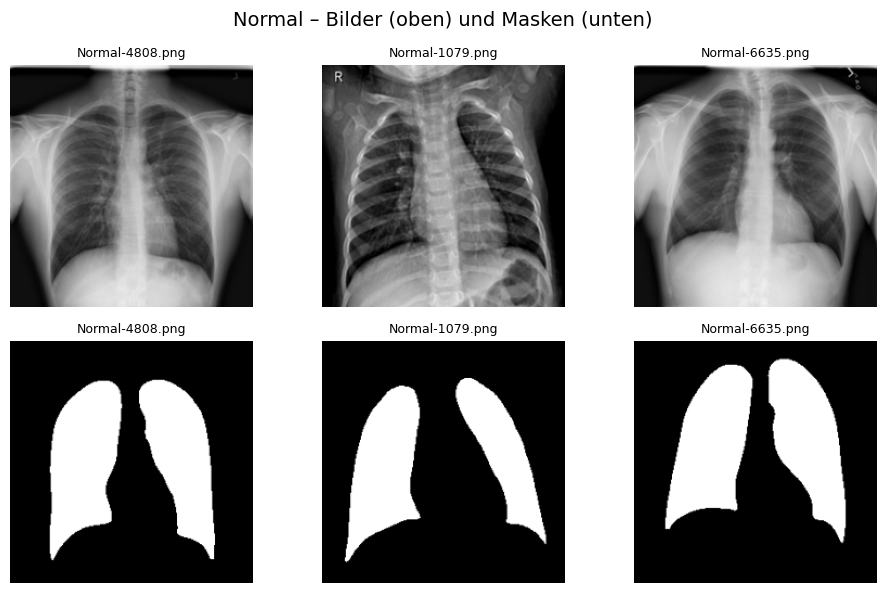

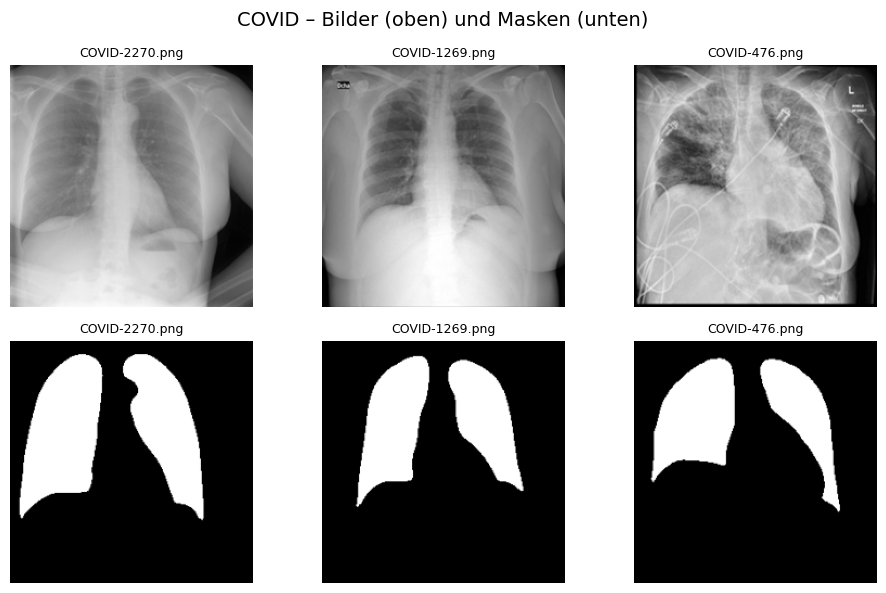

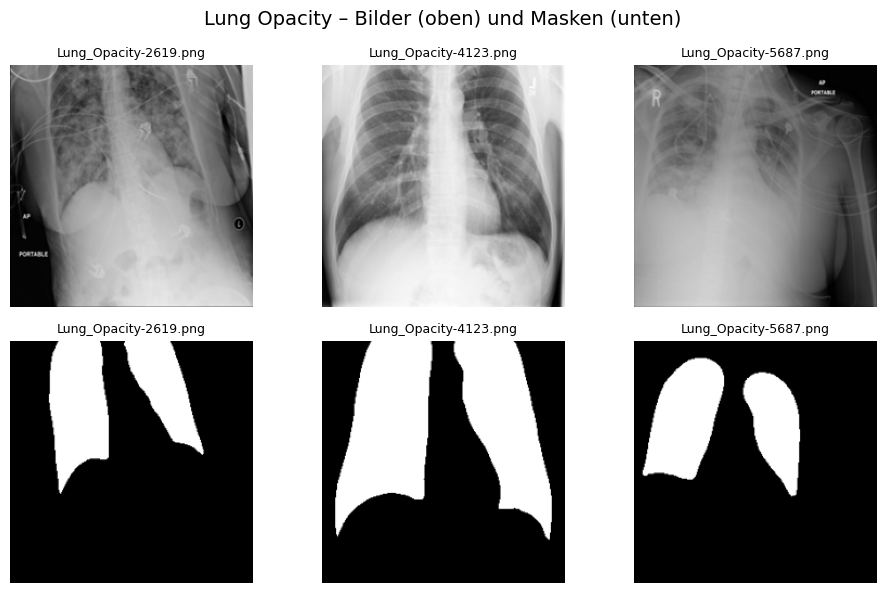

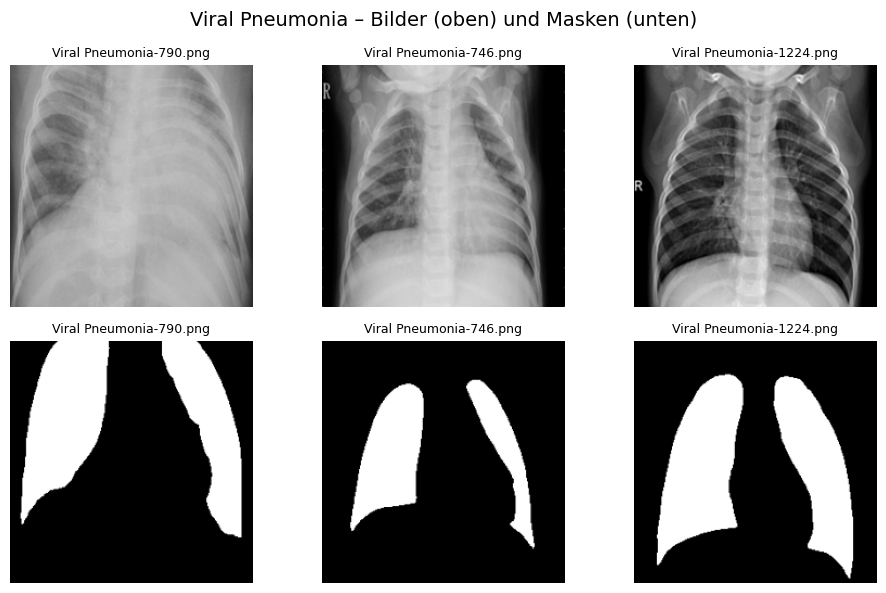

In [75]:
# --- Parameter ---
PROJECT_DIR = Path.cwd()
DATA_DIR = PROJECT_DIR / "data"
df_paths = pd.read_csv(DATA_DIR / "all_images.csv")

classes = ["Normal", "COVID", "Lung Opacity", "Viral Pneumonia".replace("_"," ")]
# korrigiere Namen anhand der tatsächlichen df_paths:
available = sorted(df_paths["label"].unique())
classes = [c for c in ["Normal", "COVID", "Lung Opacity", "Viral Pneumonia"] if c in available]

samples_per_class = 3
img_size = (224, 224)
rng = np.random.default_rng(42)

def render_no_mask(size=(224, 224), text="No mask"):
    img = Image.new("RGB", size, color=(230, 230, 230))
    draw = ImageDraw.Draw(img)
    draw.text((10, size[1]//2 - 7), text, fill=(100,100,100))
    return img

# --- Maskenpfad: .../images/NAME.png -> .../masks/NAME.png
def mask_path_for(image_path: str) -> Path:
    p = Path(image_path)
    parts = list(p.parts)
    try:
        idx = len(parts) - 1 - parts[::-1].index("images")
        parts[idx] = "masks"
        return Path(*parts)
    except ValueError:
        return p.with_name(p.name)
        
for cls in classes:
    df_cls = df_paths[df_paths["label"] == cls]
    if df_cls.empty:
        print(f"Keine Bilder für Klasse {cls} gefunden."); continue

    n = min(samples_per_class, len(df_cls))
    sel = df_cls.sample(n, random_state=42)

    fig, axes = plt.subplots(2, n, figsize=(3.2*n, 6))
    fig.suptitle(f"{cls} – Bilder (oben) und Masken (unten)", fontsize=14)
    if n == 1:
        axes = np.array([[axes[0]], [axes[1]]])

    for j, (_, row) in enumerate(sel.iterrows()):
        img = Image.open(row["path"]).convert("RGB").resize(img_size)
        axes[0, j].imshow(img); axes[0, j].axis("off")
        axes[0, j].set_title(Path(row["path"]).name, fontsize=9)

        mpath = mask_path_for(row["path"])
        if mpath.exists():
            msk = Image.open(mpath).convert("RGB").resize(img_size)
        else:
            msk = render_no_mask(img_size, "No mask")
        axes[1, j].imshow(msk); axes[1, j].axis("off")
        axes[1, j].set_title(Path(mpath).name if mpath.exists() else "—", fontsize=9)

    plt.tight_layout(); plt.show()


In [76]:
# --- Projektpfade ---
PROJECT_DIR = Path.cwd()
SPLIT_DIR   = PROJECT_DIR / "splits"
RESULTS_DIR = PROJECT_DIR / "results"
MODELS_DIR  = PROJECT_DIR / "models"
for d in [RESULTS_DIR, MODELS_DIR, RESULTS_DIR / "meta"]:
    d.mkdir(parents=True, exist_ok=True)

# --- Splits & Klassen ---
train_df = pd.read_csv(SPLIT_DIR/"train.csv")
val_df   = pd.read_csv(SPLIT_DIR/"val.csv")
test_df  = pd.read_csv(SPLIT_DIR/"test.csv")

# Klassen nur EINMAL festlegen
CLASSES_PATH = SPLIT_DIR / "classes.json"
if CLASSES_PATH.exists():
    CLASS_NAMES = json.load(open(CLASSES_PATH))
else:
    CLASS_NAMES = sorted(pd.concat([train_df["label"], val_df["label"], test_df["label"]]).unique().tolist())
    json.dump(CLASS_NAMES, open(CLASSES_PATH, "w"))

# --- Subset-Parameter (nur hier zentral; vermeide Duplikate in Notebooks) ---
USE_FRACTION   = True
TRAIN_FRACTION = 1.0   # alles nutzen
VAL_FRACTION   = 1.0
N_TRAIN_PER_CLASS = None
N_VAL_PER_CLASS   = None

def _stratified_fraction(df, frac=None, seed=42):
    if frac is None or frac >= 1.0: return df.copy()
    return (df.groupby("label", group_keys=False)
              .apply(lambda x: x.sample(frac=frac, random_state=seed))
              .reset_index(drop=True))

def _stratified_per_class(df, n=None, seed=42):
    if n is None: return df.copy()
    return (df.groupby("label", group_keys=False)
              .apply(lambda x: x.sample(min(len(x), n), random_state=seed))
              .reset_index(drop=True))

# Effektive Splits (gleich für SVM & CNN)
if USE_FRACTION:
    train_df_eff = _stratified_fraction(train_df, TRAIN_FRACTION)
    val_df_eff   = _stratified_fraction(val_df,   VAL_FRACTION)
else:
    train_df_eff = _stratified_per_class(train_df, N_TRAIN_PER_CLASS)
    val_df_eff   = _stratified_per_class(val_df,   N_VAL_PER_CLASS)
test_df_eff = test_df.copy()

# ---------- Zusammenfassung der effektiven Splits ----------
def _counts_and_perc(df, classes):
    cnt = df["label"].value_counts().reindex(classes, fill_value=0)
    pct = (cnt / max(1, cnt.sum()) * 100).round(2)
    return cnt, pct

def _summary_table(train_df, val_df, test_df, classes):
    t_cnt, t_pct = _counts_and_perc(train_df, classes)
    v_cnt, v_pct = _counts_and_perc(val_df,   classes)
    s_cnt, s_pct = _counts_and_perc(test_df,  classes)

    summary = pd.DataFrame({
        "Train (n)": t_cnt, "Train (%)": t_pct.astype(str) + "%",
        "Val (n)":   v_cnt, "Val (%)":   v_pct.astype(str) + "%",
        "Test (n)":  s_cnt, "Test (%)":  s_pct.astype(str) + "%",
    }, index=classes)

    total = pd.Series({
        "Train (n)": t_cnt.sum(), "Train (%)": "100.00%",
        "Val (n)":   v_cnt.sum(), "Val (%)":   "100.00%",
        "Test (n)":  s_cnt.sum(), "Test (%)":  "100.00%",
    }, name="TOTAL")
    return pd.concat([summary, total.to_frame().T])

# Klassenliste sicherstellen (wir haben CLASS_NAMES oben bereits gesetzt)
_summary = _summary_table(train_df_eff, val_df_eff, test_df_eff, CLASS_NAMES)

print("\n============= Effektive Datensatz-Größen (nach Subsetting) =============")
print(f"USE_FRACTION={USE_FRACTION} | TRAIN_FRACTION={TRAIN_FRACTION} | VAL_FRACTION={VAL_FRACTION} | "
      f"N_TRAIN_PER_CLASS={N_TRAIN_PER_CLASS} | N_VAL_PER_CLASS={N_VAL_PER_CLASS}")
print(f"Train: {len(train_df_eff)} | Val: {len(val_df_eff)} | Test: {len(test_df_eff)}")
print("Klassennamen:", CLASS_NAMES)
print("\nVerteilung je Split (Anzahl & Prozent):\n")
print(_summary.to_string())
print("\n=======================================================================\n")
# ------------------------------------------------------------------------



============= Effektive Datensatz-Größen (nach Subsetting) =============
USE_FRACTION=True | TRAIN_FRACTION=1.0 | VAL_FRACTION=1.0 | N_TRAIN_PER_CLASS=None | N_VAL_PER_CLASS=None
Train: 14815 | Val: 3175 | Test: 3175
Klassennamen: ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']

Verteilung je Split (Anzahl & Prozent):

                Train (n) Train (%) Val (n)  Val (%) Test (n) Test (%)
COVID                2532    17.09%     542   17.07%      542   17.07%
Lung Opacity         4208     28.4%     902   28.41%      902   28.41%
Normal               7134    48.15%    1529   48.16%     1529   48.16%
Viral Pneumonia       941     6.35%     202    6.36%      202    6.36%
TOTAL               14815   100.00%    3175  100.00%     3175  100.00%




In [77]:
# --- Bildgröße (einheitlich) ---
IMG_SIZE = 256
IMG_SIZE_CNN = IMG_SIZE

In [78]:
# --- Gemeinsame Masken-Anwendung (für SVM & CNN) ---
def load_image_and_optional_mask(path: str, use_masks: bool, img_size: int) -> np.ndarray:
    """
    Lädt Graubild, optional multipliziert mit binärer Maske (nearest, Schwelle 0.5).
    Rückgabe: float32 in [0,1], shape (H,W).
    """
    img = Image.open(path).convert("L").resize((img_size, img_size), Image.BILINEAR)
    img_np = np.asarray(img, dtype=np.float32) / 255.0
    if use_masks:
        mp = mask_path_for(path)
        if mp.exists():
            msk = Image.open(mp).convert("L").resize((img_size, img_size), Image.NEAREST)
            msk_np = (np.asarray(msk, dtype=np.float32) / 255.0 > 0.5).astype(np.float32)
            img_np = img_np * msk_np
    return img_np

# ---------- Plot-Helper (einmal zentral) ----------
def plot_confusion_matrix_simple(y_true, y_pred, class_names, title="Confusion (normiert)"):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), normalize="true")
    plt.figure(figsize=(4.8,4.2))
    im = plt.imshow(cm, cmap="Blues", vmin=0, vmax=1)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    plt.title(title); plt.tight_layout(); plt.show()

def pr_curves_ovr_from_scores(y_true, y_score, class_names, title="PR-Kurven (OvR)"):
    plt.figure(figsize=(6,4.5))
    n_cls = len(class_names)
    for k in range(n_cls):
        yk = (y_true == k).astype(int)
        prec, rec, _ = precision_recall_curve(yk, y_score[:,k])
        plt.plot(rec, prec, label=class_names[k])
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title)
    plt.legend(); plt.grid(True, alpha=0.3); plt.tightLayout(); plt.show()

In [79]:
# --- Demo: zeige Bild, Maske, und Bild×Maske ---
def demo_mask_application(sample_path: str, img_size: int = IMG_SIZE):
    img = Image.open(sample_path).convert("L").resize((img_size, img_size), Image.BILINEAR)
    mp  = mask_path_for(sample_path)
    if mp.exists():
        msk = Image.open(mp).convert("L").resize((img_size, img_size), Image.NEAREST)
        msk_np = (np.asarray(msk, dtype=np.float32) / 255.0 > 0.5).astype(np.float32)
    else:
        msk = Image.new("L", (img_size, img_size), color=0)
        msk_np = np.zeros((img_size, img_size), dtype=np.float32)

    img_np  = np.asarray(img, dtype=np.float32)/255.0
    masked  = img_np * msk_np

    fig, axes = plt.subplots(1,3, figsize=(9,3))
    axes[0].imshow(img_np, cmap="gray");   axes[0].set_title("Bild");      axes[0].axis("off")
    axes[1].imshow(msk_np, cmap="gray");   axes[1].set_title("Maske");     axes[1].axis("off")
    axes[2].imshow(masked, cmap="gray");   axes[2].set_title("Bild × Maske"); axes[2].axis("off")
    plt.tight_layout(); plt.show()

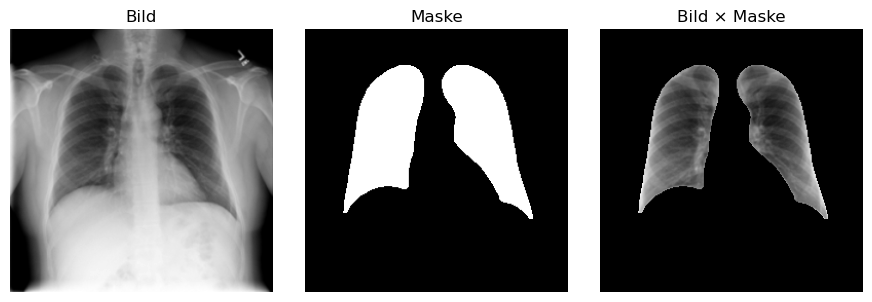

In [80]:
demo_mask_application(train_df_eff.iloc[0]["path"])

In [11]:
ML/
├── models/                       <-- MODELS_DIR
│   ├── pt_smallcnn_multi_nomask_2025_08_29_1530.pt        # bestes Modell
│   ├── pt_smallcnn_multi_nomask_2025_08_29_1530_ep005.pt  # Checkpoint
│   ├── pt_smallcnn_multi_nomask_2025_08_29_1530_ep010.pt  # Checkpoint
│   └── ...
└── results/                     <-- RESULTS_DIR
    └── pt_smallcnn_multi_nomask_2025_08_29_1530/
        ├── curves.png
        ├── metrics.png
        ├── roc_curves.png
        ├── roc_auc.json
        ├── history.json
        └── meta_train.json


SyntaxError: invalid character '├' (U+251C) (1197129981.py, line 2)

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class CsvImageDatasetCNN(Dataset):
    """
    Lädt Bilder aus CSV; optional Maske über load_image_and_optional_mask().
    Augmentierung nur im Training; Graustufen-Normierung auf [-1,1].
    """
    def __init__(self, csv_path, classes, img_size=IMG_SIZE_CNN, train=False, use_masks=False):
        self.df = pd.read_csv(csv_path)
        self.classes = classes
        self.class_to_idx = {c:i for i,c in enumerate(classes)}
        self.img_size = img_size
        self.use_masks = use_masks
        self.train = train

        self.aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(5),
        ]) if train else None

        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),                        # [0,1]
            transforms.Normalize(mean=[0.5], std=[0.5]), # -> ~[-1,1]
        ])

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_np = load_image_and_optional_mask(row["path"], self.use_masks, self.img_size)  # (H,W) in [0,1]
        img = Image.fromarray((img_np*255.0).astype(np.uint8))
        if self.train and self.aug is not None:
            img = self.aug(img)
        x = self.to_tensor(img)  # (1,H,W)
        y = self.class_to_idx[row["label"]]
        return x, y

def make_loaders_cnn(
    mode: Literal["mask","nomask"],
    img_size=IMG_SIZE_CNN,
    batch=64,
    *,
    num_workers: int = 2,                 # Notebook → 0
    persistent_workers: bool | None = None
):
    """
    Erstellt Datasets & Dataloaders.
    - num_workers: in Notebooks 0 (stabiler), auf Servern 2–8.
    - persistent_workers: Standard = (num_workers > 0)
    - pin_memory: automatisch nur, wenn CUDA verfügbar ist.
    """
    if persistent_workers is None:
        persistent_workers = num_workers > 0

    use_masks = (mode == "mask")
    train_ds = CsvImageDatasetCNN(SPLIT_DIR/"train.csv", CLASS_NAMES, img_size=img_size, train=True,  use_masks=use_masks)
    val_ds   = CsvImageDatasetCNN(SPLIT_DIR/"val.csv",   CLASS_NAMES, img_size=img_size, train=False, use_masks=use_masks)
    test_ds  = CsvImageDatasetCNN(SPLIT_DIR/"test.csv",  CLASS_NAMES, img_size=img_size, train=False, use_masks=use_masks)

    pin = torch.cuda.is_available()

    train_loader = DataLoader(
        train_ds, batch_size=batch, shuffle=True,
        num_workers=num_workers, pin_memory=pin, persistent_workers=persistent_workers
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch, shuffle=False,
        num_workers=num_workers, pin_memory=pin, persistent_workers=persistent_workers
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch, shuffle=False,
        num_workers=num_workers, pin_memory=pin, persistent_workers=persistent_workers
    )
    return train_ds, val_ds, test_ds, train_loader, val_loader, test_loader


Device: cuda


In [84]:
class SimpleNN(nn.Module):
    """
    Naives MLP: flacht das Bild (1, H, W) zu einem Vektor ab und macht 2 Dense-Layer.
    Gut als Baseline, aber ignoriert räumliche Struktur → für Lungenbilder meist zu schwach.
    """
    def __init__(self, num_classes: int, in_h: int = 224, in_w: int = 224):
        super().__init__()
        in_features = in_h * in_w
        self.net = nn.Sequential(
            nn.Flatten(),                               # (N, 1, H, W) -> (N, H*W)
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),                      # simple & stabil
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [85]:
class NNMLP(nn.Module):
    """
    'Verbesserte' MLP-Variante für medizinische Klassifikation:
    - deutlich mehr Kapazität (breiter)
    - LayerNorm statt BatchNorm (robuster bei kleinen Batches)
    - Dropout zur Regularisierung (Überanpassung ↓)
    - SiLU (Swish) als Aktivierung (weicher als ReLU → oft bessere AUROC)
    Hinweis: MLP sieht trotzdem keine lokalen Kontextmuster wie eine CNN.
    """
    def __init__(self, num_classes: int, in_h: int = 224, in_w: int = 224, p_drop: float = 0.3):
        super().__init__()
        in_features = in_h * in_w
        hidden1, hidden2 = 2048, 512
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, hidden1),
            nn.LayerNorm(hidden1),
            nn.SiLU(),                  # = swish; oft etwas besser als ReLU bei Bilddaten
            nn.Dropout(p_drop),

            nn.Linear(hidden1, hidden2),
            nn.LayerNorm(hidden2),
            nn.SiLU(),
            nn.Dropout(p_drop),

            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [86]:
class CNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
        )
        self.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.features(x).view(x.size(0), 128)
        return self.classifier(x)

In [104]:
# ---------- kleine Helfer ----------
def _ts():
    from datetime import datetime
    return datetime.now().strftime("2025_%m_%d_%H%M")

def _class_weights_from_csv(train_csv, classes, device):
    import pandas as pd
    lbl = pd.read_csv(train_csv)["label"].map({c:i for i,c in enumerate(classes)}).values
    cnt = np.bincount(lbl, minlength=len(classes))
    w = cnt.sum() / (len(classes) * (cnt + 1e-8))
    return torch.tensor(w, dtype=torch.float32, device=device)

@torch.no_grad()
def _eval_logits(model, loader, device):
    model.eval()
    logits_list, y_list = [], []
    for x, y in tqdm(loader, desc="[eval]", leave=False):
        x = x.to(device); y = torch.as_tensor(y, device=device)
        logits_list.append(model(x).cpu())
        y_list.append(y.cpu())
    logits = torch.cat(logits_list).numpy()
    y_true = torch.cat(y_list).numpy()
    y_pred = logits.argmax(1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    return float(f1m), float(bal), y_true, y_pred, logits

def _apply_title(fig, main: str, subtitle: str | None = None,
                 main_size: int = 14, sub_size: int = 9, top: float = 0.82):
    fig.subplots_adjust(top=top)         # Platz für Titel/Untertitel lassen
    fig.suptitle(main, fontsize=main_size, y=0.98)
    if subtitle:
        fig.text(0.5, 0.905, subtitle, ha="center", va="top", fontsize=sub_size, color="0.35")

# ---------- Lernkurven ----------
def _plot_learning_curves(history: Dict[str, list], out_dir: Path, header: str):
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plotgröße kompakt
    fig = plt.figure(figsize=(5, 3))
    plt.plot(epochs, history["train_loss"], label="Trainings-Verlust")
    plt.plot(epochs, history["val_loss"], label="Validierungs-Verlust")
    plt.xlabel("Epoche"); plt.ylabel("Verlust")
    plt.legend(); plt.grid(True, alpha=0.3)
    _apply_title(fig, main="Lernkurven", subtitle=header, top=0.82)
    fig.savefig(out_dir / "curves.png", dpi=160)
    plt.close(fig)

    # F1 / Balanced Accuracy
    fig = plt.figure(figsize=(5, 3))
    plt.plot(epochs, history["val_f1"], label="F1-Wert (macro)")
    plt.plot(epochs, history["val_bal"], label="Balancierte Genauigkeit")
    plt.xlabel("Epoche"); plt.ylabel("Score")
    plt.legend(); plt.grid(True, alpha=0.3)
    _apply_title(fig, main="Validierungs-Metriken", subtitle=header, top=0.82)
    fig.savefig(out_dir / "metrics.png", dpi=160)
    plt.close(fig)


# ---------- Konfusionsmatrix ----------
def _plot_confusion(y_true, y_pred, class_names, out_path: Path,
                    header: str = "Konfusionsmatrix",  # bleibt erhalten (Haupttitel)
                    subtitle: str | None = None,        # <<< NEU
                    figsize=(6, 6)):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import csv
    import numpy as np

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=45, colorbar=False)
    ax.set_title("")  # Achsentitel leer lassen, wir verwenden globalen Titel
    _apply_title(fig, main=header, subtitle=subtitle, top=0.82)  # <<< NEU
    plt.tight_layout(rect=(0, 0, 1, 0.90))
    fig.savefig(out_path, dpi=160)
    plt.close(fig)

    # Punkte/Counts zusätzlich als CSV speichern
    cm_csv = out_path.with_name("confusion_matrix.csv")
    with open(cm_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow([""] + list(class_names))
        for i, row in enumerate(cm):
            w.writerow([class_names[i]] + list(map(int, row)))


# ---------- ROC-Kurven ----------
def _plot_roc_multiclass(y_true, logits, class_names, out_dir: Path,
                         subtitle: str | None = None,  # <<< NEU
                         figsize=(8, 6)):
    import json
    import numpy as np
    from sklearn.metrics import roc_curve, auc

    y_true = np.asarray(y_true)
    scores = torch.softmax(torch.from_numpy(logits), dim=1).numpy()
    n_classes = len(class_names)
    Y = np.eye(n_classes)[y_true]

    fpr, tpr, roc_auc = {}, {}, {}
    roc_points = {"per_class": {}}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        roc_points["per_class"][class_names[i]] = {
            "fpr": fpr[i].tolist(),
            "tpr": tpr[i].tolist(),
            "auc": float(roc_auc[i]),
        }

    fpr_micro, tpr_micro, _ = roc_curve(Y.ravel(), scores.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    roc_points["micro"] = {
        "fpr": fpr_micro.tolist(),
        "tpr": tpr_micro.tolist(),
        "auc": float(auc_micro),
    }
    roc_points["macro"] = {"auc": float(np.mean(list(roc_auc.values())))}

    with open(out_dir / "roc_points.json", "w") as f:
        json.dump(roc_points, f, indent=2)

    fig = plt.figure(figsize=figsize)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], linestyle="--", label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
    plt.plot(fpr_micro, tpr_micro, label=f"Micro-Durchschnitt (AUC={auc_micro:.3f})")
    plt.plot([0, 1], [0, 1], "k--", linewidth=1)
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel("Falsch-positiv-Rate (1−Spezifität)")
    plt.ylabel("Richtig-positiv-Rate (Sensitivität)")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    _apply_title(fig, main="ROC-Kurven (One-vs-Rest)", subtitle=subtitle, top=0.82)
    fig.savefig(out_dir / "roc_curves.png", dpi=160)
    plt.close(fig)

def _build_model(model_kind: Literal["cnn","nn_simple","nn_mlp"],
                 num_classes: int, img_size: int = 224) -> nn.Module:
    if model_kind == "cnn":
        return CNN(num_classes=num_classes)
    elif model_kind == "nn_simple":
        return SimpleNN(num_classes=num_classes, in_h=img_size, in_w=img_size)
    elif model_kind == "nn_mlp":
        return NNMLP(num_classes=num_classes, in_h=img_size, in_w=img_size)
    else:
        raise ValueError(f"Unbekannter model_kind: {model_kind}")


# ---------- Neueste Modellpfade ----------
def _latest_model_path_by_kind(model_kind: str, mode: str) -> Path:
    prefix_map = {"cnn": "cnn", "nn_simple": "nn", "nn_mlp": "nn"}
    prefix = prefix_map[model_kind]

    # exact match first
    exact = sorted(MODELS_DIR.glob(f"{prefix}_{mode}_*.pt"))
    if exact:
        return exact[-1]

    # if none found, show what *does* exist for that prefix
    all_for_prefix = sorted(MODELS_DIR.glob(f"{prefix}_*.pt"))
    hints = "\n".join(p.name for p in all_for_prefix) or "(none)"
    raise FileNotFoundError(
        f"Kein Modell gefunden für prefix='{prefix}' und mode='{mode}'.\n"
        f"Verfügbare Dateien mit prefix '{prefix}':\n{hints}\n"
        f"→ Entweder mode/Dateinamen anpassen oder model_path direkt angeben."
    )


# ---------- PNG-Anzeige ----------
def _display_png_if_exists(path: Path, caption: str | None = None):
    try:
        from IPython.display import display, Image as IPyImage
        if Path(path).exists():
            if caption:
                print(caption)
            display(IPyImage(filename=str(path)))
    except Exception as e:
        print(f"(Hinweis) Konnte {path} nicht inline anzeigen: {e}")

def _lr_range_test(model, criterion, train_loader, device, 
                   min_lr: float = 1e-5, max_lr: float = 1e-1, num_steps: int = 200):
    """
    Einfacher LR-Range-Test nach Smith:
      - LR wächst exponentiell von min_lr bis max_lr.
      - Loss wird geglättet (beta=0.98).
      - Abbruch bei Loss-Explosion.
    Rückgabe: (empfohlene_lr, scan_dict)
    """
    import numpy as np
    optimizer = torch.optim.Adam(model.parameters(), lr=min_lr)
    gamma = (max_lr / min_lr) ** (1.0 / max(1, num_steps - 1))
    beta = 0.98
    avg_loss = 0.0
    losses, lrs = [], []

    print(f"[lr-finder] Start: min_lr={min_lr:.1e}, max_lr={max_lr:.1e}, steps={num_steps}")
    model.train()
    step = 0
    it = iter(train_loader)
    lr = min_lr
    for g in optimizer.param_groups:
        g["lr"] = lr

    while step < num_steps:
        try:
            x, y = next(it)
        except StopIteration:
            it = iter(train_loader)
            x, y = next(it)

        x = x.to(device); y = torch.as_tensor(y, device=device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward(); optimizer.step()

        step += 1
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smooth_loss = avg_loss / (1 - beta ** step)
        losses.append(smooth_loss); lrs.append(lr)

        lr *= gamma
        for g in optimizer.param_groups:
            g["lr"] = lr

        if step > 20 and smooth_loss > 4 * np.min(losses):
            print("[lr-finder] Abbruch: Loss-Explosion erkannt.")
            break

    best_idx = int(np.argmin(losses))
    best_lr = lrs[best_idx] * 0.2  # etwas links vom Minimum
    print(f"[lr-finder] Ende: min_loss={float(np.min(losses)):.4f} @idx={best_idx} → vorgeschlagene LR={best_lr:.3e}")
    return float(best_lr), {"lrs": lrs, "losses": losses, "best_idx": best_idx}

def _save_history_csv(out_dir: Path, history: Dict[str, list], epoch_times: list, lrs_epoch: list):
    """
    Speichert epochenweise Daten für spätere Overlays:
    epoch, train_loss, val_loss, val_f1, val_bal, lr_epoch, epoch_time_sec
    """
    import csv
    out_path = out_dir / "history.csv"
    with open(out_path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["epoch","train_loss","val_loss","val_f1","val_bal","lr_epoch","epoch_time_sec"])
        for i in range(len(history["train_loss"])):
            w.writerow([
                i+1,
                history["train_loss"][i],
                history["val_loss"][i],
                history["val_f1"][i],
                history["val_bal"][i],
                lrs_epoch[i] if i < len(lrs_epoch) else None,
                round(epoch_times[i], 3) if i < len(epoch_times) else None
            ])
    return out_path

VALID_MODES  = {"mask", "nomask"}
VALID_KINDS  = {"cnn", "nn_simple", "nn_mlp"}

def _guard_mode_kind(mode, model_kind, fn_name="train"):
    if mode not in VALID_MODES:
        # Häufiger Tippfehler: mode versehentlich als model_kind übergeben
        if mode in VALID_KINDS:
            raise ValueError(
                f"[{fn_name}] Ungültiger mode='{mode}'. "
                f"Meintest du model_kind='{mode}'? "
                f"Rufe z.B. so auf: {fn_name}(mode='nomask', model_kind='{mode}', ...)"
            )
        raise ValueError(f"[{fn_name}] Ungültiger mode='{mode}'. Erlaubt: {sorted(VALID_MODES)}")
    if model_kind not in VALID_KINDS:
        raise ValueError(f"[{fn_name}] Ungültiger model_kind='{model_kind}'. Erlaubt: {sorted(VALID_KINDS)}")


In [105]:
def train(
    mode: Literal["mask","nomask"],
    *,
    epochs=20, patience=5, lr: float | str = 1e-3,  # <- float oder "auto"
    batch=64, img_size=224,
    ckpt_every: int = 5,
    binary_abnormal: bool = False,
    show_after: bool = True,
    model_kind: Literal["cnn","nn_simple","nn_mlp"] = "cnn"
):

    _guard_mode_kind(mode, model_kind, "train")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ts = _ts()
    train_ds, val_ds, test_ds, train_loader, val_loader, _ = make_loaders_cnn(mode, img_size, batch)

    # Klassen (optional binär)
    class_names = CLASS_NAMES
    map_to_binary = None
    if binary_abnormal:
        class_names = ["Normal", "Ungesund"]
        def map_to_binary(y): return 0 if y == CLASS_NAMES.index("Normal") else 1

    model = _build_model(model_kind, num_classes=len(class_names), img_size=img_size).to(device)

    # Klassen-Gewichte
    weights = _class_weights_from_csv(SPLIT_DIR/"train.csv", CLASS_NAMES, device) if not binary_abnormal else None
    if binary_abnormal and weights is not None:
        pos = neg = 0
        for _, y in train_loader:
            y = y.numpy()
            pos += (y != CLASS_NAMES.index("Normal")).sum()
            neg += (y == CLASS_NAMES.index("Normal")).sum()
        total = pos + neg
        w = np.array([total/(2*neg+1e-8), total/(2*pos+1e-8)], dtype=np.float32)
        weights = torch.tensor(w, device=device)
    criterion = nn.CrossEntropyLoss(weight=weights)

    # === LR-Auto ===
    if isinstance(lr, str) and lr.lower() == "auto":
        # frisches Modell für LR-Finder nutzen
        finder_model = _build_model(model_kind, num_classes=len(class_names), img_size=img_size).to(device)
        finder_model.load_state_dict(model.state_dict())
        best_lr, _scan = _lr_range_test(finder_model, criterion, train_loader, device)
        print(f"[lr-finder] gewählte Start-LR: {best_lr:.3e}")
        lr = float(best_lr)

    optimizer = torch.optim.Adam(model.parameters(), lr=float(lr))

    prefix = {"cnn":"cnn","nn_simple":"nn","nn_mlp":"nn_mlp"}[model_kind]
    tag = f"{prefix}_{mode}_{ts}_batch-{batch}_lr-{str(lr).replace('.', '') if isinstance(lr, float) else lr}"


    out_dir   = RESULTS_DIR / tag
    model_dir = MODELS_DIR
    out_dir.mkdir(parents=True, exist_ok=True)

    best_val, wait = -np.inf, 0
    epoch_times, t0_total = [], time.perf_counter()
    history = {"train_loss":[], "val_loss":[], "val_f1":[], "val_bal":[]}
    lrs_epoch = []

    print(f"\n[TRAIN-START] Model={model_kind} | Modus={mode} | Batch={batch} | LR={lr} | Epochen={epochs} | Binary={binary_abnormal} ==> Gerät: {device}")

    for epoch in range(1, epochs+1):
        model.train()
        t0 = time.perf_counter()
        running, seen = 0.0, 0
        for x, y in tqdm(train_loader, desc=f"[train] Epoche {epoch}/{epochs}", leave=False):
            x = x.to(device); y = torch.as_tensor(y, device=device)
            if binary_abnormal and map_to_binary is not None:
                y = torch.tensor([map_to_binary(int(yi)) for yi in y], device=device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward(); optimizer.step()
            bs = x.size(0); running += loss.item()*bs; seen += bs
        train_loss = running / max(1, seen)

        # Validation
        model.eval()
        with torch.no_grad():
            v_loss, v_seen = 0.0, 0
            logits_all, yt_all = [], []
            for x, y in tqdm(val_loader, desc=f"[val] Epoche {epoch}/{epochs}", leave=False):
                x = x.to(device); y = torch.as_tensor(y, device=device)
                if binary_abnormal and map_to_binary is not None:
                    y = torch.tensor([map_to_binary(int(yi)) for yi in y], device=device)
                logits = model(x)
                loss = criterion(logits, y)
                v_loss += loss.item()*x.size(0); v_seen += x.size(0)
                logits_all.append(logits.cpu()); yt_all.append(y.cpu())
            val_loss = v_loss / max(1, v_seen)
            logits_np = torch.cat(logits_all).numpy()
            y_true = torch.cat(yt_all).numpy()
            y_pred = logits_np.argmax(1)
            val_f1  = f1_score(y_true, y_pred, average="macro")
            val_bal = balanced_accuracy_score(y_true, y_pred)

        dt = time.perf_counter() - t0
        epoch_times.append(dt)
        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["val_f1"].append(float(val_f1))
        history["val_bal"].append(float(val_bal))
        lrs_epoch.append(float(optimizer.param_groups[0]["lr"]))

        print(f"Epoche {epoch:02d}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f} "
              f"| val_f1={val_f1:.3f} | val_bal={val_bal:.3f} | {dt:.2f}s")

        _plot_learning_curves(history, out_dir, header=f"mode={mode}, batch={batch}, lr={lr}")
        if epoch % ckpt_every == 0:
            torch.save(model.state_dict(), model_dir / f"{tag}_ep{epoch:03d}.pt")
        if val_f1 > best_val:
            best_val, wait = val_f1, 0
            torch.save(model.state_dict(), model_dir / f"{tag}.pt")
        else:
            wait += 1
            if wait >= patience:
                print("Early Stopping (Kriterium: bester Validierungs-F1).")
                break

    # History zusätzlich als CSV speichern (für Overlays)
    _save_history_csv(out_dir, history, epoch_times, lrs_epoch)

    meta = {
        "model_kind": model_kind,
        "tag": tag, "mode": mode, "classes": class_names,
        "epochs_run": len(history["train_loss"]),
        "epoch_times_sec": [round(x,3) for x in epoch_times],
        "train_total_sec": round(time.perf_counter() - t0_total, 3),
        "best_val_f1_macro": float(best_val),
        "lr": float(lr), "batch": batch, "img_size": img_size,
        "binary_abnormal": bool(binary_abnormal),
    }
    with open(out_dir/"meta_train.json","w") as f: json.dump(meta, f, indent=2)
    print(f"[train] fertig → {out_dir}")

    if show_after:
        _display_png_if_exists(out_dir/"curves.png",  "Lernkurven (Train/Val-Verlust)")
        _display_png_if_exists(out_dir/"metrics.png", "Validierungsmetriken (F1/Balance)")
        
    return {
        "tag": tag,
        "out_dir": out_dir,
        "model_path": model_dir / f"{tag}.pt",
        "history_csv": out_dir / "history.csv"
    }

In [115]:
def test(
    mode: Literal["mask","nomask"],
    model_path: Optional[str] = None,
    *,
    batch=64, img_size=224,
    binary_abnormal: bool = False,
    show_after: bool = True,
    model_kind: Literal["cnn","nn_simple","nn_mlp"] = "cnn"
):

    _guard_mode_kind(mode, model_kind, "test")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ts = _ts()
    _, _, test_ds, _, _, test_loader = make_loaders_cnn(mode, img_size, batch)
    class_names = ["Normal","Ungesund"] if binary_abnormal else CLASS_NAMES

    #if model_path is None: alt
        #model_path = _latest_model_path(mode, binary_abnormal)
    #else:
        #model_path = Path(model_path)

    if model_path is None:
        model_path = _latest_model_path_by_kind(model_kind, mode)  # gibt Path zurück
    else:
        model_path = Path(model_path).expanduser()  # ← String sicher machen


    tag = f"{Path(model_path).stem}_test"
    out_dir = RESULTS_DIR / tag

    # Modell konstruieren & Gewichte sicher laden
    model = _build_model(model_kind, num_classes=len(class_names), img_size=img_size).to(device)

    # --- Checkpoint laden (kompatibel mit PyTorch >=2.4 und älter) ---
    try:
        state = torch.load(model_path, map_location=device, weights_only=True)
    except TypeError:
        import warnings
        warnings.filterwarnings("ignore", message=".*weights_only=False.*")
        state = torch.load(model_path, map_location=device)

    # --- (Optional) Head-Outputgröße prüfen, falls identifizierbar ---
    # defensiv initialisieren
    ckpt_out = None
    expected_out = len(class_names)

    # mehrere gängige Kopf-Namen berücksichtigen
    candidate_suffixes = [
        "classifier.1.weight",   # häufig bei einfachen CNNs
        "classifier.3.weight",   # falls zusätzl. Layer
        "fc.weight",             # ResNet/ähnlich
        "head.weight",           # timm / ViT
        "linear.weight"          # generisch
    ]
    head_w_key = next((k for k in state.keys() if any(k.endswith(sfx) for sfx in candidate_suffixes)), None)

    if head_w_key is not None:
        try:
            ckpt_out = int(getattr(state[head_w_key], "shape", [None, None])[0])
        except Exception:
            ckpt_out = None

        if ckpt_out is not None and ckpt_out != expected_out:
            raise ValueError(
                f"Checkpoint hat {ckpt_out} Klassen, test() aber {expected_out}. "
                f"Setze binary_abnormal entsprechend oder nimm ein passendes Checkpoint."
            )

    # Gewichte laden (strict=True, damit echte Inkompatibilitäten auffallen)
    model.load_state_dict(state, strict=True)
    model.eval()
    
    print(f"[TEST-START] Model={model_kind} | Modus={mode} | Batch={batch}")
    print(f"Pfad={Path(model_path).name}")

    t0 = time.perf_counter()
    f1m, balc, y_true, y_pred, logits = _eval_logits(model, test_loader, device)
    dt = time.perf_counter() - t0

    tag = f"{model_path.stem}_test"
    out_dir = RESULTS_DIR / tag

    # Falls Ordner existiert → automatisch durchnummerieren:
    k = 1
    while out_dir.exists():
        out_dir = RESULTS_DIR / f"{tag}_r{k}"
        k += 1
    out_dir.mkdir(parents=True, exist_ok=True)

    #tag = f"{model_path.stem}_{ts}_test" alt
    #out_dir = RESULTS_DIR / tag; out_dir.mkdir(parents=True, exist_ok=True) alt

    # speichern
    np.save(out_dir/"y_true.npy", y_true)
    np.save(out_dir/"y_pred.npy", y_pred)
    np.save(out_dir/"logits.npy", logits)

    # per-class Präzision/Recall/F1
    pr, rc, f1c, sup = precision_recall_fscore_support(
    y_true, y_pred,
    labels=range(len(class_names)),
    zero_division=0
    )
    metrics = {
        "test_f1_macro": float(f1m),
        "test_bal_acc": float(balc),
        "per_class": {class_names[i]: {
            "precision": float(pr[i]), "recall": float(rc[i]), "f1": float(f1c[i]), "support": int(sup[i])
        } for i in range(len(class_names))}
    }
    with open(out_dir/"metrics.json","w") as f: json.dump(metrics, f, indent=2)

    # Plots
    _plot_confusion(y_true, y_pred, class_names, out_path=out_dir/"confusion_matrix.png",
                    header="Konfusionsmatrix (Test)")
    _plot_roc_multiclass(y_true, logits, class_names, out_dir=out_dir)

    print(f"[test] F1(macro)={f1m:.3f} | BalAcc={balc:.3f} | Zeit={dt:.2f}s | {out_dir}")

    if show_after:
        _display_png_if_exists(out_dir/"confusion_matrix.png", "Konfusionsmatrix (Test)")
        _display_png_if_exists(out_dir/"roc_curves.png",       "ROC-Kurven (per Klasse, micro/macro)")
    
    return {
        "out_dir": str(out_dir),
        "test_f1_macro": float(f1m),
        "test_bal_acc": float(balc)
    }

[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Abbruch: Loss-Explosion erkannt.
[lr-finder] Ende: min_loss=1.2711 @idx=66 → vorgeschlagene LR=4.243e-05
[lr-finder] gewählte Start-LR: 4.243e-05

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=64 | LR=4.2429035698212815e-05 | Epochen=20 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1708 | val_loss=0.9933 | val_f1=0.520 | val_bal=0.557 | 46.95s


Epoche 02: train_loss=1.0142 | val_loss=0.9752 | val_f1=0.443 | val_bal=0.558 | 45.91s


Epoche 03: train_loss=0.9836 | val_loss=0.9321 | val_f1=0.549 | val_bal=0.598 | 45.85s


Epoche 04: train_loss=0.9458 | val_loss=0.8936 | val_f1=0.565 | val_bal=0.634 | 45.96s


Epoche 05: train_loss=0.9284 | val_loss=0.9013 | val_f1=0.540 | val_bal=0.619 | 46.73s


Epoche 06: train_loss=0.8778 | val_loss=0.8664 | val_f1=0.592 | val_bal=0.628 | 46.03s


Epoche 07: train_loss=0.8707 | val_loss=0.8313 | val_f1=0.595 | val_bal=0.638 | 45.56s


Epoche 08: train_loss=0.8566 | val_loss=0.8238 | val_f1=0.617 | val_bal=0.645 | 46.05s


Epoche 09: train_loss=0.8267 | val_loss=0.8126 | val_f1=0.613 | val_bal=0.646 | 46.14s


Epoche 10: train_loss=0.8103 | val_loss=0.8036 | val_f1=0.575 | val_bal=0.641 | 45.74s


Epoche 11: train_loss=0.8122 | val_loss=0.8040 | val_f1=0.587 | val_bal=0.644 | 46.82s


Epoche 12: train_loss=0.7888 | val_loss=0.7796 | val_f1=0.611 | val_bal=0.660 | 46.53s


Epoche 13: train_loss=0.7820 | val_loss=0.8032 | val_f1=0.642 | val_bal=0.659 | 46.60s


Epoche 14: train_loss=0.7817 | val_loss=0.7718 | val_f1=0.612 | val_bal=0.665 | 45.39s


Epoche 15: train_loss=0.7549 | val_loss=0.7926 | val_f1=0.591 | val_bal=0.651 | 46.56s


Epoche 16: train_loss=0.7526 | val_loss=0.7671 | val_f1=0.590 | val_bal=0.672 | 46.00s


Epoche 17: train_loss=0.7406 | val_loss=0.7688 | val_f1=0.598 | val_bal=0.660 | 46.35s


Epoche 18: train_loss=0.7500 | val_loss=0.7582 | val_f1=0.595 | val_bal=0.676 | 46.26s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05
Lernkurven (Train/Val-Verlust)


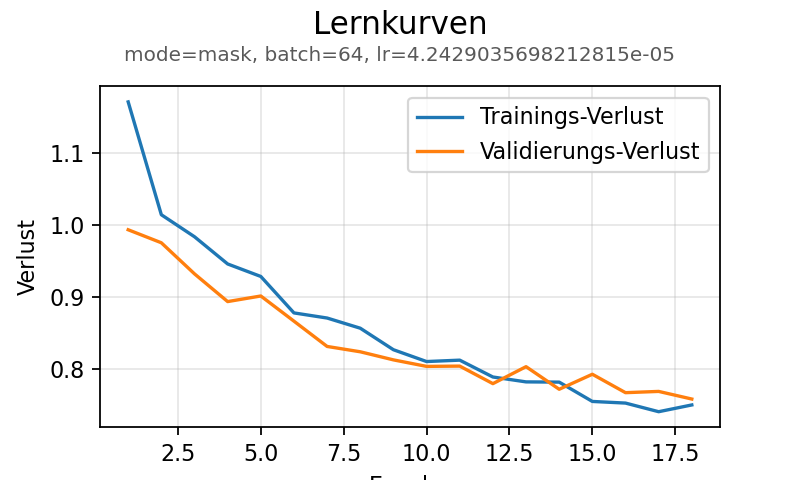

Validierungsmetriken (F1/Balance)


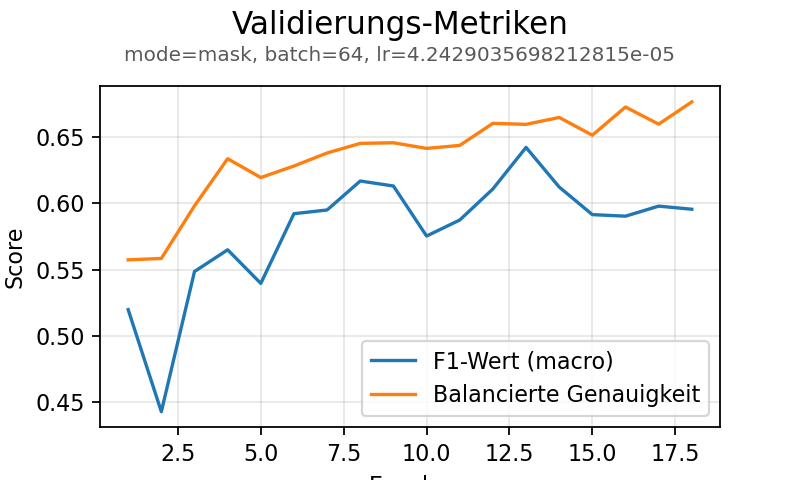

{'tag': 'nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05',
 'out_dir': PosixPath('/home/lupan001/ML/results/nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05'),
 'model_path': PosixPath('/home/lupan001/ML/models/nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05.pt'),
 'history_csv': PosixPath('/home/lupan001/ML/results/nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05/history.csv')}

In [151]:
train(
    "mask",
    model_kind="nn_simple",
    epochs=20,
    lr="auto",
    batch=64,
    img_size=224
)

[TEST-START] Model=nn_simple | Modus=mask | Batch=64
Pfad=nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05_ep015.pt


[test] F1(macro)=0.578 | BalAcc=0.640 | Zeit=8.45s | /home/lupan001/ML/results/nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05_ep015_test
Konfusionsmatrix (Test)


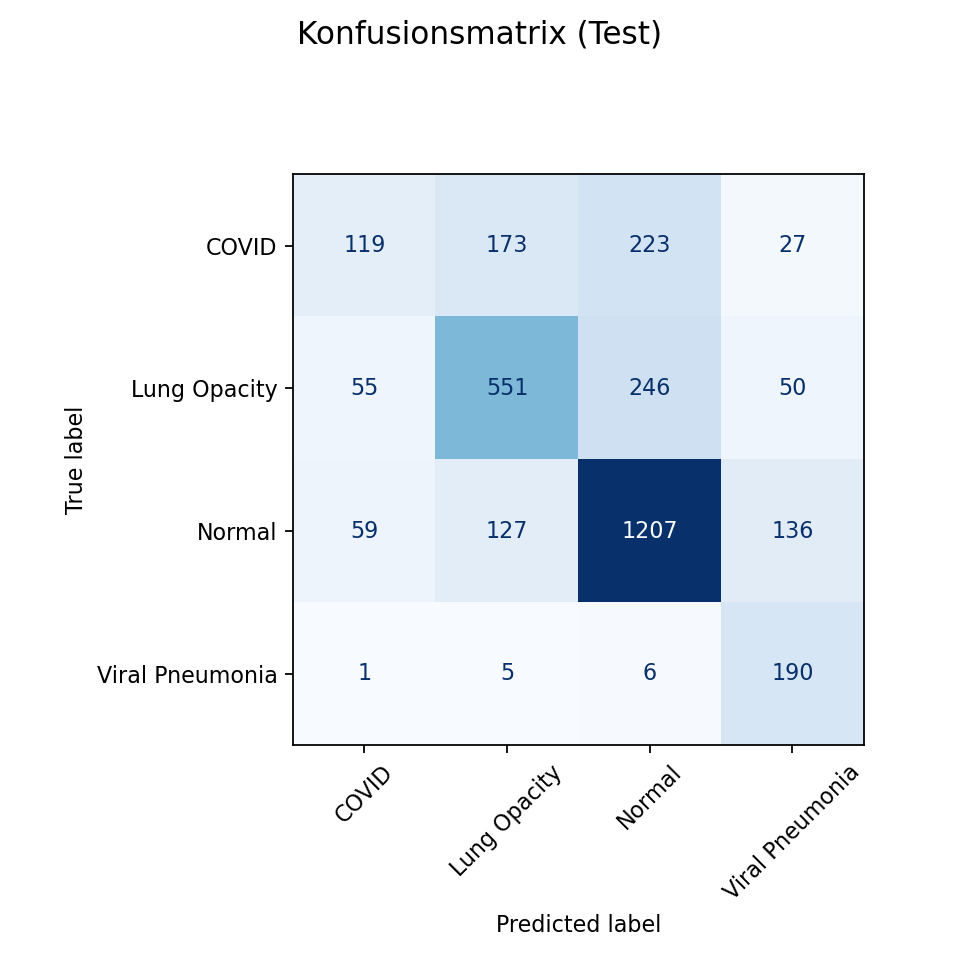

ROC-Kurven (per Klasse, micro/macro)


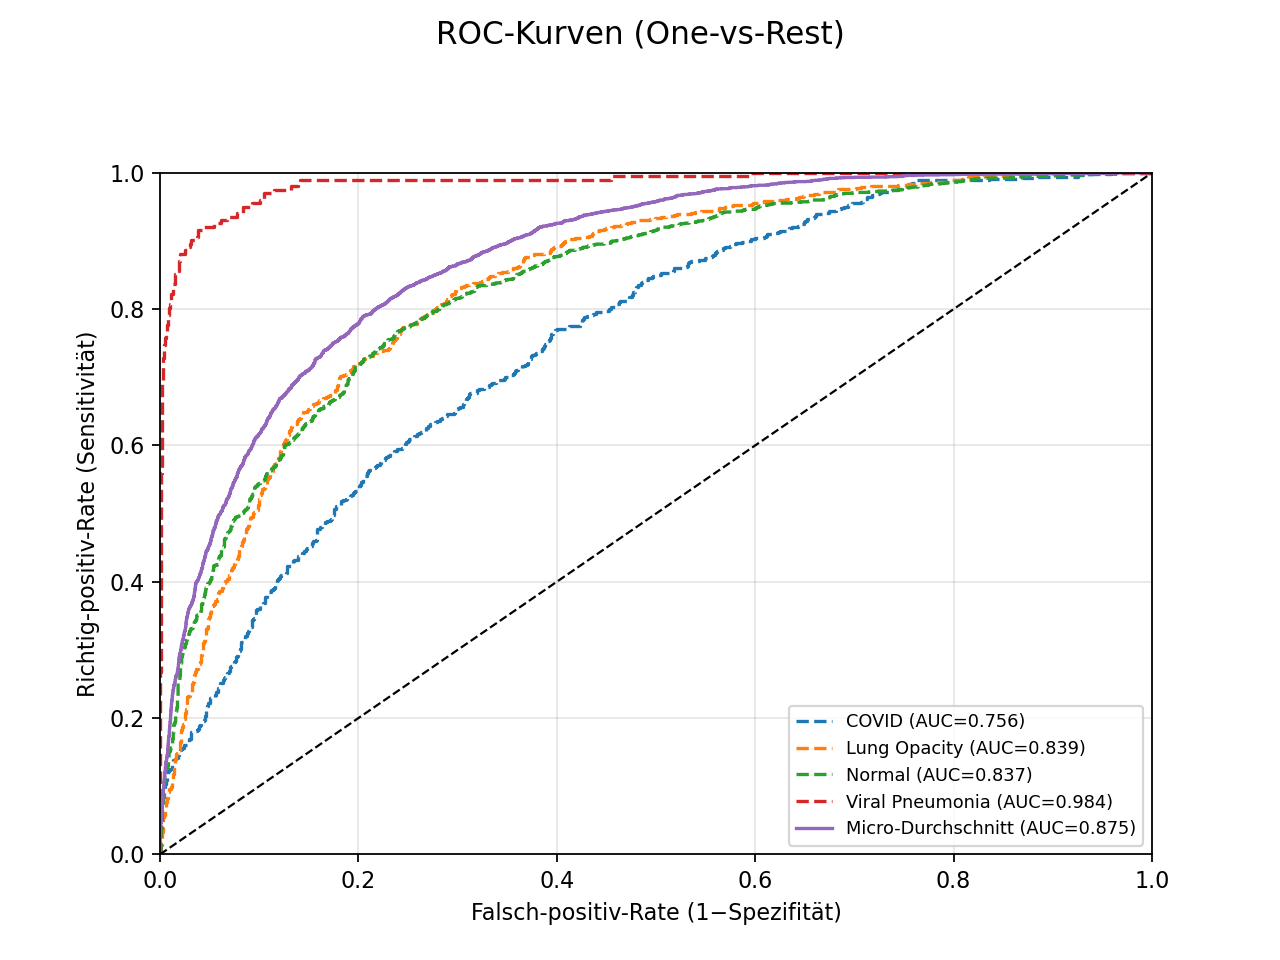

{'out_dir': '/home/lupan001/ML/results/nn_mask_2025_08_31_1814_batch-64_lr-42429035698212815e-05_ep015_test',
 'test_f1_macro': 0.5783599038946794,
 'test_bal_acc': 0.6401052099383837}

In [152]:
test("mask", model_kind="nn_simple")

In [ ]:
def run_sweep_train_test(
    mode: Literal["mask", "nomask"],
    *,
    batches: list[int] | None = None,
    lrs: list[float | str] | None = None,   # lr kann float ODER "auto" sein
    epochs: int = 10,
    img_size: int = 224,
    fixed_lr: float | str | None = 1e-3,   # kann ebenfalls float ODER "auto" sein
    fixed_batch: int | None = 64,
    binary_abnormal: bool = False,
    model_kind: Literal["cnn", "nn_simple", "nn_mlp"] = "cnn"   # <<< NEU
):
    """
    Sweep über mehrere Batches ODER mehrere Lernraten.
    lr kann float oder "auto" sein.
    """
    assert (batches is not None) ^ (lrs is not None), \
        "Entweder 'batches' ODER 'lrs' angeben, nicht beides."

    train_dirs = []
    test_dirs = []

    sweep_items = batches if batches is not None else lrs
    for item in sweep_items:
        # --- Setup der Hyperparameter ---
        if batches is not None:
            b = int(item)
            lr = fixed_lr
        else:
            b = fixed_batch
            lr = item

        print(f"\n=== SWEEP RUN: model={model_kind} | mode={mode} | batch={b} | lr={lr} ===")

        # === Trainieren ===
        out = train(
            mode,
            batch=b,
            lr=lr,  # float oder "auto"
            epochs=epochs,
            img_size=img_size,
            binary_abnormal=binary_abnormal,
            model_kind=model_kind,   # <<< NEU
            show_after=False
        )
        train_dirs.append(out["out_dir"])

        # === Testen (immer genau dieses Modell) ===
        tres = test(
            mode,
            model_path=out["model_path"],
            batch=b,
            img_size=img_size,
            binary_abnormal=binary_abnormal,
            model_kind=model_kind,   # <<< NEU
            show_after=False
        )
        test_dirs.append(Path(tres["out_dir"]))

        # === Kurzer Konsolen-Log ===
        print(
            f"[SWEEP] Modell={out['out_dir'].name} | "
            f"F1={tres['test_f1_macro']:.3f} | "
            f"BalAcc={tres['test_bal_acc']:.3f}"
        )

    return train_dirs, test_dirs


In [129]:
def _extract_hyperparams_from_tag(tag: str):
    """
    Erwartete Schemen (robust):
      <model>_<mode>_<timestamp>_batch-<B>_lr-<LR>
    Beispiele:
      cnn_nomask_2025_08_29_2210_batch-32_lr-0001
      nn_mlp_mask_2025_08_30_1012_batch-128_lr-0.001
      nn_nomask_..._batch-64_lr-2.55e-05
      nn_nomask_..._batch-64_lr-25501024814260373e-05   # (Punkt entfernt)
    """
    parts = tag.split("_")
    model = parts[0] if len(parts) > 0 else None       # 'cnn' | 'nn' | 'nn_mlp' (bei nn_mlp wird nur 'nn' angezeigt – rein kosmetisch)
    mode  = parts[1] if len(parts) > 1 else None       # mask | nomask

    m_b = re.search(r"batch-(\d+)", tag)
    batch = int(m_b.group(1)) if m_b else None

    lr_val = None
    # WICHTIG: '-' zulassen, außerdem e/E und '+' für Exponenten
    m_lr = re.search(r"lr-([A-Za-z0-9eE\.\-\+]+)", tag)
    if m_lr:
        s = m_lr.group(1)
        try:
            if s.lower() == "auto":
                lr_val = "auto"
            elif any(ch in s for ch in ".eE"):  # z.B. '0.001', '1e-05', '255e-05'
                lr_val = float(s)
            else:
                # kompakter Stil wie '0001' -> 0.0001 (Heuristik)
                lr_val = float("0." + s) if len(s) > 1 else float(s)
        except Exception:
            # Fallback: lieber None als crashen
            lr_val = None

    return {"model": model, "mode": mode, "batch": batch, "lr": lr_val, "raw": tag}


def _compute_varying_params(tags: list[str]):
    parsed = [_extract_hyperparams_from_tag(t) for t in tags]
    batches = {p["batch"] for p in parsed if p["batch"] is not None}
    lrs     = {p["lr"]    for p in parsed if p["lr"]    is not None}

    vary_batch = len(batches) > 1
    vary_lr    = len(lrs)    > 1

    if vary_batch and not vary_lr:
        mode = "batch"
    elif vary_lr and not vary_batch:
        mode = "lr"
    elif vary_batch and vary_lr:
        mode = "both"
    else:
        mode = "none"
    return mode, parsed


def _label_from_tag(tag: str, vary_mode: str, *,
                    force_full: bool = False,
                    show_model: bool = False,
                    show_mode: bool = False):
    """
    Erzeugt eine kompakte Legende.
    - force_full=True -> immer "batch=.., lr=.."
    - show_model=True -> Präfix (cnn/nn/nn_mlp) voranstellen
    - show_mode=True  -> (mask/nomask) anhängen
    """
    info = _extract_hyperparams_from_tag(tag)
    b, lr, model, mode = info["batch"], info["lr"], info["model"], info["mode"]

    def _lr_str(v):
        if v == "auto":
            return "auto"
        if isinstance(v, float):
            return f"{v:.4g}"
        return str(v) if v is not None else "?"

    parts = []

    if show_model and model:
        parts.append(model)

    # Kernteile je nach Wunsch
    if force_full:
        if b is not None:
            parts.append(f"batch={b}")
        if lr is not None:
            parts.append(f"lr={_lr_str(lr)}")
    else:
        if vary_mode == "batch" and b is not None:
            parts.append(f"batch={b}")
        elif vary_mode == "lr" and lr is not None:
            parts.append(f"lr={_lr_str(lr)}")
        else:
            # both/none → zeige was vorhanden ist
            sub = []
            if b is not None: sub.append(f"batch={b}")
            if lr is not None: sub.append(f"lr={_lr_str(lr)}")
            if sub: parts.append(", ".join(sub))

    if show_mode and mode:
        parts.append(mode)

    return " | ".join(parts) if parts else info["raw"]


def plot_train_overlays_grid(result_dirs: list[Path] | list[str],
                             metrics: tuple[str, ...] = ("train_loss","val_loss","val_f1","val_bal"),
                             title_prefix: str = "Trainings-Overlays"):
    """
    Zeichnet bis zu 4 Trainings-Metriken im 2x2-Layout.
    Default-Reihenfolge: train_loss | val_loss
                         val_f1     | val_bal
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    result_dirs = [Path(p) for p in result_dirs]
    colors = plt.cm.tab10.colors

    # Welche Info variiert? (batch/lr/both)
    tags = [rdir.name for rdir in result_dirs]
    vary_mode, _ = _compute_varying_params(tags)

    # 2x2 Layout
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    axes = axes.flatten()

    # max. 4 Metriken zeichnen
    for mi, metric in enumerate(metrics[:4]):
        ax = axes[mi]
        legends_print = []
        plotted_any = False

        for idx, rdir in enumerate(result_dirs):
            hist_path = rdir / "history.csv"
            if not hist_path.exists():
                continue
            df = pd.read_csv(hist_path)

            if metric not in df.columns:
                continue

            label = _label_from_tag(
                rdir.name, vary_mode,
                force_full=True, show_model=True, show_mode=True
            )

            ax.plot(df["epoch"], df[metric],
                    linewidth=2, color=colors[idx % len(colors)],
                    label=label)
            legends_print.append(f"{label} | {metric} max={df[metric].max():.4f}")
            plotted_any = True

        ax.set_title(f"{title_prefix}: {metric}")
        ax.set_xlabel("Epoche")
        ax.set_ylabel(metric)
        ax.grid(alpha=0.3)
        # kleine Legende pro Achse
        if plotted_any:
            ax.legend(fontsize=7, loc="best")

        if legends_print:
            print(f"\n=== MODELLVERGLEICH (Train {metric}) ===")
            for line in sorted(set(legends_print)):
                print(line)

    # Falls weniger als 4 Metriken gewünscht: restliche Achsen unsichtbar
    for j in range(len(metrics), 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_test_roc_overlays_grid(test_result_dirs: list[Path] | list[str],
                                class_order: list[str] | None = None):
    """
    Zeigt vier ROC-Plots (standard: micro + 3 Klassen) in einer einzigen Figure im 2x2-Layout.
    class_order steuert die Reihenfolge, z.B. ["micro","COVID","Lung Opacity","Viral Pneumonia"]
    """
    import json
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path

    test_result_dirs = [Path(p) for p in test_result_dirs]
    colors = plt.cm.tab10.colors

    tags = [rdir.name for rdir in test_result_dirs]
    vary_mode, _ = _compute_varying_params(tags)

    if class_order is None:
        class_order = ["micro", "COVID", "Lung Opacity", "Viral Pneumonia"]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 nebeneinander, 2 darunter
    axes = axes.flatten()

    for pi, which in enumerate(class_order[:4]):  # maximal 4 Felder
        ax = axes[pi]
        legends_print = []
        plotted_any = False

        for i, rdir in enumerate(test_result_dirs):
            rp = rdir / "roc_points.json"
            if not rp.exists():
                continue
            data = json.loads(rp.read_text())

            # Kurven auswählen
            if which == "micro":
                fpr = np.array(data["micro"]["fpr"]); tpr = np.array(data["micro"]["tpr"])
                aucv = float(data["micro"]["auc"])
            else:
                if which not in data["per_class"]:
                    continue
                fpr = np.array(data["per_class"][which]["fpr"]); tpr = np.array(data["per_class"][which]["tpr"])
                aucv = float(data["per_class"][which]["auc"])

            base_lbl = _label_from_tag(rdir.name, vary_mode, force_full=True, show_model=True, show_mode=True)
            lbl = f"{base_lbl} (AUC={aucv:.3f})"
            ax.plot(fpr, tpr, color=colors[i % len(colors)], linewidth=2, label=lbl)
            legends_print.append(lbl)
            plotted_any = True

        ax.plot([0, 1], [0, 1], "k--", linewidth=1)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
        ax.set_title(f"ROC: {which}")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=7, loc="lower right")

        if not plotted_any:
            ax.text(0.5, 0.5, "Keine Daten", ha="center", va="center", transform=ax.transAxes, alpha=0.6)

        if legends_print:
            print(f"\n=== MODELLVERGLEICH (ROC {which}) ===")
            for l in legends_print:
                print(l)

    # Falls weniger als 4 Plots gewünscht/entstanden sind, restliche Achsen ausblenden
    for j in range(len(class_order), 4):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


def plot_all_models(train_dirs, metric="val_f1", title_prefix="Modellvergleich"):
    """
    Zeichnet alle Runs (verschiedene Modelle, batches und LRs) in EINEM Plot.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from pathlib import Path

    train_dirs = [Path(p) for p in train_dirs]
    colors = plt.cm.tab20.colors

    fig, ax = plt.subplots(figsize=(10, 6))
    legends_print = []

    for idx, rdir in enumerate(train_dirs):
        hist_path = Path(rdir) / "history.csv"
        if not hist_path.exists():
            continue

        df = pd.read_csv(hist_path)
        label = _label_from_tag(rdir.name)

        ax.plot(df["epoch"], df[metric],
                color=colors[idx % len(colors)], linewidth=2, label=label)

        legends_print.append(f"{label} | {metric} max={df[metric].max():.4f}")

    ax.set_title(f"{title_prefix} — {metric}")
    ax.set_xlabel("Epoche")
    ax.set_ylabel(metric)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=7, loc="best", ncol=2)

    print("\n=== MODELLVERGLEICH ===")
    for line in sorted(legends_print):
        print(line)

    plt.tight_layout()
    plt.show()



In [157]:
from pathlib import Path
import random, torch, numpy as np, pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

def _list_available_models(prefix: str | None = None) -> list[Path]:
    """Listet alle verfügbaren Modelle für ein gegebenes Präfix auf."""
    pats = [f"{prefix}_*.pt"] if prefix else ["*.pt"]
    cands = []
    for pat in pats:
        cands.extend(sorted((MODELS_DIR).glob(pat)))
    return cands


def predict_random_image(
    *,
    data_csv: Path,
    img_size: int = 224,
    # Variante A: best_entry aus analyze_best_per_model_kind(...)
    best_entry: dict | None = None,
    # Variante B: expliziter Modellpfad + Zusatzinfos
    model_path: Path | None = None,
    model_kind: str | None = None,
    mode: str | None = None,
    seed: int | None = None,
):
    """
    Einfache Vorhersage-Funktion für EIN zufälliges Bild.
    - Entweder mit 'best_entry' (aus analyze_best_per_model_kind)
    - oder mit explizitem 'model_path' UND (model_kind, mode)
    Wendet bei mode='mask' automatisch die passende Maske an.
    """

    # --- Parameter prüfen ---
    assert (best_entry is not None) ^ (model_path is not None), \
        "Entweder 'best_entry' ODER 'model_path' angeben."

    # --- Entry vorbereiten ---
    if model_path is not None:
        assert model_kind is not None and mode is not None, \
            "Für 'model_path' bitte auch 'model_kind' und 'mode' angeben."
        entry = {
            "model_kind": model_kind,
            "mode": mode,
            "batch": "?",
            "lr": "?",
            "model_path": Path(model_path),
        }
    else:
        entry = dict(best_entry)  # Kopie, um Änderungen zu vermeiden

    # --- Prüfen, ob Modell existiert, sonst Fallback ---
    mp = Path(entry["model_path"])
    if not mp.exists():
        print(f"[warn] Modell nicht gefunden: {mp.name}")
        try:
            # Fallback: neuestes Modell gleicher Art & Modus
            mp = _latest_model_path_by_kind(entry["model_kind"], entry["mode"])
            print(f"[fallback] Nutze neuestes Modell: {mp.name}")
        except FileNotFoundError:
            # Kandidaten anzeigen
            pref = {"cnn": "cnn", "nn_simple": "nn", "nn_mlp": "nn_mlp"}[entry["model_kind"]]
            cand = _list_available_models(prefix=f"{pref}_{entry['mode']}")
            if cand:
                print("[info] Verfügbare Modelle:")
                for p in cand[-10:]:
                    print("   ", p.name)
            raise FileNotFoundError(f"Kein passendes Modell gefunden für "
                                    f"{entry['model_kind']=}, {entry['mode']=}")
    entry["model_path"] = mp

    # --- CSV laden & zufälliges Bild wählen ---
    df = pd.read_csv(data_csv)
    if df.empty:
        print(f"[predict] CSV leer: {data_csv}")
        return
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    row = df.sample(1).iloc[0]
    img_path = Path(row["path"])
    true_label = str(row["label"])

    # --- Bild laden ---
    img = Image.open(img_path).convert("L").resize((img_size, img_size), Image.BILINEAR)
    x_np = np.asarray(img, dtype=np.float32) / 255.0

    # --- Falls Modus = mask: Maske anwenden ---
    if entry["mode"] == "mask":
        mask_path = img_path.parent.parent / "masks" / img_path.name
        if mask_path.exists():
            mask = Image.open(mask_path).convert("L").resize((img_size, img_size), Image.NEAREST)
            mask_np = (np.asarray(mask, dtype=np.float32) / 255.0 > 0.5).astype(np.float32)
            x_np = x_np * mask_np
        else:
            print(f"[warn] Maske nicht gefunden für {img_path.name}")

        # --- Preprocessing wie beim Training ---
    # Sanity checks + NaNs/Inf entfernen
    x_np = (x_np - 0.5) / 0.5
    if not np.isfinite(x_np).all():
        x_np = np.nan_to_num(x_np, nan=0.0, posinf=1.0, neginf=-1.0)

    # Lokales Device wählen (globalen 'device' nur nehmen, wenn vorhanden)
    device_local = globals().get("device", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # Tensor bauen
    x = torch.from_numpy(x_np.astype(np.float32)).unsqueeze(0).unsqueeze(0)

    # --- Modell laden ---
    num_classes = len(CLASS_NAMES)
    model = _build_model(entry["model_kind"], num_classes=num_classes, img_size=img_size)

    try:
        state = torch.load(entry["model_path"], map_location="cpu", weights_only=True)
    except TypeError:
        state = torch.load(entry["model_path"], map_location="cpu")
    model.load_state_dict(state)
    model.eval()

    def _forward_on(dev):
        mdl = model.to(dev, non_blocking=True)
        xx  = x.to(dev, non_blocking=True)
        with torch.no_grad():
            out = mdl(xx)
            probs = torch.softmax(out, dim=1).float().cpu().numpy()[0]
        return probs

    # Erst GPU versuchen, bei device-assert elegant auf CPU zurückfallen
    try:
        probs = _forward_on(device_local)
    except RuntimeError as e:
        if "device-side assert triggered" in str(e).lower() or "cuda" in str(e).lower():
            print("[predict] CUDA-Fehler erkannt → Fallback auf CPU.")
            # WICHTIG: Nach device-assert ist der CUDA-Kontext oft 'vergiftet'.
            # Für einen einzelnen Inferenz-Call nehmen wir einfach CPU:
            probs = _forward_on(torch.device("cpu"))
        else:
            raise

    pred_idx = int(np.argmax(probs))
    pred_label = CLASS_NAMES[pred_idx]
    pred_prob = float(probs[pred_idx] * 100.0)

    # --- Plot ---
    plt.figure(figsize=(5, 5))
    plt.imshow((x_np * 0.5 + 0.5), cmap="gray")
    plt.axis("off")
    title = (
        f"Pred: {pred_label} ({pred_prob:.1f}%) | True: {true_label}\n"
        f"Model: {entry['model_kind']} | mode={entry['mode']} | "
        f"batch={entry.get('batch', '?')} | lr={entry.get('lr', '?')}\n"
        f"{Path(entry['model_path']).name}"
    )
    plt.title(title, fontsize=9)
    plt.tight_layout()
    plt.show()


    return {
        "img_path": str(img_path),
        "true_label": true_label,
        "pred_label": pred_label,
        "pred_prob": float(pred_prob),
        "model_path": str(entry["model_path"]),
        "model_kind": entry["model_kind"],
        "mode": entry["mode"],
    }


==================== TOP 1–3 (beste je Modellart, nach Val-F1 sortiert) ====================

Platz 1:
  Modellart:    cnn
  Modus:        nomask
  Batchsize:    64
  LR:           0.001
  Tag:          cnn_nomask_2025_08_31_1622_batch-64_lr-0001
  Modellpfad:   /home/lupan001/ML/models/cnn_nomask_2025_08_31_1622_batch-64_lr-0001.pt
  Val-F1:       0.856
  Test-F1:      0.840
  Test-BalAcc:  0.852
  Test-Ordner:  /home/lupan001/ML/results/cnn_nomask_2025_08_31_1622_batch-64_lr-0001_test

Platz 2:
  Modellart:    nn_simple
  Modus:        nomask
  Batchsize:    128
  LR:           5.601007788367291e-05
  Tag:          nn_nomask_2025_08_31_0616_batch-128_lr-5601007788367291e-05
  Modellpfad:   /home/lupan001/ML/models/nn_nomask_2025_08_31_0616_batch-128_lr-5601007788367291e-05.pt
  Val-F1:       0.854
  Test-F1:      0.832
  Test-BalAcc:  0.845
  Test-Ordner:  /home/lupan001/ML/results/nn_nomask_2025_08_31_0616_batch-128_lr-5601007788367291e-05_test

Platz 3:
  Modellart:    nn_mlp
  Mo

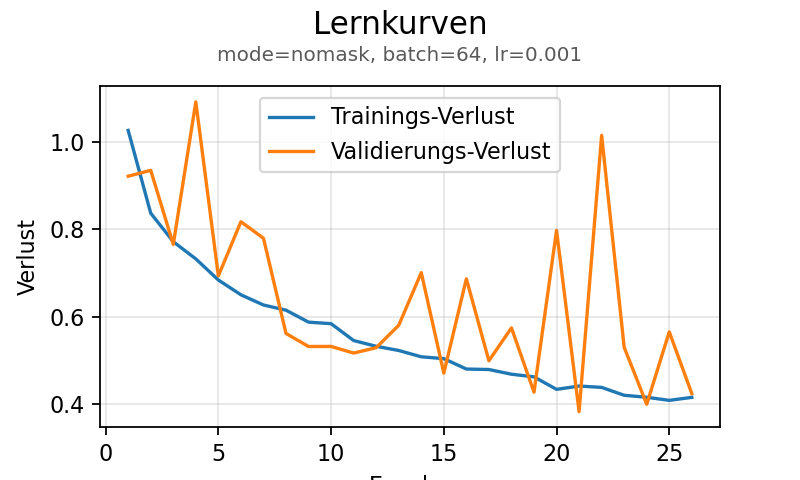

Validierungsmetriken (F1/Balance)


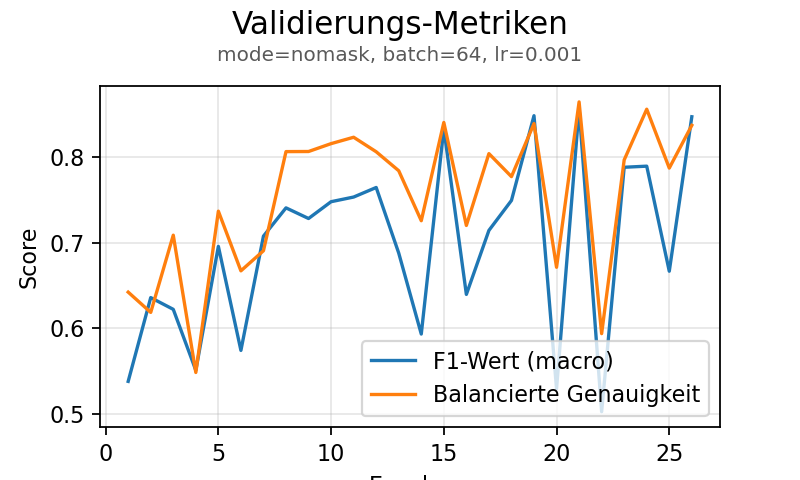

Konfusionsmatrix (Test)


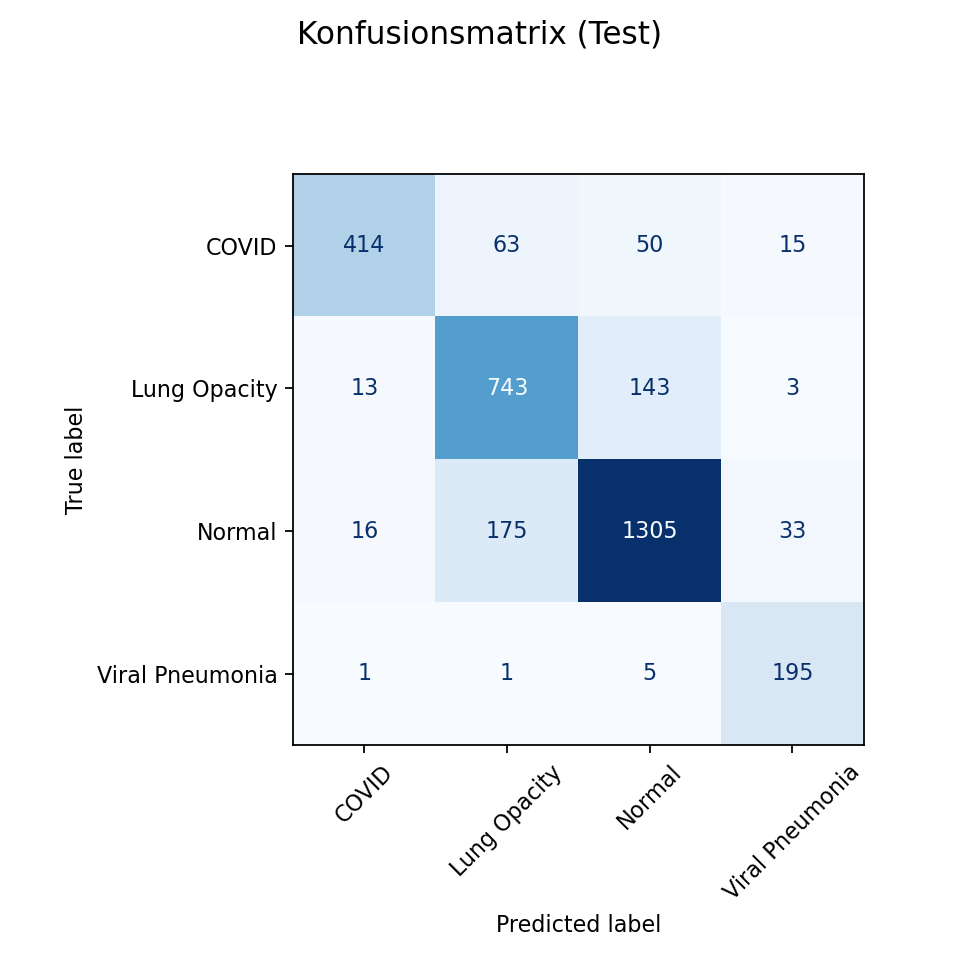

ROC-Kurven (Test)


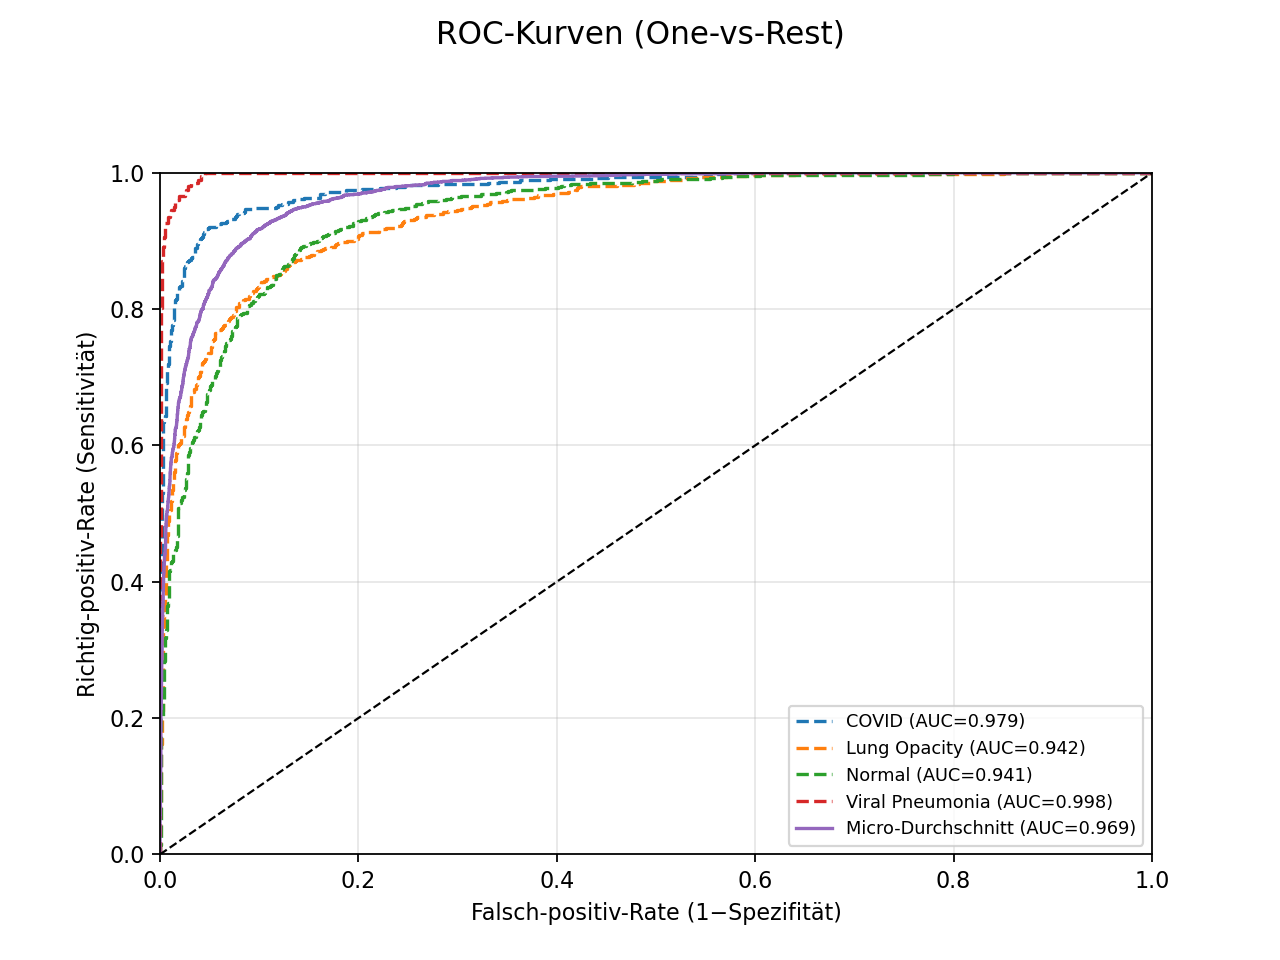

[predict] CUDA-Fehler erkannt → Fallback auf CPU.


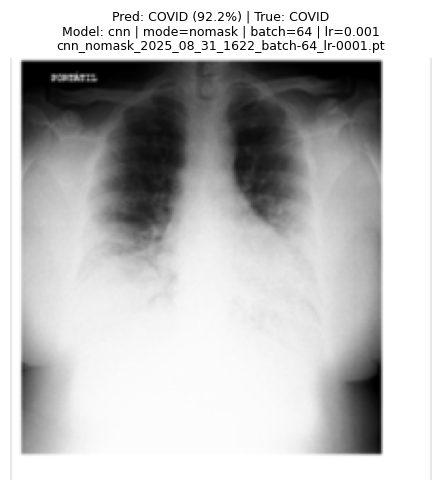

In [158]:
out = analyze_best_per_model_kind(
    results_dir=RESULTS_DIR,
    models_dir=MODELS_DIR,
    data_csv=DATA_DIR / "all_images.csv",
    img_size=224
)
# out["best"] enthält das beste Model

[predict] CUDA-Fehler erkannt → Fallback auf CPU.


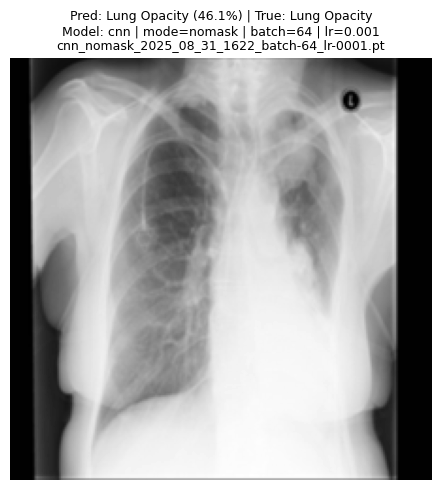

{'img_path': '/home/lupan001/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-3775.png',
 'true_label': 'Lung Opacity',
 'pred_label': 'Lung Opacity',
 'pred_prob': 46.097180247306824,
 'model_path': '/home/lupan001/ML/models/cnn_nomask_2025_08_31_1622_batch-64_lr-0001.pt',
 'model_kind': 'cnn',
 'mode': 'nomask'}

In [159]:
predict_random_image(
    data_csv=DATA_DIR / "all_images.csv",
    img_size=224,
    best_entry=out["best"]       # direkt wiederverwenden
)

In [ ]:
predict_random_image(
    data_csv=DATA_DIR / "all_images.csv",
    img_size=224,
    model_path=MODELS_DIR / "cnn_mask_2025_08_31_1015_batch-128_lr-0.001.pt",
    model_kind="cnn",
    mode="mask"
)


In [125]:
train_dirs_nns_mask_batch, test_dirs_nns_mask_batch = run_sweep_train_test(
    "mask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=40,
    model_kind="nn_simple"
)



=== SWEEP RUN: model=nn_simple | mode=mask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=16 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=2.2210 | val_loss=1.0493 | val_f1=0.443 | val_bal=0.536 | 43.84s


Epoche 02: train_loss=1.0694 | val_loss=1.0110 | val_f1=0.477 | val_bal=0.556 | 43.72s


Epoche 03: train_loss=1.0611 | val_loss=1.0634 | val_f1=0.502 | val_bal=0.520 | 43.52s


Epoche 04: train_loss=1.0809 | val_loss=1.3104 | val_f1=0.463 | val_bal=0.463 | 44.38s


Epoche 05: train_loss=1.0268 | val_loss=1.0070 | val_f1=0.530 | val_bal=0.555 | 43.90s


Epoche 06: train_loss=1.0435 | val_loss=1.0747 | val_f1=0.402 | val_bal=0.481 | 43.79s


Epoche 07: train_loss=1.0255 | val_loss=1.0593 | val_f1=0.437 | val_bal=0.554 | 43.10s


Epoche 08: train_loss=1.0222 | val_loss=0.9735 | val_f1=0.492 | val_bal=0.565 | 44.00s


Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
        ^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/opt/conda/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file de

Epoche 09: train_loss=1.0307 | val_loss=0.9675 | val_f1=0.494 | val_bal=0.566 | 44.40s


Epoche 10: train_loss=0.9935 | val_loss=1.0435 | val_f1=0.514 | val_bal=0.525 | 43.96s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_30_2251_batch-16_lr-0001
[TEST-START] Model=nn_simple | Modus=mask | Batch=16
Pfad=nn_mask_2025_08_30_2251_batch-16_lr-0001.pt


[test] F1(macro)=0.514 | BalAcc=0.534 | Zeit=8.03s | /home/lupan001/ML/results/nn_mask_2025_08_30_2251_batch-16_lr-0001_test
[SWEEP] Modell=nn_mask_2025_08_30_2251_batch-16_lr-0001 | F1=0.514 | BalAcc=0.534

=== SWEEP RUN: model=nn_simple | mode=mask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=4.5030 | val_loss=1.1283 | val_f1=0.435 | val_bal=0.487 | 44.70s


Epoche 02: train_loss=1.0617 | val_loss=1.1128 | val_f1=0.417 | val_bal=0.514 | 43.85s


Epoche 03: train_loss=0.9996 | val_loss=0.9213 | val_f1=0.531 | val_bal=0.599 | 43.23s


Epoche 04: train_loss=0.9617 | val_loss=0.9342 | val_f1=0.497 | val_bal=0.597 | 43.89s


Epoche 05: train_loss=0.9063 | val_loss=0.9237 | val_f1=0.516 | val_bal=0.567 | 44.05s


Epoche 06: train_loss=0.8982 | val_loss=0.8535 | val_f1=0.583 | val_bal=0.621 | 45.00s


Epoche 07: train_loss=0.8613 | val_loss=0.8904 | val_f1=0.497 | val_bal=0.598 | 44.42s


Epoche 08: train_loss=0.8761 | val_loss=0.8417 | val_f1=0.595 | val_bal=0.644 | 43.93s


Epoche 09: train_loss=0.8503 | val_loss=0.8298 | val_f1=0.578 | val_bal=0.642 | 43.76s


Epoche 10: train_loss=0.8440 | val_loss=0.8771 | val_f1=0.618 | val_bal=0.630 | 44.63s


Epoche 11: train_loss=0.8468 | val_loss=0.8393 | val_f1=0.598 | val_bal=0.645 | 45.14s


Epoche 12: train_loss=0.8406 | val_loss=0.8185 | val_f1=0.614 | val_bal=0.652 | 44.82s


Epoche 13: train_loss=0.8305 | val_loss=0.8598 | val_f1=0.556 | val_bal=0.617 | 44.79s


Epoche 14: train_loss=0.8216 | val_loss=0.8475 | val_f1=0.560 | val_bal=0.620 | 43.87s


Epoche 15: train_loss=0.8285 | val_loss=0.8083 | val_f1=0.616 | val_bal=0.653 | 44.06s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_30_2259_batch-64_lr-0001
[TEST-START] Model=nn_simple | Modus=mask | Batch=64
Pfad=nn_mask_2025_08_30_2259_batch-64_lr-0001.pt


[test] F1(macro)=0.601 | BalAcc=0.616 | Zeit=7.88s | /home/lupan001/ML/results/nn_mask_2025_08_30_2259_batch-64_lr-0001_test
[SWEEP] Modell=nn_mask_2025_08_30_2259_batch-64_lr-0001 | F1=0.601 | BalAcc=0.616

=== SWEEP RUN: model=nn_simple | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=10.7338 | val_loss=1.0732 | val_f1=0.401 | val_bal=0.509 | 44.90s


Epoche 02: train_loss=1.1044 | val_loss=1.0371 | val_f1=0.475 | val_bal=0.573 | 44.47s


Epoche 03: train_loss=1.0169 | val_loss=0.9664 | val_f1=0.544 | val_bal=0.580 | 45.12s


Epoche 04: train_loss=0.9898 | val_loss=0.9436 | val_f1=0.522 | val_bal=0.587 | 43.88s


Epoche 05: train_loss=0.9764 | val_loss=1.1012 | val_f1=0.320 | val_bal=0.512 | 43.95s


Epoche 06: train_loss=0.9588 | val_loss=0.9788 | val_f1=0.431 | val_bal=0.565 | 43.91s


Epoche 07: train_loss=0.9384 | val_loss=0.8799 | val_f1=0.575 | val_bal=0.628 | 42.80s


Epoche 08: train_loss=0.9073 | val_loss=0.8791 | val_f1=0.554 | val_bal=0.625 | 43.52s


Epoche 09: train_loss=0.8878 | val_loss=0.8633 | val_f1=0.550 | val_bal=0.638 | 44.06s


Epoche 10: train_loss=0.8698 | val_loss=0.8373 | val_f1=0.603 | val_bal=0.637 | 43.93s


Epoche 11: train_loss=0.8636 | val_loss=0.8517 | val_f1=0.606 | val_bal=0.621 | 43.47s


Epoche 12: train_loss=0.8354 | val_loss=0.8482 | val_f1=0.554 | val_bal=0.637 | 43.81s


Epoche 13: train_loss=0.8197 | val_loss=0.8283 | val_f1=0.560 | val_bal=0.647 | 43.67s


Epoche 14: train_loss=0.8132 | val_loss=0.8148 | val_f1=0.565 | val_bal=0.646 | 43.67s


Epoche 15: train_loss=0.7940 | val_loss=0.7912 | val_f1=0.607 | val_bal=0.655 | 44.19s


Epoche 16: train_loss=0.7743 | val_loss=0.7921 | val_f1=0.567 | val_bal=0.634 | 43.43s


Epoche 17: train_loss=0.7919 | val_loss=0.8063 | val_f1=0.605 | val_bal=0.638 | 44.80s


Epoche 18: train_loss=0.7915 | val_loss=0.9065 | val_f1=0.595 | val_bal=0.598 | 43.88s


Epoche 19: train_loss=0.8086 | val_loss=0.8105 | val_f1=0.616 | val_bal=0.659 | 44.23s


Epoche 20: train_loss=0.7718 | val_loss=0.8110 | val_f1=0.566 | val_bal=0.649 | 44.67s


Epoche 21: train_loss=0.7703 | val_loss=0.7915 | val_f1=0.587 | val_bal=0.657 | 43.20s


Epoche 22: train_loss=0.7552 | val_loss=0.7712 | val_f1=0.642 | val_bal=0.670 | 43.58s


Epoche 23: train_loss=0.7573 | val_loss=0.7680 | val_f1=0.596 | val_bal=0.667 | 43.71s


Epoche 24: train_loss=0.7605 | val_loss=0.7731 | val_f1=0.624 | val_bal=0.661 | 44.04s


Epoche 25: train_loss=0.7620 | val_loss=0.8048 | val_f1=0.616 | val_bal=0.649 | 44.47s


Epoche 26: train_loss=0.7377 | val_loss=0.7730 | val_f1=0.587 | val_bal=0.675 | 44.44s


Epoche 27: train_loss=0.7363 | val_loss=0.7738 | val_f1=0.618 | val_bal=0.655 | 43.69s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_30_2310_batch-256_lr-0001
[TEST-START] Model=nn_simple | Modus=mask | Batch=256
Pfad=nn_mask_2025_08_30_2310_batch-256_lr-0001.pt


[test] F1(macro)=0.625 | BalAcc=0.663 | Zeit=8.37s | /home/lupan001/ML/results/nn_mask_2025_08_30_2310_batch-256_lr-0001_test
[SWEEP] Modell=nn_mask_2025_08_30_2310_batch-256_lr-0001 | F1=0.625 | BalAcc=0.663



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=16 | lr=0.0001 | mask | train_loss max=2.2210
nn | batch=256 | lr=0.0001 | mask | train_loss max=10.7338
nn | batch=64 | lr=0.0001 | mask | train_loss max=4.5030

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=16 | lr=0.0001 | mask | val_f1 max=0.5297
nn | batch=256 | lr=0.0001 | mask | val_f1 max=0.6418
nn | batch=64 | lr=0.0001 | mask | val_f1 max=0.6176

=== MODELLVERGLEICH (Train val_bal) ===
nn | batch=16 | lr=0.0001 | mask | val_bal max=0.5663
nn | batch=256 | lr=0.0001 | mask | val_bal max=0.6754
nn | batch=64 | lr=0.0001 | mask | val_bal max=0.6525

=== MODELLVERGLEICH (Train val_loss) ===
nn | batch=16 | lr=0.0001 | mask | val_loss max=1.3104
nn | batch=256 | lr=0.0001 | mask | val_loss max=1.1012
nn | batch=64 | lr=0.0001 | mask | val_loss max=1.1283


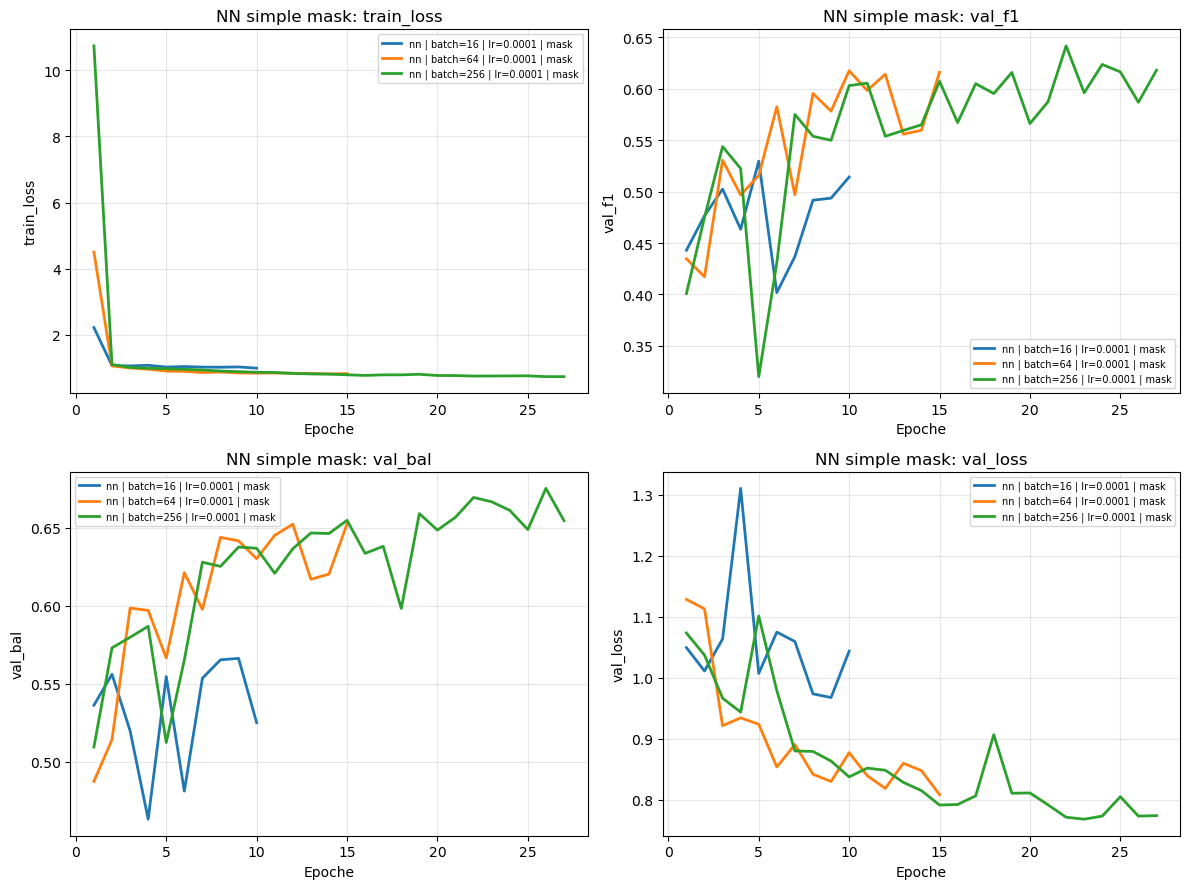


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=16 | lr=0.0001 | mask (AUC=0.804)
nn | batch=64 | lr=0.0001 | mask (AUC=0.861)
nn | batch=256 | lr=0.0001 | mask (AUC=0.859)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=16 | lr=0.0001 | mask (AUC=0.618)
nn | batch=64 | lr=0.0001 | mask (AUC=0.702)
nn | batch=256 | lr=0.0001 | mask (AUC=0.755)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=16 | lr=0.0001 | mask (AUC=0.778)
nn | batch=64 | lr=0.0001 | mask (AUC=0.814)
nn | batch=256 | lr=0.0001 | mask (AUC=0.816)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
nn | batch=16 | lr=0.0001 | mask (AUC=0.944)
nn | batch=64 | lr=0.0001 | mask (AUC=0.977)
nn | batch=256 | lr=0.0001 | mask (AUC=0.984)


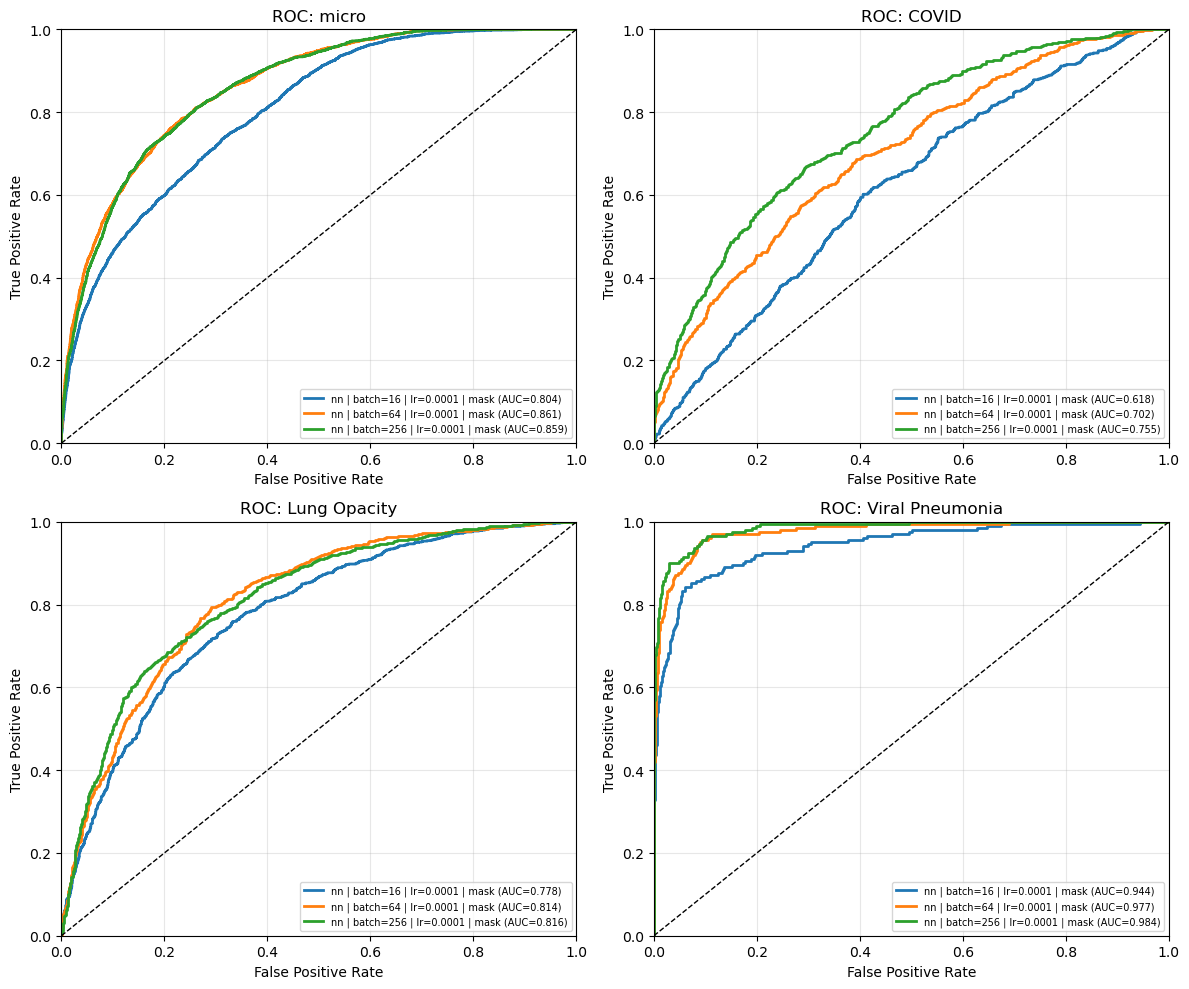

In [126]:
plot_train_overlays_grid(
    train_dirs_nns_mask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN simple mask"
)
plot_test_roc_overlays_grid(
    test_dirs_nns_mask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [127]:
train_dirs_nns_mask = []
test_dirs_nns_mask  = []
for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=40,
        model_kind="nn_simple"
    )
    train_dirs_nns_mask += t
    test_dirs_nns_mask  += tt



=== SWEEP RUN: model=nn_simple | mode=mask | batch=64 | lr=0.0001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=64 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3033 | val_loss=1.0387 | val_f1=0.467 | val_bal=0.519 | 44.42s


Epoche 02: train_loss=1.0344 | val_loss=0.9724 | val_f1=0.528 | val_bal=0.585 | 43.70s


Epoche 03: train_loss=0.9943 | val_loss=0.9325 | val_f1=0.534 | val_bal=0.595 | 43.61s


Epoche 04: train_loss=0.9832 | val_loss=0.9616 | val_f1=0.478 | val_bal=0.575 | 44.39s


Epoche 05: train_loss=0.9506 | val_loss=0.9531 | val_f1=0.423 | val_bal=0.560 | 43.78s


Epoche 06: train_loss=0.9119 | val_loss=0.8589 | val_f1=0.585 | val_bal=0.628 | 44.02s


Epoche 07: train_loss=0.8745 | val_loss=0.8527 | val_f1=0.573 | val_bal=0.621 | 44.10s


Epoche 08: train_loss=0.8596 | val_loss=0.8942 | val_f1=0.526 | val_bal=0.606 | 44.05s


Epoche 09: train_loss=0.8292 | val_loss=0.8233 | val_f1=0.562 | val_bal=0.642 | 43.92s


Epoche 10: train_loss=0.8010 | val_loss=0.8227 | val_f1=0.646 | val_bal=0.655 | 44.00s


Epoche 11: train_loss=0.8106 | val_loss=0.7831 | val_f1=0.592 | val_bal=0.662 | 44.02s


Epoche 12: train_loss=0.7865 | val_loss=0.7815 | val_f1=0.632 | val_bal=0.650 | 43.79s


Epoche 13: train_loss=0.7734 | val_loss=0.7586 | val_f1=0.648 | val_bal=0.676 | 43.96s


Epoche 14: train_loss=0.7661 | val_loss=0.7740 | val_f1=0.652 | val_bal=0.660 | 44.93s


Epoche 15: train_loss=0.7557 | val_loss=0.7851 | val_f1=0.658 | val_bal=0.656 | 45.15s


Epoche 16: train_loss=0.7556 | val_loss=0.7716 | val_f1=0.609 | val_bal=0.668 | 44.98s


Epoche 17: train_loss=0.7542 | val_loss=0.7458 | val_f1=0.613 | val_bal=0.673 | 43.89s


Epoche 18: train_loss=0.7495 | val_loss=0.7697 | val_f1=0.623 | val_bal=0.661 | 44.33s


Epoche 19: train_loss=0.7337 | val_loss=0.7441 | val_f1=0.648 | val_bal=0.676 | 43.30s


Epoche 20: train_loss=0.7229 | val_loss=0.7498 | val_f1=0.604 | val_bal=0.679 | 44.40s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_30_2330_batch-64_lr-00001
[TEST-START] Model=nn_simple | Modus=mask | Batch=64
Pfad=nn_mask_2025_08_30_2330_batch-64_lr-00001.pt


[test] F1(macro)=0.643 | BalAcc=0.643 | Zeit=8.40s | /home/lupan001/ML/results/nn_mask_2025_08_30_2330_batch-64_lr-00001_test
[SWEEP] Modell=nn_mask_2025_08_30_2330_batch-64_lr-00001 | F1=0.643 | BalAcc=0.643

=== SWEEP RUN: model=nn_simple | mode=mask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=3.1388 | val_loss=2.7024 | val_f1=0.189 | val_bal=0.291 | 44.56s


Epoche 02: train_loss=1.2782 | val_loss=1.0683 | val_f1=0.383 | val_bal=0.510 | 43.10s


Epoche 03: train_loss=1.0604 | val_loss=0.9590 | val_f1=0.531 | val_bal=0.588 | 43.41s


Epoche 04: train_loss=0.9940 | val_loss=0.9655 | val_f1=0.478 | val_bal=0.556 | 44.39s


Epoche 05: train_loss=0.9683 | val_loss=0.9451 | val_f1=0.480 | val_bal=0.564 | 43.73s


Epoche 06: train_loss=0.9277 | val_loss=1.1009 | val_f1=0.583 | val_bal=0.558 | 44.03s


Epoche 07: train_loss=0.9092 | val_loss=0.8701 | val_f1=0.561 | val_bal=0.628 | 44.26s


Epoche 08: train_loss=0.8852 | val_loss=0.8598 | val_f1=0.603 | val_bal=0.637 | 43.57s


Epoche 09: train_loss=0.8779 | val_loss=0.8559 | val_f1=0.582 | val_bal=0.635 | 43.54s


Epoche 10: train_loss=0.8768 | val_loss=0.8572 | val_f1=0.615 | val_bal=0.636 | 43.63s


Epoche 11: train_loss=0.8674 | val_loss=0.8625 | val_f1=0.559 | val_bal=0.635 | 43.98s


Epoche 12: train_loss=0.8571 | val_loss=0.8622 | val_f1=0.576 | val_bal=0.615 | 43.61s


Epoche 13: train_loss=0.8645 | val_loss=0.8315 | val_f1=0.607 | val_bal=0.637 | 43.84s


Epoche 14: train_loss=0.8616 | val_loss=0.8660 | val_f1=0.551 | val_bal=0.635 | 43.50s


Epoche 15: train_loss=0.8431 | val_loss=0.9471 | val_f1=0.415 | val_bal=0.546 | 43.99s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_30_2345_batch-64_lr-0001
[TEST-START] Model=nn_simple | Modus=mask | Batch=64
Pfad=nn_mask_2025_08_30_2345_batch-64_lr-0001.pt


[test] F1(macro)=0.598 | BalAcc=0.622 | Zeit=7.79s | /home/lupan001/ML/results/nn_mask_2025_08_30_2345_batch-64_lr-0001_test
[SWEEP] Modell=nn_mask_2025_08_30_2345_batch-64_lr-0001 | F1=0.598 | BalAcc=0.622

=== SWEEP RUN: model=nn_simple | mode=mask | batch=64 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.2264 @idx=62 → vorgeschlagene LR=3.526e-05
[lr-finder] gewählte Start-LR: 3.526e-05

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=64 | LR=3.525828236191912e-05 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1563 | val_loss=1.0441 | val_f1=0.536 | val_bal=0.540 | 44.12s


Epoche 02: train_loss=1.0280 | val_loss=0.9657 | val_f1=0.532 | val_bal=0.580 | 43.47s


Epoche 03: train_loss=1.0086 | val_loss=0.9659 | val_f1=0.501 | val_bal=0.589 | 43.78s


Epoche 04: train_loss=0.9762 | val_loss=1.0049 | val_f1=0.443 | val_bal=0.547 | 44.21s


Epoche 05: train_loss=0.9492 | val_loss=0.9401 | val_f1=0.497 | val_bal=0.605 | 44.01s


Epoche 06: train_loss=0.9230 | val_loss=0.9322 | val_f1=0.457 | val_bal=0.581 | 44.46s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_30_2357_batch-64_lr-3525828236191912e-05
[TEST-START] Model=nn_simple | Modus=mask | Batch=64
Pfad=nn_mask_2025_08_30_2357_batch-64_lr-3525828236191912e-05.pt


[test] F1(macro)=0.544 | BalAcc=0.551 | Zeit=7.92s | /home/lupan001/ML/results/nn_mask_2025_08_30_2357_batch-64_lr-3525828236191912e-05_test
[SWEEP] Modell=nn_mask_2025_08_30_2357_batch-64_lr-3525828236191912e-05 | F1=0.544 | BalAcc=0.551

=== SWEEP RUN: model=nn_simple | mode=mask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=128 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3708 | val_loss=1.0017 | val_f1=0.450 | val_bal=0.547 | 44.97s


Epoche 02: train_loss=1.0476 | val_loss=0.9654 | val_f1=0.485 | val_bal=0.578 | 44.27s


Epoche 03: train_loss=1.0146 | val_loss=0.9408 | val_f1=0.518 | val_bal=0.600 | 43.88s


Epoche 04: train_loss=1.0082 | val_loss=0.9687 | val_f1=0.493 | val_bal=0.555 | 44.57s


Epoche 05: train_loss=0.9684 | val_loss=0.9432 | val_f1=0.488 | val_bal=0.595 | 44.67s


Epoche 06: train_loss=0.9391 | val_loss=0.9132 | val_f1=0.500 | val_bal=0.584 | 44.51s


Epoche 07: train_loss=0.9213 | val_loss=0.9370 | val_f1=0.532 | val_bal=0.611 | 44.43s


Epoche 08: train_loss=0.8803 | val_loss=0.8619 | val_f1=0.563 | val_bal=0.630 | 44.35s


Epoche 09: train_loss=0.8655 | val_loss=0.8658 | val_f1=0.554 | val_bal=0.625 | 44.16s


Epoche 10: train_loss=0.8599 | val_loss=0.8674 | val_f1=0.541 | val_bal=0.637 | 43.88s


Epoche 11: train_loss=0.8327 | val_loss=0.8187 | val_f1=0.601 | val_bal=0.642 | 43.81s


Epoche 12: train_loss=0.8216 | val_loss=0.8118 | val_f1=0.622 | val_bal=0.646 | 46.00s


Epoche 13: train_loss=0.8063 | val_loss=0.8081 | val_f1=0.575 | val_bal=0.644 | 44.16s


Epoche 14: train_loss=0.7989 | val_loss=0.8511 | val_f1=0.545 | val_bal=0.624 | 43.67s


Epoche 15: train_loss=0.7951 | val_loss=0.7661 | val_f1=0.625 | val_bal=0.672 | 44.34s


Epoche 16: train_loss=0.7958 | val_loss=0.8442 | val_f1=0.575 | val_bal=0.622 | 44.60s


Epoche 17: train_loss=0.7882 | val_loss=0.7816 | val_f1=0.596 | val_bal=0.657 | 44.43s


Epoche 18: train_loss=0.7692 | val_loss=0.8146 | val_f1=0.594 | val_bal=0.638 | 44.89s


Epoche 19: train_loss=0.7556 | val_loss=0.7936 | val_f1=0.561 | val_bal=0.644 | 44.54s


Epoche 20: train_loss=0.7546 | val_loss=0.7539 | val_f1=0.614 | val_bal=0.673 | 43.34s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_31_0002_batch-128_lr-00001
[TEST-START] Model=nn_simple | Modus=mask | Batch=128
Pfad=nn_mask_2025_08_31_0002_batch-128_lr-00001.pt


[test] F1(macro)=0.615 | BalAcc=0.659 | Zeit=7.98s | /home/lupan001/ML/results/nn_mask_2025_08_31_0002_batch-128_lr-00001_test
[SWEEP] Modell=nn_mask_2025_08_31_0002_batch-128_lr-00001 | F1=0.615 | BalAcc=0.659

=== SWEEP RUN: model=nn_simple | mode=mask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=128 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=5.4334 | val_loss=1.2517 | val_f1=0.397 | val_bal=0.533 | 45.09s


Epoche 02: train_loss=1.1433 | val_loss=0.9845 | val_f1=0.480 | val_bal=0.588 | 44.95s


Epoche 03: train_loss=1.2630 | val_loss=1.1033 | val_f1=0.417 | val_bal=0.512 | 44.82s


Epoche 04: train_loss=1.0100 | val_loss=1.0493 | val_f1=0.550 | val_bal=0.563 | 45.34s


Epoche 05: train_loss=0.9751 | val_loss=0.9163 | val_f1=0.558 | val_bal=0.597 | 44.26s


Epoche 06: train_loss=0.9637 | val_loss=0.9393 | val_f1=0.498 | val_bal=0.587 | 44.48s


Epoche 07: train_loss=0.9014 | val_loss=0.8413 | val_f1=0.599 | val_bal=0.636 | 44.02s


Epoche 08: train_loss=0.8929 | val_loss=0.8904 | val_f1=0.590 | val_bal=0.619 | 43.93s


Epoche 09: train_loss=0.8719 | val_loss=0.9272 | val_f1=0.606 | val_bal=0.605 | 44.38s


Epoche 10: train_loss=0.8368 | val_loss=0.8461 | val_f1=0.547 | val_bal=0.635 | 44.41s


Epoche 11: train_loss=0.8285 | val_loss=0.8137 | val_f1=0.603 | val_bal=0.637 | 43.83s


Epoche 12: train_loss=0.8109 | val_loss=0.8016 | val_f1=0.612 | val_bal=0.647 | 43.99s


Epoche 13: train_loss=0.8140 | val_loss=0.7643 | val_f1=0.639 | val_bal=0.668 | 43.86s


Epoche 14: train_loss=0.8139 | val_loss=0.8291 | val_f1=0.587 | val_bal=0.640 | 43.53s


Epoche 15: train_loss=0.8014 | val_loss=0.8655 | val_f1=0.545 | val_bal=0.624 | 44.08s


Epoche 16: train_loss=0.7852 | val_loss=0.8254 | val_f1=0.598 | val_bal=0.630 | 44.00s


Epoche 17: train_loss=0.7823 | val_loss=0.7678 | val_f1=0.631 | val_bal=0.665 | 43.48s


Epoche 18: train_loss=0.7907 | val_loss=0.7363 | val_f1=0.656 | val_bal=0.689 | 44.64s


Epoche 19: train_loss=0.7584 | val_loss=0.7841 | val_f1=0.613 | val_bal=0.656 | 44.01s


Epoche 20: train_loss=0.7645 | val_loss=0.7679 | val_f1=0.628 | val_bal=0.672 | 44.52s


Epoche 21: train_loss=0.7765 | val_loss=0.7955 | val_f1=0.585 | val_bal=0.679 | 44.18s


Epoche 22: train_loss=0.7635 | val_loss=0.7562 | val_f1=0.618 | val_bal=0.671 | 44.17s


Epoche 23: train_loss=0.7698 | val_loss=0.8084 | val_f1=0.605 | val_bal=0.645 | 43.98s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_31_0017_batch-128_lr-0001
[TEST-START] Model=nn_simple | Modus=mask | Batch=128
Pfad=nn_mask_2025_08_31_0017_batch-128_lr-0001.pt


[test] F1(macro)=0.631 | BalAcc=0.663 | Zeit=8.23s | /home/lupan001/ML/results/nn_mask_2025_08_31_0017_batch-128_lr-0001_test
[SWEEP] Modell=nn_mask_2025_08_31_0017_batch-128_lr-0001 | F1=0.631 | BalAcc=0.663

=== SWEEP RUN: model=nn_simple | mode=mask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1974 @idx=62 → vorgeschlagene LR=3.526e-05
[lr-finder] gewählte Start-LR: 3.526e-05

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=128 | LR=3.525828236191912e-05 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2320 | val_loss=1.0508 | val_f1=0.455 | val_bal=0.550 | 46.20s


Epoche 02: train_loss=1.0335 | val_loss=0.9808 | val_f1=0.501 | val_bal=0.582 | 44.41s


Epoche 03: train_loss=0.9863 | val_loss=0.9488 | val_f1=0.521 | val_bal=0.587 | 43.38s


Epoche 04: train_loss=0.9803 | val_loss=1.0324 | val_f1=0.370 | val_bal=0.534 | 44.78s


Epoche 05: train_loss=0.9548 | val_loss=0.9426 | val_f1=0.500 | val_bal=0.582 | 44.23s


Epoche 06: train_loss=0.9230 | val_loss=0.8972 | val_f1=0.585 | val_bal=0.613 | 43.45s


Epoche 07: train_loss=0.8948 | val_loss=0.9212 | val_f1=0.539 | val_bal=0.596 | 45.29s


Epoche 08: train_loss=0.8827 | val_loss=0.8424 | val_f1=0.582 | val_bal=0.641 | 44.79s


Epoche 09: train_loss=0.8584 | val_loss=0.8335 | val_f1=0.584 | val_bal=0.636 | 45.25s


Epoche 10: train_loss=0.8568 | val_loss=0.8208 | val_f1=0.600 | val_bal=0.658 | 44.35s


Epoche 11: train_loss=0.8240 | val_loss=0.8126 | val_f1=0.594 | val_bal=0.651 | 44.23s


Epoche 12: train_loss=0.8182 | val_loss=0.8057 | val_f1=0.620 | val_bal=0.661 | 44.64s


Epoche 13: train_loss=0.8013 | val_loss=0.8282 | val_f1=0.556 | val_bal=0.627 | 44.51s


Epoche 14: train_loss=0.7983 | val_loss=0.8450 | val_f1=0.657 | val_bal=0.653 | 44.20s


Epoche 15: train_loss=0.7866 | val_loss=0.7690 | val_f1=0.627 | val_bal=0.675 | 44.81s


Epoche 16: train_loss=0.7712 | val_loss=0.7743 | val_f1=0.592 | val_bal=0.666 | 45.21s


Epoche 17: train_loss=0.7697 | val_loss=0.7680 | val_f1=0.631 | val_bal=0.675 | 44.47s


Epoche 18: train_loss=0.7522 | val_loss=0.7594 | val_f1=0.607 | val_bal=0.672 | 45.34s


Epoche 19: train_loss=0.7563 | val_loss=0.7854 | val_f1=0.596 | val_bal=0.654 | 45.06s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_31_0034_batch-128_lr-3525828236191912e-05
[TEST-START] Model=nn_simple | Modus=mask | Batch=128
Pfad=nn_mask_2025_08_31_0034_batch-128_lr-3525828236191912e-05.pt


[test] F1(macro)=0.641 | BalAcc=0.637 | Zeit=8.52s | /home/lupan001/ML/results/nn_mask_2025_08_31_0034_batch-128_lr-3525828236191912e-05_test
[SWEEP] Modell=nn_mask_2025_08_31_0034_batch-128_lr-3525828236191912e-05 | F1=0.641 | BalAcc=0.637

=== SWEEP RUN: model=nn_simple | mode=mask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=256 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.6912 | val_loss=1.0890 | val_f1=0.486 | val_bal=0.551 | 45.02s


Epoche 02: train_loss=1.0730 | val_loss=1.0401 | val_f1=0.432 | val_bal=0.559 | 46.80s


Epoche 03: train_loss=1.0172 | val_loss=0.9728 | val_f1=0.516 | val_bal=0.580 | 43.87s


Epoche 04: train_loss=1.0006 | val_loss=1.0246 | val_f1=0.540 | val_bal=0.559 | 44.77s


Epoche 05: train_loss=0.9825 | val_loss=0.9541 | val_f1=0.543 | val_bal=0.577 | 43.96s


Epoche 06: train_loss=0.9744 | val_loss=0.9332 | val_f1=0.535 | val_bal=0.612 | 44.70s


Epoche 07: train_loss=0.9577 | val_loss=0.9847 | val_f1=0.506 | val_bal=0.561 | 44.17s


Epoche 08: train_loss=0.9608 | val_loss=0.9305 | val_f1=0.558 | val_bal=0.589 | 45.86s


Epoche 09: train_loss=0.9554 | val_loss=0.9361 | val_f1=0.522 | val_bal=0.588 | 45.90s


Epoche 10: train_loss=0.9445 | val_loss=0.9626 | val_f1=0.497 | val_bal=0.592 | 45.27s


Epoche 11: train_loss=0.9190 | val_loss=0.8935 | val_f1=0.528 | val_bal=0.621 | 44.69s


Epoche 12: train_loss=0.9024 | val_loss=0.8838 | val_f1=0.554 | val_bal=0.625 | 44.17s


Epoche 13: train_loss=0.8946 | val_loss=0.8635 | val_f1=0.565 | val_bal=0.640 | 45.12s


Epoche 14: train_loss=0.8806 | val_loss=0.8557 | val_f1=0.564 | val_bal=0.632 | 43.90s


Epoche 15: train_loss=0.8742 | val_loss=0.8923 | val_f1=0.543 | val_bal=0.598 | 44.44s


Epoche 16: train_loss=0.8630 | val_loss=0.8726 | val_f1=0.534 | val_bal=0.621 | 45.44s


Epoche 17: train_loss=0.8596 | val_loss=0.8605 | val_f1=0.576 | val_bal=0.636 | 45.21s


Epoche 18: train_loss=0.8482 | val_loss=0.8498 | val_f1=0.532 | val_bal=0.627 | 44.92s


Epoche 19: train_loss=0.8324 | val_loss=0.8882 | val_f1=0.613 | val_bal=0.611 | 43.99s


Epoche 20: train_loss=0.8266 | val_loss=0.8155 | val_f1=0.591 | val_bal=0.652 | 43.94s


Epoche 21: train_loss=0.8132 | val_loss=0.8137 | val_f1=0.578 | val_bal=0.657 | 46.28s


Epoche 22: train_loss=0.8156 | val_loss=0.7873 | val_f1=0.625 | val_bal=0.670 | 45.41s


Epoche 23: train_loss=0.8055 | val_loss=0.8351 | val_f1=0.547 | val_bal=0.649 | 44.25s


Epoche 24: train_loss=0.7971 | val_loss=0.8022 | val_f1=0.582 | val_bal=0.643 | 44.14s


Epoche 25: train_loss=0.7821 | val_loss=0.7934 | val_f1=0.606 | val_bal=0.661 | 44.29s


Epoche 26: train_loss=0.7840 | val_loss=0.7711 | val_f1=0.632 | val_bal=0.672 | 44.75s


Epoche 27: train_loss=0.7853 | val_loss=0.8450 | val_f1=0.504 | val_bal=0.606 | 44.57s


Epoche 28: train_loss=0.7654 | val_loss=0.8143 | val_f1=0.569 | val_bal=0.639 | 45.95s


Epoche 29: train_loss=0.7628 | val_loss=0.7661 | val_f1=0.635 | val_bal=0.675 | 45.05s


Epoche 30: train_loss=0.7555 | val_loss=0.7667 | val_f1=0.647 | val_bal=0.680 | 45.30s


Epoche 31: train_loss=0.7510 | val_loss=0.7879 | val_f1=0.599 | val_bal=0.664 | 47.35s


Epoche 32: train_loss=0.7733 | val_loss=0.7837 | val_f1=0.611 | val_bal=0.654 | 46.83s


Epoche 33: train_loss=0.7424 | val_loss=0.7673 | val_f1=0.610 | val_bal=0.667 | 45.35s


Epoche 34: train_loss=0.7413 | val_loss=0.7589 | val_f1=0.634 | val_bal=0.668 | 46.33s


Epoche 35: train_loss=0.7339 | val_loss=0.8226 | val_f1=0.654 | val_bal=0.648 | 46.30s


Epoche 36: train_loss=0.7345 | val_loss=0.7569 | val_f1=0.627 | val_bal=0.671 | 46.00s


Epoche 37: train_loss=0.7346 | val_loss=0.7365 | val_f1=0.633 | val_bal=0.686 | 45.38s


Epoche 38: train_loss=0.7189 | val_loss=0.7653 | val_f1=0.661 | val_bal=0.676 | 44.86s


Epoche 39: train_loss=0.7320 | val_loss=0.7651 | val_f1=0.608 | val_bal=0.674 | 45.57s


Epoche 40: train_loss=0.7186 | val_loss=0.7338 | val_f1=0.628 | val_bal=0.688 | 45.07s
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_31_0049_batch-256_lr-00001
[TEST-START] Model=nn_simple | Modus=mask | Batch=256
Pfad=nn_mask_2025_08_31_0049_batch-256_lr-00001.pt


[test] F1(macro)=0.652 | BalAcc=0.665 | Zeit=8.23s | /home/lupan001/ML/results/nn_mask_2025_08_31_0049_batch-256_lr-00001_test
[SWEEP] Modell=nn_mask_2025_08_31_0049_batch-256_lr-00001 | F1=0.652 | BalAcc=0.665

=== SWEEP RUN: model=nn_simple | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=8.3245 | val_loss=1.1351 | val_f1=0.425 | val_bal=0.487 | 47.05s


Epoche 02: train_loss=1.0369 | val_loss=0.9961 | val_f1=0.478 | val_bal=0.575 | 46.36s


Epoche 03: train_loss=1.0263 | val_loss=0.9892 | val_f1=0.473 | val_bal=0.586 | 45.18s


Epoche 04: train_loss=0.9972 | val_loss=0.9479 | val_f1=0.494 | val_bal=0.559 | 44.73s


Epoche 05: train_loss=1.0490 | val_loss=0.9567 | val_f1=0.544 | val_bal=0.579 | 44.86s


Epoche 06: train_loss=0.9566 | val_loss=0.9962 | val_f1=0.482 | val_bal=0.579 | 45.47s


Epoche 07: train_loss=0.9258 | val_loss=0.8929 | val_f1=0.566 | val_bal=0.615 | 46.12s


Epoche 08: train_loss=0.9101 | val_loss=0.8700 | val_f1=0.577 | val_bal=0.622 | 45.55s


Epoche 09: train_loss=0.8960 | val_loss=0.8470 | val_f1=0.580 | val_bal=0.620 | 45.72s


Epoche 10: train_loss=0.8802 | val_loss=0.8240 | val_f1=0.572 | val_bal=0.646 | 45.84s


Epoche 11: train_loss=0.8405 | val_loss=0.8091 | val_f1=0.620 | val_bal=0.649 | 46.36s


Epoche 12: train_loss=0.8545 | val_loss=0.9061 | val_f1=0.465 | val_bal=0.587 | 47.13s


Epoche 13: train_loss=0.8226 | val_loss=0.8395 | val_f1=0.568 | val_bal=0.646 | 45.18s


Epoche 14: train_loss=0.8024 | val_loss=0.8149 | val_f1=0.590 | val_bal=0.639 | 46.26s


Epoche 15: train_loss=0.8171 | val_loss=0.7851 | val_f1=0.595 | val_bal=0.669 | 45.15s


Epoche 16: train_loss=0.7970 | val_loss=0.8489 | val_f1=0.641 | val_bal=0.648 | 44.99s


Epoche 17: train_loss=0.8078 | val_loss=0.7904 | val_f1=0.590 | val_bal=0.639 | 45.01s


Epoche 18: train_loss=0.7739 | val_loss=0.7771 | val_f1=0.620 | val_bal=0.660 | 46.82s


Epoche 19: train_loss=0.7939 | val_loss=0.9088 | val_f1=0.488 | val_bal=0.606 | 45.45s


Epoche 20: train_loss=0.7694 | val_loss=0.7623 | val_f1=0.628 | val_bal=0.673 | 45.53s


Epoche 21: train_loss=0.7680 | val_loss=0.8166 | val_f1=0.556 | val_bal=0.640 | 44.85s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_31_0120_batch-256_lr-0001
[TEST-START] Model=nn_simple | Modus=mask | Batch=256
Pfad=nn_mask_2025_08_31_0120_batch-256_lr-0001.pt


[test] F1(macro)=0.628 | BalAcc=0.637 | Zeit=8.33s | /home/lupan001/ML/results/nn_mask_2025_08_31_0120_batch-256_lr-0001_test
[SWEEP] Modell=nn_mask_2025_08_31_0120_batch-256_lr-0001 | F1=0.628 | BalAcc=0.637

=== SWEEP RUN: model=nn_simple | mode=mask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1339 @idx=48 → vorgeschlagene LR=1.844e-05
[lr-finder] gewählte Start-LR: 1.844e-05

[TRAIN-START] Model=nn_simple | Modus=mask | Batch=256 | LR=1.8443957646668724e-05 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2520 | val_loss=1.0992 | val_f1=0.390 | val_bal=0.503 | 46.68s


Epoche 02: train_loss=1.0641 | val_loss=1.0177 | val_f1=0.493 | val_bal=0.573 | 43.44s


Epoche 03: train_loss=1.0176 | val_loss=0.9890 | val_f1=0.515 | val_bal=0.575 | 44.30s


Epoche 04: train_loss=0.9944 | val_loss=0.9638 | val_f1=0.520 | val_bal=0.589 | 44.65s


Epoche 05: train_loss=0.9847 | val_loss=0.9874 | val_f1=0.485 | val_bal=0.560 | 44.98s


Epoche 06: train_loss=0.9693 | val_loss=0.9390 | val_f1=0.513 | val_bal=0.585 | 44.45s


Epoche 07: train_loss=0.9616 | val_loss=0.9902 | val_f1=0.525 | val_bal=0.572 | 44.15s


Epoche 08: train_loss=0.9654 | val_loss=0.9267 | val_f1=0.528 | val_bal=0.612 | 44.67s


Epoche 09: train_loss=0.9282 | val_loss=0.9174 | val_f1=0.539 | val_bal=0.602 | 45.14s


Epoche 10: train_loss=0.9278 | val_loss=0.9111 | val_f1=0.532 | val_bal=0.617 | 44.89s


Epoche 11: train_loss=0.9171 | val_loss=0.9022 | val_f1=0.552 | val_bal=0.619 | 43.83s


Epoche 12: train_loss=0.9078 | val_loss=0.8981 | val_f1=0.532 | val_bal=0.622 | 44.46s


Epoche 13: train_loss=0.9011 | val_loss=0.8941 | val_f1=0.538 | val_bal=0.618 | 43.55s


Epoche 14: train_loss=0.8901 | val_loss=0.8742 | val_f1=0.556 | val_bal=0.629 | 43.83s


Epoche 15: train_loss=0.8753 | val_loss=0.8612 | val_f1=0.587 | val_bal=0.644 | 46.18s


Epoche 16: train_loss=0.8680 | val_loss=0.8672 | val_f1=0.569 | val_bal=0.631 | 45.45s


Epoche 17: train_loss=0.8644 | val_loss=0.8816 | val_f1=0.530 | val_bal=0.629 | 43.87s


Epoche 18: train_loss=0.8593 | val_loss=0.8459 | val_f1=0.605 | val_bal=0.653 | 45.17s


Epoche 19: train_loss=0.8422 | val_loss=0.8381 | val_f1=0.590 | val_bal=0.652 | 45.49s


Epoche 20: train_loss=0.8294 | val_loss=0.8437 | val_f1=0.610 | val_bal=0.639 | 44.22s


Epoche 21: train_loss=0.8304 | val_loss=0.8174 | val_f1=0.602 | val_bal=0.658 | 44.30s


Epoche 22: train_loss=0.8230 | val_loss=0.8349 | val_f1=0.562 | val_bal=0.645 | 44.19s


Epoche 23: train_loss=0.8164 | val_loss=0.8301 | val_f1=0.560 | val_bal=0.643 | 45.29s


Epoche 24: train_loss=0.8142 | val_loss=0.8195 | val_f1=0.617 | val_bal=0.657 | 45.86s


Epoche 25: train_loss=0.8038 | val_loss=0.8086 | val_f1=0.576 | val_bal=0.649 | 44.72s


Epoche 26: train_loss=0.7925 | val_loss=0.8040 | val_f1=0.631 | val_bal=0.663 | 44.58s


Epoche 27: train_loss=0.7959 | val_loss=0.8047 | val_f1=0.611 | val_bal=0.656 | 44.45s


Epoche 28: train_loss=0.7787 | val_loss=0.7821 | val_f1=0.615 | val_bal=0.666 | 44.17s


Epoche 29: train_loss=0.7821 | val_loss=0.7868 | val_f1=0.627 | val_bal=0.664 | 44.56s


Epoche 30: train_loss=0.7825 | val_loss=0.7954 | val_f1=0.637 | val_bal=0.663 | 44.37s


Epoche 31: train_loss=0.7700 | val_loss=0.7814 | val_f1=0.614 | val_bal=0.663 | 45.02s


Epoche 32: train_loss=0.7625 | val_loss=0.7893 | val_f1=0.656 | val_bal=0.672 | 43.74s


Epoche 33: train_loss=0.7602 | val_loss=0.7804 | val_f1=0.634 | val_bal=0.671 | 45.75s


Epoche 34: train_loss=0.7573 | val_loss=0.7850 | val_f1=0.604 | val_bal=0.671 | 44.72s


Epoche 35: train_loss=0.7547 | val_loss=0.7584 | val_f1=0.627 | val_bal=0.678 | 43.47s


Epoche 36: train_loss=0.7513 | val_loss=0.7584 | val_f1=0.647 | val_bal=0.688 | 44.33s


Epoche 37: train_loss=0.7422 | val_loss=0.7705 | val_f1=0.625 | val_bal=0.668 | 44.17s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mask_2025_08_31_0136_batch-256_lr-18443957646668724e-05
[TEST-START] Model=nn_simple | Modus=mask | Batch=256
Pfad=nn_mask_2025_08_31_0136_batch-256_lr-18443957646668724e-05.pt


[test] F1(macro)=0.633 | BalAcc=0.652 | Zeit=8.22s | /home/lupan001/ML/results/nn_mask_2025_08_31_0136_batch-256_lr-18443957646668724e-05_test
[SWEEP] Modell=nn_mask_2025_08_31_0136_batch-256_lr-18443957646668724e-05 | F1=0.633 | BalAcc=0.652



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=128 | lr=0.0001 | mask | train_loss max=5.4334
nn | batch=128 | lr=1e-05 | mask | train_loss max=1.3708
nn | batch=128 | lr=3.526e+10 | mask | train_loss max=1.2320
nn | batch=256 | lr=0.0001 | mask | train_loss max=8.3245
nn | batch=256 | lr=1.844e+11 | mask | train_loss max=1.2520
nn | batch=256 | lr=1e-05 | mask | train_loss max=1.6912
nn | batch=64 | lr=0.0001 | mask | train_loss max=3.1388
nn | batch=64 | lr=1e-05 | mask | train_loss max=1.3033
nn | batch=64 | lr=3.526e+10 | mask | train_loss max=1.1563

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=128 | lr=0.0001 | mask | val_f1 max=0.6562
nn | batch=128 | lr=1e-05 | mask | val_f1 max=0.6255
nn | batch=128 | lr=3.526e+10 | mask | val_f1 max=0.6574
nn | batch=256 | lr=0.0001 | mask | val_f1 max=0.6406
nn | batch=256 | lr=1.844e+11 | mask | val_f1 max=0.6559
nn | batch=256 | lr=1e-05 | mask | val_f1 max=0.6605
nn | batch=64 | lr=0.0001 | mask | val_f1 max=0.6149
nn | batch

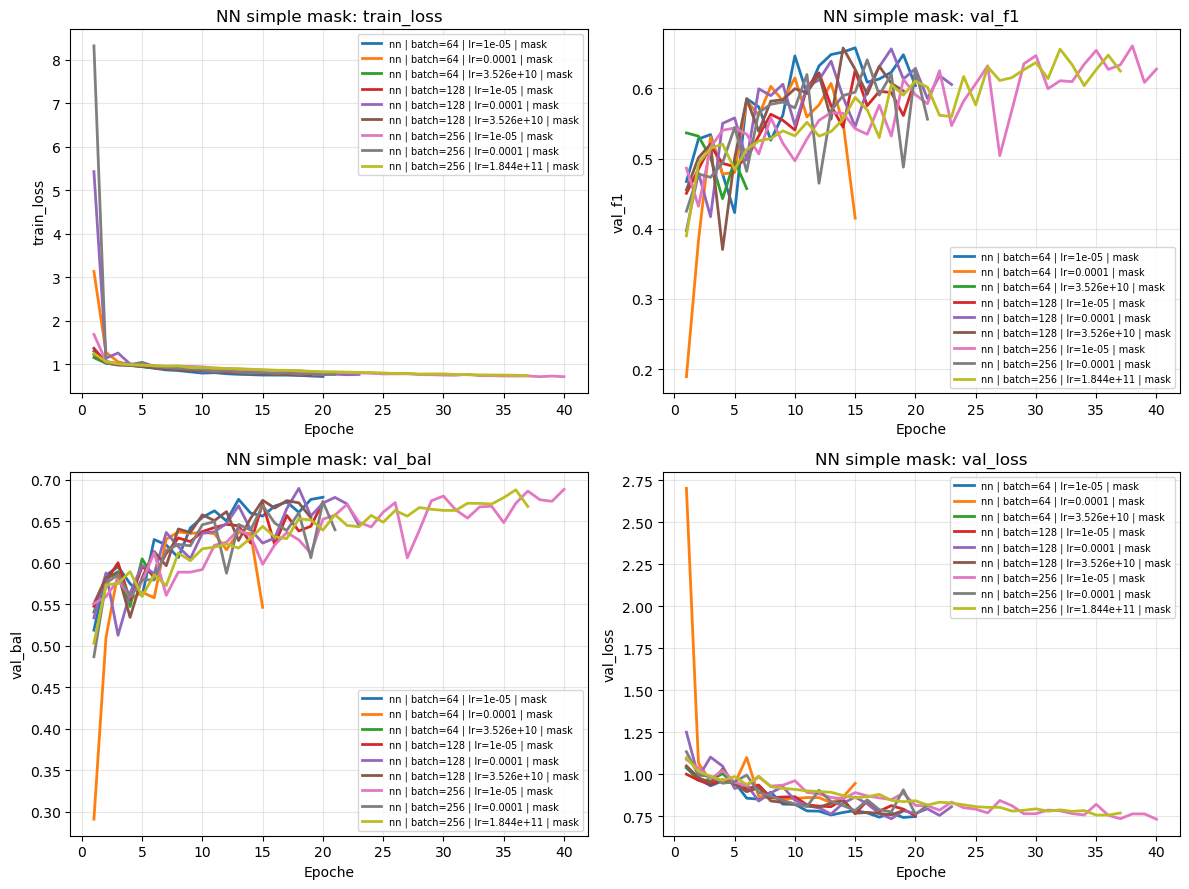


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=64 | lr=1e-05 | mask (AUC=0.894)
nn | batch=64 | lr=0.0001 | mask (AUC=0.871)
nn | batch=64 | lr=3.526e+10 | mask (AUC=0.808)
nn | batch=128 | lr=1e-05 | mask (AUC=0.872)
nn | batch=128 | lr=0.0001 | mask (AUC=0.877)
nn | batch=128 | lr=3.526e+10 | mask (AUC=0.875)
nn | batch=256 | lr=1e-05 | mask (AUC=0.885)
nn | batch=256 | lr=0.0001 | mask (AUC=0.853)
nn | batch=256 | lr=1.844e+11 | mask (AUC=0.881)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=64 | lr=1e-05 | mask (AUC=0.753)
nn | batch=64 | lr=0.0001 | mask (AUC=0.719)
nn | batch=64 | lr=3.526e+10 | mask (AUC=0.670)
nn | batch=128 | lr=1e-05 | mask (AUC=0.745)
nn | batch=128 | lr=0.0001 | mask (AUC=0.740)
nn | batch=128 | lr=3.526e+10 | mask (AUC=0.740)
nn | batch=256 | lr=1e-05 | mask (AUC=0.756)
nn | batch=256 | lr=0.0001 | mask (AUC=0.725)
nn | batch=256 | lr=1.844e+11 | mask (AUC=0.758)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=64 | lr=1e-05 | mask (AUC=0.842)
nn |

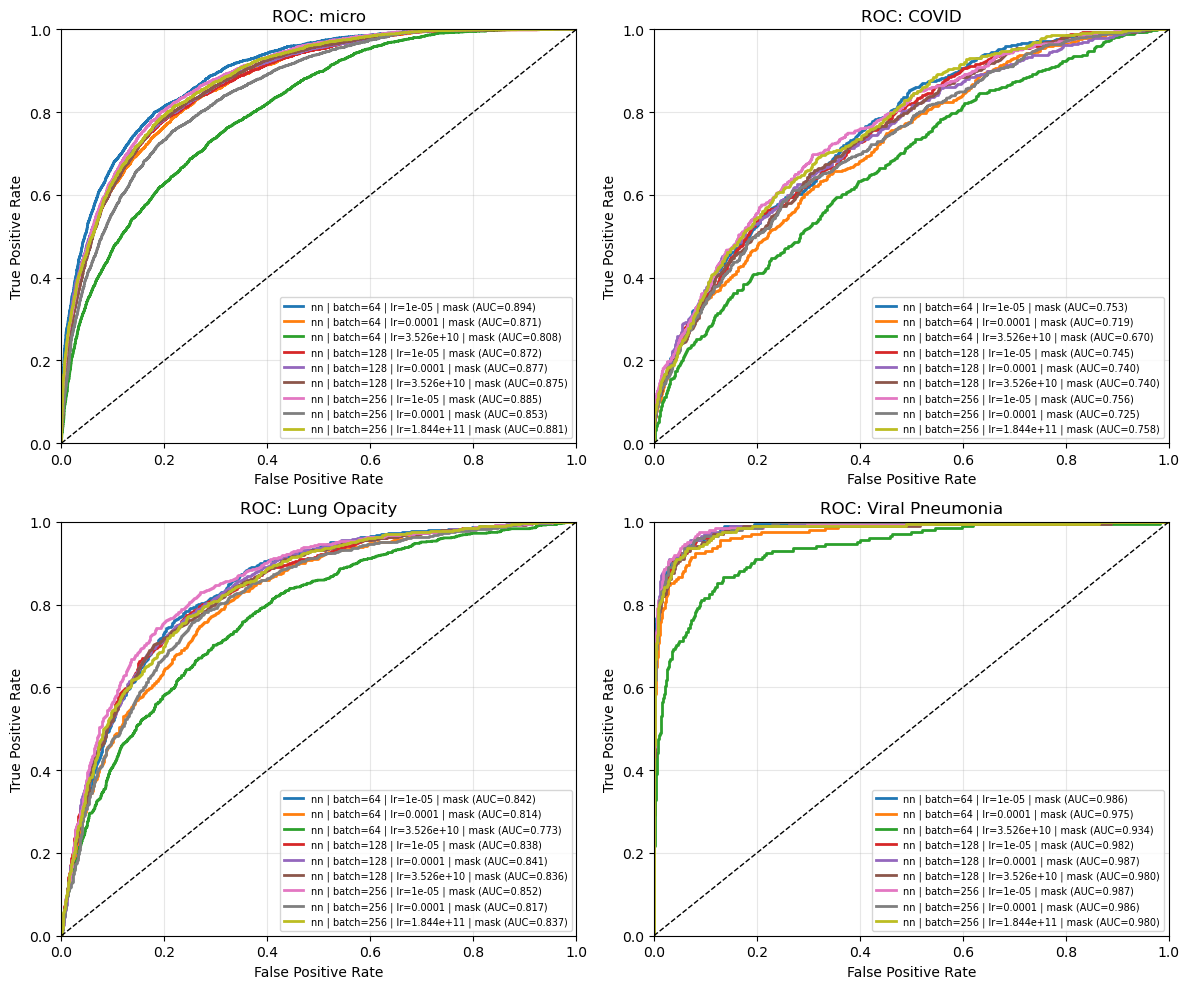

In [130]:
plot_train_overlays_grid(
    train_dirs_nns_mask,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN simple mask"
)
plot_test_roc_overlays_grid(
    test_dirs_nns_mask,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [131]:
train_dirs_nns_nomask_batch, test_dirs_nns_nomask_batch = run_sweep_train_test(
    "nomask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=40,
    model_kind="nn_simple"
)



=== SWEEP RUN: model=nn_simple | mode=nomask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=16 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3747 | val_loss=2.1229 | val_f1=0.660 | val_bal=0.664 | 28.49s


Epoche 02: train_loss=1.1477 | val_loss=1.3127 | val_f1=0.666 | val_bal=0.708 | 27.93s


Epoche 03: train_loss=1.0330 | val_loss=1.2501 | val_f1=0.713 | val_bal=0.717 | 28.05s


Epoche 04: train_loss=0.9470 | val_loss=1.5234 | val_f1=0.735 | val_bal=0.752 | 28.31s


Epoche 05: train_loss=1.1794 | val_loss=1.7252 | val_f1=0.711 | val_bal=0.742 | 28.03s


Epoche 06: train_loss=0.9558 | val_loss=1.7454 | val_f1=0.706 | val_bal=0.739 | 27.80s


Epoche 07: train_loss=1.2563 | val_loss=2.7440 | val_f1=0.716 | val_bal=0.730 | 28.28s


Epoche 08: train_loss=1.1813 | val_loss=1.9026 | val_f1=0.697 | val_bal=0.753 | 28.12s


Epoche 09: train_loss=1.2895 | val_loss=1.7582 | val_f1=0.708 | val_bal=0.746 | 27.81s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0517_batch-16_lr-0001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=16
Pfad=nn_nomask_2025_08_31_0517_batch-16_lr-0001.pt


[test] F1(macro)=0.718 | BalAcc=0.738 | Zeit=5.04s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0517_batch-16_lr-0001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0517_batch-16_lr-0001 | F1=0.718 | BalAcc=0.738

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3601 | val_loss=0.7135 | val_f1=0.677 | val_bal=0.735 | 28.26s


Epoche 02: train_loss=0.6743 | val_loss=0.7987 | val_f1=0.701 | val_bal=0.730 | 28.20s


Epoche 03: train_loss=0.6515 | val_loss=0.7520 | val_f1=0.741 | val_bal=0.773 | 27.86s


Epoche 04: train_loss=0.6568 | val_loss=0.7869 | val_f1=0.680 | val_bal=0.751 | 28.12s


Epoche 05: train_loss=0.5853 | val_loss=0.6055 | val_f1=0.756 | val_bal=0.794 | 27.69s


Epoche 06: train_loss=0.6114 | val_loss=0.8833 | val_f1=0.703 | val_bal=0.740 | 27.96s


Epoche 07: train_loss=0.6177 | val_loss=0.6868 | val_f1=0.737 | val_bal=0.776 | 27.90s


Epoche 08: train_loss=0.5803 | val_loss=0.9633 | val_f1=0.734 | val_bal=0.786 | 27.94s


Epoche 09: train_loss=0.6018 | val_loss=0.8430 | val_f1=0.723 | val_bal=0.770 | 29.76s


Epoche 10: train_loss=0.6020 | val_loss=0.6927 | val_f1=0.765 | val_bal=0.810 | 28.07s


Epoche 11: train_loss=0.5396 | val_loss=0.9159 | val_f1=0.767 | val_bal=0.794 | 28.22s


Epoche 12: train_loss=0.6318 | val_loss=1.0473 | val_f1=0.739 | val_bal=0.783 | 28.07s


Epoche 13: train_loss=0.7275 | val_loss=0.9747 | val_f1=0.727 | val_bal=0.775 | 27.85s


Epoche 14: train_loss=0.7387 | val_loss=0.9773 | val_f1=0.771 | val_bal=0.792 | 27.91s


Epoche 15: train_loss=0.6617 | val_loss=1.0668 | val_f1=0.755 | val_bal=0.778 | 27.85s


Epoche 16: train_loss=0.6115 | val_loss=1.4373 | val_f1=0.783 | val_bal=0.783 | 27.64s


Epoche 17: train_loss=0.5554 | val_loss=1.0096 | val_f1=0.766 | val_bal=0.787 | 28.18s


Epoche 18: train_loss=0.5976 | val_loss=0.8071 | val_f1=0.808 | val_bal=0.802 | 28.22s


Epoche 19: train_loss=0.5584 | val_loss=1.0886 | val_f1=0.783 | val_bal=0.822 | 27.64s


Epoche 20: train_loss=0.5217 | val_loss=1.5184 | val_f1=0.783 | val_bal=0.799 | 28.18s


Epoche 21: train_loss=0.5755 | val_loss=1.1801 | val_f1=0.775 | val_bal=0.789 | 28.38s


Epoche 22: train_loss=0.5578 | val_loss=1.0055 | val_f1=0.746 | val_bal=0.795 | 27.92s


Epoche 23: train_loss=0.4811 | val_loss=0.9734 | val_f1=0.808 | val_bal=0.806 | 27.86s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0522_batch-64_lr-0001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=64
Pfad=nn_nomask_2025_08_31_0522_batch-64_lr-0001.pt


[test] F1(macro)=0.807 | BalAcc=0.811 | Zeit=5.04s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0522_batch-64_lr-0001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0522_batch-64_lr-0001 | F1=0.807 | BalAcc=0.811

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=2.4300 | val_loss=0.8461 | val_f1=0.704 | val_bal=0.709 | 29.10s


Epoche 02: train_loss=0.6718 | val_loss=0.7092 | val_f1=0.732 | val_bal=0.767 | 28.55s


Epoche 03: train_loss=0.6126 | val_loss=0.6653 | val_f1=0.742 | val_bal=0.765 | 28.23s


Epoche 04: train_loss=0.5761 | val_loss=0.6539 | val_f1=0.765 | val_bal=0.782 | 28.19s


Epoche 05: train_loss=0.5310 | val_loss=0.6565 | val_f1=0.763 | val_bal=0.772 | 28.21s


Epoche 06: train_loss=0.5224 | val_loss=0.6537 | val_f1=0.776 | val_bal=0.780 | 28.43s


Epoche 07: train_loss=0.5000 | val_loss=0.6533 | val_f1=0.761 | val_bal=0.796 | 28.16s


Epoche 08: train_loss=0.4802 | val_loss=0.5571 | val_f1=0.800 | val_bal=0.822 | 28.39s


Epoche 09: train_loss=0.4711 | val_loss=0.5401 | val_f1=0.793 | val_bal=0.815 | 28.53s


Epoche 10: train_loss=0.4638 | val_loss=0.6281 | val_f1=0.798 | val_bal=0.814 | 28.23s


Epoche 11: train_loss=0.4402 | val_loss=0.5828 | val_f1=0.789 | val_bal=0.825 | 28.47s


Epoche 12: train_loss=0.4603 | val_loss=0.5875 | val_f1=0.778 | val_bal=0.809 | 28.11s


Epoche 13: train_loss=0.4382 | val_loss=0.5969 | val_f1=0.791 | val_bal=0.813 | 27.94s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0533_batch-256_lr-0001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=256
Pfad=nn_nomask_2025_08_31_0533_batch-256_lr-0001.pt


[test] F1(macro)=0.777 | BalAcc=0.810 | Zeit=5.31s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0533_batch-256_lr-0001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0533_batch-256_lr-0001 | F1=0.777 | BalAcc=0.810



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=16 | lr=0.0001 | nomask | train_loss max=1.3747
nn | batch=256 | lr=0.0001 | nomask | train_loss max=2.4300
nn | batch=64 | lr=0.0001 | nomask | train_loss max=1.3601

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=16 | lr=0.0001 | nomask | val_f1 max=0.7352
nn | batch=256 | lr=0.0001 | nomask | val_f1 max=0.7999
nn | batch=64 | lr=0.0001 | nomask | val_f1 max=0.8081

=== MODELLVERGLEICH (Train val_bal) ===
nn | batch=16 | lr=0.0001 | nomask | val_bal max=0.7526
nn | batch=256 | lr=0.0001 | nomask | val_bal max=0.8248
nn | batch=64 | lr=0.0001 | nomask | val_bal max=0.8223

=== MODELLVERGLEICH (Train val_loss) ===
nn | batch=16 | lr=0.0001 | nomask | val_loss max=2.7440
nn | batch=256 | lr=0.0001 | nomask | val_loss max=0.8461
nn | batch=64 | lr=0.0001 | nomask | val_loss max=1.5184


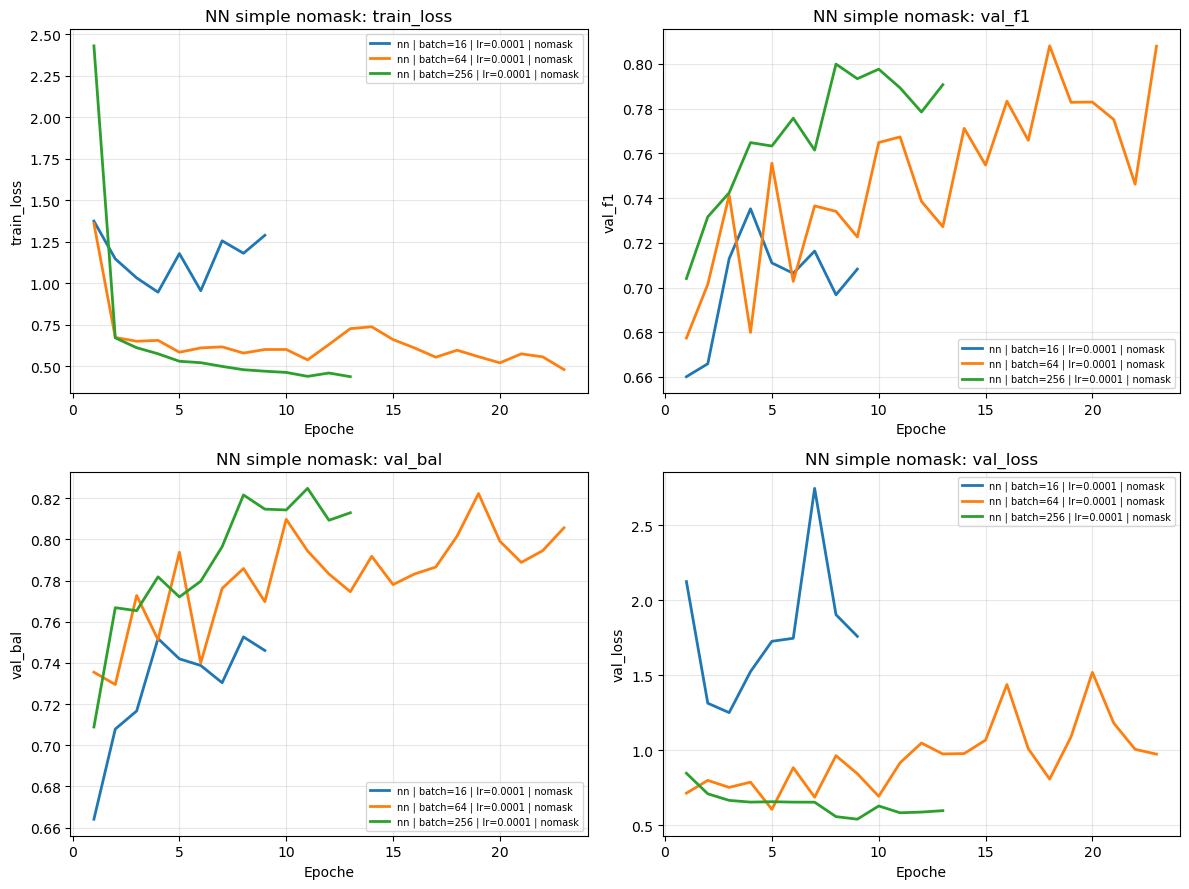


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=16 | lr=0.0001 | nomask (AUC=0.906)
nn | batch=64 | lr=0.0001 | nomask (AUC=0.949)
nn | batch=256 | lr=0.0001 | nomask (AUC=0.944)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=16 | lr=0.0001 | nomask (AUC=0.849)
nn | batch=64 | lr=0.0001 | nomask (AUC=0.916)
nn | batch=256 | lr=0.0001 | nomask (AUC=0.916)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=16 | lr=0.0001 | nomask (AUC=0.875)
nn | batch=64 | lr=0.0001 | nomask (AUC=0.920)
nn | batch=256 | lr=0.0001 | nomask (AUC=0.917)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
nn | batch=16 | lr=0.0001 | nomask (AUC=0.980)
nn | batch=64 | lr=0.0001 | nomask (AUC=0.992)
nn | batch=256 | lr=0.0001 | nomask (AUC=0.995)


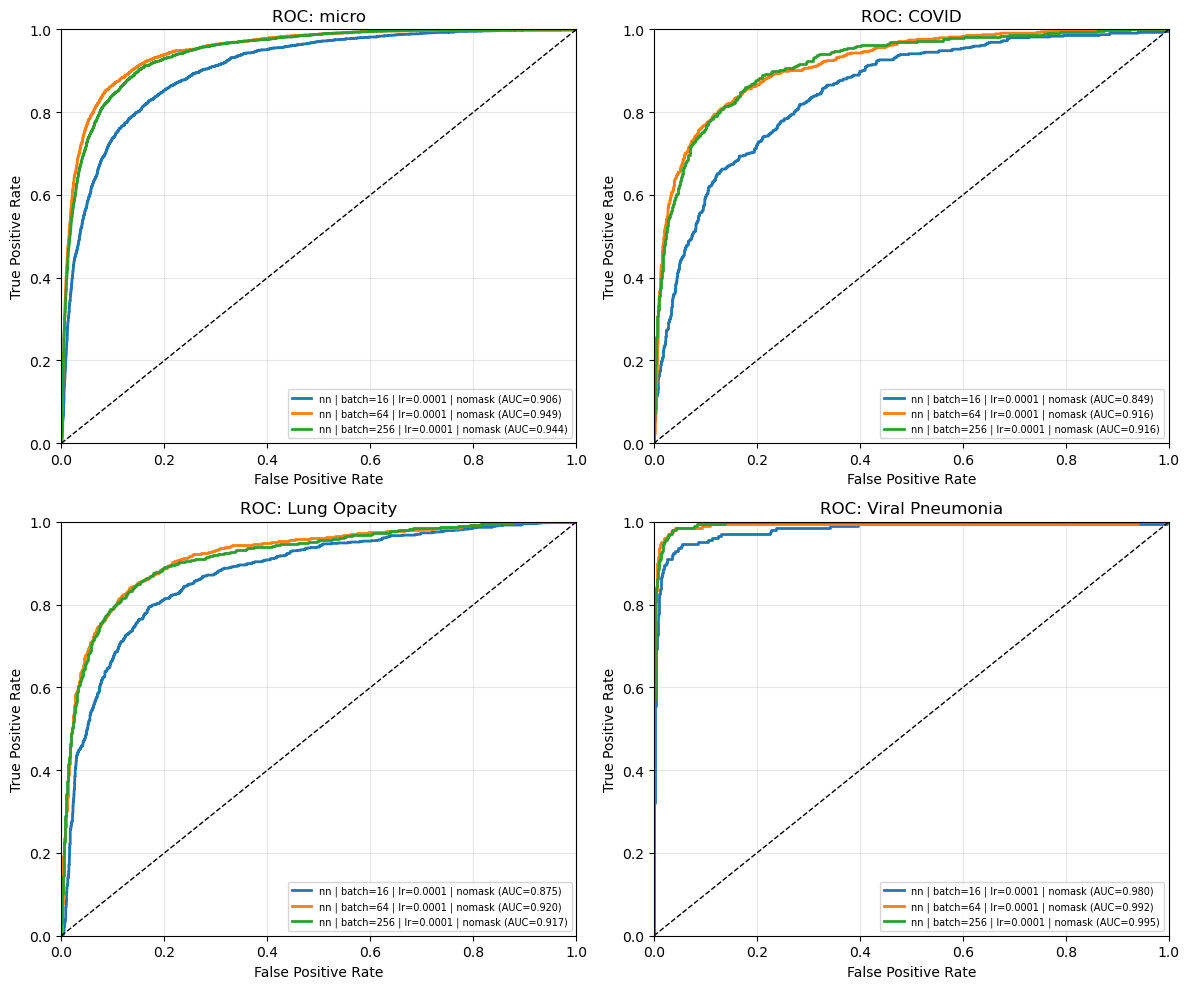

In [132]:
plot_train_overlays_grid(
    train_dirs_nns_nomask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN simple nomask"
)
plot_test_roc_overlays_grid(
    test_dirs_nns_nomask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [133]:
train_dirs_nns_nomask = []
test_dirs_nns_nomask  = []
for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "nomask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=40,
        model_kind="nn_simple"
    )
    train_dirs_nns_nomask += t
    test_dirs_nns_nomask  += tt



=== SWEEP RUN: model=nn_simple | mode=nomask | batch=64 | lr=0.0001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=64 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.7610 | val_loss=0.6552 | val_f1=0.675 | val_bal=0.739 | 28.69s


Epoche 02: train_loss=0.5969 | val_loss=0.5751 | val_f1=0.748 | val_bal=0.790 | 28.59s


Epoche 03: train_loss=0.5568 | val_loss=0.5364 | val_f1=0.750 | val_bal=0.796 | 28.38s


Epoche 04: train_loss=0.5223 | val_loss=0.5376 | val_f1=0.788 | val_bal=0.801 | 28.63s


Epoche 05: train_loss=0.4919 | val_loss=0.5496 | val_f1=0.787 | val_bal=0.808 | 27.75s


Epoche 06: train_loss=0.4700 | val_loss=0.5390 | val_f1=0.802 | val_bal=0.812 | 27.83s


Epoche 07: train_loss=0.4548 | val_loss=0.5096 | val_f1=0.803 | val_bal=0.821 | 27.95s


Epoche 08: train_loss=0.4501 | val_loss=0.4971 | val_f1=0.815 | val_bal=0.827 | 28.06s


Epoche 09: train_loss=0.4338 | val_loss=0.5108 | val_f1=0.803 | val_bal=0.828 | 28.22s


Epoche 10: train_loss=0.4219 | val_loss=0.4939 | val_f1=0.796 | val_bal=0.832 | 27.90s


Epoche 11: train_loss=0.4158 | val_loss=0.5075 | val_f1=0.822 | val_bal=0.830 | 27.68s


Epoche 12: train_loss=0.4043 | val_loss=0.5210 | val_f1=0.805 | val_bal=0.819 | 28.13s


Epoche 13: train_loss=0.3933 | val_loss=0.4795 | val_f1=0.814 | val_bal=0.836 | 28.14s


Epoche 14: train_loss=0.3905 | val_loss=0.5030 | val_f1=0.831 | val_bal=0.829 | 28.29s


Epoche 15: train_loss=0.3731 | val_loss=0.4810 | val_f1=0.813 | val_bal=0.837 | 27.74s


Epoche 16: train_loss=0.3686 | val_loss=0.4676 | val_f1=0.822 | val_bal=0.834 | 28.26s


Epoche 17: train_loss=0.3659 | val_loss=0.5040 | val_f1=0.836 | val_bal=0.833 | 27.99s


Epoche 18: train_loss=0.3445 | val_loss=0.4896 | val_f1=0.831 | val_bal=0.838 | 28.09s


Epoche 19: train_loss=0.3500 | val_loss=0.4406 | val_f1=0.823 | val_bal=0.848 | 27.99s


Epoche 20: train_loss=0.3458 | val_loss=0.4764 | val_f1=0.804 | val_bal=0.841 | 28.51s


Epoche 21: train_loss=0.3415 | val_loss=0.5324 | val_f1=0.830 | val_bal=0.824 | 28.19s


Epoche 22: train_loss=0.3260 | val_loss=0.4540 | val_f1=0.832 | val_bal=0.847 | 27.81s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0539_batch-64_lr-00001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=64
Pfad=nn_nomask_2025_08_31_0539_batch-64_lr-00001.pt


[test] F1(macro)=0.821 | BalAcc=0.833 | Zeit=5.14s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0539_batch-64_lr-00001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0539_batch-64_lr-00001 | F1=0.821 | BalAcc=0.833

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3898 | val_loss=0.7507 | val_f1=0.717 | val_bal=0.736 | 28.39s


Epoche 02: train_loss=0.6767 | val_loss=0.7345 | val_f1=0.757 | val_bal=0.756 | 27.83s


Epoche 03: train_loss=0.6512 | val_loss=0.6755 | val_f1=0.737 | val_bal=0.773 | 27.93s


Epoche 04: train_loss=0.6271 | val_loss=0.6885 | val_f1=0.692 | val_bal=0.770 | 27.96s


Epoche 05: train_loss=0.6159 | val_loss=0.6635 | val_f1=0.777 | val_bal=0.789 | 27.86s


Epoche 06: train_loss=0.5896 | val_loss=0.8336 | val_f1=0.732 | val_bal=0.772 | 27.91s


Epoche 07: train_loss=0.6257 | val_loss=0.8290 | val_f1=0.765 | val_bal=0.763 | 28.16s


Epoche 08: train_loss=0.5937 | val_loss=0.8980 | val_f1=0.759 | val_bal=0.787 | 27.77s


Epoche 09: train_loss=0.6485 | val_loss=0.8480 | val_f1=0.772 | val_bal=0.799 | 27.84s


Epoche 10: train_loss=0.5625 | val_loss=0.8807 | val_f1=0.769 | val_bal=0.783 | 28.02s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0550_batch-64_lr-0001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=64
Pfad=nn_nomask_2025_08_31_0550_batch-64_lr-0001.pt


[test] F1(macro)=0.763 | BalAcc=0.783 | Zeit=5.12s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0550_batch-64_lr-0001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0550_batch-64_lr-0001 | F1=0.763 | BalAcc=0.783

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=64 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Abbruch: Loss-Explosion erkannt.
[lr-finder] Ende: min_loss=0.8700 @idx=86 → vorgeschlagene LR=1.071e-04
[lr-finder] gewählte Start-LR: 1.071e-04

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=64 | LR=0.00010707133354821518 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.7654 | val_loss=0.6207 | val_f1=0.744 | val_bal=0.767 | 29.34s


Epoche 02: train_loss=0.5985 | val_loss=0.5713 | val_f1=0.726 | val_bal=0.781 | 28.23s


Epoche 03: train_loss=0.5496 | val_loss=0.6009 | val_f1=0.777 | val_bal=0.781 | 28.31s


Epoche 04: train_loss=0.5131 | val_loss=0.5761 | val_f1=0.786 | val_bal=0.782 | 27.82s


Epoche 05: train_loss=0.4970 | val_loss=0.5463 | val_f1=0.773 | val_bal=0.790 | 27.96s


Epoche 06: train_loss=0.4726 | val_loss=0.5282 | val_f1=0.802 | val_bal=0.805 | 28.17s


Epoche 07: train_loss=0.4520 | val_loss=0.5485 | val_f1=0.823 | val_bal=0.813 | 27.77s


Epoche 08: train_loss=0.4493 | val_loss=0.5192 | val_f1=0.806 | val_bal=0.815 | 28.17s


Epoche 09: train_loss=0.4407 | val_loss=0.4900 | val_f1=0.792 | val_bal=0.826 | 27.93s


Epoche 10: train_loss=0.4225 | val_loss=0.4749 | val_f1=0.814 | val_bal=0.834 | 28.05s


Epoche 11: train_loss=0.4144 | val_loss=0.5016 | val_f1=0.812 | val_bal=0.829 | 27.90s


Epoche 12: train_loss=0.3926 | val_loss=0.4996 | val_f1=0.807 | val_bal=0.830 | 27.67s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0554_batch-64_lr-000010707133354821518
[TEST-START] Model=nn_simple | Modus=nomask | Batch=64
Pfad=nn_nomask_2025_08_31_0554_batch-64_lr-000010707133354821518.pt


[test] F1(macro)=0.806 | BalAcc=0.807 | Zeit=5.06s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0554_batch-64_lr-000010707133354821518_test
[SWEEP] Modell=nn_nomask_2025_08_31_0554_batch-64_lr-000010707133354821518 | F1=0.806 | BalAcc=0.807

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=128 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.7631 | val_loss=0.7033 | val_f1=0.722 | val_bal=0.728 | 28.71s


Epoche 02: train_loss=0.5958 | val_loss=0.6100 | val_f1=0.754 | val_bal=0.770 | 28.15s


Epoche 03: train_loss=0.5485 | val_loss=0.5583 | val_f1=0.771 | val_bal=0.787 | 28.18s


Epoche 04: train_loss=0.5075 | val_loss=0.5209 | val_f1=0.781 | val_bal=0.805 | 28.40s


Epoche 05: train_loss=0.4913 | val_loss=0.5381 | val_f1=0.803 | val_bal=0.800 | 28.06s


Epoche 06: train_loss=0.4755 | val_loss=0.5015 | val_f1=0.787 | val_bal=0.810 | 27.71s


Epoche 07: train_loss=0.4539 | val_loss=0.5196 | val_f1=0.811 | val_bal=0.809 | 27.63s


Epoche 08: train_loss=0.4413 | val_loss=0.5022 | val_f1=0.790 | val_bal=0.814 | 28.07s


Epoche 09: train_loss=0.4309 | val_loss=0.4862 | val_f1=0.815 | val_bal=0.834 | 27.64s


Epoche 10: train_loss=0.4175 | val_loss=0.4623 | val_f1=0.808 | val_bal=0.827 | 27.66s


Epoche 11: train_loss=0.4119 | val_loss=0.4679 | val_f1=0.818 | val_bal=0.839 | 27.99s


Epoche 12: train_loss=0.3901 | val_loss=0.4533 | val_f1=0.833 | val_bal=0.843 | 27.48s


Epoche 13: train_loss=0.3847 | val_loss=0.5030 | val_f1=0.825 | val_bal=0.818 | 28.70s


Epoche 14: train_loss=0.3769 | val_loss=0.4479 | val_f1=0.829 | val_bal=0.849 | 27.82s


Epoche 15: train_loss=0.3672 | val_loss=0.4572 | val_f1=0.829 | val_bal=0.839 | 27.67s


Epoche 16: train_loss=0.3498 | val_loss=0.4739 | val_f1=0.829 | val_bal=0.835 | 28.09s


Epoche 17: train_loss=0.3555 | val_loss=0.4592 | val_f1=0.828 | val_bal=0.840 | 27.98s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0600_batch-128_lr-00001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=128
Pfad=nn_nomask_2025_08_31_0600_batch-128_lr-00001.pt


[test] F1(macro)=0.803 | BalAcc=0.829 | Zeit=5.29s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0600_batch-128_lr-00001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0600_batch-128_lr-00001 | F1=0.803 | BalAcc=0.829

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=128 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4357 | val_loss=0.7887 | val_f1=0.645 | val_bal=0.733 | 28.39s


Epoche 02: train_loss=0.6649 | val_loss=0.6804 | val_f1=0.721 | val_bal=0.759 | 28.11s


Epoche 03: train_loss=0.6042 | val_loss=0.6240 | val_f1=0.747 | val_bal=0.786 | 28.26s


Epoche 04: train_loss=0.5822 | val_loss=0.7602 | val_f1=0.751 | val_bal=0.771 | 27.76s


Epoche 05: train_loss=0.5554 | val_loss=0.6459 | val_f1=0.756 | val_bal=0.788 | 27.78s


Epoche 06: train_loss=0.5186 | val_loss=0.7307 | val_f1=0.788 | val_bal=0.791 | 27.65s


Epoche 07: train_loss=0.5326 | val_loss=0.6887 | val_f1=0.768 | val_bal=0.781 | 27.55s


Epoche 08: train_loss=0.5122 | val_loss=0.7456 | val_f1=0.778 | val_bal=0.800 | 27.87s


Epoche 09: train_loss=0.5429 | val_loss=0.6527 | val_f1=0.773 | val_bal=0.801 | 28.23s


Epoche 10: train_loss=0.5247 | val_loss=0.6328 | val_f1=0.796 | val_bal=0.815 | 28.19s


Epoche 11: train_loss=0.4969 | val_loss=0.5944 | val_f1=0.813 | val_bal=0.821 | 28.11s


Epoche 12: train_loss=0.5081 | val_loss=0.6951 | val_f1=0.799 | val_bal=0.818 | 28.02s


Epoche 13: train_loss=0.5183 | val_loss=0.7418 | val_f1=0.785 | val_bal=0.805 | 28.12s


Epoche 14: train_loss=0.4722 | val_loss=0.7286 | val_f1=0.785 | val_bal=0.805 | 28.34s


Epoche 15: train_loss=0.4679 | val_loss=0.5867 | val_f1=0.792 | val_bal=0.818 | 27.85s


Epoche 16: train_loss=0.4440 | val_loss=0.6497 | val_f1=0.786 | val_bal=0.828 | 27.90s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0609_batch-128_lr-0001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=128
Pfad=nn_nomask_2025_08_31_0609_batch-128_lr-0001.pt


[test] F1(macro)=0.789 | BalAcc=0.809 | Zeit=5.17s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0609_batch-128_lr-0001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0609_batch-128_lr-0001 | F1=0.789 | BalAcc=0.809

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Abbruch: Loss-Explosion erkannt.
[lr-finder] Ende: min_loss=0.8263 @idx=72 → vorgeschlagene LR=5.601e-05
[lr-finder] gewählte Start-LR: 5.601e-05

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=128 | LR=5.601007788367291e-05 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.7406 | val_loss=0.6728 | val_f1=0.688 | val_bal=0.732 | 28.83s


Epoche 02: train_loss=0.6054 | val_loss=0.5663 | val_f1=0.764 | val_bal=0.784 | 27.73s


Epoche 03: train_loss=0.5360 | val_loss=0.5416 | val_f1=0.792 | val_bal=0.800 | 27.93s


Epoche 04: train_loss=0.5121 | val_loss=0.5235 | val_f1=0.789 | val_bal=0.800 | 27.83s


Epoche 05: train_loss=0.4903 | val_loss=0.4910 | val_f1=0.775 | val_bal=0.810 | 28.10s


Epoche 06: train_loss=0.4654 | val_loss=0.4957 | val_f1=0.815 | val_bal=0.824 | 28.14s


Epoche 07: train_loss=0.4479 | val_loss=0.4946 | val_f1=0.810 | val_bal=0.825 | 27.81s


Epoche 08: train_loss=0.4386 | val_loss=0.4790 | val_f1=0.803 | val_bal=0.828 | 27.79s


Epoche 09: train_loss=0.4273 | val_loss=0.4477 | val_f1=0.800 | val_bal=0.828 | 28.35s


Epoche 10: train_loss=0.4192 | val_loss=0.4734 | val_f1=0.797 | val_bal=0.822 | 28.09s


Epoche 11: train_loss=0.4196 | val_loss=0.4440 | val_f1=0.819 | val_bal=0.833 | 28.02s


Epoche 12: train_loss=0.3983 | val_loss=0.4786 | val_f1=0.807 | val_bal=0.825 | 28.26s


Epoche 13: train_loss=0.3891 | val_loss=0.4564 | val_f1=0.829 | val_bal=0.832 | 28.34s


Epoche 14: train_loss=0.3838 | val_loss=0.4559 | val_f1=0.816 | val_bal=0.840 | 28.48s


Epoche 15: train_loss=0.3724 | val_loss=0.4591 | val_f1=0.837 | val_bal=0.839 | 27.91s


Epoche 16: train_loss=0.3625 | val_loss=0.4286 | val_f1=0.829 | val_bal=0.843 | 28.00s


Epoche 17: train_loss=0.3564 | val_loss=0.4372 | val_f1=0.833 | val_bal=0.842 | 28.08s


Epoche 18: train_loss=0.3512 | val_loss=0.4408 | val_f1=0.835 | val_bal=0.837 | 27.98s


Epoche 19: train_loss=0.3398 | val_loss=0.4307 | val_f1=0.839 | val_bal=0.847 | 27.96s


Epoche 20: train_loss=0.3294 | val_loss=0.4252 | val_f1=0.812 | val_bal=0.846 | 27.80s


Epoche 21: train_loss=0.3277 | val_loss=0.4356 | val_f1=0.821 | val_bal=0.851 | 27.66s


Epoche 22: train_loss=0.3213 | val_loss=0.4360 | val_f1=0.841 | val_bal=0.849 | 27.90s


Epoche 23: train_loss=0.3265 | val_loss=0.4168 | val_f1=0.836 | val_bal=0.848 | 27.92s


Epoche 24: train_loss=0.3130 | val_loss=0.4132 | val_f1=0.826 | val_bal=0.852 | 28.01s


Epoche 25: train_loss=0.3056 | val_loss=0.4119 | val_f1=0.841 | val_bal=0.852 | 28.31s


Epoche 26: train_loss=0.3078 | val_loss=0.4589 | val_f1=0.826 | val_bal=0.838 | 28.64s


Epoche 27: train_loss=0.3089 | val_loss=0.4317 | val_f1=0.843 | val_bal=0.852 | 28.35s


Epoche 28: train_loss=0.2913 | val_loss=0.4286 | val_f1=0.854 | val_bal=0.856 | 27.99s


Epoche 29: train_loss=0.2898 | val_loss=0.4705 | val_f1=0.842 | val_bal=0.840 | 28.73s


Epoche 30: train_loss=0.2975 | val_loss=0.4020 | val_f1=0.848 | val_bal=0.865 | 28.08s


Epoche 31: train_loss=0.2815 | val_loss=0.4156 | val_f1=0.827 | val_bal=0.854 | 28.18s


Epoche 32: train_loss=0.2759 | val_loss=0.4398 | val_f1=0.847 | val_bal=0.853 | 28.17s


Epoche 33: train_loss=0.2694 | val_loss=0.4494 | val_f1=0.842 | val_bal=0.847 | 28.47s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0616_batch-128_lr-5601007788367291e-05
[TEST-START] Model=nn_simple | Modus=nomask | Batch=128
Pfad=nn_nomask_2025_08_31_0616_batch-128_lr-5601007788367291e-05.pt


[test] F1(macro)=0.832 | BalAcc=0.845 | Zeit=5.29s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0616_batch-128_lr-5601007788367291e-05_test
[SWEEP] Modell=nn_nomask_2025_08_31_0616_batch-128_lr-5601007788367291e-05 | F1=0.832 | BalAcc=0.845

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=256 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.7861 | val_loss=0.6360 | val_f1=0.693 | val_bal=0.743 | 29.19s


Epoche 02: train_loss=0.6089 | val_loss=0.5962 | val_f1=0.758 | val_bal=0.768 | 28.47s


Epoche 03: train_loss=0.5520 | val_loss=0.5562 | val_f1=0.785 | val_bal=0.789 | 28.03s


Epoche 04: train_loss=0.5175 | val_loss=0.5092 | val_f1=0.767 | val_bal=0.807 | 28.34s


Epoche 05: train_loss=0.4921 | val_loss=0.5053 | val_f1=0.787 | val_bal=0.808 | 27.97s


Epoche 06: train_loss=0.4678 | val_loss=0.5401 | val_f1=0.790 | val_bal=0.792 | 27.62s


Epoche 07: train_loss=0.4521 | val_loss=0.4934 | val_f1=0.796 | val_bal=0.812 | 27.96s


Epoche 08: train_loss=0.4359 | val_loss=0.4960 | val_f1=0.806 | val_bal=0.813 | 28.57s


Epoche 09: train_loss=0.4250 | val_loss=0.4618 | val_f1=0.821 | val_bal=0.838 | 28.39s


Epoche 10: train_loss=0.4209 | val_loss=0.4859 | val_f1=0.799 | val_bal=0.823 | 27.69s


Epoche 11: train_loss=0.4150 | val_loss=0.4592 | val_f1=0.825 | val_bal=0.835 | 27.44s


Epoche 12: train_loss=0.4042 | val_loss=0.4654 | val_f1=0.830 | val_bal=0.838 | 28.46s


Epoche 13: train_loss=0.3944 | val_loss=0.4537 | val_f1=0.825 | val_bal=0.836 | 28.42s


Epoche 14: train_loss=0.3758 | val_loss=0.4605 | val_f1=0.822 | val_bal=0.831 | 27.96s


Epoche 15: train_loss=0.3670 | val_loss=0.4547 | val_f1=0.805 | val_bal=0.841 | 27.87s


Epoche 16: train_loss=0.3721 | val_loss=0.4401 | val_f1=0.806 | val_bal=0.840 | 28.06s


Epoche 17: train_loss=0.3643 | val_loss=0.4578 | val_f1=0.794 | val_bal=0.836 | 27.84s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0633_batch-256_lr-00001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=256
Pfad=nn_nomask_2025_08_31_0633_batch-256_lr-00001.pt


[test] F1(macro)=0.805 | BalAcc=0.830 | Zeit=5.21s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0633_batch-256_lr-00001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0633_batch-256_lr-00001 | F1=0.805 | BalAcc=0.830

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=2.2970 | val_loss=0.8511 | val_f1=0.701 | val_bal=0.707 | 28.25s


Epoche 02: train_loss=0.6602 | val_loss=0.6612 | val_f1=0.729 | val_bal=0.769 | 27.69s


Epoche 03: train_loss=0.5957 | val_loss=0.6441 | val_f1=0.739 | val_bal=0.772 | 27.60s


Epoche 04: train_loss=0.5515 | val_loss=0.5683 | val_f1=0.784 | val_bal=0.808 | 27.66s


Epoche 05: train_loss=0.5281 | val_loss=0.6009 | val_f1=0.791 | val_bal=0.811 | 27.60s


Epoche 06: train_loss=0.5170 | val_loss=0.5834 | val_f1=0.773 | val_bal=0.795 | 27.44s


Epoche 07: train_loss=0.4932 | val_loss=0.5725 | val_f1=0.783 | val_bal=0.804 | 27.68s


Epoche 08: train_loss=0.4797 | val_loss=0.6018 | val_f1=0.794 | val_bal=0.807 | 27.87s


Epoche 09: train_loss=0.4646 | val_loss=0.5744 | val_f1=0.796 | val_bal=0.804 | 27.87s


Epoche 10: train_loss=0.4532 | val_loss=0.5832 | val_f1=0.803 | val_bal=0.810 | 27.87s


Epoche 11: train_loss=0.4537 | val_loss=0.5886 | val_f1=0.756 | val_bal=0.810 | 28.21s


Epoche 12: train_loss=0.4289 | val_loss=0.6568 | val_f1=0.812 | val_bal=0.809 | 28.09s


Epoche 13: train_loss=0.4479 | val_loss=0.5715 | val_f1=0.807 | val_bal=0.820 | 27.93s


Epoche 14: train_loss=0.4280 | val_loss=0.6174 | val_f1=0.782 | val_bal=0.819 | 27.87s


Epoche 15: train_loss=0.4233 | val_loss=0.5871 | val_f1=0.819 | val_bal=0.824 | 27.72s


Epoche 16: train_loss=0.4246 | val_loss=0.6273 | val_f1=0.816 | val_bal=0.823 | 27.82s


Epoche 17: train_loss=0.4069 | val_loss=0.5970 | val_f1=0.827 | val_bal=0.833 | 27.97s


Epoche 18: train_loss=0.3862 | val_loss=0.5689 | val_f1=0.830 | val_bal=0.832 | 27.98s


Epoche 19: train_loss=0.4192 | val_loss=0.5523 | val_f1=0.812 | val_bal=0.831 | 28.06s


Epoche 20: train_loss=0.3950 | val_loss=0.5787 | val_f1=0.830 | val_bal=0.848 | 27.98s


Epoche 21: train_loss=0.4018 | val_loss=0.6069 | val_f1=0.811 | val_bal=0.825 | 27.77s


Epoche 22: train_loss=0.4075 | val_loss=0.6207 | val_f1=0.812 | val_bal=0.827 | 27.82s


Epoche 23: train_loss=0.4141 | val_loss=0.6295 | val_f1=0.813 | val_bal=0.826 | 27.77s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0641_batch-256_lr-0001
[TEST-START] Model=nn_simple | Modus=nomask | Batch=256
Pfad=nn_nomask_2025_08_31_0641_batch-256_lr-0001.pt


[test] F1(macro)=0.808 | BalAcc=0.821 | Zeit=5.25s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0641_batch-256_lr-0001_test
[SWEEP] Modell=nn_nomask_2025_08_31_0641_batch-256_lr-0001 | F1=0.808 | BalAcc=0.821

=== SWEEP RUN: model=nn_simple | mode=nomask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Abbruch: Loss-Explosion erkannt.
[lr-finder] Ende: min_loss=0.7600 @idx=74 → vorgeschlagene LR=6.144e-05
[lr-finder] gewählte Start-LR: 6.144e-05

[TRAIN-START] Model=nn_simple | Modus=nomask | Batch=256 | LR=6.144225997723548e-05 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.7344 | val_loss=0.6365 | val_f1=0.727 | val_bal=0.759 | 28.64s


Epoche 02: train_loss=0.6045 | val_loss=0.6148 | val_f1=0.736 | val_bal=0.753 | 28.00s


Epoche 03: train_loss=0.5557 | val_loss=0.5294 | val_f1=0.765 | val_bal=0.802 | 27.28s


Epoche 04: train_loss=0.5282 | val_loss=0.5485 | val_f1=0.770 | val_bal=0.795 | 27.57s


Epoche 05: train_loss=0.4969 | val_loss=0.5040 | val_f1=0.798 | val_bal=0.811 | 28.08s


Epoche 06: train_loss=0.4680 | val_loss=0.5157 | val_f1=0.764 | val_bal=0.806 | 27.91s


Epoche 07: train_loss=0.4573 | val_loss=0.4828 | val_f1=0.790 | val_bal=0.817 | 27.96s


Epoche 08: train_loss=0.4458 | val_loss=0.4813 | val_f1=0.811 | val_bal=0.815 | 28.06s


Epoche 09: train_loss=0.4334 | val_loss=0.5133 | val_f1=0.810 | val_bal=0.815 | 28.24s


Epoche 10: train_loss=0.4267 | val_loss=0.4580 | val_f1=0.827 | val_bal=0.832 | 28.32s


Epoche 11: train_loss=0.4170 | val_loss=0.4894 | val_f1=0.786 | val_bal=0.809 | 27.77s


Epoche 12: train_loss=0.4051 | val_loss=0.4523 | val_f1=0.816 | val_bal=0.830 | 27.40s


Epoche 13: train_loss=0.3953 | val_loss=0.4354 | val_f1=0.830 | val_bal=0.842 | 27.75s


Epoche 14: train_loss=0.3907 | val_loss=0.4621 | val_f1=0.840 | val_bal=0.836 | 27.75s


Epoche 15: train_loss=0.3696 | val_loss=0.4584 | val_f1=0.797 | val_bal=0.829 | 28.05s


Epoche 16: train_loss=0.3720 | val_loss=0.4666 | val_f1=0.791 | val_bal=0.823 | 27.62s


Epoche 17: train_loss=0.3761 | val_loss=0.4452 | val_f1=0.827 | val_bal=0.840 | 28.12s


Epoche 18: train_loss=0.3593 | val_loss=0.4367 | val_f1=0.822 | val_bal=0.841 | 28.26s


Epoche 19: train_loss=0.3473 | val_loss=0.4323 | val_f1=0.828 | val_bal=0.845 | 27.85s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_nomask_2025_08_31_0652_batch-256_lr-6144225997723548e-05
[TEST-START] Model=nn_simple | Modus=nomask | Batch=256
Pfad=nn_nomask_2025_08_31_0652_batch-256_lr-6144225997723548e-05.pt


[test] F1(macro)=0.821 | BalAcc=0.834 | Zeit=5.28s | /home/lupan001/ML/results/nn_nomask_2025_08_31_0652_batch-256_lr-6144225997723548e-05_test
[SWEEP] Modell=nn_nomask_2025_08_31_0652_batch-256_lr-6144225997723548e-05 | F1=0.821 | BalAcc=0.834



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=128 | lr=0.0001 | nomask | train_loss max=1.4357
nn | batch=128 | lr=1e-05 | nomask | train_loss max=0.7631
nn | batch=128 | lr=5.601e+10 | nomask | train_loss max=0.7406
nn | batch=256 | lr=0.0001 | nomask | train_loss max=2.2970
nn | batch=256 | lr=1e-05 | nomask | train_loss max=0.7861
nn | batch=256 | lr=6.144e+10 | nomask | train_loss max=0.7344
nn | batch=64 | lr=0.0001 | nomask | train_loss max=1.3898
nn | batch=64 | lr=1.071e-05 | nomask | train_loss max=0.7654
nn | batch=64 | lr=1e-05 | nomask | train_loss max=0.7610

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=128 | lr=0.0001 | nomask | val_f1 max=0.8127
nn | batch=128 | lr=1e-05 | nomask | val_f1 max=0.8329
nn | batch=128 | lr=5.601e+10 | nomask | val_f1 max=0.8545
nn | batch=256 | lr=0.0001 | nomask | val_f1 max=0.8304
nn | batch=256 | lr=1e-05 | nomask | val_f1 max=0.8300
nn | batch=256 | lr=6.144e+10 | nomask | val_f1 max=0.8396
nn | batch=64 | lr=0.0001 | nomas

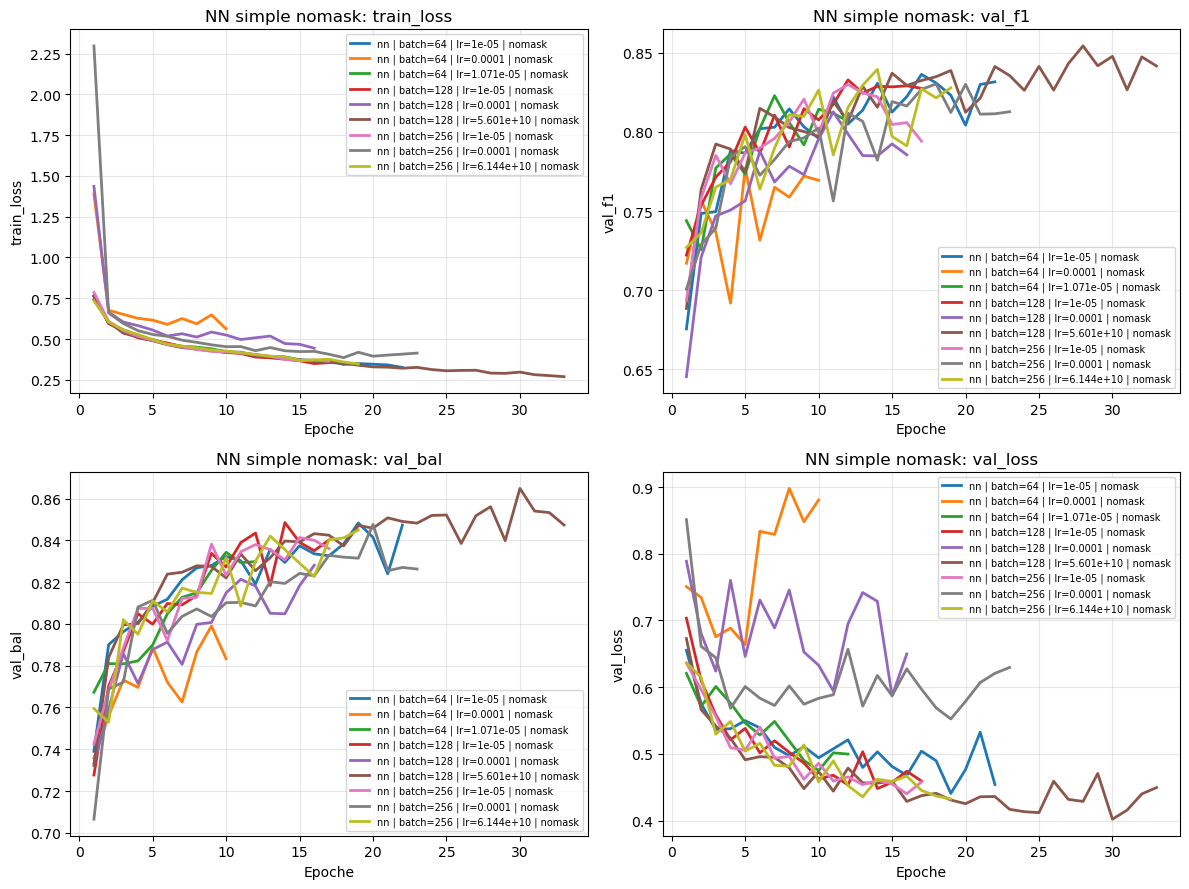


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=64 | lr=1e-05 | nomask (AUC=0.962)
nn | batch=64 | lr=0.0001 | nomask (AUC=0.932)
nn | batch=64 | lr=1.071e-05 | nomask (AUC=0.957)
nn | batch=128 | lr=1e-05 | nomask (AUC=0.956)
nn | batch=128 | lr=0.0001 | nomask (AUC=0.949)
nn | batch=128 | lr=5.601e+10 | nomask (AUC=0.966)
nn | batch=256 | lr=1e-05 | nomask (AUC=0.957)
nn | batch=256 | lr=0.0001 | nomask (AUC=0.956)
nn | batch=256 | lr=6.144e+10 | nomask (AUC=0.963)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=64 | lr=1e-05 | nomask (AUC=0.942)
nn | batch=64 | lr=0.0001 | nomask (AUC=0.904)
nn | batch=64 | lr=1.071e-05 | nomask (AUC=0.929)
nn | batch=128 | lr=1e-05 | nomask (AUC=0.938)
nn | batch=128 | lr=0.0001 | nomask (AUC=0.926)
nn | batch=128 | lr=5.601e+10 | nomask (AUC=0.955)
nn | batch=256 | lr=1e-05 | nomask (AUC=0.936)
nn | batch=256 | lr=0.0001 | nomask (AUC=0.939)
nn | batch=256 | lr=6.144e+10 | nomask (AUC=0.946)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=6

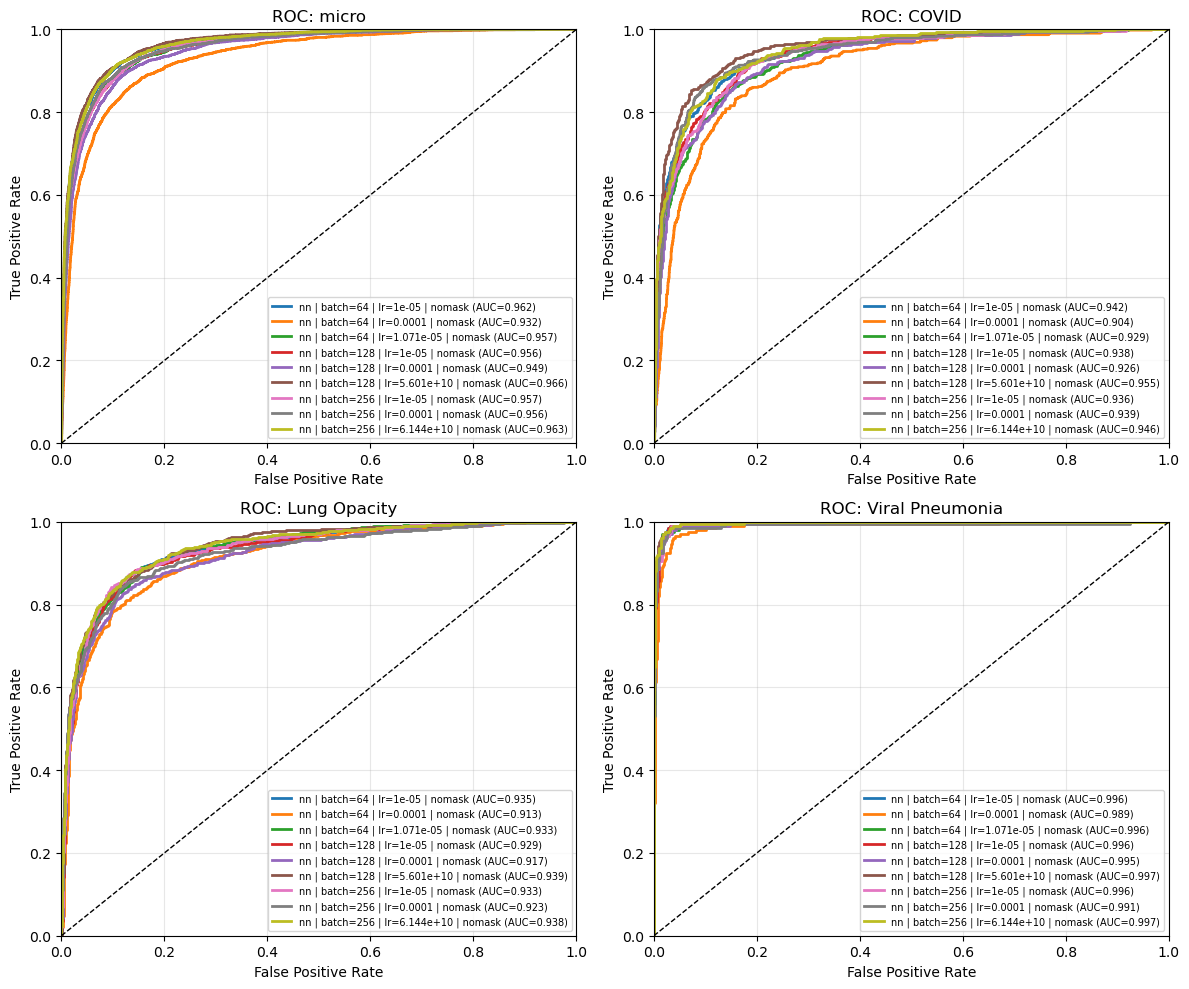

In [134]:
plot_train_overlays_grid(
    train_dirs_nns_nomask,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN simple nomask"
)
plot_test_roc_overlays_grid(
    test_dirs_nns_nomask,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [135]:
train_dirs_nnm_mask_batch, test_dirs_nnm_mask_batch = run_sweep_train_test(
    "mask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=40,
    model_kind="nn_mlp"
)



=== SWEEP RUN: model=nn_mlp | mode=mask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=16 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3484 | val_loss=1.1193 | val_f1=0.451 | val_bal=0.497 | 44.71s


Epoche 02: train_loss=1.0938 | val_loss=0.9988 | val_f1=0.521 | val_bal=0.575 | 43.54s


Epoche 03: train_loss=1.0068 | val_loss=0.9391 | val_f1=0.547 | val_bal=0.585 | 44.07s


Epoche 04: train_loss=0.9524 | val_loss=0.9332 | val_f1=0.512 | val_bal=0.622 | 43.61s


Epoche 05: train_loss=0.9067 | val_loss=0.8650 | val_f1=0.586 | val_bal=0.615 | 43.98s


Epoche 06: train_loss=0.8823 | val_loss=0.8582 | val_f1=0.589 | val_bal=0.618 | 43.93s


Epoche 07: train_loss=0.8552 | val_loss=0.8415 | val_f1=0.567 | val_bal=0.648 | 45.00s


Epoche 08: train_loss=0.8316 | val_loss=0.8699 | val_f1=0.627 | val_bal=0.613 | 44.38s


Epoche 09: train_loss=0.8177 | val_loss=0.7641 | val_f1=0.662 | val_bal=0.679 | 44.22s


Epoche 10: train_loss=0.8105 | val_loss=0.7788 | val_f1=0.648 | val_bal=0.675 | 44.40s


Epoche 11: train_loss=0.7946 | val_loss=0.7456 | val_f1=0.657 | val_bal=0.684 | 43.99s


Epoche 12: train_loss=0.7955 | val_loss=0.7665 | val_f1=0.608 | val_bal=0.660 | 44.13s


Epoche 13: train_loss=0.7867 | val_loss=0.7725 | val_f1=0.632 | val_bal=0.659 | 44.31s


Epoche 14: train_loss=0.7727 | val_loss=0.7269 | val_f1=0.672 | val_bal=0.684 | 43.50s


Epoche 15: train_loss=0.7567 | val_loss=0.7203 | val_f1=0.673 | val_bal=0.689 | 44.73s


Epoche 16: train_loss=0.7539 | val_loss=0.6937 | val_f1=0.686 | val_bal=0.708 | 44.11s


Epoche 17: train_loss=0.7429 | val_loss=0.7018 | val_f1=0.676 | val_bal=0.702 | 44.47s


Epoche 18: train_loss=0.7473 | val_loss=0.6988 | val_f1=0.654 | val_bal=0.700 | 44.19s


Epoche 19: train_loss=0.7403 | val_loss=0.7447 | val_f1=0.680 | val_bal=0.688 | 43.66s


Epoche 20: train_loss=0.7286 | val_loss=0.7449 | val_f1=0.616 | val_bal=0.682 | 43.78s


Epoche 21: train_loss=0.7160 | val_loss=0.6845 | val_f1=0.692 | val_bal=0.718 | 44.31s


Epoche 22: train_loss=0.7167 | val_loss=0.6831 | val_f1=0.693 | val_bal=0.707 | 43.92s


Epoche 23: train_loss=0.7068 | val_loss=0.6997 | val_f1=0.682 | val_bal=0.705 | 43.31s


Epoche 24: train_loss=0.7090 | val_loss=0.6854 | val_f1=0.691 | val_bal=0.708 | 43.50s


Epoche 25: train_loss=0.6951 | val_loss=0.7258 | val_f1=0.681 | val_bal=0.695 | 43.48s


Epoche 26: train_loss=0.7056 | val_loss=0.6728 | val_f1=0.695 | val_bal=0.720 | 43.27s


Epoche 27: train_loss=0.6964 | val_loss=0.6561 | val_f1=0.685 | val_bal=0.730 | 43.76s


Epoche 28: train_loss=0.6909 | val_loss=0.6811 | val_f1=0.685 | val_bal=0.721 | 43.26s


Epoche 29: train_loss=0.6842 | val_loss=0.7905 | val_f1=0.565 | val_bal=0.647 | 43.88s


Epoche 30: train_loss=0.6850 | val_loss=0.6655 | val_f1=0.711 | val_bal=0.724 | 44.19s


Epoche 31: train_loss=0.6783 | val_loss=0.6536 | val_f1=0.696 | val_bal=0.730 | 43.89s


Epoche 32: train_loss=0.6695 | val_loss=0.6486 | val_f1=0.696 | val_bal=0.736 | 43.77s


Epoche 33: train_loss=0.6708 | val_loss=0.6435 | val_f1=0.687 | val_bal=0.734 | 43.99s


Epoche 34: train_loss=0.6626 | val_loss=0.6788 | val_f1=0.671 | val_bal=0.728 | 43.46s


Epoche 35: train_loss=0.6594 | val_loss=0.6692 | val_f1=0.680 | val_bal=0.715 | 43.64s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0702_batch-16_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=16
Pfad=nn_mlp_mask_2025_08_31_0702_batch-16_lr-0001.pt


[test] F1(macro)=0.691 | BalAcc=0.704 | Zeit=7.76s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0702_batch-16_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0702_batch-16_lr-0001 | F1=0.691 | BalAcc=0.704

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4216 | val_loss=1.3491 | val_f1=0.197 | val_bal=0.304 | 43.86s


Epoche 02: train_loss=1.2205 | val_loss=1.1314 | val_f1=0.351 | val_bal=0.438 | 43.62s


Epoche 03: train_loss=1.0770 | val_loss=1.0131 | val_f1=0.483 | val_bal=0.568 | 43.70s


Epoche 04: train_loss=1.0224 | val_loss=1.0152 | val_f1=0.462 | val_bal=0.560 | 43.51s


Epoche 05: train_loss=0.9967 | val_loss=0.9610 | val_f1=0.578 | val_bal=0.594 | 43.60s


Epoche 06: train_loss=0.9549 | val_loss=0.9366 | val_f1=0.495 | val_bal=0.602 | 43.75s


Epoche 07: train_loss=0.9047 | val_loss=0.8610 | val_f1=0.579 | val_bal=0.636 | 43.78s


Epoche 08: train_loss=0.8695 | val_loss=0.8413 | val_f1=0.621 | val_bal=0.640 | 43.85s


Epoche 09: train_loss=0.8507 | val_loss=0.8339 | val_f1=0.586 | val_bal=0.636 | 43.34s


Epoche 10: train_loss=0.8347 | val_loss=0.8383 | val_f1=0.550 | val_bal=0.647 | 43.93s


Epoche 11: train_loss=0.8141 | val_loss=0.7883 | val_f1=0.586 | val_bal=0.667 | 44.00s


Epoche 12: train_loss=0.7955 | val_loss=0.7587 | val_f1=0.612 | val_bal=0.676 | 43.41s


Epoche 13: train_loss=0.7804 | val_loss=0.7535 | val_f1=0.640 | val_bal=0.669 | 43.42s


Epoche 14: train_loss=0.7794 | val_loss=0.7295 | val_f1=0.645 | val_bal=0.683 | 43.05s


Epoche 15: train_loss=0.7634 | val_loss=0.7577 | val_f1=0.654 | val_bal=0.671 | 43.58s


Epoche 16: train_loss=0.7481 | val_loss=0.7460 | val_f1=0.653 | val_bal=0.673 | 42.61s


Epoche 17: train_loss=0.7494 | val_loss=0.7619 | val_f1=0.619 | val_bal=0.672 | 42.93s


Epoche 18: train_loss=0.7413 | val_loss=0.7623 | val_f1=0.628 | val_bal=0.668 | 43.81s


Epoche 19: train_loss=0.7341 | val_loss=0.7215 | val_f1=0.621 | val_bal=0.680 | 43.62s


Epoche 20: train_loss=0.7235 | val_loss=0.7401 | val_f1=0.673 | val_bal=0.686 | 43.02s


Epoche 21: train_loss=0.7124 | val_loss=0.7006 | val_f1=0.679 | val_bal=0.705 | 42.91s


Epoche 22: train_loss=0.7196 | val_loss=0.7179 | val_f1=0.679 | val_bal=0.690 | 43.65s


Epoche 23: train_loss=0.7146 | val_loss=0.6819 | val_f1=0.663 | val_bal=0.715 | 43.55s


Epoche 24: train_loss=0.6987 | val_loss=0.6941 | val_f1=0.668 | val_bal=0.707 | 44.52s


Epoche 25: train_loss=0.6948 | val_loss=0.6943 | val_f1=0.636 | val_bal=0.710 | 43.66s


Epoche 26: train_loss=0.6956 | val_loss=0.7067 | val_f1=0.651 | val_bal=0.688 | 43.55s


Epoche 27: train_loss=0.6913 | val_loss=0.7052 | val_f1=0.655 | val_bal=0.700 | 44.78s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0728_batch-64_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=64
Pfad=nn_mlp_mask_2025_08_31_0728_batch-64_lr-0001.pt


[test] F1(macro)=0.676 | BalAcc=0.689 | Zeit=8.07s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0728_batch-64_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0728_batch-64_lr-0001 | F1=0.676 | BalAcc=0.689

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4398 | val_loss=1.3750 | val_f1=0.197 | val_bal=0.254 | 46.28s


Epoche 02: train_loss=1.3792 | val_loss=1.3441 | val_f1=0.218 | val_bal=0.398 | 45.79s


Epoche 03: train_loss=1.2803 | val_loss=1.1178 | val_f1=0.381 | val_bal=0.505 | 45.12s


Epoche 04: train_loss=1.1256 | val_loss=1.0381 | val_f1=0.389 | val_bal=0.511 | 44.36s


Epoche 05: train_loss=1.0615 | val_loss=1.0295 | val_f1=0.445 | val_bal=0.523 | 44.87s


Epoche 06: train_loss=1.0181 | val_loss=0.9893 | val_f1=0.481 | val_bal=0.582 | 44.90s


Epoche 07: train_loss=1.0013 | val_loss=0.9964 | val_f1=0.438 | val_bal=0.554 | 43.65s


Epoche 08: train_loss=0.9821 | val_loss=1.0403 | val_f1=0.425 | val_bal=0.554 | 44.71s


Epoche 09: train_loss=0.9942 | val_loss=0.9518 | val_f1=0.512 | val_bal=0.600 | 44.87s


Epoche 10: train_loss=0.9682 | val_loss=0.9203 | val_f1=0.531 | val_bal=0.600 | 44.67s


Epoche 11: train_loss=0.9670 | val_loss=0.9284 | val_f1=0.523 | val_bal=0.616 | 45.66s


Epoche 12: train_loss=0.9380 | val_loss=0.8850 | val_f1=0.572 | val_bal=0.620 | 45.31s


Epoche 13: train_loss=0.9119 | val_loss=0.9931 | val_f1=0.568 | val_bal=0.560 | 44.75s


Epoche 14: train_loss=0.8943 | val_loss=0.8387 | val_f1=0.577 | val_bal=0.641 | 44.79s


Epoche 15: train_loss=0.8503 | val_loss=0.8185 | val_f1=0.586 | val_bal=0.642 | 44.72s


Epoche 16: train_loss=0.8355 | val_loss=0.8032 | val_f1=0.602 | val_bal=0.651 | 45.08s


Epoche 17: train_loss=0.8186 | val_loss=0.8478 | val_f1=0.624 | val_bal=0.636 | 45.46s


Epoche 18: train_loss=0.8038 | val_loss=0.8052 | val_f1=0.572 | val_bal=0.658 | 45.08s


Epoche 19: train_loss=0.8016 | val_loss=0.7930 | val_f1=0.583 | val_bal=0.653 | 45.08s


Epoche 20: train_loss=0.7862 | val_loss=0.7816 | val_f1=0.634 | val_bal=0.653 | 44.85s


Epoche 21: train_loss=0.7683 | val_loss=0.8236 | val_f1=0.611 | val_bal=0.641 | 44.08s


Epoche 22: train_loss=0.7664 | val_loss=0.7727 | val_f1=0.643 | val_bal=0.666 | 43.25s


Epoche 23: train_loss=0.7676 | val_loss=0.7461 | val_f1=0.643 | val_bal=0.676 | 44.03s


Epoche 24: train_loss=0.7450 | val_loss=0.7237 | val_f1=0.649 | val_bal=0.682 | 43.91s


Epoche 25: train_loss=0.7316 | val_loss=0.7072 | val_f1=0.663 | val_bal=0.699 | 44.72s


Epoche 26: train_loss=0.7183 | val_loss=0.7663 | val_f1=0.584 | val_bal=0.671 | 44.13s


Epoche 27: train_loss=0.7451 | val_loss=0.7452 | val_f1=0.658 | val_bal=0.675 | 44.45s


Epoche 28: train_loss=0.7147 | val_loss=0.7225 | val_f1=0.673 | val_bal=0.687 | 43.66s


Epoche 29: train_loss=0.7080 | val_loss=0.7113 | val_f1=0.668 | val_bal=0.693 | 44.64s


Epoche 30: train_loss=0.7086 | val_loss=0.6962 | val_f1=0.677 | val_bal=0.702 | 43.97s


Epoche 31: train_loss=0.7030 | val_loss=0.7656 | val_f1=0.627 | val_bal=0.659 | 43.35s


Epoche 32: train_loss=0.6969 | val_loss=0.7194 | val_f1=0.682 | val_bal=0.700 | 44.03s


Epoche 33: train_loss=0.7061 | val_loss=0.7307 | val_f1=0.676 | val_bal=0.691 | 43.96s


Epoche 34: train_loss=0.6802 | val_loss=0.6763 | val_f1=0.669 | val_bal=0.710 | 44.61s


Epoche 35: train_loss=0.6702 | val_loss=0.6858 | val_f1=0.670 | val_bal=0.706 | 43.85s


Epoche 36: train_loss=0.6748 | val_loss=0.7020 | val_f1=0.681 | val_bal=0.695 | 44.39s


Epoche 37: train_loss=0.6758 | val_loss=0.6876 | val_f1=0.638 | val_bal=0.697 | 44.46s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0748_batch-256_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=256
Pfad=nn_mlp_mask_2025_08_31_0748_batch-256_lr-0001.pt


[test] F1(macro)=0.667 | BalAcc=0.682 | Zeit=8.10s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0748_batch-256_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0748_batch-256_lr-0001 | F1=0.667 | BalAcc=0.682



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=16 | lr=0.0001 | mlp | train_loss max=1.3484
nn | batch=256 | lr=0.0001 | mlp | train_loss max=1.4398
nn | batch=64 | lr=0.0001 | mlp | train_loss max=1.4216

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=16 | lr=0.0001 | mlp | val_f1 max=0.7110
nn | batch=256 | lr=0.0001 | mlp | val_f1 max=0.6825
nn | batch=64 | lr=0.0001 | mlp | val_f1 max=0.6793

=== MODELLVERGLEICH (Train val_bal) ===
nn | batch=16 | lr=0.0001 | mlp | val_bal max=0.7357
nn | batch=256 | lr=0.0001 | mlp | val_bal max=0.7103
nn | batch=64 | lr=0.0001 | mlp | val_bal max=0.7149

=== MODELLVERGLEICH (Train val_loss) ===
nn | batch=16 | lr=0.0001 | mlp | val_loss max=1.1193
nn | batch=256 | lr=0.0001 | mlp | val_loss max=1.3750
nn | batch=64 | lr=0.0001 | mlp | val_loss max=1.3491


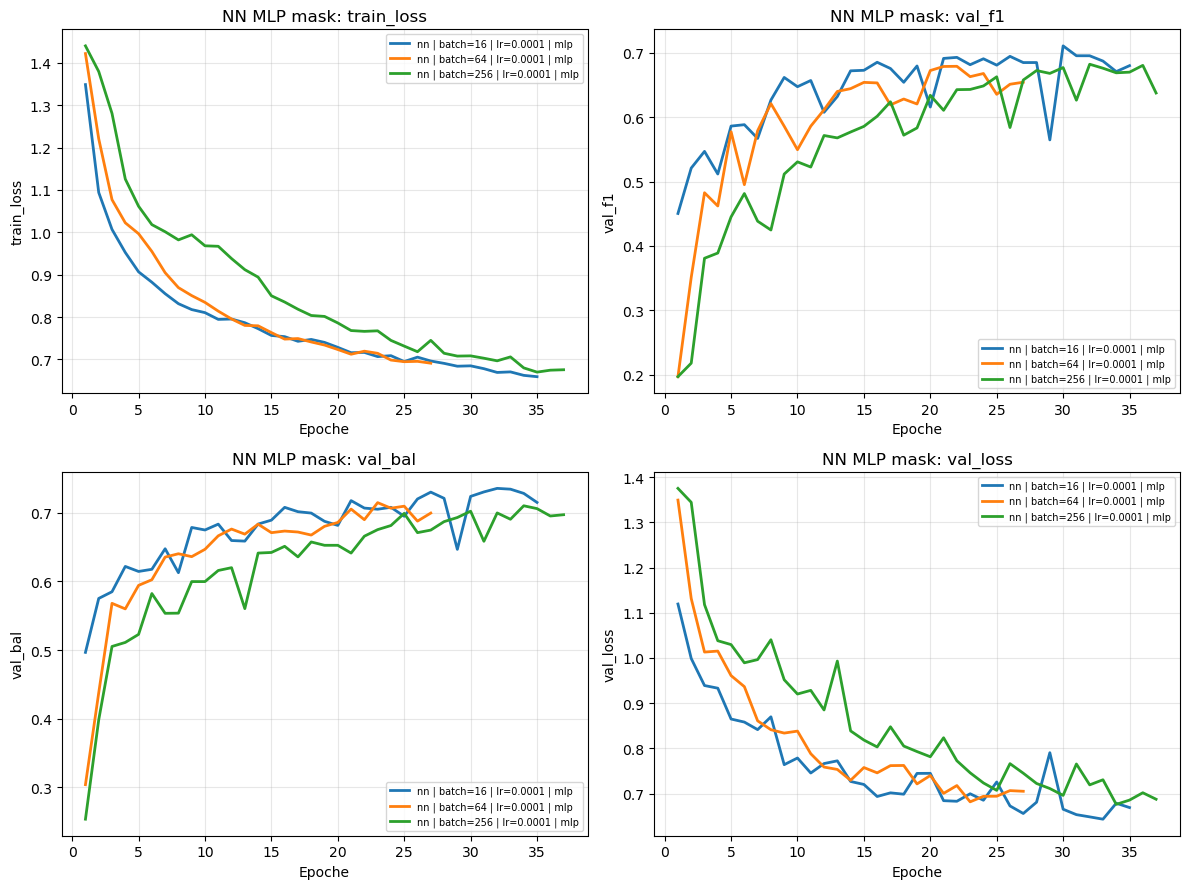


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.914)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.909)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.892)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.804)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.784)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.778)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.893)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.876)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.868)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.992)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.990)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.989)


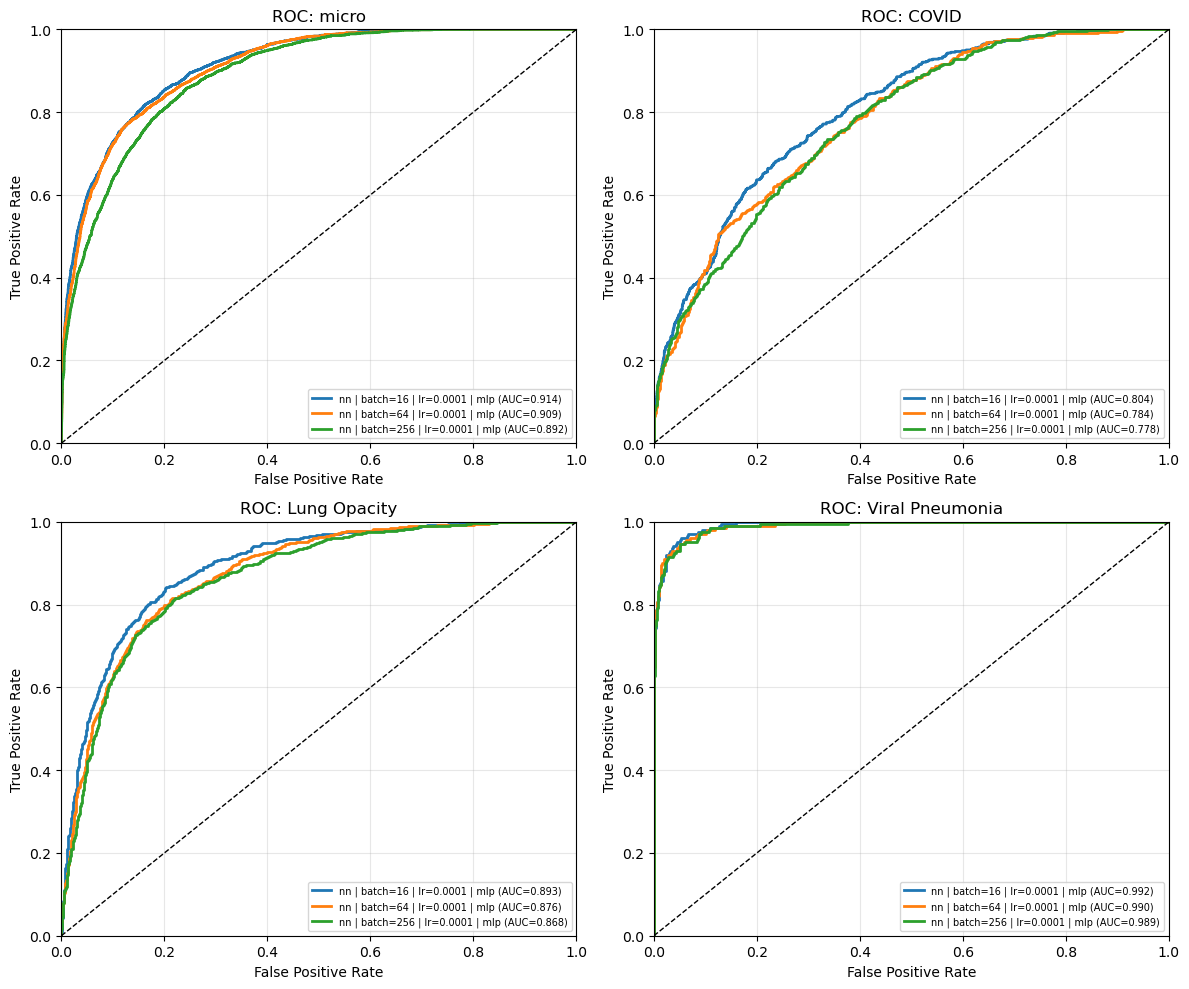

In [136]:
plot_train_overlays_grid(
    train_dirs_nnm_mask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN MLP mask"
)
plot_test_roc_overlays_grid(
    test_dirs_nnm_mask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [137]:
train_dirs_nnm_mask = []
test_dirs_nnm_mask  = []
for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=40,
        model_kind="nn_mlp"
    )
    train_dirs_nnm_mask += t
    test_dirs_nnm_mask  += tt



=== SWEEP RUN: model=nn_mlp | mode=mask | batch=64 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=64 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2826 | val_loss=1.0654 | val_f1=0.492 | val_bal=0.533 | 44.54s


Epoche 02: train_loss=1.0749 | val_loss=0.9749 | val_f1=0.510 | val_bal=0.565 | 44.33s


Epoche 03: train_loss=1.0239 | val_loss=1.0186 | val_f1=0.476 | val_bal=0.576 | 43.79s


Epoche 04: train_loss=0.9922 | val_loss=1.0114 | val_f1=0.456 | val_bal=0.569 | 43.23s


Epoche 05: train_loss=0.9396 | val_loss=0.8833 | val_f1=0.552 | val_bal=0.608 | 44.05s


Epoche 06: train_loss=0.8925 | val_loss=0.8426 | val_f1=0.561 | val_bal=0.642 | 44.38s


Epoche 07: train_loss=0.8662 | val_loss=0.8200 | val_f1=0.577 | val_bal=0.646 | 44.35s


Epoche 08: train_loss=0.8397 | val_loss=0.8189 | val_f1=0.583 | val_bal=0.635 | 44.47s


Epoche 09: train_loss=0.8389 | val_loss=0.8298 | val_f1=0.553 | val_bal=0.641 | 43.98s


Epoche 10: train_loss=0.7919 | val_loss=0.7759 | val_f1=0.623 | val_bal=0.664 | 43.90s


Epoche 11: train_loss=0.7897 | val_loss=0.7605 | val_f1=0.617 | val_bal=0.674 | 44.25s


Epoche 12: train_loss=0.7955 | val_loss=0.7684 | val_f1=0.640 | val_bal=0.662 | 43.95s


Epoche 13: train_loss=0.7667 | val_loss=0.7311 | val_f1=0.655 | val_bal=0.685 | 44.90s


Epoche 14: train_loss=0.7608 | val_loss=0.7559 | val_f1=0.610 | val_bal=0.673 | 44.19s


Epoche 15: train_loss=0.7514 | val_loss=0.7167 | val_f1=0.640 | val_bal=0.687 | 44.26s


Epoche 16: train_loss=0.7447 | val_loss=0.7085 | val_f1=0.677 | val_bal=0.695 | 43.69s


Epoche 17: train_loss=0.7341 | val_loss=0.7073 | val_f1=0.656 | val_bal=0.693 | 44.05s


Epoche 18: train_loss=0.7424 | val_loss=0.7816 | val_f1=0.553 | val_bal=0.647 | 44.21s


Epoche 19: train_loss=0.7236 | val_loss=0.7378 | val_f1=0.678 | val_bal=0.690 | 44.32s


Epoche 20: train_loss=0.7147 | val_loss=0.7067 | val_f1=0.668 | val_bal=0.696 | 43.36s


Epoche 21: train_loss=0.7194 | val_loss=0.7091 | val_f1=0.682 | val_bal=0.699 | 44.14s


Epoche 22: train_loss=0.7065 | val_loss=0.7246 | val_f1=0.638 | val_bal=0.685 | 44.59s


Epoche 23: train_loss=0.7052 | val_loss=0.6854 | val_f1=0.668 | val_bal=0.713 | 45.26s


Epoche 24: train_loss=0.6979 | val_loss=0.7064 | val_f1=0.627 | val_bal=0.699 | 43.55s


Epoche 25: train_loss=0.6968 | val_loss=0.6755 | val_f1=0.688 | val_bal=0.717 | 43.77s


Epoche 26: train_loss=0.6923 | val_loss=0.7233 | val_f1=0.625 | val_bal=0.693 | 44.75s


Epoche 27: train_loss=0.6833 | val_loss=0.6745 | val_f1=0.650 | val_bal=0.707 | 44.24s


Epoche 28: train_loss=0.6928 | val_loss=0.6957 | val_f1=0.677 | val_bal=0.701 | 44.15s


Epoche 29: train_loss=0.6880 | val_loss=0.6834 | val_f1=0.685 | val_bal=0.716 | 44.03s


Epoche 30: train_loss=0.6707 | val_loss=0.6673 | val_f1=0.701 | val_bal=0.729 | 43.91s


Epoche 31: train_loss=0.6774 | val_loss=0.6732 | val_f1=0.700 | val_bal=0.724 | 44.18s


Epoche 32: train_loss=0.6719 | val_loss=0.6752 | val_f1=0.654 | val_bal=0.716 | 44.91s


Epoche 33: train_loss=0.6668 | val_loss=0.6644 | val_f1=0.673 | val_bal=0.732 | 44.17s


Epoche 34: train_loss=0.6614 | val_loss=0.6573 | val_f1=0.680 | val_bal=0.724 | 44.19s


Epoche 35: train_loss=0.6622 | val_loss=0.6982 | val_f1=0.666 | val_bal=0.698 | 44.48s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0816_batch-64_lr-00001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=64
Pfad=nn_mlp_mask_2025_08_31_0816_batch-64_lr-00001.pt


[test] F1(macro)=0.678 | BalAcc=0.703 | Zeit=7.92s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0816_batch-64_lr-00001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0816_batch-64_lr-00001 | F1=0.678 | BalAcc=0.703

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4228 | val_loss=1.3725 | val_f1=0.257 | val_bal=0.355 | 44.97s


Epoche 02: train_loss=1.2921 | val_loss=1.0693 | val_f1=0.419 | val_bal=0.504 | 44.80s


Epoche 03: train_loss=1.0936 | val_loss=1.0145 | val_f1=0.483 | val_bal=0.543 | 44.13s


Epoche 04: train_loss=1.0410 | val_loss=0.9917 | val_f1=0.499 | val_bal=0.569 | 44.29s


Epoche 05: train_loss=1.0060 | val_loss=0.9425 | val_f1=0.534 | val_bal=0.589 | 44.74s


Epoche 06: train_loss=0.9654 | val_loss=0.9199 | val_f1=0.529 | val_bal=0.614 | 44.52s


Epoche 07: train_loss=0.9370 | val_loss=0.9336 | val_f1=0.502 | val_bal=0.603 | 44.92s


Epoche 08: train_loss=0.8921 | val_loss=0.9057 | val_f1=0.625 | val_bal=0.623 | 44.37s


Epoche 09: train_loss=0.8708 | val_loss=0.8120 | val_f1=0.594 | val_bal=0.648 | 44.64s


Epoche 10: train_loss=0.8314 | val_loss=0.8206 | val_f1=0.637 | val_bal=0.649 | 44.43s


Epoche 11: train_loss=0.8228 | val_loss=0.7545 | val_f1=0.628 | val_bal=0.673 | 44.70s


Epoche 12: train_loss=0.8080 | val_loss=0.8156 | val_f1=0.605 | val_bal=0.648 | 44.08s


Epoche 13: train_loss=0.7911 | val_loss=0.7468 | val_f1=0.634 | val_bal=0.680 | 43.72s


Epoche 14: train_loss=0.7837 | val_loss=0.7642 | val_f1=0.598 | val_bal=0.679 | 44.26s


Epoche 15: train_loss=0.7646 | val_loss=0.7294 | val_f1=0.642 | val_bal=0.695 | 44.56s


Epoche 16: train_loss=0.7591 | val_loss=0.7192 | val_f1=0.656 | val_bal=0.694 | 44.56s


Epoche 17: train_loss=0.7605 | val_loss=0.7491 | val_f1=0.597 | val_bal=0.684 | 44.81s


Epoche 18: train_loss=0.7377 | val_loss=0.7068 | val_f1=0.641 | val_bal=0.691 | 44.29s


Epoche 19: train_loss=0.7365 | val_loss=0.7136 | val_f1=0.658 | val_bal=0.709 | 44.26s


Epoche 20: train_loss=0.7323 | val_loss=0.6860 | val_f1=0.693 | val_bal=0.716 | 43.94s


Epoche 21: train_loss=0.7233 | val_loss=0.6965 | val_f1=0.666 | val_bal=0.706 | 44.68s


Epoche 22: train_loss=0.7192 | val_loss=0.6841 | val_f1=0.686 | val_bal=0.722 | 44.60s


Epoche 23: train_loss=0.7096 | val_loss=0.7499 | val_f1=0.585 | val_bal=0.670 | 44.54s


Epoche 24: train_loss=0.7129 | val_loss=0.6906 | val_f1=0.656 | val_bal=0.710 | 45.10s


Epoche 25: train_loss=0.7071 | val_loss=0.7152 | val_f1=0.653 | val_bal=0.682 | 44.25s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0843_batch-64_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=64
Pfad=nn_mlp_mask_2025_08_31_0843_batch-64_lr-0001.pt


[test] F1(macro)=0.662 | BalAcc=0.682 | Zeit=7.83s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0843_batch-64_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0843_batch-64_lr-0001 | F1=0.662 | BalAcc=0.682

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=64 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.2774 @idx=124 → vorgeschlagene LR=6.216e-04
[lr-finder] gewählte Start-LR: 6.216e-04

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=64 | LR=0.0006215732375564082 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4174 | val_loss=1.3761 | val_f1=0.192 | val_bal=0.308 | 44.91s


Epoche 02: train_loss=1.2426 | val_loss=1.1433 | val_f1=0.467 | val_bal=0.481 | 44.17s


Epoche 03: train_loss=1.0708 | val_loss=1.0478 | val_f1=0.457 | val_bal=0.510 | 43.74s


Epoche 04: train_loss=1.0112 | val_loss=1.0292 | val_f1=0.473 | val_bal=0.574 | 44.06s


Epoche 05: train_loss=0.9695 | val_loss=0.9546 | val_f1=0.572 | val_bal=0.583 | 43.96s


Epoche 06: train_loss=0.9419 | val_loss=0.9687 | val_f1=0.434 | val_bal=0.564 | 44.13s


Epoche 07: train_loss=0.9009 | val_loss=0.8752 | val_f1=0.516 | val_bal=0.605 | 43.77s


Epoche 08: train_loss=0.8737 | val_loss=0.8315 | val_f1=0.614 | val_bal=0.646 | 44.46s


Epoche 09: train_loss=0.8471 | val_loss=0.8022 | val_f1=0.612 | val_bal=0.654 | 44.73s


Epoche 10: train_loss=0.8179 | val_loss=0.8002 | val_f1=0.578 | val_bal=0.652 | 44.57s


Epoche 11: train_loss=0.8141 | val_loss=0.7618 | val_f1=0.604 | val_bal=0.664 | 43.84s


Epoche 12: train_loss=0.8106 | val_loss=0.7627 | val_f1=0.629 | val_bal=0.666 | 44.58s


Epoche 13: train_loss=0.7912 | val_loss=0.7379 | val_f1=0.654 | val_bal=0.683 | 45.00s


Epoche 14: train_loss=0.7778 | val_loss=0.7692 | val_f1=0.651 | val_bal=0.666 | 44.32s


Epoche 15: train_loss=0.7674 | val_loss=0.7453 | val_f1=0.639 | val_bal=0.680 | 44.09s


Epoche 16: train_loss=0.7642 | val_loss=0.7393 | val_f1=0.624 | val_bal=0.679 | 44.51s


Epoche 17: train_loss=0.7368 | val_loss=0.7301 | val_f1=0.645 | val_bal=0.684 | 44.26s


Epoche 18: train_loss=0.7497 | val_loss=0.7756 | val_f1=0.579 | val_bal=0.677 | 44.84s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0902_batch-64_lr-00006215732375564082
[TEST-START] Model=nn_mlp | Modus=mask | Batch=64
Pfad=nn_mlp_mask_2025_08_31_0902_batch-64_lr-00006215732375564082.pt


[test] F1(macro)=0.624 | BalAcc=0.661 | Zeit=7.96s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0902_batch-64_lr-00006215732375564082_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0902_batch-64_lr-00006215732375564082 | F1=0.624 | BalAcc=0.661

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=128 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3329 | val_loss=1.1267 | val_f1=0.441 | val_bal=0.534 | 45.67s


Epoche 02: train_loss=1.0973 | val_loss=1.0153 | val_f1=0.471 | val_bal=0.558 | 44.60s


Epoche 03: train_loss=1.0268 | val_loss=0.9777 | val_f1=0.510 | val_bal=0.570 | 44.75s


Epoche 04: train_loss=1.0043 | val_loss=0.9587 | val_f1=0.508 | val_bal=0.570 | 44.54s


Epoche 05: train_loss=0.9713 | val_loss=0.9213 | val_f1=0.560 | val_bal=0.598 | 43.78s


Epoche 06: train_loss=0.9230 | val_loss=0.9011 | val_f1=0.490 | val_bal=0.601 | 45.14s


Epoche 07: train_loss=0.9049 | val_loss=0.8580 | val_f1=0.524 | val_bal=0.606 | 44.27s


Epoche 08: train_loss=0.8503 | val_loss=0.8196 | val_f1=0.574 | val_bal=0.639 | 44.04s


Epoche 09: train_loss=0.8209 | val_loss=0.8049 | val_f1=0.564 | val_bal=0.639 | 44.56s


Epoche 10: train_loss=0.8272 | val_loss=0.7970 | val_f1=0.573 | val_bal=0.651 | 43.73s


Epoche 11: train_loss=0.8138 | val_loss=0.8479 | val_f1=0.633 | val_bal=0.642 | 44.13s


Epoche 12: train_loss=0.7923 | val_loss=0.7401 | val_f1=0.624 | val_bal=0.675 | 44.83s


Epoche 13: train_loss=0.7661 | val_loss=0.7768 | val_f1=0.601 | val_bal=0.652 | 44.43s


Epoche 14: train_loss=0.7679 | val_loss=0.7611 | val_f1=0.669 | val_bal=0.675 | 44.26s


Epoche 15: train_loss=0.7735 | val_loss=0.7185 | val_f1=0.629 | val_bal=0.682 | 44.07s


Epoche 16: train_loss=0.7563 | val_loss=0.7241 | val_f1=0.635 | val_bal=0.684 | 44.15s


Epoche 17: train_loss=0.7402 | val_loss=0.7129 | val_f1=0.679 | val_bal=0.694 | 44.27s


Epoche 18: train_loss=0.7293 | val_loss=0.8079 | val_f1=0.666 | val_bal=0.670 | 44.67s


Epoche 19: train_loss=0.7411 | val_loss=0.7092 | val_f1=0.672 | val_bal=0.693 | 43.88s


Epoche 20: train_loss=0.7259 | val_loss=0.7187 | val_f1=0.611 | val_bal=0.697 | 44.60s


Epoche 21: train_loss=0.7151 | val_loss=0.6999 | val_f1=0.638 | val_bal=0.697 | 44.36s


Epoche 22: train_loss=0.7117 | val_loss=0.6847 | val_f1=0.650 | val_bal=0.711 | 45.03s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0916_batch-128_lr-00001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=128
Pfad=nn_mlp_mask_2025_08_31_0916_batch-128_lr-00001.pt


[test] F1(macro)=0.667 | BalAcc=0.683 | Zeit=8.18s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0916_batch-128_lr-00001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0916_batch-128_lr-00001 | F1=0.667 | BalAcc=0.683

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=128 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4173 | val_loss=1.3595 | val_f1=0.286 | val_bal=0.407 | 45.38s


Epoche 02: train_loss=1.2888 | val_loss=1.2219 | val_f1=0.221 | val_bal=0.402 | 44.88s


Epoche 03: train_loss=1.1273 | val_loss=1.1363 | val_f1=0.445 | val_bal=0.471 | 44.38s


Epoche 04: train_loss=1.0846 | val_loss=1.0048 | val_f1=0.485 | val_bal=0.559 | 44.74s


Epoche 05: train_loss=1.0262 | val_loss=0.9824 | val_f1=0.534 | val_bal=0.571 | 43.96s


Epoche 06: train_loss=0.9970 | val_loss=0.9593 | val_f1=0.480 | val_bal=0.554 | 44.59s


Epoche 07: train_loss=0.9853 | val_loss=0.9507 | val_f1=0.488 | val_bal=0.590 | 44.43s


Epoche 08: train_loss=0.9380 | val_loss=0.9034 | val_f1=0.580 | val_bal=0.615 | 43.60s


Epoche 09: train_loss=0.9159 | val_loss=0.8831 | val_f1=0.555 | val_bal=0.612 | 44.65s


Epoche 10: train_loss=0.8936 | val_loss=0.8537 | val_f1=0.570 | val_bal=0.623 | 44.27s


Epoche 11: train_loss=0.8691 | val_loss=0.8323 | val_f1=0.613 | val_bal=0.638 | 44.55s


Epoche 12: train_loss=0.8468 | val_loss=0.8035 | val_f1=0.585 | val_bal=0.649 | 44.91s


Epoche 13: train_loss=0.8347 | val_loss=0.8194 | val_f1=0.622 | val_bal=0.649 | 44.21s


Epoche 14: train_loss=0.8148 | val_loss=0.8528 | val_f1=0.622 | val_bal=0.636 | 44.54s


Epoche 15: train_loss=0.8011 | val_loss=0.7967 | val_f1=0.588 | val_bal=0.646 | 44.44s


Epoche 16: train_loss=0.7870 | val_loss=0.8615 | val_f1=0.469 | val_bal=0.592 | 44.51s


Epoche 17: train_loss=0.7757 | val_loss=0.7414 | val_f1=0.626 | val_bal=0.684 | 44.78s


Epoche 18: train_loss=0.7657 | val_loss=0.7519 | val_f1=0.614 | val_bal=0.670 | 44.14s


Epoche 19: train_loss=0.7568 | val_loss=0.7369 | val_f1=0.619 | val_bal=0.673 | 44.23s


Epoche 20: train_loss=0.7361 | val_loss=0.7451 | val_f1=0.593 | val_bal=0.669 | 44.41s


Epoche 21: train_loss=0.7339 | val_loss=0.7187 | val_f1=0.648 | val_bal=0.689 | 44.09s


Epoche 22: train_loss=0.7306 | val_loss=0.7091 | val_f1=0.651 | val_bal=0.701 | 44.63s


Epoche 23: train_loss=0.7329 | val_loss=0.7110 | val_f1=0.664 | val_bal=0.698 | 44.43s


Epoche 24: train_loss=0.7154 | val_loss=0.7059 | val_f1=0.676 | val_bal=0.706 | 43.89s


Epoche 25: train_loss=0.7144 | val_loss=0.7030 | val_f1=0.683 | val_bal=0.699 | 44.26s


Epoche 26: train_loss=0.7120 | val_loss=0.6893 | val_f1=0.660 | val_bal=0.712 | 44.67s


Epoche 27: train_loss=0.7002 | val_loss=0.7490 | val_f1=0.646 | val_bal=0.669 | 44.43s


Epoche 28: train_loss=0.6956 | val_loss=0.7600 | val_f1=0.677 | val_bal=0.674 | 45.08s


Epoche 29: train_loss=0.6860 | val_loss=0.6880 | val_f1=0.652 | val_bal=0.712 | 44.54s


Epoche 30: train_loss=0.6886 | val_loss=0.6668 | val_f1=0.680 | val_bal=0.715 | 44.34s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0933_batch-128_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=128
Pfad=nn_mlp_mask_2025_08_31_0933_batch-128_lr-0001.pt


[test] F1(macro)=0.661 | BalAcc=0.681 | Zeit=8.19s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0933_batch-128_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0933_batch-128_lr-0001 | F1=0.661 | BalAcc=0.681

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.2358 @idx=104 → vorgeschlagene LR=2.463e-04
[lr-finder] gewählte Start-LR: 2.463e-04

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=128 | LR=0.00024631012065856703 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4096 | val_loss=1.3550 | val_f1=0.134 | val_bal=0.262 | 46.44s


Epoche 02: train_loss=1.2495 | val_loss=1.0728 | val_f1=0.417 | val_bal=0.498 | 44.87s


Epoche 03: train_loss=1.0659 | val_loss=1.0269 | val_f1=0.498 | val_bal=0.525 | 44.84s


Epoche 04: train_loss=1.0215 | val_loss=0.9653 | val_f1=0.493 | val_bal=0.580 | 44.62s


Epoche 05: train_loss=0.9879 | val_loss=1.0221 | val_f1=0.570 | val_bal=0.564 | 44.58s


Epoche 06: train_loss=0.9679 | val_loss=0.9184 | val_f1=0.576 | val_bal=0.600 | 44.52s


Epoche 07: train_loss=0.9149 | val_loss=0.8681 | val_f1=0.582 | val_bal=0.635 | 44.51s


Epoche 08: train_loss=0.8864 | val_loss=0.8205 | val_f1=0.593 | val_bal=0.646 | 44.27s


Epoche 09: train_loss=0.8675 | val_loss=0.8108 | val_f1=0.575 | val_bal=0.644 | 43.96s


Epoche 10: train_loss=0.8356 | val_loss=0.8072 | val_f1=0.626 | val_bal=0.659 | 44.59s


Epoche 11: train_loss=0.8088 | val_loss=0.8127 | val_f1=0.612 | val_bal=0.647 | 44.86s


Epoche 12: train_loss=0.8059 | val_loss=0.7774 | val_f1=0.583 | val_bal=0.658 | 44.70s


Epoche 13: train_loss=0.7788 | val_loss=0.7651 | val_f1=0.625 | val_bal=0.664 | 44.12s


Epoche 14: train_loss=0.7878 | val_loss=0.8028 | val_f1=0.648 | val_bal=0.656 | 44.05s


Epoche 15: train_loss=0.7556 | val_loss=0.7361 | val_f1=0.636 | val_bal=0.677 | 44.82s


Epoche 16: train_loss=0.7565 | val_loss=0.7765 | val_f1=0.663 | val_bal=0.669 | 44.71s


Epoche 17: train_loss=0.7538 | val_loss=0.7212 | val_f1=0.630 | val_bal=0.690 | 44.32s


Epoche 18: train_loss=0.7338 | val_loss=0.7155 | val_f1=0.624 | val_bal=0.682 | 43.57s


Epoche 19: train_loss=0.7365 | val_loss=0.7268 | val_f1=0.650 | val_bal=0.679 | 44.51s


Epoche 20: train_loss=0.7248 | val_loss=0.7940 | val_f1=0.564 | val_bal=0.633 | 43.70s


Epoche 21: train_loss=0.7174 | val_loss=0.7081 | val_f1=0.626 | val_bal=0.689 | 44.23s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0955_batch-128_lr-000024631012065856703
[TEST-START] Model=nn_mlp | Modus=mask | Batch=128
Pfad=nn_mlp_mask_2025_08_31_0955_batch-128_lr-000024631012065856703.pt


[test] F1(macro)=0.645 | BalAcc=0.652 | Zeit=8.11s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_0955_batch-128_lr-000024631012065856703_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_0955_batch-128_lr-000024631012065856703 | F1=0.645 | BalAcc=0.652

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=256 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3933 | val_loss=1.2995 | val_f1=0.411 | val_bal=0.434 | 44.82s


Epoche 02: train_loss=1.1915 | val_loss=1.2337 | val_f1=0.354 | val_bal=0.477 | 44.55s


Epoche 03: train_loss=1.0686 | val_loss=1.0476 | val_f1=0.528 | val_bal=0.539 | 45.24s


Epoche 04: train_loss=1.0292 | val_loss=0.9634 | val_f1=0.497 | val_bal=0.588 | 44.42s


Epoche 05: train_loss=0.9920 | val_loss=0.9504 | val_f1=0.528 | val_bal=0.582 | 44.69s


Epoche 06: train_loss=0.9925 | val_loss=0.9283 | val_f1=0.518 | val_bal=0.598 | 44.40s


Epoche 07: train_loss=0.9633 | val_loss=0.9149 | val_f1=0.525 | val_bal=0.602 | 43.99s


Epoche 08: train_loss=0.9443 | val_loss=0.9016 | val_f1=0.541 | val_bal=0.609 | 44.02s


Epoche 09: train_loss=0.9070 | val_loss=0.8802 | val_f1=0.520 | val_bal=0.604 | 44.11s


Epoche 10: train_loss=0.8821 | val_loss=0.8327 | val_f1=0.586 | val_bal=0.635 | 43.79s


Epoche 11: train_loss=0.8525 | val_loss=0.8412 | val_f1=0.583 | val_bal=0.629 | 43.48s


Epoche 12: train_loss=0.8379 | val_loss=0.8412 | val_f1=0.545 | val_bal=0.638 | 43.88s


Epoche 13: train_loss=0.8172 | val_loss=0.8225 | val_f1=0.570 | val_bal=0.658 | 44.44s


Epoche 14: train_loss=0.7949 | val_loss=0.7825 | val_f1=0.592 | val_bal=0.653 | 44.88s


Epoche 15: train_loss=0.8016 | val_loss=0.7545 | val_f1=0.623 | val_bal=0.667 | 44.49s


Epoche 16: train_loss=0.7732 | val_loss=0.7752 | val_f1=0.630 | val_bal=0.663 | 44.78s


Epoche 17: train_loss=0.7720 | val_loss=0.7838 | val_f1=0.572 | val_bal=0.660 | 44.02s


Epoche 18: train_loss=0.7564 | val_loss=0.8037 | val_f1=0.549 | val_bal=0.651 | 43.70s


Epoche 19: train_loss=0.7511 | val_loss=0.7361 | val_f1=0.649 | val_bal=0.681 | 43.83s


Epoche 20: train_loss=0.7418 | val_loss=0.7226 | val_f1=0.661 | val_bal=0.697 | 43.95s


Epoche 21: train_loss=0.7433 | val_loss=0.7920 | val_f1=0.665 | val_bal=0.656 | 44.62s


Epoche 22: train_loss=0.7280 | val_loss=0.7134 | val_f1=0.661 | val_bal=0.689 | 43.86s


Epoche 23: train_loss=0.7150 | val_loss=0.7073 | val_f1=0.644 | val_bal=0.697 | 44.14s


Epoche 24: train_loss=0.7203 | val_loss=0.7250 | val_f1=0.667 | val_bal=0.689 | 44.73s


Epoche 25: train_loss=0.7145 | val_loss=0.7294 | val_f1=0.667 | val_bal=0.685 | 44.78s


Epoche 26: train_loss=0.7037 | val_loss=0.7159 | val_f1=0.677 | val_bal=0.699 | 44.25s


Epoche 27: train_loss=0.7004 | val_loss=0.7170 | val_f1=0.666 | val_bal=0.686 | 44.32s


Epoche 28: train_loss=0.6850 | val_loss=0.6733 | val_f1=0.686 | val_bal=0.724 | 43.83s


Epoche 29: train_loss=0.6923 | val_loss=0.6999 | val_f1=0.683 | val_bal=0.701 | 43.46s


Epoche 30: train_loss=0.6874 | val_loss=0.6677 | val_f1=0.668 | val_bal=0.715 | 44.11s


Epoche 31: train_loss=0.6792 | val_loss=0.6840 | val_f1=0.645 | val_bal=0.707 | 44.72s


Epoche 32: train_loss=0.6830 | val_loss=0.6889 | val_f1=0.683 | val_bal=0.710 | 43.64s


Epoche 33: train_loss=0.6709 | val_loss=0.6595 | val_f1=0.702 | val_bal=0.730 | 44.03s


Epoche 34: train_loss=0.6652 | val_loss=0.6862 | val_f1=0.683 | val_bal=0.715 | 44.29s


Epoche 35: train_loss=0.6818 | val_loss=0.6994 | val_f1=0.619 | val_bal=0.702 | 43.84s


Epoche 36: train_loss=0.6674 | val_loss=0.6764 | val_f1=0.686 | val_bal=0.721 | 46.19s


Epoche 37: train_loss=0.6584 | val_loss=0.6917 | val_f1=0.639 | val_bal=0.704 | 43.64s


Epoche 38: train_loss=0.6684 | val_loss=0.6759 | val_f1=0.644 | val_bal=0.718 | 44.38s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_1013_batch-256_lr-00001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=256
Pfad=nn_mlp_mask_2025_08_31_1013_batch-256_lr-00001.pt


[test] F1(macro)=0.679 | BalAcc=0.709 | Zeit=8.49s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_1013_batch-256_lr-00001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_1013_batch-256_lr-00001 | F1=0.679 | BalAcc=0.709

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4691 | val_loss=1.3939 | val_f1=0.030 | val_bal=0.250 | 44.72s


Epoche 02: train_loss=1.3860 | val_loss=1.3758 | val_f1=0.214 | val_bal=0.385 | 45.12s


Epoche 03: train_loss=1.3749 | val_loss=1.3476 | val_f1=0.250 | val_bal=0.313 | 44.61s


Epoche 04: train_loss=1.3167 | val_loss=1.2117 | val_f1=0.271 | val_bal=0.408 | 44.48s


Epoche 05: train_loss=1.1742 | val_loss=1.0601 | val_f1=0.415 | val_bal=0.530 | 44.24s


Epoche 06: train_loss=1.0476 | val_loss=0.9850 | val_f1=0.496 | val_bal=0.574 | 44.92s


Epoche 07: train_loss=1.0308 | val_loss=1.0155 | val_f1=0.477 | val_bal=0.524 | 43.71s


Epoche 08: train_loss=1.0098 | val_loss=0.9966 | val_f1=0.525 | val_bal=0.561 | 43.85s


Epoche 09: train_loss=0.9939 | val_loss=0.9890 | val_f1=0.483 | val_bal=0.584 | 43.46s


Epoche 10: train_loss=0.9786 | val_loss=0.9658 | val_f1=0.491 | val_bal=0.573 | 44.89s


Epoche 11: train_loss=0.9654 | val_loss=0.9671 | val_f1=0.563 | val_bal=0.582 | 44.15s


Epoche 12: train_loss=0.9799 | val_loss=0.9175 | val_f1=0.529 | val_bal=0.608 | 44.46s


Epoche 13: train_loss=0.9407 | val_loss=0.9702 | val_f1=0.498 | val_bal=0.594 | 44.41s


Epoche 14: train_loss=0.9190 | val_loss=0.8761 | val_f1=0.555 | val_bal=0.625 | 44.52s


Epoche 15: train_loss=0.8818 | val_loss=0.8525 | val_f1=0.570 | val_bal=0.641 | 44.30s


Epoche 16: train_loss=0.8642 | val_loss=0.8550 | val_f1=0.522 | val_bal=0.603 | 44.12s


Epoche 17: train_loss=0.8384 | val_loss=0.8453 | val_f1=0.587 | val_bal=0.628 | 44.63s


Epoche 18: train_loss=0.8343 | val_loss=0.8062 | val_f1=0.582 | val_bal=0.642 | 44.85s


Epoche 19: train_loss=0.8033 | val_loss=0.7863 | val_f1=0.610 | val_bal=0.656 | 44.34s


Epoche 20: train_loss=0.8051 | val_loss=0.7925 | val_f1=0.582 | val_bal=0.654 | 44.35s


Epoche 21: train_loss=0.7920 | val_loss=0.7658 | val_f1=0.628 | val_bal=0.660 | 45.42s


Epoche 22: train_loss=0.7765 | val_loss=0.7773 | val_f1=0.597 | val_bal=0.662 | 44.36s


Epoche 23: train_loss=0.7670 | val_loss=0.8227 | val_f1=0.549 | val_bal=0.637 | 44.58s


Epoche 24: train_loss=0.7630 | val_loss=0.7454 | val_f1=0.643 | val_bal=0.688 | 44.18s


Epoche 25: train_loss=0.7609 | val_loss=0.7524 | val_f1=0.611 | val_bal=0.669 | 43.97s


Epoche 26: train_loss=0.7444 | val_loss=0.7306 | val_f1=0.642 | val_bal=0.688 | 43.64s


Epoche 27: train_loss=0.7355 | val_loss=0.7165 | val_f1=0.648 | val_bal=0.690 | 43.66s


Epoche 28: train_loss=0.7407 | val_loss=0.7230 | val_f1=0.639 | val_bal=0.678 | 43.46s


Epoche 29: train_loss=0.7088 | val_loss=0.7566 | val_f1=0.611 | val_bal=0.684 | 43.95s


Epoche 30: train_loss=0.7167 | val_loss=0.6956 | val_f1=0.648 | val_bal=0.695 | 44.17s


Epoche 31: train_loss=0.7384 | val_loss=0.7561 | val_f1=0.593 | val_bal=0.668 | 44.27s


Epoche 32: train_loss=0.7131 | val_loss=0.7082 | val_f1=0.648 | val_bal=0.695 | 43.88s


Epoche 33: train_loss=0.6992 | val_loss=0.6935 | val_f1=0.640 | val_bal=0.699 | 44.45s


Epoche 34: train_loss=0.6969 | val_loss=0.6874 | val_f1=0.639 | val_bal=0.704 | 44.44s


Epoche 35: train_loss=0.6875 | val_loss=0.7079 | val_f1=0.684 | val_bal=0.700 | 44.52s


Epoche 36: train_loss=0.6943 | val_loss=0.6813 | val_f1=0.706 | val_bal=0.721 | 43.58s


Epoche 37: train_loss=0.6868 | val_loss=0.6893 | val_f1=0.644 | val_bal=0.705 | 44.10s


Epoche 38: train_loss=0.6822 | val_loss=0.6803 | val_f1=0.657 | val_bal=0.710 | 43.73s


Epoche 39: train_loss=0.6784 | val_loss=0.7071 | val_f1=0.685 | val_bal=0.698 | 43.87s


Epoche 40: train_loss=0.6637 | val_loss=0.6810 | val_f1=0.671 | val_bal=0.722 | 44.70s
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_1041_batch-256_lr-0001
[TEST-START] Model=nn_mlp | Modus=mask | Batch=256
Pfad=nn_mlp_mask_2025_08_31_1041_batch-256_lr-0001.pt


[test] F1(macro)=0.679 | BalAcc=0.695 | Zeit=8.15s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_1041_batch-256_lr-0001_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_1041_batch-256_lr-0001 | F1=0.679 | BalAcc=0.695

=== SWEEP RUN: model=nn_mlp | mode=mask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1649 @idx=128 → vorgeschlagene LR=7.480e-04
[lr-finder] gewählte Start-LR: 7.480e-04

[TRAIN-START] Model=nn_mlp | Modus=mask | Batch=256 | LR=0.0007479874604957664 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.4239 | val_loss=1.3665 | val_f1=0.236 | val_bal=0.332 | 46.96s


Epoche 02: train_loss=1.3624 | val_loss=1.3119 | val_f1=0.286 | val_bal=0.380 | 43.76s


Epoche 03: train_loss=1.2119 | val_loss=1.0714 | val_f1=0.373 | val_bal=0.482 | 45.00s


Epoche 04: train_loss=1.1098 | val_loss=1.0134 | val_f1=0.444 | val_bal=0.539 | 45.01s


Epoche 05: train_loss=1.0603 | val_loss=1.0323 | val_f1=0.512 | val_bal=0.546 | 44.23s


Epoche 06: train_loss=1.0284 | val_loss=0.9802 | val_f1=0.516 | val_bal=0.575 | 44.28s


Epoche 07: train_loss=1.0132 | val_loss=0.9689 | val_f1=0.493 | val_bal=0.590 | 44.25s


Epoche 08: train_loss=0.9955 | val_loss=0.9724 | val_f1=0.521 | val_bal=0.576 | 43.74s


Epoche 09: train_loss=0.9657 | val_loss=0.9282 | val_f1=0.541 | val_bal=0.597 | 43.58s


Epoche 10: train_loss=0.9453 | val_loss=0.9420 | val_f1=0.498 | val_bal=0.597 | 43.68s


Epoche 11: train_loss=0.9238 | val_loss=0.9060 | val_f1=0.524 | val_bal=0.603 | 44.38s


Epoche 12: train_loss=0.9022 | val_loss=0.8653 | val_f1=0.578 | val_bal=0.628 | 43.31s


Epoche 13: train_loss=0.8782 | val_loss=0.8833 | val_f1=0.605 | val_bal=0.612 | 43.74s


Epoche 14: train_loss=0.8634 | val_loss=0.8596 | val_f1=0.537 | val_bal=0.634 | 43.53s


Epoche 15: train_loss=0.8404 | val_loss=0.8013 | val_f1=0.590 | val_bal=0.653 | 44.91s


Epoche 16: train_loss=0.8224 | val_loss=0.8049 | val_f1=0.601 | val_bal=0.657 | 44.09s


Epoche 17: train_loss=0.8046 | val_loss=0.7801 | val_f1=0.620 | val_bal=0.656 | 43.97s


Epoche 18: train_loss=0.7894 | val_loss=0.7619 | val_f1=0.625 | val_bal=0.667 | 43.70s


Epoche 19: train_loss=0.7681 | val_loss=0.7799 | val_f1=0.647 | val_bal=0.656 | 44.12s


Epoche 20: train_loss=0.7721 | val_loss=0.7537 | val_f1=0.612 | val_bal=0.676 | 43.93s


Epoche 21: train_loss=0.7585 | val_loss=0.7215 | val_f1=0.662 | val_bal=0.692 | 43.83s


Epoche 22: train_loss=0.7487 | val_loss=0.7300 | val_f1=0.625 | val_bal=0.690 | 44.04s


Epoche 23: train_loss=0.7417 | val_loss=0.7233 | val_f1=0.632 | val_bal=0.684 | 43.83s


Epoche 24: train_loss=0.7342 | val_loss=0.7220 | val_f1=0.627 | val_bal=0.685 | 43.50s


Epoche 25: train_loss=0.7336 | val_loss=0.7171 | val_f1=0.649 | val_bal=0.687 | 44.02s


Epoche 26: train_loss=0.7183 | val_loss=0.7347 | val_f1=0.669 | val_bal=0.683 | 44.24s


Epoche 27: train_loss=0.7283 | val_loss=0.7016 | val_f1=0.682 | val_bal=0.711 | 44.36s


Epoche 28: train_loss=0.7252 | val_loss=0.7088 | val_f1=0.653 | val_bal=0.697 | 44.38s


Epoche 29: train_loss=0.7143 | val_loss=0.7152 | val_f1=0.655 | val_bal=0.694 | 43.85s


Epoche 30: train_loss=0.6938 | val_loss=0.6810 | val_f1=0.677 | val_bal=0.708 | 44.22s


Epoche 31: train_loss=0.6901 | val_loss=0.6958 | val_f1=0.687 | val_bal=0.705 | 43.83s


Epoche 32: train_loss=0.6887 | val_loss=0.7274 | val_f1=0.636 | val_bal=0.674 | 43.84s


Epoche 33: train_loss=0.6825 | val_loss=0.6813 | val_f1=0.691 | val_bal=0.713 | 44.41s


Epoche 34: train_loss=0.6960 | val_loss=0.6777 | val_f1=0.659 | val_bal=0.715 | 44.34s


Epoche 35: train_loss=0.6827 | val_loss=0.7418 | val_f1=0.692 | val_bal=0.685 | 44.01s


Epoche 36: train_loss=0.6827 | val_loss=0.6677 | val_f1=0.692 | val_bal=0.724 | 43.62s


Epoche 37: train_loss=0.6660 | val_loss=0.6799 | val_f1=0.691 | val_bal=0.717 | 44.11s


Epoche 38: train_loss=0.6533 | val_loss=0.7011 | val_f1=0.627 | val_bal=0.693 | 44.77s


Epoche 39: train_loss=0.6645 | val_loss=0.6988 | val_f1=0.646 | val_bal=0.701 | 44.72s


Epoche 40: train_loss=0.6717 | val_loss=0.6781 | val_f1=0.673 | val_bal=0.718 | 43.87s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_1111_batch-256_lr-00007479874604957664
[TEST-START] Model=nn_mlp | Modus=mask | Batch=256
Pfad=nn_mlp_mask_2025_08_31_1111_batch-256_lr-00007479874604957664.pt


[test] F1(macro)=0.685 | BalAcc=0.680 | Zeit=7.95s | /home/lupan001/ML/results/nn_mlp_mask_2025_08_31_1111_batch-256_lr-00007479874604957664_test
[SWEEP] Modell=nn_mlp_mask_2025_08_31_1111_batch-256_lr-00007479874604957664 | F1=0.685 | BalAcc=0.680



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=128 | lr=0.0001 | mlp | train_loss max=1.4173
nn | batch=128 | lr=1e-05 | mlp | train_loss max=1.3329
nn | batch=128 | lr=2.463e-05 | mlp | train_loss max=1.4096
nn | batch=256 | lr=0.0001 | mlp | train_loss max=1.4691
nn | batch=256 | lr=1e-05 | mlp | train_loss max=1.3933
nn | batch=256 | lr=7.48e-05 | mlp | train_loss max=1.4239
nn | batch=64 | lr=0.0001 | mlp | train_loss max=1.4228
nn | batch=64 | lr=1e-05 | mlp | train_loss max=1.2826
nn | batch=64 | lr=6.216e-05 | mlp | train_loss max=1.4174

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=128 | lr=0.0001 | mlp | val_f1 max=0.6832
nn | batch=128 | lr=1e-05 | mlp | val_f1 max=0.6794
nn | batch=128 | lr=2.463e-05 | mlp | val_f1 max=0.6635
nn | batch=256 | lr=0.0001 | mlp | val_f1 max=0.7056
nn | batch=256 | lr=1e-05 | mlp | val_f1 max=0.7018
nn | batch=256 | lr=7.48e-05 | mlp | val_f1 max=0.6922
nn | batch=64 | lr=0.0001 | mlp | val_f1 max=0.6931
nn | batch=64 | lr=1e-05 | m

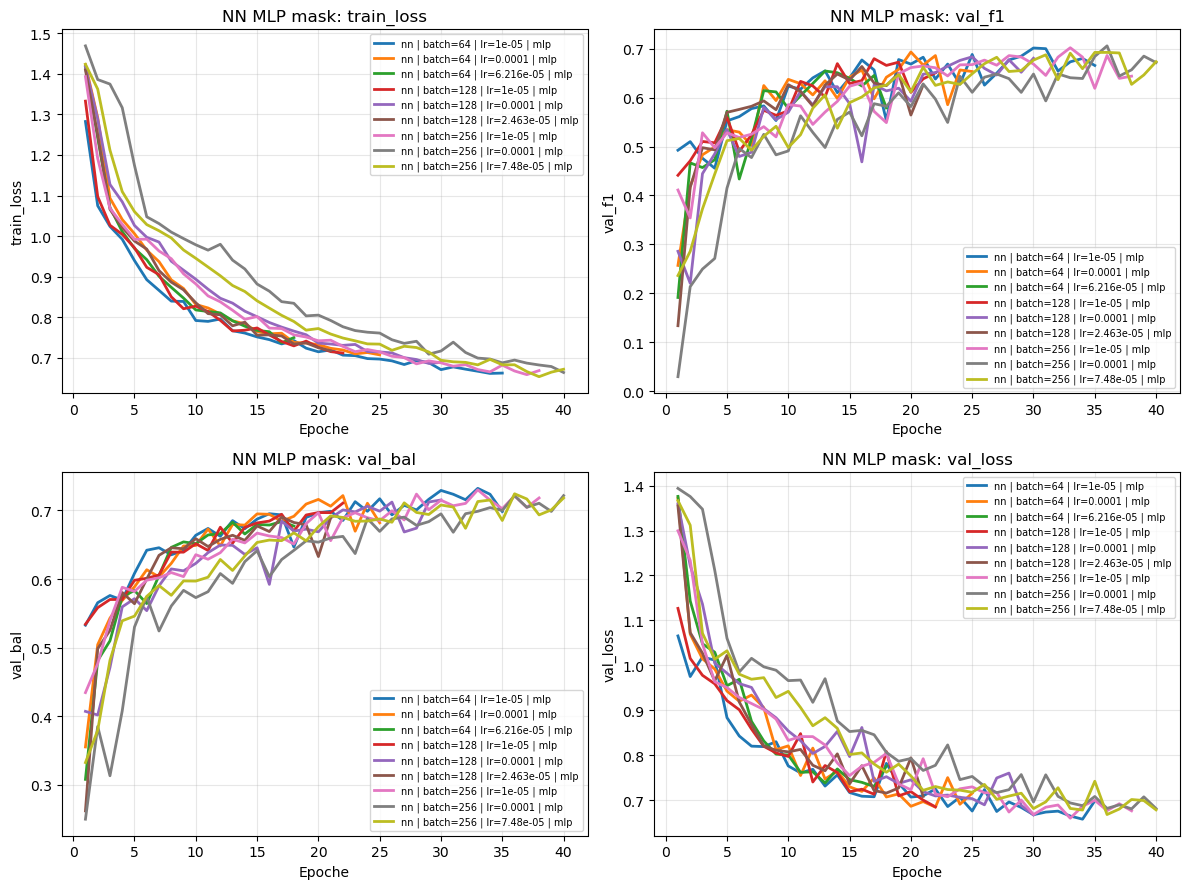


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=64 | lr=1e-05 | mlp (AUC=0.895)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.894)
nn | batch=64 | lr=6.216e-05 | mlp (AUC=0.882)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.898)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.901)
nn | batch=128 | lr=2.463e-05 | mlp (AUC=0.882)
nn | batch=256 | lr=1e-05 | mlp (AUC=0.901)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.902)
nn | batch=256 | lr=7.48e-05 | mlp (AUC=0.912)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=64 | lr=1e-05 | mlp (AUC=0.793)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.781)
nn | batch=64 | lr=6.216e-05 | mlp (AUC=0.750)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.766)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.777)
nn | batch=128 | lr=2.463e-05 | mlp (AUC=0.758)
nn | batch=256 | lr=1e-05 | mlp (AUC=0.789)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.777)
nn | batch=256 | lr=7.48e-05 | mlp (AUC=0.790)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=64 | lr=1e-05 | mlp (AUC=0.876)
nn | batch=64 | lr=0.0001

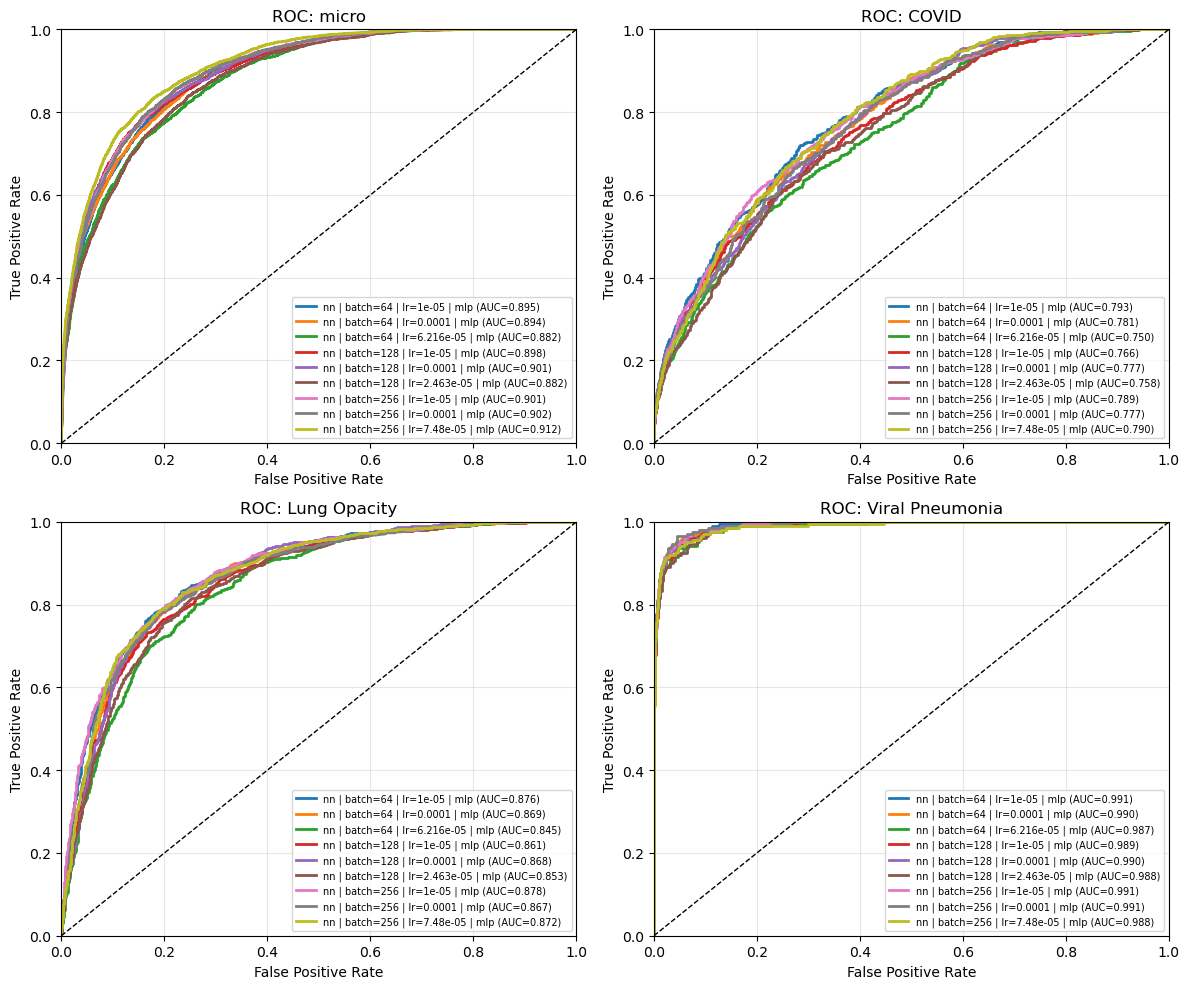

In [138]:
plot_train_overlays_grid(
    train_dirs_nnm_mask,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN MLP mask"
)
plot_test_roc_overlays_grid(
    test_dirs_nnm_mask,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [139]:
train_dirs_nnm_nomask_batch, test_dirs_nnm_nomask_batch = run_sweep_train_test(
    "nomask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=40,
    model_kind="nn_mlp"
)



=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=16 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8395 | val_loss=0.7484 | val_f1=0.709 | val_bal=0.713 | 28.11s


Epoche 02: train_loss=0.6818 | val_loss=0.6392 | val_f1=0.743 | val_bal=0.746 | 27.95s


Epoche 03: train_loss=0.6241 | val_loss=0.5627 | val_f1=0.717 | val_bal=0.788 | 27.72s


Epoche 04: train_loss=0.5851 | val_loss=0.5439 | val_f1=0.725 | val_bal=0.785 | 27.66s


Epoche 05: train_loss=0.5598 | val_loss=0.5289 | val_f1=0.756 | val_bal=0.794 | 27.80s


Epoche 06: train_loss=0.5429 | val_loss=0.5926 | val_f1=0.746 | val_bal=0.763 | 27.78s


Epoche 07: train_loss=0.5244 | val_loss=0.5551 | val_f1=0.755 | val_bal=0.779 | 28.06s


Epoche 08: train_loss=0.5096 | val_loss=0.5017 | val_f1=0.810 | val_bal=0.809 | 27.74s


Epoche 09: train_loss=0.5007 | val_loss=0.5145 | val_f1=0.802 | val_bal=0.802 | 27.81s


Epoche 10: train_loss=0.4863 | val_loss=0.5119 | val_f1=0.808 | val_bal=0.801 | 27.75s


Epoche 11: train_loss=0.4749 | val_loss=0.4630 | val_f1=0.804 | val_bal=0.819 | 28.01s


Epoche 12: train_loss=0.4680 | val_loss=0.4659 | val_f1=0.781 | val_bal=0.823 | 28.07s


Epoche 13: train_loss=0.4684 | val_loss=0.4570 | val_f1=0.805 | val_bal=0.821 | 27.91s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1143_batch-16_lr-0001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=16
Pfad=nn_mlp_nomask_2025_08_31_1143_batch-16_lr-0001.pt


[test] F1(macro)=0.809 | BalAcc=0.818 | Zeit=5.00s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1143_batch-16_lr-0001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1143_batch-16_lr-0001 | F1=0.809 | BalAcc=0.818

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8427 | val_loss=0.7118 | val_f1=0.635 | val_bal=0.691 | 29.22s


Epoche 02: train_loss=0.6895 | val_loss=0.6319 | val_f1=0.751 | val_bal=0.751 | 29.09s


Epoche 03: train_loss=0.6175 | val_loss=0.5937 | val_f1=0.762 | val_bal=0.768 | 28.76s


Epoche 04: train_loss=0.5784 | val_loss=0.5143 | val_f1=0.763 | val_bal=0.795 | 28.91s


Epoche 05: train_loss=0.5507 | val_loss=0.5318 | val_f1=0.785 | val_bal=0.803 | 28.80s


Epoche 06: train_loss=0.5307 | val_loss=0.5340 | val_f1=0.787 | val_bal=0.786 | 28.62s


Epoche 07: train_loss=0.5140 | val_loss=0.4934 | val_f1=0.788 | val_bal=0.811 | 28.67s


Epoche 08: train_loss=0.4960 | val_loss=0.5028 | val_f1=0.792 | val_bal=0.805 | 28.69s


Epoche 09: train_loss=0.4859 | val_loss=0.4754 | val_f1=0.816 | val_bal=0.817 | 28.74s


Epoche 10: train_loss=0.4781 | val_loss=0.5113 | val_f1=0.797 | val_bal=0.799 | 28.78s


Epoche 11: train_loss=0.4639 | val_loss=0.5331 | val_f1=0.812 | val_bal=0.799 | 28.78s


Epoche 12: train_loss=0.4561 | val_loss=0.4647 | val_f1=0.824 | val_bal=0.822 | 28.54s


Epoche 13: train_loss=0.4424 | val_loss=0.4348 | val_f1=0.825 | val_bal=0.841 | 28.90s


Epoche 14: train_loss=0.4383 | val_loss=0.4651 | val_f1=0.824 | val_bal=0.825 | 28.71s


Epoche 15: train_loss=0.4318 | val_loss=0.4421 | val_f1=0.827 | val_bal=0.829 | 28.65s


Epoche 16: train_loss=0.4312 | val_loss=0.4295 | val_f1=0.801 | val_bal=0.841 | 29.07s


Epoche 17: train_loss=0.4179 | val_loss=0.4344 | val_f1=0.826 | val_bal=0.838 | 28.99s


Epoche 18: train_loss=0.4084 | val_loss=0.4326 | val_f1=0.834 | val_bal=0.843 | 28.98s


Epoche 19: train_loss=0.4088 | val_loss=0.4305 | val_f1=0.819 | val_bal=0.838 | 29.02s


Epoche 20: train_loss=0.4044 | val_loss=0.3954 | val_f1=0.829 | val_bal=0.853 | 28.96s


Epoche 21: train_loss=0.3962 | val_loss=0.4204 | val_f1=0.841 | val_bal=0.848 | 28.96s


Epoche 22: train_loss=0.3882 | val_loss=0.4267 | val_f1=0.835 | val_bal=0.844 | 28.98s


Epoche 23: train_loss=0.3778 | val_loss=0.3815 | val_f1=0.836 | val_bal=0.856 | 28.81s


Epoche 24: train_loss=0.3809 | val_loss=0.4222 | val_f1=0.812 | val_bal=0.844 | 28.79s


Epoche 25: train_loss=0.3737 | val_loss=0.4055 | val_f1=0.836 | val_bal=0.849 | 28.52s


Epoche 26: train_loss=0.3735 | val_loss=0.4010 | val_f1=0.840 | val_bal=0.857 | 28.79s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1150_batch-64_lr-0001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=64
Pfad=nn_mlp_nomask_2025_08_31_1150_batch-64_lr-0001.pt


[test] F1(macro)=0.827 | BalAcc=0.845 | Zeit=5.28s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1150_batch-64_lr-0001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1150_batch-64_lr-0001 | F1=0.827 | BalAcc=0.845

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.9230 | val_loss=0.8090 | val_f1=0.568 | val_bal=0.638 | 29.37s


Epoche 02: train_loss=0.7748 | val_loss=0.7296 | val_f1=0.651 | val_bal=0.693 | 28.24s


Epoche 03: train_loss=0.7141 | val_loss=0.6771 | val_f1=0.653 | val_bal=0.710 | 27.93s


Epoche 04: train_loss=0.6572 | val_loss=0.6942 | val_f1=0.729 | val_bal=0.717 | 28.19s


Epoche 05: train_loss=0.6205 | val_loss=0.5921 | val_f1=0.737 | val_bal=0.761 | 28.27s


Epoche 06: train_loss=0.5892 | val_loss=0.5377 | val_f1=0.735 | val_bal=0.791 | 28.67s


Epoche 07: train_loss=0.5498 | val_loss=0.5832 | val_f1=0.762 | val_bal=0.763 | 28.00s


Epoche 08: train_loss=0.5433 | val_loss=0.5272 | val_f1=0.758 | val_bal=0.793 | 28.68s


Epoche 09: train_loss=0.5201 | val_loss=0.5386 | val_f1=0.776 | val_bal=0.779 | 28.72s


Epoche 10: train_loss=0.5075 | val_loss=0.5113 | val_f1=0.770 | val_bal=0.795 | 27.80s


Epoche 11: train_loss=0.4880 | val_loss=0.4574 | val_f1=0.805 | val_bal=0.825 | 28.20s


Epoche 12: train_loss=0.4786 | val_loss=0.4782 | val_f1=0.802 | val_bal=0.819 | 28.15s


Epoche 13: train_loss=0.4844 | val_loss=0.4715 | val_f1=0.775 | val_bal=0.815 | 28.23s


Epoche 14: train_loss=0.4567 | val_loss=0.4916 | val_f1=0.768 | val_bal=0.800 | 28.42s


Epoche 15: train_loss=0.4575 | val_loss=0.4649 | val_f1=0.809 | val_bal=0.825 | 27.63s


Epoche 16: train_loss=0.4512 | val_loss=0.4610 | val_f1=0.814 | val_bal=0.818 | 27.90s


Epoche 17: train_loss=0.4408 | val_loss=0.4309 | val_f1=0.819 | val_bal=0.832 | 27.71s


Epoche 18: train_loss=0.4308 | val_loss=0.4287 | val_f1=0.796 | val_bal=0.833 | 28.03s


Epoche 19: train_loss=0.4243 | val_loss=0.4298 | val_f1=0.812 | val_bal=0.834 | 27.94s


Epoche 20: train_loss=0.4172 | val_loss=0.4366 | val_f1=0.813 | val_bal=0.833 | 27.80s


Epoche 21: train_loss=0.4063 | val_loss=0.4244 | val_f1=0.795 | val_bal=0.831 | 28.06s


Epoche 22: train_loss=0.4032 | val_loss=0.4045 | val_f1=0.829 | val_bal=0.847 | 27.92s


Epoche 23: train_loss=0.3992 | val_loss=0.4540 | val_f1=0.823 | val_bal=0.831 | 27.47s


Epoche 24: train_loss=0.3960 | val_loss=0.4132 | val_f1=0.807 | val_bal=0.841 | 27.65s


Epoche 25: train_loss=0.3857 | val_loss=0.4116 | val_f1=0.837 | val_bal=0.844 | 27.90s


Epoche 26: train_loss=0.3797 | val_loss=0.4095 | val_f1=0.820 | val_bal=0.848 | 27.91s


Epoche 27: train_loss=0.3815 | val_loss=0.3955 | val_f1=0.825 | val_bal=0.852 | 28.19s


Epoche 28: train_loss=0.3666 | val_loss=0.3931 | val_f1=0.828 | val_bal=0.850 | 27.94s


Epoche 29: train_loss=0.3717 | val_loss=0.3829 | val_f1=0.837 | val_bal=0.859 | 28.01s


Epoche 30: train_loss=0.3681 | val_loss=0.3878 | val_f1=0.826 | val_bal=0.858 | 27.76s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1203_batch-256_lr-0001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=256
Pfad=nn_mlp_nomask_2025_08_31_1203_batch-256_lr-0001.pt


[test] F1(macro)=0.823 | BalAcc=0.843 | Zeit=5.23s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1203_batch-256_lr-0001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1203_batch-256_lr-0001 | F1=0.823 | BalAcc=0.843



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=16 | lr=0.0001 | mlp | train_loss max=0.8395
nn | batch=256 | lr=0.0001 | mlp | train_loss max=0.9230
nn | batch=64 | lr=0.0001 | mlp | train_loss max=0.8427

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=16 | lr=0.0001 | mlp | val_f1 max=0.8101
nn | batch=256 | lr=0.0001 | mlp | val_f1 max=0.8374
nn | batch=64 | lr=0.0001 | mlp | val_f1 max=0.8406

=== MODELLVERGLEICH (Train val_bal) ===
nn | batch=16 | lr=0.0001 | mlp | val_bal max=0.8230
nn | batch=256 | lr=0.0001 | mlp | val_bal max=0.8588
nn | batch=64 | lr=0.0001 | mlp | val_bal max=0.8573

=== MODELLVERGLEICH (Train val_loss) ===
nn | batch=16 | lr=0.0001 | mlp | val_loss max=0.7484
nn | batch=256 | lr=0.0001 | mlp | val_loss max=0.8090
nn | batch=64 | lr=0.0001 | mlp | val_loss max=0.7118


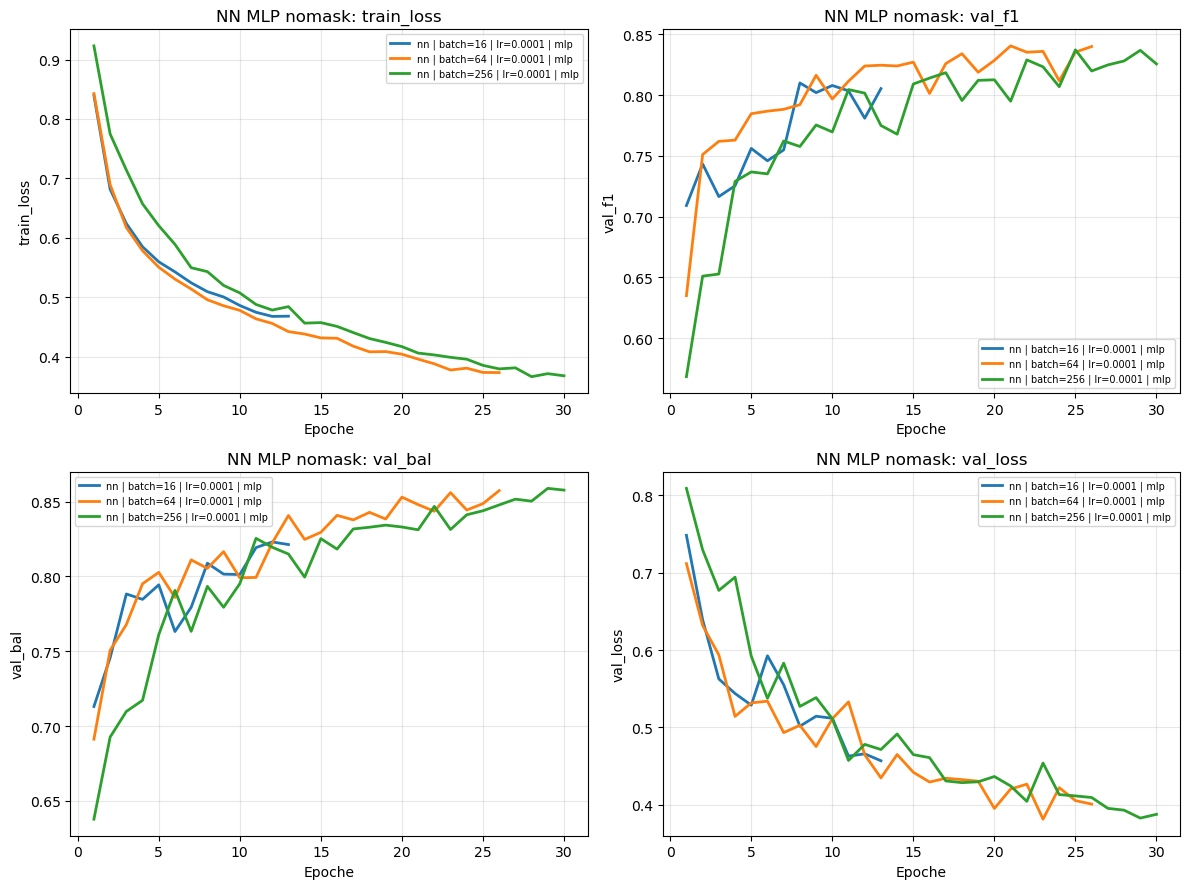


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.956)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.964)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.964)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.927)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.954)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.950)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.928)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.936)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.936)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
nn | batch=16 | lr=0.0001 | mlp (AUC=0.996)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.995)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.996)


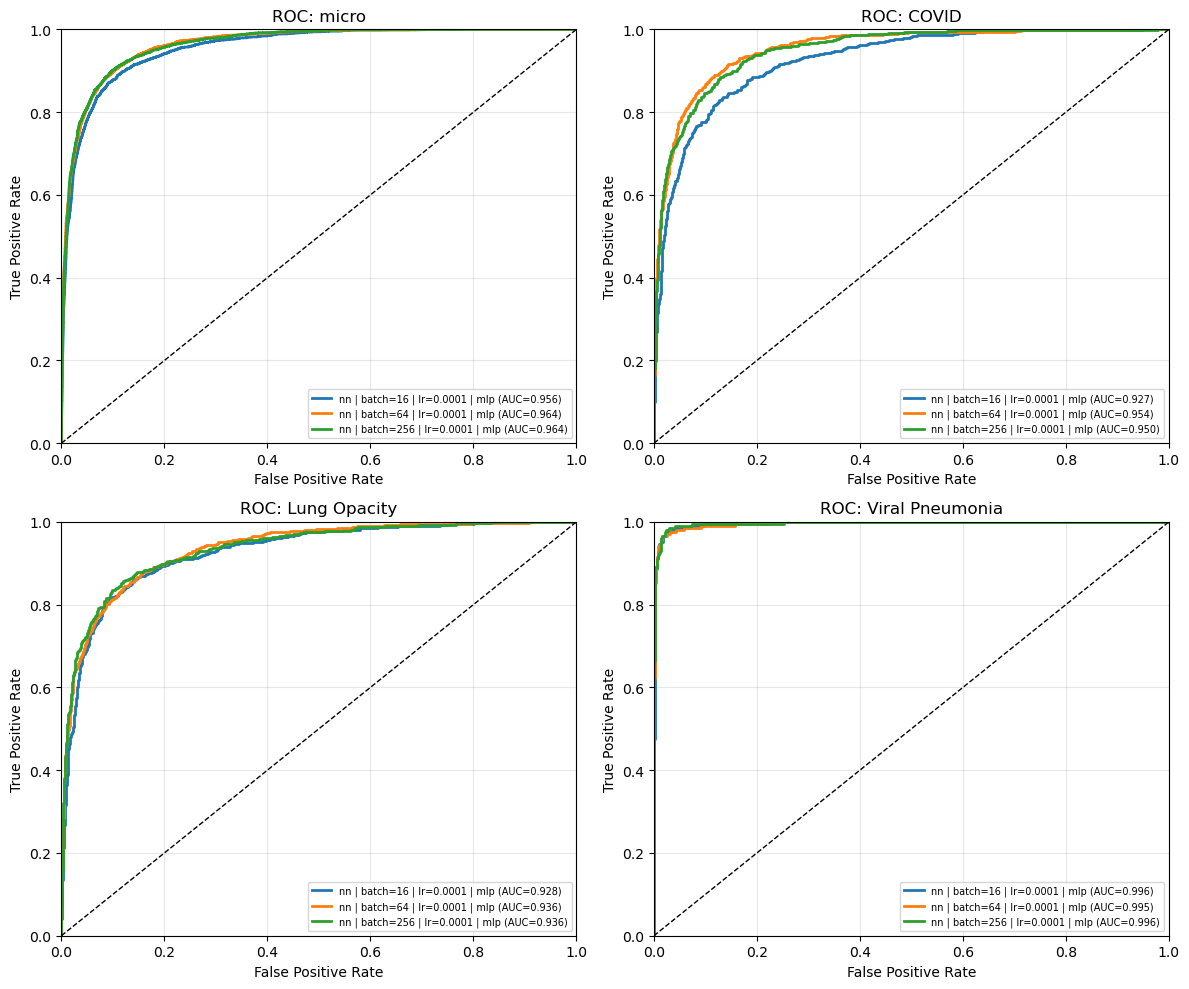

In [140]:
plot_train_overlays_grid(
    train_dirs_nnm_nomask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN MLP nomask"
)
plot_test_roc_overlays_grid(
    test_dirs_nnm_nomask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [141]:
train_dirs_nnm_nomask = []
test_dirs_nnm_nomask  = []
for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "nomask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=40,
        model_kind="nn_mlp"
    )
    train_dirs_nnm_nomask += t
    test_dirs_nnm_nomask  += tt



=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=64 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=64 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.7928 | val_loss=0.7597 | val_f1=0.609 | val_bal=0.670 | 28.51s


Epoche 02: train_loss=0.6537 | val_loss=0.6202 | val_f1=0.703 | val_bal=0.743 | 27.62s


Epoche 03: train_loss=0.5919 | val_loss=0.5797 | val_f1=0.769 | val_bal=0.772 | 27.50s


Epoche 04: train_loss=0.5657 | val_loss=0.5591 | val_f1=0.768 | val_bal=0.779 | 27.47s


Epoche 05: train_loss=0.5351 | val_loss=0.4942 | val_f1=0.771 | val_bal=0.806 | 27.49s


Epoche 06: train_loss=0.5111 | val_loss=0.5290 | val_f1=0.791 | val_bal=0.794 | 27.45s


Epoche 07: train_loss=0.5012 | val_loss=0.4865 | val_f1=0.804 | val_bal=0.810 | 27.84s


Epoche 08: train_loss=0.4872 | val_loss=0.4684 | val_f1=0.803 | val_bal=0.824 | 27.52s


Epoche 09: train_loss=0.4797 | val_loss=0.4859 | val_f1=0.792 | val_bal=0.810 | 27.72s


Epoche 10: train_loss=0.4692 | val_loss=0.4664 | val_f1=0.788 | val_bal=0.808 | 27.86s


Epoche 11: train_loss=0.4559 | val_loss=0.4806 | val_f1=0.809 | val_bal=0.815 | 27.30s


Epoche 12: train_loss=0.4538 | val_loss=0.4312 | val_f1=0.815 | val_bal=0.838 | 27.63s


Epoche 13: train_loss=0.4516 | val_loss=0.4331 | val_f1=0.831 | val_bal=0.841 | 27.63s


Epoche 14: train_loss=0.4398 | val_loss=0.4736 | val_f1=0.815 | val_bal=0.824 | 27.69s


Epoche 15: train_loss=0.4314 | val_loss=0.4777 | val_f1=0.813 | val_bal=0.821 | 27.68s


Epoche 16: train_loss=0.4212 | val_loss=0.4303 | val_f1=0.806 | val_bal=0.839 | 27.67s


Epoche 17: train_loss=0.4112 | val_loss=0.4259 | val_f1=0.802 | val_bal=0.837 | 27.56s


Epoche 18: train_loss=0.4097 | val_loss=0.4160 | val_f1=0.833 | val_bal=0.845 | 27.50s


Epoche 19: train_loss=0.4084 | val_loss=0.4089 | val_f1=0.831 | val_bal=0.846 | 27.64s


Epoche 20: train_loss=0.4040 | val_loss=0.4227 | val_f1=0.817 | val_bal=0.835 | 27.43s


Epoche 21: train_loss=0.4007 | val_loss=0.4140 | val_f1=0.843 | val_bal=0.843 | 27.40s


Epoche 22: train_loss=0.3913 | val_loss=0.4297 | val_f1=0.831 | val_bal=0.829 | 27.75s


Epoche 23: train_loss=0.3861 | val_loss=0.4327 | val_f1=0.824 | val_bal=0.837 | 27.75s


Epoche 24: train_loss=0.3813 | val_loss=0.4144 | val_f1=0.839 | val_bal=0.839 | 27.77s


Epoche 25: train_loss=0.3683 | val_loss=0.3960 | val_f1=0.822 | val_bal=0.848 | 28.11s


Epoche 26: train_loss=0.3704 | val_loss=0.4003 | val_f1=0.823 | val_bal=0.844 | 28.51s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1217_batch-64_lr-00001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=64
Pfad=nn_mlp_nomask_2025_08_31_1217_batch-64_lr-00001.pt


[test] F1(macro)=0.820 | BalAcc=0.838 | Zeit=5.08s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1217_batch-64_lr-00001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1217_batch-64_lr-00001 | F1=0.820 | BalAcc=0.838

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8793 | val_loss=0.7685 | val_f1=0.602 | val_bal=0.682 | 28.42s


Epoche 02: train_loss=0.7052 | val_loss=0.6563 | val_f1=0.724 | val_bal=0.733 | 27.47s


Epoche 03: train_loss=0.6225 | val_loss=0.5613 | val_f1=0.758 | val_bal=0.787 | 27.72s


Epoche 04: train_loss=0.5810 | val_loss=0.5433 | val_f1=0.779 | val_bal=0.791 | 27.75s


Epoche 05: train_loss=0.5517 | val_loss=0.5237 | val_f1=0.759 | val_bal=0.790 | 27.49s


Epoche 06: train_loss=0.5334 | val_loss=0.5138 | val_f1=0.766 | val_bal=0.801 | 27.34s


Epoche 07: train_loss=0.5152 | val_loss=0.5431 | val_f1=0.787 | val_bal=0.796 | 27.59s


Epoche 08: train_loss=0.4968 | val_loss=0.5234 | val_f1=0.799 | val_bal=0.793 | 27.70s


Epoche 09: train_loss=0.4835 | val_loss=0.4975 | val_f1=0.767 | val_bal=0.803 | 27.88s


Epoche 10: train_loss=0.4794 | val_loss=0.5010 | val_f1=0.802 | val_bal=0.814 | 27.83s


Epoche 11: train_loss=0.4651 | val_loss=0.4547 | val_f1=0.801 | val_bal=0.825 | 27.40s


Epoche 12: train_loss=0.4563 | val_loss=0.4860 | val_f1=0.797 | val_bal=0.815 | 27.52s


Epoche 13: train_loss=0.4455 | val_loss=0.4319 | val_f1=0.825 | val_bal=0.841 | 27.23s


Epoche 14: train_loss=0.4446 | val_loss=0.4433 | val_f1=0.810 | val_bal=0.831 | 27.39s


Epoche 15: train_loss=0.4402 | val_loss=0.4447 | val_f1=0.826 | val_bal=0.828 | 27.89s


Epoche 16: train_loss=0.4307 | val_loss=0.4473 | val_f1=0.815 | val_bal=0.833 | 27.72s


Epoche 17: train_loss=0.4218 | val_loss=0.4395 | val_f1=0.821 | val_bal=0.838 | 27.84s


Epoche 18: train_loss=0.4145 | val_loss=0.4200 | val_f1=0.834 | val_bal=0.852 | 27.94s


Epoche 19: train_loss=0.4125 | val_loss=0.4186 | val_f1=0.813 | val_bal=0.844 | 27.96s


Epoche 20: train_loss=0.4013 | val_loss=0.4060 | val_f1=0.831 | val_bal=0.851 | 28.02s


Epoche 21: train_loss=0.3946 | val_loss=0.4280 | val_f1=0.820 | val_bal=0.843 | 27.96s


Epoche 22: train_loss=0.3813 | val_loss=0.4225 | val_f1=0.833 | val_bal=0.846 | 27.54s


Epoche 23: train_loss=0.3888 | val_loss=0.4028 | val_f1=0.825 | val_bal=0.851 | 27.90s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1230_batch-64_lr-0001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=64
Pfad=nn_mlp_nomask_2025_08_31_1230_batch-64_lr-0001.pt


[test] F1(macro)=0.812 | BalAcc=0.838 | Zeit=5.01s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1230_batch-64_lr-0001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1230_batch-64_lr-0001 | F1=0.812 | BalAcc=0.838

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=64 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=0.8328 @idx=108 → vorgeschlagene LR=2.964e-04
[lr-finder] gewählte Start-LR: 2.964e-04

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=64 | LR=0.0002964041411597741 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8258 | val_loss=0.6953 | val_f1=0.648 | val_bal=0.714 | 28.29s


Epoche 02: train_loss=0.6719 | val_loss=0.6304 | val_f1=0.732 | val_bal=0.746 | 27.63s


Epoche 03: train_loss=0.6061 | val_loss=0.5890 | val_f1=0.736 | val_bal=0.763 | 27.83s


Epoche 04: train_loss=0.5737 | val_loss=0.5677 | val_f1=0.752 | val_bal=0.768 | 27.67s


Epoche 05: train_loss=0.5392 | val_loss=0.5132 | val_f1=0.785 | val_bal=0.803 | 27.96s


Epoche 06: train_loss=0.5208 | val_loss=0.4979 | val_f1=0.763 | val_bal=0.802 | 27.77s


Epoche 07: train_loss=0.5060 | val_loss=0.5527 | val_f1=0.792 | val_bal=0.789 | 28.20s


Epoche 08: train_loss=0.4898 | val_loss=0.4991 | val_f1=0.788 | val_bal=0.813 | 28.06s


Epoche 09: train_loss=0.4799 | val_loss=0.4424 | val_f1=0.803 | val_bal=0.834 | 27.87s


Epoche 10: train_loss=0.4694 | val_loss=0.4425 | val_f1=0.801 | val_bal=0.827 | 27.78s


Epoche 11: train_loss=0.4621 | val_loss=0.4545 | val_f1=0.802 | val_bal=0.821 | 27.44s


Epoche 12: train_loss=0.4492 | val_loss=0.4571 | val_f1=0.791 | val_bal=0.825 | 27.60s


Epoche 13: train_loss=0.4419 | val_loss=0.4268 | val_f1=0.788 | val_bal=0.833 | 27.71s


Epoche 14: train_loss=0.4341 | val_loss=0.4474 | val_f1=0.794 | val_bal=0.821 | 27.73s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1241_batch-64_lr-00002964041411597741
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=64
Pfad=nn_mlp_nomask_2025_08_31_1241_batch-64_lr-00002964041411597741.pt


[test] F1(macro)=0.775 | BalAcc=0.820 | Zeit=5.02s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1241_batch-64_lr-00002964041411597741_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1241_batch-64_lr-00002964041411597741 | F1=0.775 | BalAcc=0.820

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=128 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8360 | val_loss=0.6965 | val_f1=0.661 | val_bal=0.714 | 27.99s


Epoche 02: train_loss=0.6669 | val_loss=0.6323 | val_f1=0.736 | val_bal=0.753 | 27.59s


Epoche 03: train_loss=0.6049 | val_loss=0.5576 | val_f1=0.746 | val_bal=0.774 | 27.52s


Epoche 04: train_loss=0.5704 | val_loss=0.5333 | val_f1=0.768 | val_bal=0.784 | 27.36s


Epoche 05: train_loss=0.5417 | val_loss=0.5246 | val_f1=0.746 | val_bal=0.796 | 27.34s


Epoche 06: train_loss=0.5193 | val_loss=0.5073 | val_f1=0.791 | val_bal=0.807 | 27.83s


Epoche 07: train_loss=0.5039 | val_loss=0.4947 | val_f1=0.792 | val_bal=0.810 | 27.94s


Epoche 08: train_loss=0.4986 | val_loss=0.4658 | val_f1=0.796 | val_bal=0.820 | 27.96s


Epoche 09: train_loss=0.4843 | val_loss=0.5059 | val_f1=0.786 | val_bal=0.799 | 28.05s


Epoche 10: train_loss=0.4609 | val_loss=0.4712 | val_f1=0.815 | val_bal=0.822 | 27.68s


Epoche 11: train_loss=0.4614 | val_loss=0.4547 | val_f1=0.822 | val_bal=0.832 | 27.47s


Epoche 12: train_loss=0.4461 | val_loss=0.4510 | val_f1=0.806 | val_bal=0.825 | 27.93s


Epoche 13: train_loss=0.4434 | val_loss=0.4451 | val_f1=0.803 | val_bal=0.825 | 27.46s


Epoche 14: train_loss=0.4364 | val_loss=0.4340 | val_f1=0.825 | val_bal=0.836 | 27.45s


Epoche 15: train_loss=0.4307 | val_loss=0.4492 | val_f1=0.819 | val_bal=0.828 | 27.67s


Epoche 16: train_loss=0.4276 | val_loss=0.4359 | val_f1=0.816 | val_bal=0.833 | 27.36s


Epoche 17: train_loss=0.4205 | val_loss=0.4627 | val_f1=0.805 | val_bal=0.827 | 27.81s


Epoche 18: train_loss=0.4113 | val_loss=0.4195 | val_f1=0.801 | val_bal=0.836 | 28.07s


Epoche 19: train_loss=0.4038 | val_loss=0.4270 | val_f1=0.786 | val_bal=0.832 | 27.80s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1248_batch-128_lr-00001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=128
Pfad=nn_mlp_nomask_2025_08_31_1248_batch-128_lr-00001.pt


[test] F1(macro)=0.803 | BalAcc=0.828 | Zeit=5.21s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1248_batch-128_lr-00001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1248_batch-128_lr-00001 | F1=0.803 | BalAcc=0.828

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=128 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8754 | val_loss=0.7526 | val_f1=0.615 | val_bal=0.684 | 28.34s


Epoche 02: train_loss=0.7226 | val_loss=0.6641 | val_f1=0.665 | val_bal=0.724 | 27.78s


Epoche 03: train_loss=0.6589 | val_loss=0.6109 | val_f1=0.724 | val_bal=0.753 | 27.55s


Epoche 04: train_loss=0.5993 | val_loss=0.5659 | val_f1=0.753 | val_bal=0.776 | 27.69s


Epoche 05: train_loss=0.5751 | val_loss=0.5598 | val_f1=0.734 | val_bal=0.776 | 27.35s


Epoche 06: train_loss=0.5376 | val_loss=0.5089 | val_f1=0.777 | val_bal=0.799 | 27.33s


Epoche 07: train_loss=0.5286 | val_loss=0.5262 | val_f1=0.783 | val_bal=0.798 | 27.38s


Epoche 08: train_loss=0.4957 | val_loss=0.4897 | val_f1=0.808 | val_bal=0.808 | 27.46s


Epoche 09: train_loss=0.4901 | val_loss=0.5063 | val_f1=0.744 | val_bal=0.787 | 28.23s


Epoche 10: train_loss=0.4868 | val_loss=0.5048 | val_f1=0.797 | val_bal=0.802 | 28.09s


Epoche 11: train_loss=0.4672 | val_loss=0.4888 | val_f1=0.809 | val_bal=0.814 | 27.81s


Epoche 12: train_loss=0.4608 | val_loss=0.4747 | val_f1=0.787 | val_bal=0.812 | 27.56s


Epoche 13: train_loss=0.4494 | val_loss=0.4634 | val_f1=0.783 | val_bal=0.822 | 27.46s


Epoche 14: train_loss=0.4374 | val_loss=0.4373 | val_f1=0.784 | val_bal=0.826 | 27.47s


Epoche 15: train_loss=0.4414 | val_loss=0.4419 | val_f1=0.827 | val_bal=0.835 | 27.57s


Epoche 16: train_loss=0.4392 | val_loss=0.4218 | val_f1=0.790 | val_bal=0.832 | 27.49s


Epoche 17: train_loss=0.4137 | val_loss=0.4266 | val_f1=0.826 | val_bal=0.836 | 27.53s


Epoche 18: train_loss=0.4252 | val_loss=0.4385 | val_f1=0.800 | val_bal=0.832 | 27.94s


Epoche 19: train_loss=0.4035 | val_loss=0.4448 | val_f1=0.832 | val_bal=0.832 | 27.54s


Epoche 20: train_loss=0.4022 | val_loss=0.4214 | val_f1=0.817 | val_bal=0.839 | 27.52s


Epoche 21: train_loss=0.3952 | val_loss=0.4247 | val_f1=0.822 | val_bal=0.839 | 27.40s


Epoche 22: train_loss=0.3940 | val_loss=0.4066 | val_f1=0.832 | val_bal=0.849 | 27.39s


Epoche 23: train_loss=0.3882 | val_loss=0.4050 | val_f1=0.830 | val_bal=0.850 | 26.97s


Epoche 24: train_loss=0.3845 | val_loss=0.4106 | val_f1=0.836 | val_bal=0.853 | 27.72s


Epoche 25: train_loss=0.3790 | val_loss=0.4011 | val_f1=0.838 | val_bal=0.854 | 27.50s


Epoche 26: train_loss=0.3745 | val_loss=0.3922 | val_f1=0.837 | val_bal=0.862 | 27.78s


Epoche 27: train_loss=0.3604 | val_loss=0.4036 | val_f1=0.848 | val_bal=0.853 | 28.05s


Epoche 28: train_loss=0.3569 | val_loss=0.3998 | val_f1=0.851 | val_bal=0.855 | 27.98s


Epoche 29: train_loss=0.3609 | val_loss=0.3807 | val_f1=0.834 | val_bal=0.860 | 28.31s


Epoche 30: train_loss=0.3485 | val_loss=0.3833 | val_f1=0.833 | val_bal=0.860 | 27.72s


Epoche 31: train_loss=0.3517 | val_loss=0.3966 | val_f1=0.832 | val_bal=0.851 | 27.82s


Epoche 32: train_loss=0.3408 | val_loss=0.3986 | val_f1=0.836 | val_bal=0.847 | 27.45s


Epoche 33: train_loss=0.3503 | val_loss=0.3858 | val_f1=0.845 | val_bal=0.857 | 27.94s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1257_batch-128_lr-0001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=128
Pfad=nn_mlp_nomask_2025_08_31_1257_batch-128_lr-0001.pt


[test] F1(macro)=0.837 | BalAcc=0.852 | Zeit=5.25s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1257_batch-128_lr-0001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1257_batch-128_lr-0001 | F1=0.837 | BalAcc=0.852

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=0.7741 @idx=129 → vorgeschlagene LR=7.834e-04
[lr-finder] gewählte Start-LR: 7.834e-04

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=128 | LR=0.0007834202981618593 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8564 | val_loss=0.7463 | val_f1=0.606 | val_bal=0.675 | 28.57s


Epoche 02: train_loss=0.7112 | val_loss=0.6536 | val_f1=0.680 | val_bal=0.726 | 27.67s


Epoche 03: train_loss=0.6487 | val_loss=0.6475 | val_f1=0.711 | val_bal=0.732 | 27.65s


Epoche 04: train_loss=0.5979 | val_loss=0.5985 | val_f1=0.759 | val_bal=0.754 | 27.69s


Epoche 05: train_loss=0.5659 | val_loss=0.5388 | val_f1=0.756 | val_bal=0.789 | 27.34s


Epoche 06: train_loss=0.5478 | val_loss=0.5446 | val_f1=0.787 | val_bal=0.783 | 27.21s


Epoche 07: train_loss=0.5189 | val_loss=0.4869 | val_f1=0.793 | val_bal=0.816 | 27.59s


Epoche 08: train_loss=0.5039 | val_loss=0.5338 | val_f1=0.786 | val_bal=0.790 | 27.57s


Epoche 09: train_loss=0.4935 | val_loss=0.4713 | val_f1=0.782 | val_bal=0.816 | 27.75s


Epoche 10: train_loss=0.4714 | val_loss=0.4453 | val_f1=0.818 | val_bal=0.826 | 27.86s


Epoche 11: train_loss=0.4682 | val_loss=0.4409 | val_f1=0.793 | val_bal=0.829 | 27.81s


Epoche 12: train_loss=0.4541 | val_loss=0.4344 | val_f1=0.816 | val_bal=0.838 | 28.14s


Epoche 13: train_loss=0.4454 | val_loss=0.4332 | val_f1=0.802 | val_bal=0.836 | 27.68s


Epoche 14: train_loss=0.4429 | val_loss=0.4622 | val_f1=0.798 | val_bal=0.823 | 27.70s


Epoche 15: train_loss=0.4335 | val_loss=0.4470 | val_f1=0.818 | val_bal=0.840 | 27.94s


Epoche 16: train_loss=0.4238 | val_loss=0.4377 | val_f1=0.820 | val_bal=0.832 | 27.80s


Epoche 17: train_loss=0.4105 | val_loss=0.4598 | val_f1=0.820 | val_bal=0.823 | 28.19s


Epoche 18: train_loss=0.4143 | val_loss=0.4207 | val_f1=0.810 | val_bal=0.841 | 28.04s


Epoche 19: train_loss=0.4043 | val_loss=0.4359 | val_f1=0.799 | val_bal=0.837 | 28.16s


Epoche 20: train_loss=0.4035 | val_loss=0.4222 | val_f1=0.829 | val_bal=0.842 | 27.89s


Epoche 21: train_loss=0.3949 | val_loss=0.4363 | val_f1=0.836 | val_bal=0.838 | 28.01s


Epoche 22: train_loss=0.3903 | val_loss=0.4114 | val_f1=0.828 | val_bal=0.846 | 27.54s


Epoche 23: train_loss=0.3805 | val_loss=0.4077 | val_f1=0.816 | val_bal=0.846 | 27.77s


Epoche 24: train_loss=0.3812 | val_loss=0.4032 | val_f1=0.844 | val_bal=0.850 | 27.32s


Epoche 25: train_loss=0.3684 | val_loss=0.4119 | val_f1=0.820 | val_bal=0.846 | 27.38s


Epoche 26: train_loss=0.3745 | val_loss=0.4067 | val_f1=0.836 | val_bal=0.849 | 27.55s


Epoche 27: train_loss=0.3627 | val_loss=0.3873 | val_f1=0.827 | val_bal=0.853 | 27.68s


Epoche 28: train_loss=0.3639 | val_loss=0.3843 | val_f1=0.837 | val_bal=0.856 | 27.55s


Epoche 29: train_loss=0.3526 | val_loss=0.3938 | val_f1=0.838 | val_bal=0.854 | 27.51s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1313_batch-128_lr-00007834202981618593
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=128
Pfad=nn_mlp_nomask_2025_08_31_1313_batch-128_lr-00007834202981618593.pt


[test] F1(macro)=0.824 | BalAcc=0.842 | Zeit=5.26s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1313_batch-128_lr-00007834202981618593_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1313_batch-128_lr-00007834202981618593 | F1=0.824 | BalAcc=0.842

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=256 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.8798 | val_loss=0.7640 | val_f1=0.616 | val_bal=0.669 | 28.31s


Epoche 02: train_loss=0.7141 | val_loss=0.6895 | val_f1=0.718 | val_bal=0.718 | 28.11s


Epoche 03: train_loss=0.6347 | val_loss=0.6016 | val_f1=0.745 | val_bal=0.760 | 27.81s


Epoche 04: train_loss=0.5926 | val_loss=0.5516 | val_f1=0.734 | val_bal=0.783 | 27.72s


Epoche 05: train_loss=0.5650 | val_loss=0.5335 | val_f1=0.767 | val_bal=0.788 | 27.92s


Epoche 06: train_loss=0.5367 | val_loss=0.5352 | val_f1=0.747 | val_bal=0.790 | 28.21s


Epoche 07: train_loss=0.5335 | val_loss=0.5310 | val_f1=0.750 | val_bal=0.789 | 27.99s


Epoche 08: train_loss=0.5184 | val_loss=0.5070 | val_f1=0.783 | val_bal=0.798 | 27.70s


Epoche 09: train_loss=0.4902 | val_loss=0.4848 | val_f1=0.798 | val_bal=0.816 | 27.69s


Epoche 10: train_loss=0.4808 | val_loss=0.4699 | val_f1=0.791 | val_bal=0.821 | 27.70s


Epoche 11: train_loss=0.4737 | val_loss=0.4587 | val_f1=0.821 | val_bal=0.834 | 29.92s


Epoche 12: train_loss=0.4625 | val_loss=0.4539 | val_f1=0.789 | val_bal=0.823 | 28.17s


Epoche 13: train_loss=0.4525 | val_loss=0.4359 | val_f1=0.804 | val_bal=0.830 | 28.70s


Epoche 14: train_loss=0.4370 | val_loss=0.4389 | val_f1=0.810 | val_bal=0.824 | 27.97s


Epoche 15: train_loss=0.4305 | val_loss=0.4550 | val_f1=0.814 | val_bal=0.822 | 27.91s


Epoche 16: train_loss=0.4344 | val_loss=0.4195 | val_f1=0.830 | val_bal=0.843 | 27.70s


Epoche 17: train_loss=0.4232 | val_loss=0.4204 | val_f1=0.823 | val_bal=0.840 | 27.99s


Epoche 18: train_loss=0.4240 | val_loss=0.4666 | val_f1=0.810 | val_bal=0.815 | 28.22s


Epoche 19: train_loss=0.4088 | val_loss=0.4146 | val_f1=0.819 | val_bal=0.849 | 27.62s


Epoche 20: train_loss=0.4094 | val_loss=0.4487 | val_f1=0.828 | val_bal=0.824 | 27.90s


Epoche 21: train_loss=0.4013 | val_loss=0.4091 | val_f1=0.817 | val_bal=0.845 | 27.64s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1327_batch-256_lr-00001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=256
Pfad=nn_mlp_nomask_2025_08_31_1327_batch-256_lr-00001.pt


[test] F1(macro)=0.812 | BalAcc=0.835 | Zeit=5.17s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1327_batch-256_lr-00001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1327_batch-256_lr-00001 | F1=0.812 | BalAcc=0.835

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=0.9052 | val_loss=0.8047 | val_f1=0.577 | val_bal=0.658 | 29.28s


Epoche 02: train_loss=0.7647 | val_loss=0.7307 | val_f1=0.661 | val_bal=0.694 | 28.63s


Epoche 03: train_loss=0.7045 | val_loss=0.6518 | val_f1=0.659 | val_bal=0.724 | 28.26s


Epoche 04: train_loss=0.6502 | val_loss=0.6232 | val_f1=0.723 | val_bal=0.744 | 28.17s


Epoche 05: train_loss=0.6137 | val_loss=0.6218 | val_f1=0.740 | val_bal=0.740 | 28.04s


Epoche 06: train_loss=0.5797 | val_loss=0.5665 | val_f1=0.728 | val_bal=0.770 | 28.65s


Epoche 07: train_loss=0.5623 | val_loss=0.5213 | val_f1=0.775 | val_bal=0.799 | 27.88s


Epoche 08: train_loss=0.5327 | val_loss=0.5180 | val_f1=0.789 | val_bal=0.788 | 28.30s


Epoche 09: train_loss=0.5230 | val_loss=0.5033 | val_f1=0.776 | val_bal=0.800 | 27.82s


Epoche 10: train_loss=0.5011 | val_loss=0.4844 | val_f1=0.801 | val_bal=0.807 | 27.35s


Epoche 11: train_loss=0.4904 | val_loss=0.4763 | val_f1=0.792 | val_bal=0.813 | 27.73s


Epoche 12: train_loss=0.4773 | val_loss=0.4494 | val_f1=0.803 | val_bal=0.829 | 27.53s


Epoche 13: train_loss=0.4662 | val_loss=0.4819 | val_f1=0.814 | val_bal=0.813 | 28.00s


Epoche 14: train_loss=0.4665 | val_loss=0.4737 | val_f1=0.810 | val_bal=0.813 | 27.55s


Epoche 15: train_loss=0.4578 | val_loss=0.4396 | val_f1=0.821 | val_bal=0.837 | 28.05s


Epoche 16: train_loss=0.4492 | val_loss=0.4302 | val_f1=0.805 | val_bal=0.832 | 27.95s


Epoche 17: train_loss=0.4370 | val_loss=0.4303 | val_f1=0.804 | val_bal=0.838 | 27.72s


Epoche 18: train_loss=0.4285 | val_loss=0.4465 | val_f1=0.784 | val_bal=0.826 | 28.02s


Epoche 19: train_loss=0.4167 | val_loss=0.4304 | val_f1=0.810 | val_bal=0.838 | 27.84s


Epoche 20: train_loss=0.4183 | val_loss=0.4349 | val_f1=0.820 | val_bal=0.835 | 27.63s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1337_batch-256_lr-0001
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=256
Pfad=nn_mlp_nomask_2025_08_31_1337_batch-256_lr-0001.pt


[test] F1(macro)=0.801 | BalAcc=0.828 | Zeit=5.26s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1337_batch-256_lr-0001_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1337_batch-256_lr-0001 | F1=0.801 | BalAcc=0.828

=== SWEEP RUN: model=nn_mlp | mode=nomask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=0.7212 @idx=164 → vorgeschlagene LR=3.958e-03
[lr-finder] gewählte Start-LR: 3.958e-03

[TRAIN-START] Model=nn_mlp | Modus=nomask | Batch=256 | LR=0.003958333735707159 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0098 | val_loss=0.9129 | val_f1=0.538 | val_bal=0.605 | 29.72s


Epoche 02: train_loss=0.8400 | val_loss=0.8176 | val_f1=0.602 | val_bal=0.651 | 27.55s


Epoche 03: train_loss=0.7709 | val_loss=0.7544 | val_f1=0.616 | val_bal=0.677 | 27.67s


Epoche 04: train_loss=0.7117 | val_loss=0.7234 | val_f1=0.683 | val_bal=0.699 | 27.35s


Epoche 05: train_loss=0.6802 | val_loss=0.6409 | val_f1=0.696 | val_bal=0.734 | 27.63s


Epoche 06: train_loss=0.6429 | val_loss=0.6110 | val_f1=0.705 | val_bal=0.743 | 27.74s


Epoche 07: train_loss=0.6082 | val_loss=0.5665 | val_f1=0.754 | val_bal=0.775 | 27.24s


Epoche 08: train_loss=0.5779 | val_loss=0.5861 | val_f1=0.740 | val_bal=0.774 | 27.65s


Epoche 09: train_loss=0.5636 | val_loss=0.5434 | val_f1=0.766 | val_bal=0.786 | 27.89s


Epoche 10: train_loss=0.5439 | val_loss=0.5330 | val_f1=0.781 | val_bal=0.787 | 27.61s


Epoche 11: train_loss=0.5277 | val_loss=0.4895 | val_f1=0.777 | val_bal=0.812 | 27.95s


Epoche 12: train_loss=0.5121 | val_loss=0.4853 | val_f1=0.794 | val_bal=0.801 | 27.78s


Epoche 13: train_loss=0.5100 | val_loss=0.5203 | val_f1=0.729 | val_bal=0.789 | 27.53s


Epoche 14: train_loss=0.4962 | val_loss=0.4697 | val_f1=0.787 | val_bal=0.818 | 27.29s


Epoche 15: train_loss=0.4818 | val_loss=0.4544 | val_f1=0.799 | val_bal=0.829 | 27.65s


Epoche 16: train_loss=0.4645 | val_loss=0.4410 | val_f1=0.806 | val_bal=0.836 | 27.48s


Epoche 17: train_loss=0.4587 | val_loss=0.4311 | val_f1=0.796 | val_bal=0.834 | 27.64s


Epoche 18: train_loss=0.4525 | val_loss=0.4323 | val_f1=0.808 | val_bal=0.831 | 27.53s


Epoche 19: train_loss=0.4482 | val_loss=0.4258 | val_f1=0.804 | val_bal=0.837 | 27.71s


Epoche 20: train_loss=0.4435 | val_loss=0.4362 | val_f1=0.817 | val_bal=0.837 | 27.23s


Epoche 21: train_loss=0.4270 | val_loss=0.4480 | val_f1=0.819 | val_bal=0.828 | 27.96s


Epoche 22: train_loss=0.4264 | val_loss=0.5055 | val_f1=0.806 | val_bal=0.802 | 27.92s


Epoche 23: train_loss=0.4208 | val_loss=0.4334 | val_f1=0.794 | val_bal=0.829 | 27.79s


Epoche 24: train_loss=0.4149 | val_loss=0.4150 | val_f1=0.828 | val_bal=0.844 | 27.53s


Epoche 25: train_loss=0.4044 | val_loss=0.4251 | val_f1=0.822 | val_bal=0.845 | 27.46s


Epoche 26: train_loss=0.4043 | val_loss=0.4363 | val_f1=0.794 | val_bal=0.828 | 27.89s


Epoche 27: train_loss=0.3966 | val_loss=0.4219 | val_f1=0.810 | val_bal=0.844 | 27.85s


Epoche 28: train_loss=0.3908 | val_loss=0.4228 | val_f1=0.836 | val_bal=0.849 | 28.35s


Epoche 29: train_loss=0.3856 | val_loss=0.4169 | val_f1=0.827 | val_bal=0.843 | 27.75s


Epoche 30: train_loss=0.3791 | val_loss=0.4153 | val_f1=0.839 | val_bal=0.850 | 27.86s


Epoche 31: train_loss=0.3768 | val_loss=0.4041 | val_f1=0.837 | val_bal=0.852 | 27.38s


Epoche 32: train_loss=0.3745 | val_loss=0.4031 | val_f1=0.835 | val_bal=0.855 | 27.83s


Epoche 33: train_loss=0.3603 | val_loss=0.4065 | val_f1=0.834 | val_bal=0.859 | 27.40s


Epoche 34: train_loss=0.3610 | val_loss=0.4274 | val_f1=0.843 | val_bal=0.846 | 27.75s


Epoche 35: train_loss=0.3612 | val_loss=0.4006 | val_f1=0.837 | val_bal=0.857 | 27.83s


Epoche 36: train_loss=0.3562 | val_loss=0.3932 | val_f1=0.839 | val_bal=0.862 | 27.79s


Epoche 37: train_loss=0.3498 | val_loss=0.4069 | val_f1=0.838 | val_bal=0.855 | 27.66s


Epoche 38: train_loss=0.3480 | val_loss=0.4149 | val_f1=0.837 | val_bal=0.856 | 27.82s


Epoche 39: train_loss=0.3583 | val_loss=0.3936 | val_f1=0.843 | val_bal=0.858 | 27.51s


Epoche 40: train_loss=0.3383 | val_loss=0.4282 | val_f1=0.816 | val_bal=0.845 | 27.95s
[train] fertig → /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1347_batch-256_lr-0003958333735707159
[TEST-START] Model=nn_mlp | Modus=nomask | Batch=256
Pfad=nn_mlp_nomask_2025_08_31_1347_batch-256_lr-0003958333735707159.pt


[test] F1(macro)=0.832 | BalAcc=0.859 | Zeit=5.20s | /home/lupan001/ML/results/nn_mlp_nomask_2025_08_31_1347_batch-256_lr-0003958333735707159_test
[SWEEP] Modell=nn_mlp_nomask_2025_08_31_1347_batch-256_lr-0003958333735707159 | F1=0.832 | BalAcc=0.859



=== MODELLVERGLEICH (Train train_loss) ===
nn | batch=128 | lr=0.0001 | mlp | train_loss max=0.8754
nn | batch=128 | lr=1e-05 | mlp | train_loss max=0.8360
nn | batch=128 | lr=7.834e-05 | mlp | train_loss max=0.8564
nn | batch=256 | lr=0.0001 | mlp | train_loss max=0.9052
nn | batch=256 | lr=0.0003958 | mlp | train_loss max=1.0098
nn | batch=256 | lr=1e-05 | mlp | train_loss max=0.8798
nn | batch=64 | lr=0.0001 | mlp | train_loss max=0.8793
nn | batch=64 | lr=1e-05 | mlp | train_loss max=0.7928
nn | batch=64 | lr=2.964e-05 | mlp | train_loss max=0.8258

=== MODELLVERGLEICH (Train val_f1) ===
nn | batch=128 | lr=0.0001 | mlp | val_f1 max=0.8514
nn | batch=128 | lr=1e-05 | mlp | val_f1 max=0.8251
nn | batch=128 | lr=7.834e-05 | mlp | val_f1 max=0.8439
nn | batch=256 | lr=0.0001 | mlp | val_f1 max=0.8209
nn | batch=256 | lr=0.0003958 | mlp | val_f1 max=0.8433
nn | batch=256 | lr=1e-05 | mlp | val_f1 max=0.8298
nn | batch=64 | lr=0.0001 | mlp | val_f1 max=0.8337
nn | batch=64 | lr=1e-05 |

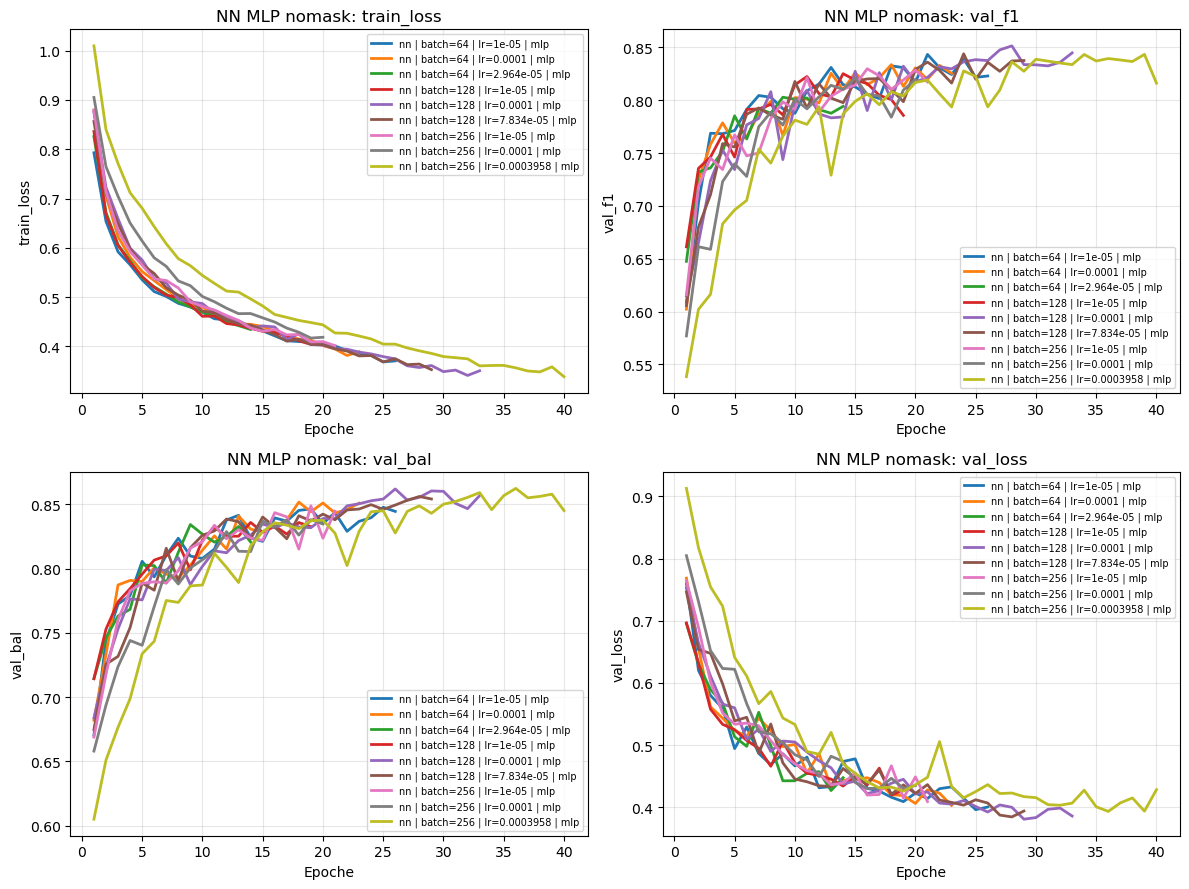


=== MODELLVERGLEICH (ROC micro) ===
nn | batch=64 | lr=1e-05 | mlp (AUC=0.964)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.958)
nn | batch=64 | lr=2.964e-05 | mlp (AUC=0.944)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.958)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.968)
nn | batch=128 | lr=7.834e-05 | mlp (AUC=0.965)
nn | batch=256 | lr=1e-05 | mlp (AUC=0.957)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.955)
nn | batch=256 | lr=0.0003958 | mlp (AUC=0.965)

=== MODELLVERGLEICH (ROC COVID) ===
nn | batch=64 | lr=1e-05 | mlp (AUC=0.946)
nn | batch=64 | lr=0.0001 | mlp (AUC=0.947)
nn | batch=64 | lr=2.964e-05 | mlp (AUC=0.924)
nn | batch=128 | lr=1e-05 | mlp (AUC=0.934)
nn | batch=128 | lr=0.0001 | mlp (AUC=0.957)
nn | batch=128 | lr=7.834e-05 | mlp (AUC=0.955)
nn | batch=256 | lr=1e-05 | mlp (AUC=0.941)
nn | batch=256 | lr=0.0001 | mlp (AUC=0.932)
nn | batch=256 | lr=0.0003958 | mlp (AUC=0.960)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
nn | batch=64 | lr=1e-05 | mlp (AUC=0.940)
nn | batch=64 | lr=0.00

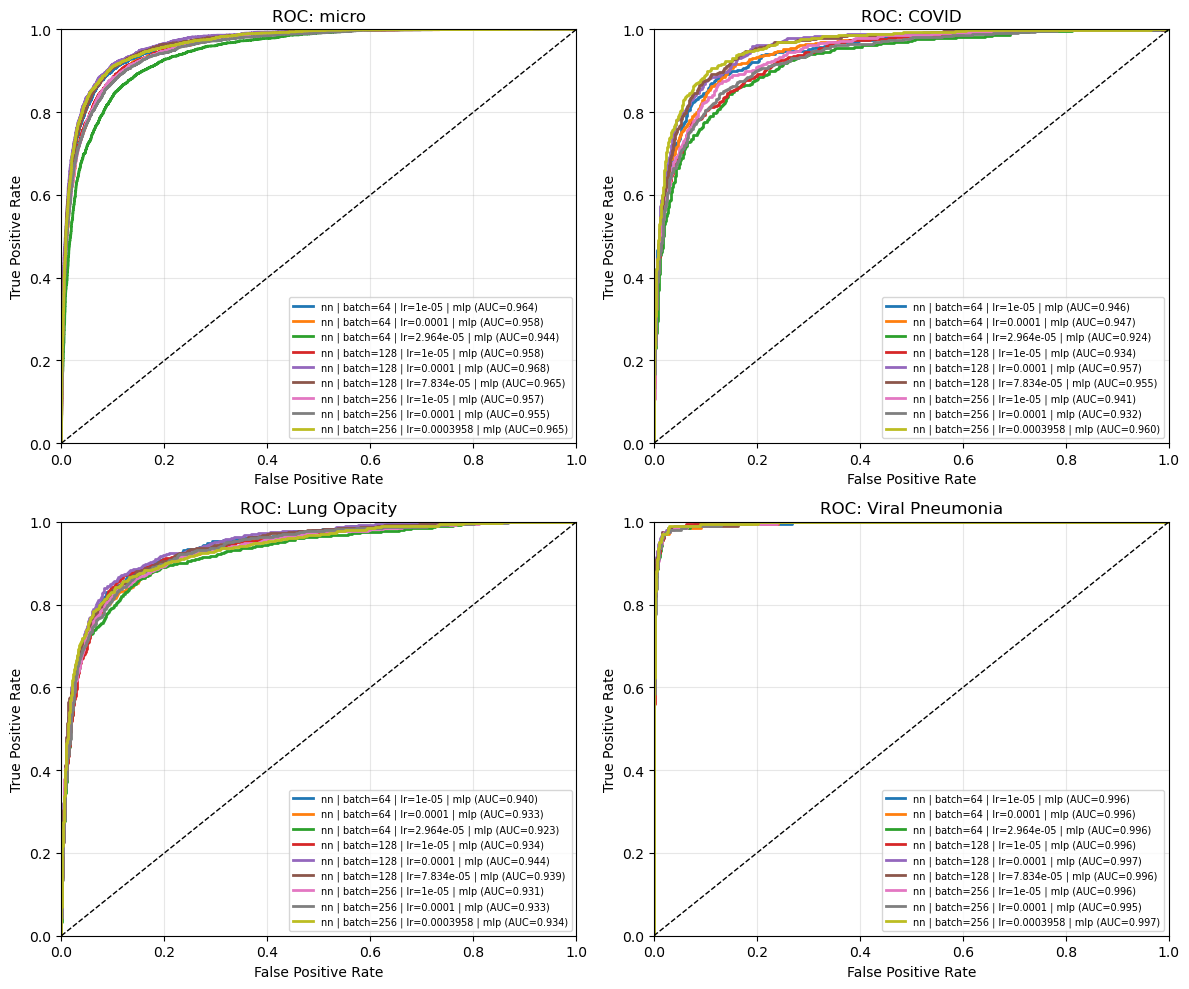

In [142]:
plot_train_overlays_grid(
    train_dirs_nnm_nomask,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="NN MLP nomask"
)
plot_test_roc_overlays_grid(
    test_dirs_nnm_nomask,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [143]:
train_dirs_cnn_mask_batch, test_dirs_cnn_mask_batch = run_sweep_train_test(
    "mask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=40,
    model_kind="cnn"
)



=== SWEEP RUN: model=cnn | mode=mask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=16 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1370 | val_loss=1.1122 | val_f1=0.386 | val_bal=0.550 | 43.91s


Epoche 02: train_loss=0.9089 | val_loss=1.3108 | val_f1=0.298 | val_bal=0.472 | 44.16s


Epoche 03: train_loss=0.8441 | val_loss=1.0593 | val_f1=0.515 | val_bal=0.527 | 44.10s


Epoche 04: train_loss=0.8168 | val_loss=1.1600 | val_f1=0.380 | val_bal=0.563 | 43.47s


Epoche 05: train_loss=0.7931 | val_loss=1.3286 | val_f1=0.486 | val_bal=0.507 | 43.81s


Epoche 06: train_loss=0.7680 | val_loss=1.2593 | val_f1=0.360 | val_bal=0.463 | 43.51s


Epoche 07: train_loss=0.7660 | val_loss=1.8336 | val_f1=0.308 | val_bal=0.390 | 44.02s


Epoche 08: train_loss=0.7479 | val_loss=2.2854 | val_f1=0.225 | val_bal=0.372 | 43.94s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1408_batch-16_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=16
Pfad=cnn_mask_2025_08_31_1408_batch-16_lr-0001.pt


[test] F1(macro)=0.519 | BalAcc=0.528 | Zeit=7.91s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1408_batch-16_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1408_batch-16_lr-0001 | F1=0.519 | BalAcc=0.528

=== SWEEP RUN: model=cnn | mode=mask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1725 | val_loss=1.0287 | val_f1=0.606 | val_bal=0.608 | 44.16s


Epoche 02: train_loss=0.9197 | val_loss=1.2076 | val_f1=0.335 | val_bal=0.487 | 43.40s


Epoche 03: train_loss=0.8442 | val_loss=1.6475 | val_f1=0.260 | val_bal=0.446 | 43.43s


Epoche 04: train_loss=0.7911 | val_loss=0.7601 | val_f1=0.603 | val_bal=0.691 | 43.15s


Epoche 05: train_loss=0.7760 | val_loss=2.5787 | val_f1=0.206 | val_bal=0.271 | 44.34s


Epoche 06: train_loss=0.7615 | val_loss=0.8243 | val_f1=0.562 | val_bal=0.626 | 44.39s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1414_batch-64_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=64
Pfad=cnn_mask_2025_08_31_1414_batch-64_lr-0001.pt


[test] F1(macro)=0.585 | BalAcc=0.587 | Zeit=8.20s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1414_batch-64_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1414_batch-64_lr-0001 | F1=0.585 | BalAcc=0.587

=== SWEEP RUN: model=cnn | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2846 | val_loss=1.3338 | val_f1=0.259 | val_bal=0.340 | 44.49s


Epoche 02: train_loss=1.0857 | val_loss=1.0186 | val_f1=0.515 | val_bal=0.590 | 45.20s


Epoche 03: train_loss=0.9295 | val_loss=0.9001 | val_f1=0.637 | val_bal=0.664 | 45.73s


Epoche 04: train_loss=0.8625 | val_loss=1.3163 | val_f1=0.346 | val_bal=0.479 | 45.56s


Epoche 05: train_loss=0.8307 | val_loss=0.9175 | val_f1=0.405 | val_bal=0.572 | 45.47s


Epoche 06: train_loss=0.7817 | val_loss=0.9253 | val_f1=0.625 | val_bal=0.599 | 45.62s


Epoche 07: train_loss=0.7828 | val_loss=0.9261 | val_f1=0.499 | val_bal=0.621 | 45.50s


Epoche 08: train_loss=0.7781 | val_loss=0.8218 | val_f1=0.519 | val_bal=0.623 | 44.91s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1418_batch-256_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=256
Pfad=cnn_mask_2025_08_31_1418_batch-256_lr-0001.pt


[test] F1(macro)=0.635 | BalAcc=0.661 | Zeit=8.58s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1418_batch-256_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1418_batch-256_lr-0001 | F1=0.635 | BalAcc=0.661



=== MODELLVERGLEICH (Train train_loss) ===
cnn | batch=16 | lr=0.0001 | mask | train_loss max=1.1370
cnn | batch=256 | lr=0.0001 | mask | train_loss max=1.2846
cnn | batch=64 | lr=0.0001 | mask | train_loss max=1.1725

=== MODELLVERGLEICH (Train val_f1) ===
cnn | batch=16 | lr=0.0001 | mask | val_f1 max=0.5151
cnn | batch=256 | lr=0.0001 | mask | val_f1 max=0.6370
cnn | batch=64 | lr=0.0001 | mask | val_f1 max=0.6056

=== MODELLVERGLEICH (Train val_bal) ===
cnn | batch=16 | lr=0.0001 | mask | val_bal max=0.5627
cnn | batch=256 | lr=0.0001 | mask | val_bal max=0.6645
cnn | batch=64 | lr=0.0001 | mask | val_bal max=0.6911

=== MODELLVERGLEICH (Train val_loss) ===
cnn | batch=16 | lr=0.0001 | mask | val_loss max=2.2854
cnn | batch=256 | lr=0.0001 | mask | val_loss max=1.3338
cnn | batch=64 | lr=0.0001 | mask | val_loss max=2.5787


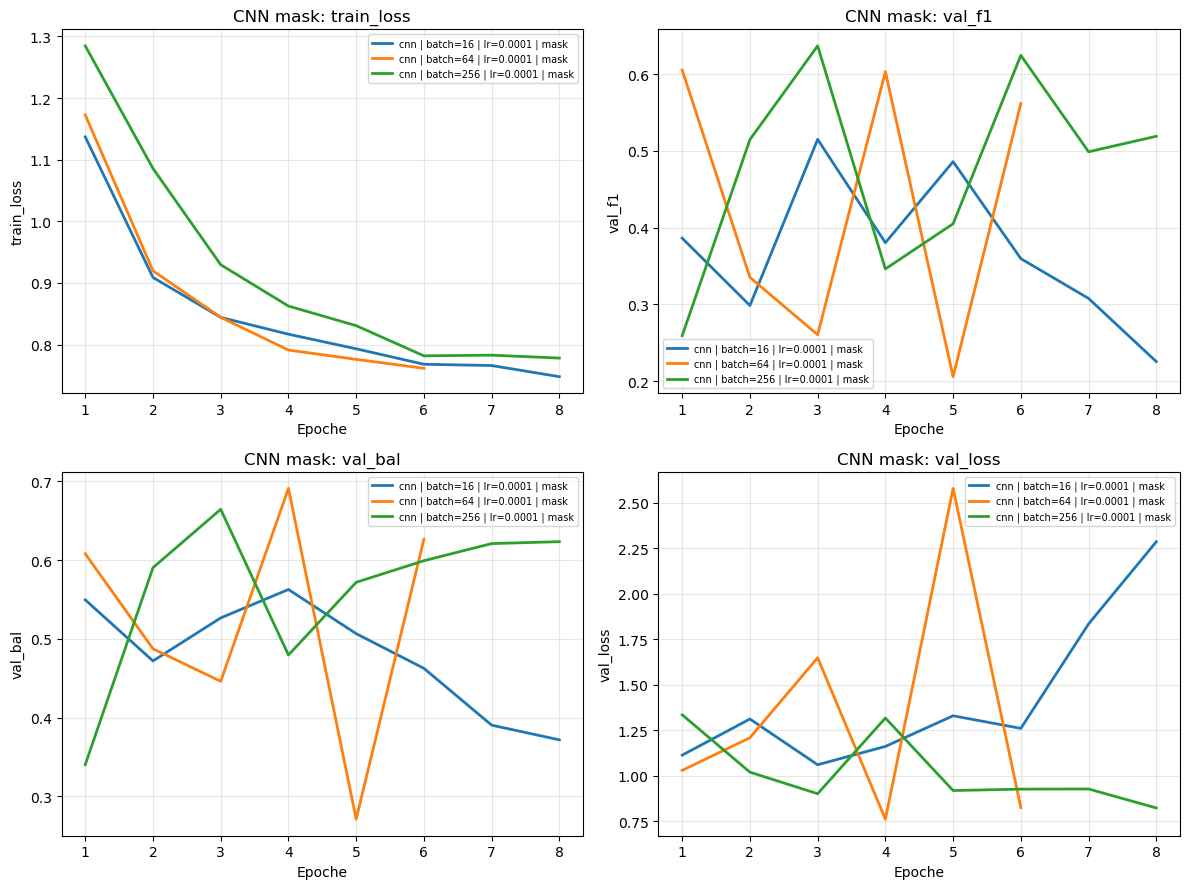


=== MODELLVERGLEICH (ROC micro) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.903)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.854)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.880)

=== MODELLVERGLEICH (ROC COVID) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.777)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.715)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.721)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.889)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.845)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.872)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
cnn | batch=16 | lr=0.0001 | mask (AUC=0.981)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.928)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.962)


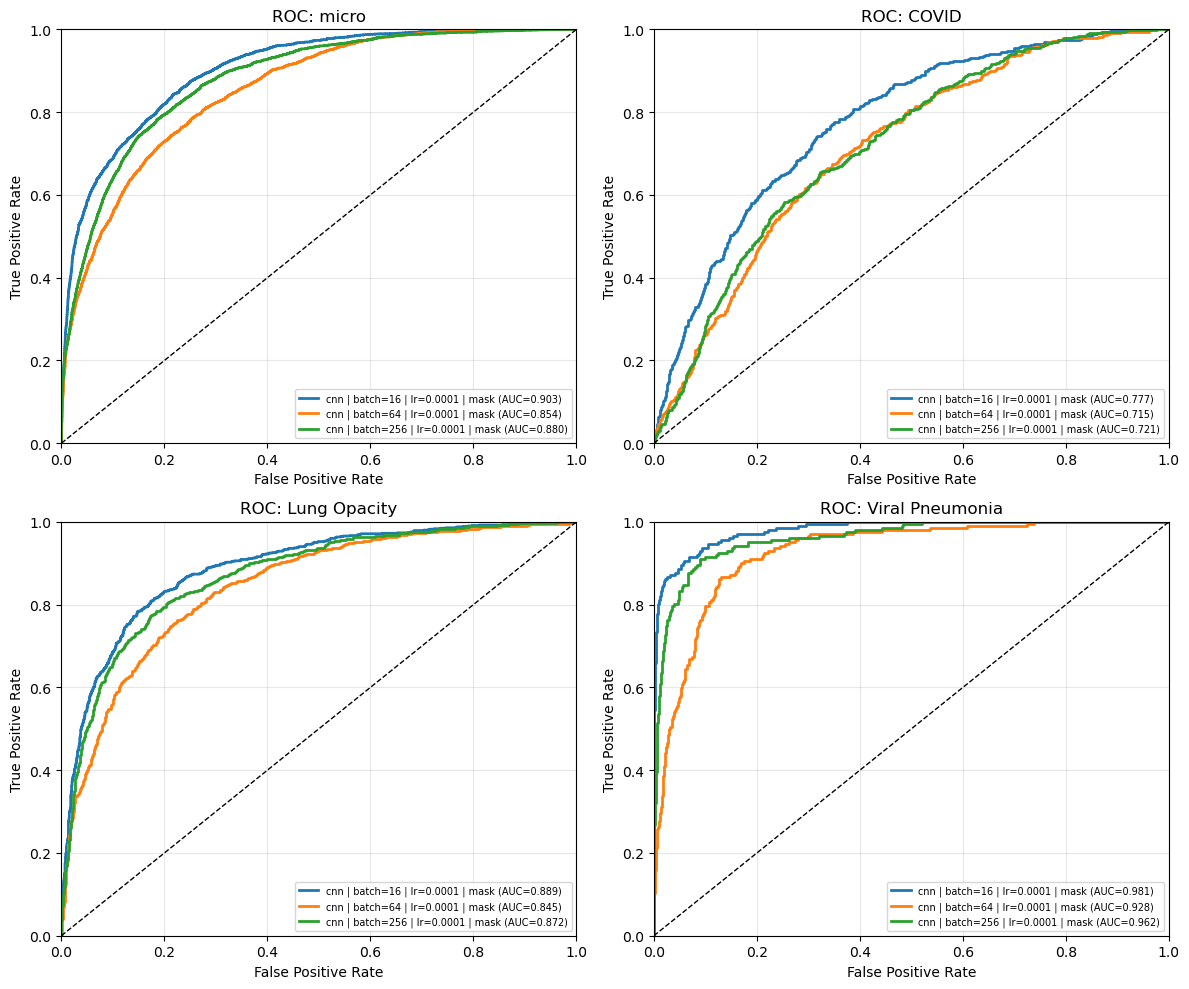

In [144]:
plot_train_overlays_grid(
    train_dirs_cnn_mask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="CNN mask"
)
plot_test_roc_overlays_grid(
    test_dirs_cnn_mask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [145]:
train_dirs_cnn_mask = []
test_dirs_cnn_mask  = []
for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "mask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=40,
        model_kind="cnn"
    )
    train_dirs_cnn_mask += t
    test_dirs_cnn_mask  += tt



=== SWEEP RUN: model=cnn | mode=mask | batch=64 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=64 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2996 | val_loss=1.2355 | val_f1=0.513 | val_bal=0.511 | 45.41s


Epoche 02: train_loss=1.2034 | val_loss=1.1594 | val_f1=0.401 | val_bal=0.517 | 45.36s


Epoche 03: train_loss=1.1059 | val_loss=1.0927 | val_f1=0.474 | val_bal=0.564 | 44.88s


Epoche 04: train_loss=1.0251 | val_loss=0.9996 | val_f1=0.575 | val_bal=0.636 | 45.35s


Epoche 05: train_loss=0.9685 | val_loss=0.9876 | val_f1=0.460 | val_bal=0.569 | 45.22s


Epoche 06: train_loss=0.9290 | val_loss=0.8898 | val_f1=0.556 | val_bal=0.650 | 44.69s


Epoche 07: train_loss=0.8973 | val_loss=0.9261 | val_f1=0.564 | val_bal=0.638 | 45.11s


Epoche 08: train_loss=0.8760 | val_loss=0.9102 | val_f1=0.529 | val_bal=0.590 | 44.52s


Epoche 09: train_loss=0.8561 | val_loss=0.8113 | val_f1=0.604 | val_bal=0.690 | 45.22s


Epoche 10: train_loss=0.8427 | val_loss=0.8465 | val_f1=0.661 | val_bal=0.672 | 45.02s


Epoche 11: train_loss=0.8284 | val_loss=0.7968 | val_f1=0.671 | val_bal=0.709 | 45.77s


Epoche 12: train_loss=0.8173 | val_loss=0.7909 | val_f1=0.604 | val_bal=0.680 | 45.13s


Epoche 13: train_loss=0.8020 | val_loss=0.8754 | val_f1=0.638 | val_bal=0.641 | 45.34s


Epoche 14: train_loss=0.7910 | val_loss=0.7509 | val_f1=0.664 | val_bal=0.734 | 45.76s


Epoche 15: train_loss=0.7816 | val_loss=0.7841 | val_f1=0.678 | val_bal=0.698 | 45.00s


Epoche 16: train_loss=0.7759 | val_loss=0.7521 | val_f1=0.695 | val_bal=0.721 | 45.24s


Epoche 17: train_loss=0.7690 | val_loss=0.7873 | val_f1=0.552 | val_bal=0.652 | 45.42s


Epoche 18: train_loss=0.7629 | val_loss=0.7886 | val_f1=0.686 | val_bal=0.693 | 45.44s


Epoche 19: train_loss=0.7645 | val_loss=0.7270 | val_f1=0.631 | val_bal=0.712 | 44.94s


Epoche 20: train_loss=0.7577 | val_loss=0.7423 | val_f1=0.657 | val_bal=0.694 | 45.26s


Epoche 21: train_loss=0.7487 | val_loss=0.7583 | val_f1=0.597 | val_bal=0.695 | 44.57s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1425_batch-64_lr-00001
[TEST-START] Model=cnn | Modus=mask | Batch=64
Pfad=cnn_mask_2025_08_31_1425_batch-64_lr-00001.pt


[test] F1(macro)=0.677 | BalAcc=0.706 | Zeit=8.37s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1425_batch-64_lr-00001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1425_batch-64_lr-00001 | F1=0.677 | BalAcc=0.706

=== SWEEP RUN: model=cnn | mode=mask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1521 | val_loss=2.1095 | val_f1=0.244 | val_bal=0.439 | 45.90s


Epoche 02: train_loss=0.9087 | val_loss=0.7999 | val_f1=0.625 | val_bal=0.698 | 44.95s


Epoche 03: train_loss=0.8139 | val_loss=1.1986 | val_f1=0.319 | val_bal=0.488 | 44.43s


Epoche 04: train_loss=0.7968 | val_loss=5.0062 | val_f1=0.030 | val_bal=0.250 | 44.45s


Epoche 05: train_loss=0.7642 | val_loss=0.8416 | val_f1=0.468 | val_bal=0.616 | 45.29s


Epoche 06: train_loss=0.7460 | val_loss=1.8396 | val_f1=0.237 | val_bal=0.343 | 45.34s


Epoche 07: train_loss=0.7184 | val_loss=2.0059 | val_f1=0.417 | val_bal=0.452 | 45.35s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1441_batch-64_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=64
Pfad=cnn_mask_2025_08_31_1441_batch-64_lr-0001.pt


[test] F1(macro)=0.613 | BalAcc=0.682 | Zeit=8.10s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1441_batch-64_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1441_batch-64_lr-0001 | F1=0.613 | BalAcc=0.682

=== SWEEP RUN: model=cnn | mode=mask | batch=64 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.2481 @idx=195 → vorgeschlagene LR=1.662e-02
[lr-finder] gewählte Start-LR: 1.662e-02

[TRAIN-START] Model=cnn | Modus=mask | Batch=64 | LR=0.016619883898707007 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1742 | val_loss=1.0406 | val_f1=0.435 | val_bal=0.543 | 45.59s


Epoche 02: train_loss=0.9198 | val_loss=1.1412 | val_f1=0.363 | val_bal=0.528 | 44.78s


Epoche 03: train_loss=0.8597 | val_loss=1.5361 | val_f1=0.273 | val_bal=0.430 | 45.13s


Epoche 04: train_loss=0.8443 | val_loss=1.1940 | val_f1=0.363 | val_bal=0.511 | 44.03s


Epoche 05: train_loss=0.8150 | val_loss=0.8952 | val_f1=0.657 | val_bal=0.648 | 44.81s


Epoche 06: train_loss=0.7859 | val_loss=1.2443 | val_f1=0.509 | val_bal=0.502 | 43.92s


Epoche 07: train_loss=0.7639 | val_loss=0.8330 | val_f1=0.558 | val_bal=0.651 | 44.18s


Epoche 08: train_loss=0.7658 | val_loss=0.9595 | val_f1=0.658 | val_bal=0.627 | 44.47s


Epoche 09: train_loss=0.7294 | val_loss=0.7251 | val_f1=0.615 | val_bal=0.700 | 44.27s


Epoche 10: train_loss=0.7317 | val_loss=1.0395 | val_f1=0.369 | val_bal=0.566 | 44.95s


Epoche 11: train_loss=0.7183 | val_loss=0.7553 | val_f1=0.584 | val_bal=0.690 | 45.39s


Epoche 12: train_loss=0.6957 | val_loss=0.6947 | val_f1=0.634 | val_bal=0.726 | 45.19s


Epoche 13: train_loss=0.6933 | val_loss=0.6469 | val_f1=0.682 | val_bal=0.736 | 45.18s


Epoche 14: train_loss=0.6650 | val_loss=0.7310 | val_f1=0.737 | val_bal=0.720 | 45.27s


Epoche 15: train_loss=0.6667 | val_loss=0.6926 | val_f1=0.736 | val_bal=0.732 | 44.98s


Epoche 16: train_loss=0.6395 | val_loss=2.5430 | val_f1=0.285 | val_bal=0.437 | 45.28s


Epoche 17: train_loss=0.6390 | val_loss=0.6358 | val_f1=0.727 | val_bal=0.755 | 45.20s


Epoche 18: train_loss=0.6183 | val_loss=0.6069 | val_f1=0.690 | val_bal=0.765 | 45.25s


Epoche 19: train_loss=0.6282 | val_loss=0.6001 | val_f1=0.743 | val_bal=0.762 | 45.38s


Epoche 20: train_loss=0.5980 | val_loss=0.5540 | val_f1=0.743 | val_bal=0.790 | 44.85s


Epoche 21: train_loss=0.5990 | val_loss=0.6102 | val_f1=0.649 | val_bal=0.754 | 44.72s


Epoche 22: train_loss=0.5922 | val_loss=0.6263 | val_f1=0.735 | val_bal=0.749 | 44.94s


Epoche 23: train_loss=0.5759 | val_loss=0.7131 | val_f1=0.569 | val_bal=0.703 | 44.92s


Epoche 24: train_loss=0.5699 | val_loss=0.5648 | val_f1=0.728 | val_bal=0.780 | 45.16s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1446_batch-64_lr-0016619883898707007
[TEST-START] Model=cnn | Modus=mask | Batch=64
Pfad=cnn_mask_2025_08_31_1446_batch-64_lr-0016619883898707007.pt


[test] F1(macro)=0.718 | BalAcc=0.743 | Zeit=8.05s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1446_batch-64_lr-0016619883898707007_test
[SWEEP] Modell=cnn_mask_2025_08_31_1446_batch-64_lr-0016619883898707007 | F1=0.718 | BalAcc=0.743

=== SWEEP RUN: model=cnn | mode=mask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=128 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3249 | val_loss=1.2706 | val_f1=0.470 | val_bal=0.533 | 46.00s


Epoche 02: train_loss=1.2609 | val_loss=1.2408 | val_f1=0.423 | val_bal=0.428 | 45.45s


Epoche 03: train_loss=1.2035 | val_loss=1.1632 | val_f1=0.529 | val_bal=0.567 | 46.22s


Epoche 04: train_loss=1.1376 | val_loss=1.1046 | val_f1=0.476 | val_bal=0.557 | 45.59s


Epoche 05: train_loss=1.0747 | val_loss=1.0955 | val_f1=0.370 | val_bal=0.493 | 46.15s


Epoche 06: train_loss=1.0265 | val_loss=1.0491 | val_f1=0.434 | val_bal=0.560 | 45.29s


Epoche 07: train_loss=0.9832 | val_loss=0.9508 | val_f1=0.540 | val_bal=0.657 | 45.75s


Epoche 08: train_loss=0.9449 | val_loss=0.9150 | val_f1=0.619 | val_bal=0.669 | 45.15s


Epoche 09: train_loss=0.9246 | val_loss=0.9022 | val_f1=0.550 | val_bal=0.642 | 44.98s


Epoche 10: train_loss=0.9061 | val_loss=0.9131 | val_f1=0.519 | val_bal=0.624 | 45.33s


Epoche 11: train_loss=0.8915 | val_loss=0.8595 | val_f1=0.613 | val_bal=0.673 | 44.73s


Epoche 12: train_loss=0.8695 | val_loss=1.0675 | val_f1=0.412 | val_bal=0.553 | 44.71s


Epoche 13: train_loss=0.8578 | val_loss=0.8403 | val_f1=0.577 | val_bal=0.668 | 45.86s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1505_batch-128_lr-00001
[TEST-START] Model=cnn | Modus=mask | Batch=128
Pfad=cnn_mask_2025_08_31_1505_batch-128_lr-00001.pt


[test] F1(macro)=0.609 | BalAcc=0.657 | Zeit=8.74s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1505_batch-128_lr-00001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1505_batch-128_lr-00001 | F1=0.609 | BalAcc=0.657

=== SWEEP RUN: model=cnn | mode=mask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=128 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2415 | val_loss=1.1527 | val_f1=0.410 | val_bal=0.541 | 46.16s


Epoche 02: train_loss=1.0143 | val_loss=0.9603 | val_f1=0.623 | val_bal=0.633 | 45.22s


Epoche 03: train_loss=0.8811 | val_loss=0.8377 | val_f1=0.603 | val_bal=0.681 | 45.01s


Epoche 04: train_loss=0.8263 | val_loss=1.1750 | val_f1=0.487 | val_bal=0.485 | 45.90s


Epoche 05: train_loss=0.7800 | val_loss=0.7378 | val_f1=0.678 | val_bal=0.720 | 44.92s


Epoche 06: train_loss=0.7716 | val_loss=1.0334 | val_f1=0.625 | val_bal=0.602 | 44.91s


Epoche 07: train_loss=0.7540 | val_loss=0.7431 | val_f1=0.565 | val_bal=0.666 | 44.38s


Epoche 08: train_loss=0.7266 | val_loss=0.7741 | val_f1=0.698 | val_bal=0.679 | 45.12s


Epoche 09: train_loss=0.7232 | val_loss=0.6470 | val_f1=0.682 | val_bal=0.753 | 46.34s


Epoche 10: train_loss=0.7210 | val_loss=1.5187 | val_f1=0.379 | val_bal=0.408 | 46.35s


Epoche 11: train_loss=0.6932 | val_loss=1.6429 | val_f1=0.441 | val_bal=0.450 | 45.14s


Epoche 12: train_loss=0.6856 | val_loss=0.9079 | val_f1=0.474 | val_bal=0.584 | 45.25s


Epoche 13: train_loss=0.6808 | val_loss=2.1892 | val_f1=0.246 | val_bal=0.416 | 45.24s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1515_batch-128_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=128
Pfad=cnn_mask_2025_08_31_1515_batch-128_lr-0001.pt


[test] F1(macro)=0.690 | BalAcc=0.671 | Zeit=8.38s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1515_batch-128_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1515_batch-128_lr-0001 | F1=0.690 | BalAcc=0.671

=== SWEEP RUN: model=cnn | mode=mask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.2056 @idx=195 → vorgeschlagene LR=1.662e-02
[lr-finder] gewählte Start-LR: 1.662e-02

[TRAIN-START] Model=cnn | Modus=mask | Batch=128 | LR=0.016619883898707007 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3412 | val_loss=1.3174 | val_f1=0.202 | val_bal=0.372 | 46.38s


Epoche 02: train_loss=1.1132 | val_loss=6.6279 | val_f1=0.172 | val_bal=0.255 | 44.95s


Epoche 03: train_loss=0.9075 | val_loss=1.1726 | val_f1=0.379 | val_bal=0.538 | 45.57s


Epoche 04: train_loss=0.8380 | val_loss=3.0890 | val_f1=0.250 | val_bal=0.374 | 45.68s


Epoche 05: train_loss=0.8336 | val_loss=0.9421 | val_f1=0.621 | val_bal=0.616 | 46.41s


Epoche 06: train_loss=0.8158 | val_loss=0.7746 | val_f1=0.594 | val_bal=0.677 | 45.70s


Epoche 07: train_loss=0.7700 | val_loss=0.7594 | val_f1=0.613 | val_bal=0.681 | 45.13s


Epoche 08: train_loss=0.7738 | val_loss=0.9883 | val_f1=0.462 | val_bal=0.574 | 45.22s


Epoche 09: train_loss=0.7456 | val_loss=0.6989 | val_f1=0.684 | val_bal=0.731 | 44.98s


Epoche 10: train_loss=0.7518 | val_loss=0.7799 | val_f1=0.685 | val_bal=0.683 | 44.59s


Epoche 11: train_loss=0.7195 | val_loss=0.6627 | val_f1=0.695 | val_bal=0.740 | 45.34s


Epoche 12: train_loss=0.7054 | val_loss=0.6992 | val_f1=0.648 | val_bal=0.698 | 45.88s


Epoche 13: train_loss=0.6845 | val_loss=0.7229 | val_f1=0.604 | val_bal=0.715 | 45.56s


Epoche 14: train_loss=0.6872 | val_loss=0.7436 | val_f1=0.671 | val_bal=0.695 | 44.93s


Epoche 15: train_loss=0.6558 | val_loss=0.7143 | val_f1=0.727 | val_bal=0.733 | 45.63s


Epoche 16: train_loss=0.6532 | val_loss=0.9530 | val_f1=0.473 | val_bal=0.634 | 44.25s


Epoche 17: train_loss=0.6409 | val_loss=0.7471 | val_f1=0.589 | val_bal=0.689 | 45.07s


Epoche 18: train_loss=0.6146 | val_loss=0.5710 | val_f1=0.741 | val_bal=0.784 | 45.00s


Epoche 19: train_loss=0.6105 | val_loss=0.6646 | val_f1=0.693 | val_bal=0.736 | 44.59s


Epoche 20: train_loss=0.6108 | val_loss=0.6534 | val_f1=0.672 | val_bal=0.729 | 45.08s


Epoche 21: train_loss=0.5997 | val_loss=0.7207 | val_f1=0.717 | val_bal=0.728 | 45.95s


Epoche 22: train_loss=0.5973 | val_loss=0.6729 | val_f1=0.623 | val_bal=0.728 | 45.31s


Epoche 23: train_loss=0.5835 | val_loss=0.6810 | val_f1=0.738 | val_bal=0.750 | 45.21s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1525_batch-128_lr-0016619883898707007
[TEST-START] Model=cnn | Modus=mask | Batch=128
Pfad=cnn_mask_2025_08_31_1525_batch-128_lr-0016619883898707007.pt


[test] F1(macro)=0.734 | BalAcc=0.775 | Zeit=8.38s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1525_batch-128_lr-0016619883898707007_test
[SWEEP] Modell=cnn_mask_2025_08_31_1525_batch-128_lr-0016619883898707007 | F1=0.734 | BalAcc=0.775

=== SWEEP RUN: model=cnn | mode=mask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=256 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3391 | val_loss=1.2904 | val_f1=0.385 | val_bal=0.453 | 45.47s


Epoche 02: train_loss=1.2746 | val_loss=1.2536 | val_f1=0.388 | val_bal=0.405 | 44.72s


Epoche 03: train_loss=1.2267 | val_loss=1.1911 | val_f1=0.494 | val_bal=0.573 | 45.41s


Epoche 04: train_loss=1.1765 | val_loss=1.1777 | val_f1=0.534 | val_bal=0.518 | 45.92s


Epoche 05: train_loss=1.1238 | val_loss=1.1072 | val_f1=0.590 | val_bal=0.579 | 45.04s


Epoche 06: train_loss=1.0771 | val_loss=1.0579 | val_f1=0.595 | val_bal=0.614 | 44.59s


Epoche 07: train_loss=1.0345 | val_loss=1.0017 | val_f1=0.596 | val_bal=0.637 | 45.03s


Epoche 08: train_loss=1.0019 | val_loss=0.9625 | val_f1=0.548 | val_bal=0.647 | 44.99s


Epoche 09: train_loss=0.9721 | val_loss=0.9719 | val_f1=0.637 | val_bal=0.633 | 45.82s


Epoche 10: train_loss=0.9469 | val_loss=0.9843 | val_f1=0.461 | val_bal=0.573 | 45.20s


Epoche 11: train_loss=0.9304 | val_loss=0.9491 | val_f1=0.459 | val_bal=0.592 | 44.41s


Epoche 12: train_loss=0.9066 | val_loss=0.8933 | val_f1=0.546 | val_bal=0.652 | 45.31s


Epoche 13: train_loss=0.9040 | val_loss=0.8789 | val_f1=0.558 | val_bal=0.658 | 44.60s


Epoche 14: train_loss=0.8867 | val_loss=0.8545 | val_f1=0.616 | val_bal=0.692 | 45.15s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1544_batch-256_lr-00001
[TEST-START] Model=cnn | Modus=mask | Batch=256
Pfad=cnn_mask_2025_08_31_1544_batch-256_lr-00001.pt


[test] F1(macro)=0.625 | BalAcc=0.628 | Zeit=8.77s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1544_batch-256_lr-00001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1544_batch-256_lr-00001 | F1=0.625 | BalAcc=0.628

=== SWEEP RUN: model=cnn | mode=mask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=mask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3012 | val_loss=1.2844 | val_f1=0.365 | val_bal=0.376 | 46.29s


Epoche 02: train_loss=1.1448 | val_loss=1.4054 | val_f1=0.215 | val_bal=0.276 | 44.85s


Epoche 03: train_loss=0.9937 | val_loss=0.9490 | val_f1=0.467 | val_bal=0.593 | 45.10s


Epoche 04: train_loss=0.9350 | val_loss=0.8490 | val_f1=0.597 | val_bal=0.673 | 44.54s


Epoche 05: train_loss=0.8453 | val_loss=1.0173 | val_f1=0.432 | val_bal=0.559 | 44.36s


Epoche 06: train_loss=0.8295 | val_loss=0.8163 | val_f1=0.563 | val_bal=0.666 | 44.84s


Epoche 07: train_loss=0.8079 | val_loss=0.8694 | val_f1=0.509 | val_bal=0.624 | 46.38s


Epoche 08: train_loss=0.7903 | val_loss=0.7760 | val_f1=0.627 | val_bal=0.658 | 45.18s


Epoche 09: train_loss=0.7669 | val_loss=0.8473 | val_f1=0.523 | val_bal=0.631 | 44.95s


Epoche 10: train_loss=0.7546 | val_loss=0.9215 | val_f1=0.503 | val_bal=0.600 | 46.37s


Epoche 11: train_loss=0.7553 | val_loss=2.6526 | val_f1=0.068 | val_bal=0.270 | 45.53s


Epoche 12: train_loss=0.7460 | val_loss=1.2513 | val_f1=0.501 | val_bal=0.493 | 45.66s


Epoche 13: train_loss=0.7335 | val_loss=0.9165 | val_f1=0.475 | val_bal=0.590 | 45.76s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1554_batch-256_lr-0001
[TEST-START] Model=cnn | Modus=mask | Batch=256
Pfad=cnn_mask_2025_08_31_1554_batch-256_lr-0001.pt


[test] F1(macro)=0.615 | BalAcc=0.655 | Zeit=8.47s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1554_batch-256_lr-0001_test
[SWEEP] Modell=cnn_mask_2025_08_31_1554_batch-256_lr-0001 | F1=0.615 | BalAcc=0.655

=== SWEEP RUN: model=cnn | mode=mask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1296 @idx=199 → vorgeschlagene LR=2.000e-02
[lr-finder] gewählte Start-LR: 2.000e-02

[TRAIN-START] Model=cnn | Modus=mask | Batch=256 | LR=0.020000000000000268 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.3481 | val_loss=3.4092 | val_f1=0.163 | val_bal=0.250 | 46.73s


Epoche 02: train_loss=1.1462 | val_loss=1.2075 | val_f1=0.404 | val_bal=0.402 | 45.65s


Epoche 03: train_loss=0.9365 | val_loss=2.6589 | val_f1=0.116 | val_bal=0.297 | 45.39s


Epoche 04: train_loss=0.8697 | val_loss=0.8403 | val_f1=0.523 | val_bal=0.635 | 45.04s


Epoche 05: train_loss=0.8367 | val_loss=0.9581 | val_f1=0.496 | val_bal=0.627 | 44.97s


Epoche 06: train_loss=0.8035 | val_loss=1.2517 | val_f1=0.382 | val_bal=0.532 | 44.49s


Epoche 07: train_loss=0.8108 | val_loss=1.3091 | val_f1=0.316 | val_bal=0.487 | 44.20s


Epoche 08: train_loss=0.7717 | val_loss=0.7235 | val_f1=0.626 | val_bal=0.706 | 44.36s


Epoche 09: train_loss=0.7610 | val_loss=1.2513 | val_f1=0.473 | val_bal=0.496 | 44.23s


Epoche 10: train_loss=0.7385 | val_loss=2.7829 | val_f1=0.175 | val_bal=0.343 | 44.51s


Epoche 11: train_loss=0.7249 | val_loss=0.7177 | val_f1=0.605 | val_bal=0.697 | 45.14s


Epoche 12: train_loss=0.7096 | val_loss=14.7257 | val_f1=0.178 | val_bal=0.284 | 44.70s


Epoche 13: train_loss=0.6960 | val_loss=4.0013 | val_f1=0.399 | val_bal=0.446 | 45.08s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_mask_2025_08_31_1604_batch-256_lr-0020000000000000268
[TEST-START] Model=cnn | Modus=mask | Batch=256
Pfad=cnn_mask_2025_08_31_1604_batch-256_lr-0020000000000000268.pt


[test] F1(macro)=0.625 | BalAcc=0.703 | Zeit=8.26s | /home/lupan001/ML/results/cnn_mask_2025_08_31_1604_batch-256_lr-0020000000000000268_test
[SWEEP] Modell=cnn_mask_2025_08_31_1604_batch-256_lr-0020000000000000268 | F1=0.625 | BalAcc=0.703



=== MODELLVERGLEICH (Train train_loss) ===
cnn | batch=128 | lr=0.0001 | mask | train_loss max=1.2415
cnn | batch=128 | lr=0.001662 | mask | train_loss max=1.3412
cnn | batch=128 | lr=1e-05 | mask | train_loss max=1.3249
cnn | batch=256 | lr=0.0001 | mask | train_loss max=1.3012
cnn | batch=256 | lr=0.002 | mask | train_loss max=1.3481
cnn | batch=256 | lr=1e-05 | mask | train_loss max=1.3391
cnn | batch=64 | lr=0.0001 | mask | train_loss max=1.1521
cnn | batch=64 | lr=0.001662 | mask | train_loss max=1.1742
cnn | batch=64 | lr=1e-05 | mask | train_loss max=1.2996

=== MODELLVERGLEICH (Train val_f1) ===
cnn | batch=128 | lr=0.0001 | mask | val_f1 max=0.6985
cnn | batch=128 | lr=0.001662 | mask | val_f1 max=0.7411
cnn | batch=128 | lr=1e-05 | mask | val_f1 max=0.6188
cnn | batch=256 | lr=0.0001 | mask | val_f1 max=0.6271
cnn | batch=256 | lr=0.002 | mask | val_f1 max=0.6264
cnn | batch=256 | lr=1e-05 | mask | val_f1 max=0.6369
cnn | batch=64 | lr=0.0001 | mask | val_f1 max=0.6245
cnn |

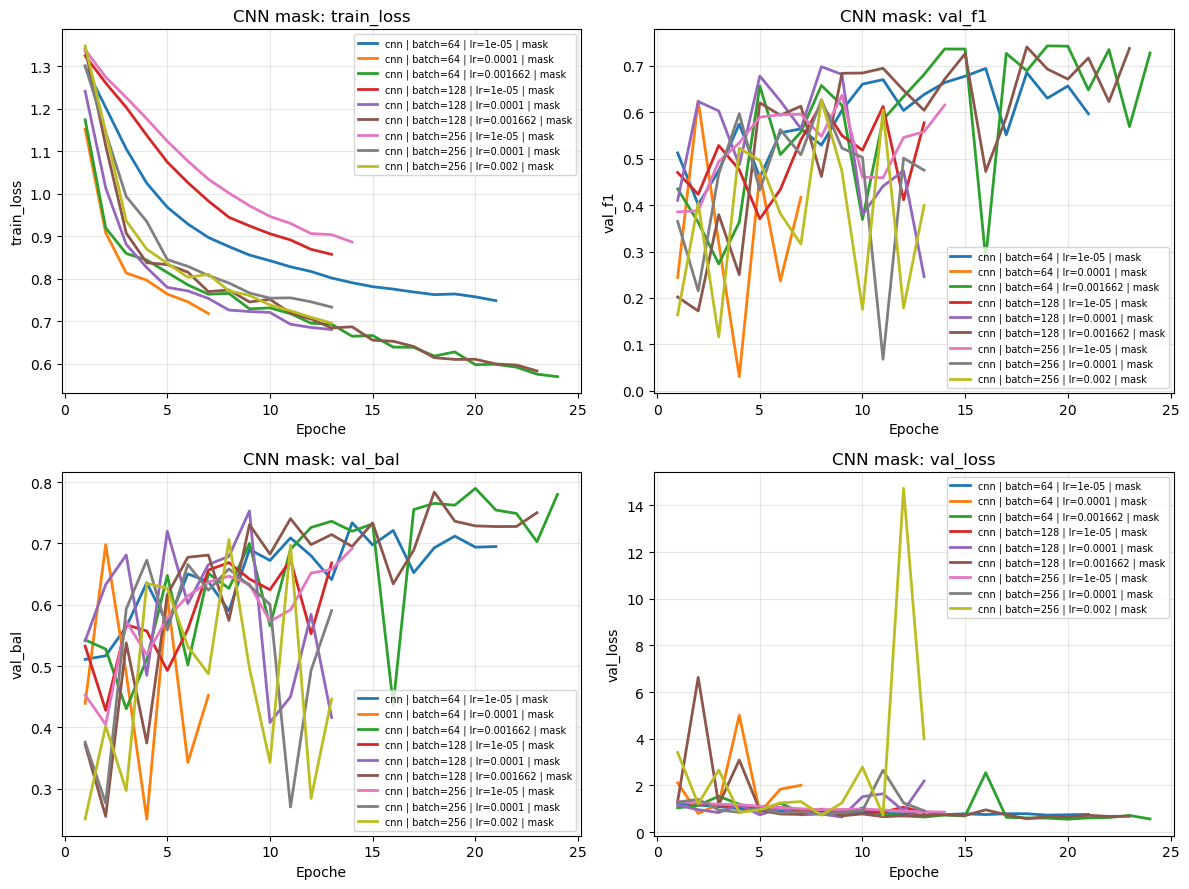


=== MODELLVERGLEICH (ROC micro) ===
cnn | batch=64 | lr=1e-05 | mask (AUC=0.903)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.857)
cnn | batch=64 | lr=0.001662 | mask (AUC=0.940)
cnn | batch=128 | lr=1e-05 | mask (AUC=0.874)
cnn | batch=128 | lr=0.0001 | mask (AUC=0.925)
cnn | batch=128 | lr=0.001662 | mask (AUC=0.931)
cnn | batch=256 | lr=1e-05 | mask (AUC=0.881)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.909)
cnn | batch=256 | lr=0.002 | mask (AUC=0.882)

=== MODELLVERGLEICH (ROC COVID) ===
cnn | batch=64 | lr=1e-05 | mask (AUC=0.799)
cnn | batch=64 | lr=0.0001 | mask (AUC=0.751)
cnn | batch=64 | lr=0.001662 | mask (AUC=0.888)
cnn | batch=128 | lr=1e-05 | mask (AUC=0.736)
cnn | batch=128 | lr=0.0001 | mask (AUC=0.809)
cnn | batch=128 | lr=0.001662 | mask (AUC=0.887)
cnn | batch=256 | lr=1e-05 | mask (AUC=0.725)
cnn | batch=256 | lr=0.0001 | mask (AUC=0.760)
cnn | batch=256 | lr=0.002 | mask (AUC=0.786)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
cnn | batch=64 | lr=1e-05 | mask (AUC=0.89

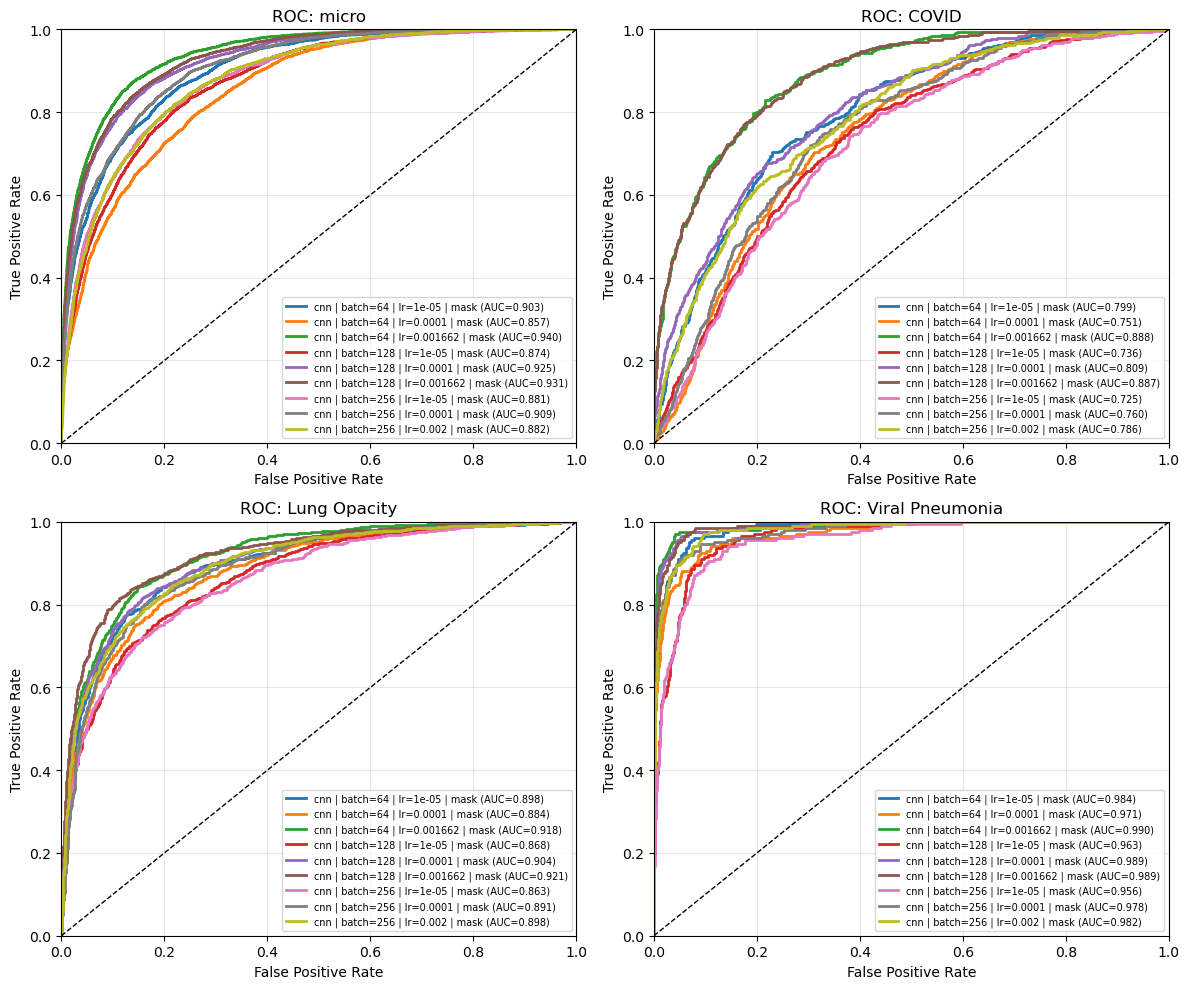

In [146]:
plot_train_overlays_grid(
    train_dirs_cnn_mask,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="CNN mask"
)
plot_test_roc_overlays_grid(
    test_dirs_cnn_mask,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [147]:
train_dirs_cnn_nomask_batch, test_dirs_cnn_nomask_batch = run_sweep_train_test(
    "nomask",
    batches=[16, 64, 256],
    fixed_lr=1e-3,
    epochs=40,
    model_kind="cnn"
)



=== SWEEP RUN: model=cnn | mode=nomask | batch=16 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=16 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0289 | val_loss=0.9201 | val_f1=0.560 | val_bal=0.644 | 28.80s


Epoche 02: train_loss=0.8510 | val_loss=0.9224 | val_f1=0.559 | val_bal=0.606 | 28.11s


Epoche 03: train_loss=0.7859 | val_loss=0.7073 | val_f1=0.677 | val_bal=0.736 | 28.42s


Epoche 04: train_loss=0.7241 | val_loss=0.6837 | val_f1=0.716 | val_bal=0.739 | 28.07s


Epoche 05: train_loss=0.6846 | val_loss=0.6132 | val_f1=0.717 | val_bal=0.777 | 28.54s


Epoche 06: train_loss=0.6344 | val_loss=0.5932 | val_f1=0.797 | val_bal=0.785 | 28.73s


Epoche 07: train_loss=0.6044 | val_loss=0.5594 | val_f1=0.795 | val_bal=0.809 | 28.29s


Epoche 08: train_loss=0.5855 | val_loss=0.6496 | val_f1=0.610 | val_bal=0.759 | 28.31s


Epoche 09: train_loss=0.5561 | val_loss=0.7333 | val_f1=0.580 | val_bal=0.731 | 28.11s


Epoche 10: train_loss=0.5406 | val_loss=0.5202 | val_f1=0.769 | val_bal=0.814 | 27.50s


Epoche 11: train_loss=0.5195 | val_loss=0.5060 | val_f1=0.745 | val_bal=0.803 | 28.02s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1616_batch-16_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=16
Pfad=cnn_nomask_2025_08_31_1616_batch-16_lr-0001.pt


[test] F1(macro)=0.781 | BalAcc=0.779 | Zeit=4.94s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1616_batch-16_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1616_batch-16_lr-0001 | F1=0.781 | BalAcc=0.779

=== SWEEP RUN: model=cnn | mode=nomask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0263 | val_loss=0.9215 | val_f1=0.538 | val_bal=0.642 | 29.15s


Epoche 02: train_loss=0.8371 | val_loss=0.9350 | val_f1=0.636 | val_bal=0.619 | 28.05s


Epoche 03: train_loss=0.7719 | val_loss=0.7657 | val_f1=0.622 | val_bal=0.709 | 27.96s


Epoche 04: train_loss=0.7326 | val_loss=1.0914 | val_f1=0.551 | val_bal=0.549 | 28.42s


Epoche 05: train_loss=0.6843 | val_loss=0.6936 | val_f1=0.696 | val_bal=0.737 | 28.41s


Epoche 06: train_loss=0.6506 | val_loss=0.8175 | val_f1=0.574 | val_bal=0.667 | 28.15s


Epoche 07: train_loss=0.6273 | val_loss=0.7799 | val_f1=0.708 | val_bal=0.690 | 28.37s


Epoche 08: train_loss=0.6154 | val_loss=0.5623 | val_f1=0.740 | val_bal=0.806 | 28.59s


Epoche 09: train_loss=0.5881 | val_loss=0.5324 | val_f1=0.728 | val_bal=0.806 | 28.12s


Epoche 10: train_loss=0.5846 | val_loss=0.5326 | val_f1=0.748 | val_bal=0.815 | 27.85s


Epoche 11: train_loss=0.5460 | val_loss=0.5174 | val_f1=0.753 | val_bal=0.823 | 28.00s


Epoche 12: train_loss=0.5329 | val_loss=0.5297 | val_f1=0.764 | val_bal=0.806 | 28.30s


Epoche 13: train_loss=0.5233 | val_loss=0.5809 | val_f1=0.688 | val_bal=0.784 | 28.24s


Epoche 14: train_loss=0.5089 | val_loss=0.7012 | val_f1=0.594 | val_bal=0.725 | 28.03s


Epoche 15: train_loss=0.5047 | val_loss=0.4716 | val_f1=0.833 | val_bal=0.840 | 28.47s


Epoche 16: train_loss=0.4809 | val_loss=0.6871 | val_f1=0.640 | val_bal=0.720 | 28.63s


Epoche 17: train_loss=0.4798 | val_loss=0.4998 | val_f1=0.714 | val_bal=0.804 | 28.36s


Epoche 18: train_loss=0.4691 | val_loss=0.5750 | val_f1=0.749 | val_bal=0.777 | 27.95s


Epoche 19: train_loss=0.4631 | val_loss=0.4281 | val_f1=0.848 | val_bal=0.838 | 28.12s


Epoche 20: train_loss=0.4345 | val_loss=0.7978 | val_f1=0.530 | val_bal=0.671 | 28.26s


Epoche 21: train_loss=0.4420 | val_loss=0.3834 | val_f1=0.856 | val_bal=0.864 | 28.10s


Epoche 22: train_loss=0.4389 | val_loss=1.0150 | val_f1=0.503 | val_bal=0.594 | 28.79s


Epoche 23: train_loss=0.4210 | val_loss=0.5305 | val_f1=0.788 | val_bal=0.796 | 28.57s


Epoche 24: train_loss=0.4164 | val_loss=0.4004 | val_f1=0.789 | val_bal=0.855 | 28.31s


Epoche 25: train_loss=0.4093 | val_loss=0.5658 | val_f1=0.667 | val_bal=0.787 | 28.58s


Epoche 26: train_loss=0.4162 | val_loss=0.4248 | val_f1=0.846 | val_bal=0.836 | 28.23s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1622_batch-64_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=64
Pfad=cnn_nomask_2025_08_31_1622_batch-64_lr-0001.pt


[test] F1(macro)=0.840 | BalAcc=0.852 | Zeit=5.11s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1622_batch-64_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1622_batch-64_lr-0001 | F1=0.840 | BalAcc=0.852

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1167 | val_loss=1.0935 | val_f1=0.422 | val_bal=0.550 | 29.03s


Epoche 02: train_loss=0.9082 | val_loss=1.0107 | val_f1=0.491 | val_bal=0.594 | 28.44s


Epoche 03: train_loss=0.8266 | val_loss=0.9094 | val_f1=0.538 | val_bal=0.656 | 28.06s


Epoche 04: train_loss=0.7862 | val_loss=0.8299 | val_f1=0.620 | val_bal=0.666 | 28.57s


Epoche 05: train_loss=0.7622 | val_loss=0.8353 | val_f1=0.712 | val_bal=0.684 | 28.32s


Epoche 06: train_loss=0.7194 | val_loss=0.7469 | val_f1=0.653 | val_bal=0.686 | 28.28s


Epoche 07: train_loss=0.7156 | val_loss=0.7951 | val_f1=0.557 | val_bal=0.675 | 28.19s


Epoche 08: train_loss=0.6870 | val_loss=0.8497 | val_f1=0.510 | val_bal=0.662 | 28.11s


Epoche 09: train_loss=0.6722 | val_loss=0.6427 | val_f1=0.683 | val_bal=0.756 | 28.12s


Epoche 10: train_loss=0.6294 | val_loss=0.6704 | val_f1=0.640 | val_bal=0.735 | 27.72s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1634_batch-256_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_31_1634_batch-256_lr-0001.pt


[test] F1(macro)=0.677 | BalAcc=0.649 | Zeit=5.29s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1634_batch-256_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1634_batch-256_lr-0001 | F1=0.677 | BalAcc=0.649



=== MODELLVERGLEICH (Train train_loss) ===
cnn | batch=16 | lr=0.0001 | nomask | train_loss max=1.0289
cnn | batch=256 | lr=0.0001 | nomask | train_loss max=1.1167
cnn | batch=64 | lr=0.0001 | nomask | train_loss max=1.0263

=== MODELLVERGLEICH (Train val_f1) ===
cnn | batch=16 | lr=0.0001 | nomask | val_f1 max=0.7968
cnn | batch=256 | lr=0.0001 | nomask | val_f1 max=0.7125
cnn | batch=64 | lr=0.0001 | nomask | val_f1 max=0.8561

=== MODELLVERGLEICH (Train val_bal) ===
cnn | batch=16 | lr=0.0001 | nomask | val_bal max=0.8138
cnn | batch=256 | lr=0.0001 | nomask | val_bal max=0.7561
cnn | batch=64 | lr=0.0001 | nomask | val_bal max=0.8637

=== MODELLVERGLEICH (Train val_loss) ===
cnn | batch=16 | lr=0.0001 | nomask | val_loss max=0.9224
cnn | batch=256 | lr=0.0001 | nomask | val_loss max=1.0935
cnn | batch=64 | lr=0.0001 | nomask | val_loss max=1.0914


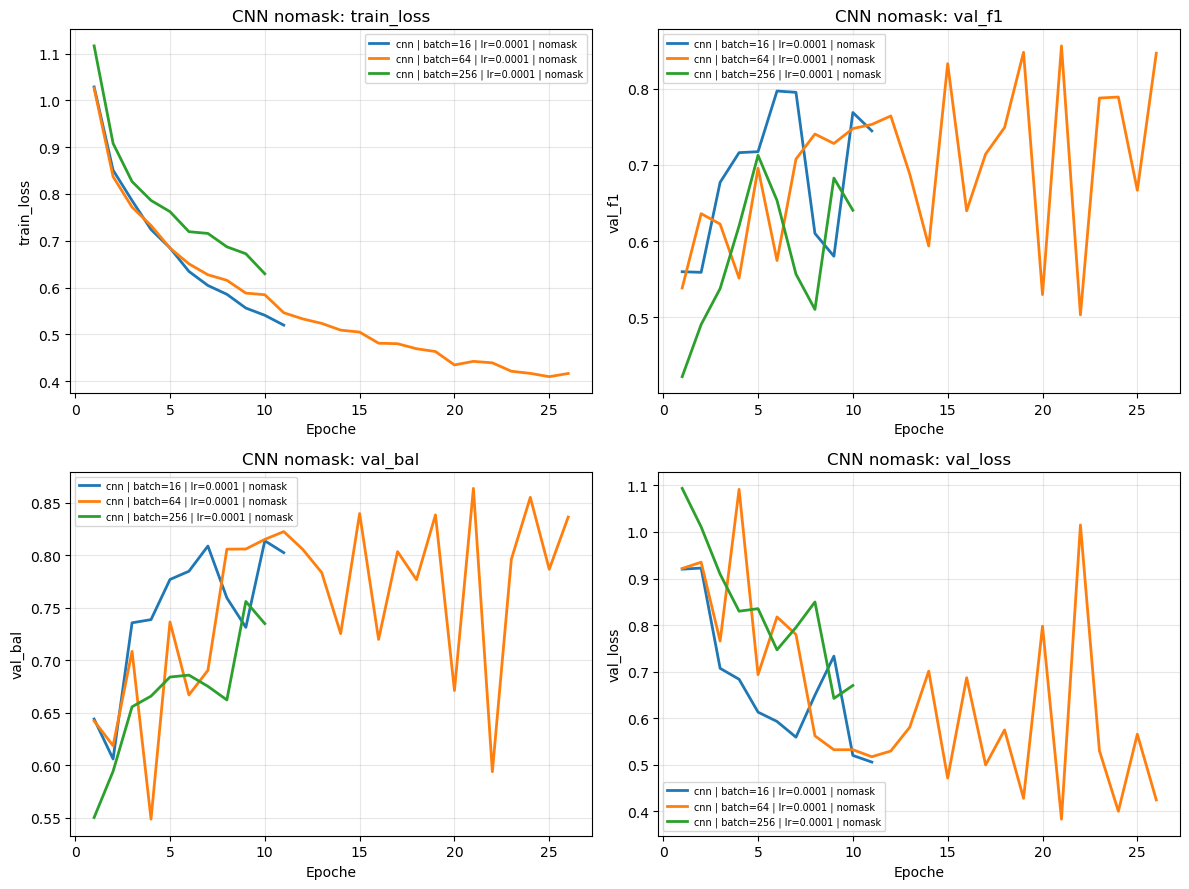


=== MODELLVERGLEICH (ROC micro) ===
cnn | batch=16 | lr=0.0001 | nomask (AUC=0.940)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.969)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.910)

=== MODELLVERGLEICH (ROC COVID) ===
cnn | batch=16 | lr=0.0001 | nomask (AUC=0.922)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.979)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.841)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
cnn | batch=16 | lr=0.0001 | nomask (AUC=0.910)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.942)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.877)

=== MODELLVERGLEICH (ROC Viral Pneumonia) ===
cnn | batch=16 | lr=0.0001 | nomask (AUC=0.992)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.998)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.981)


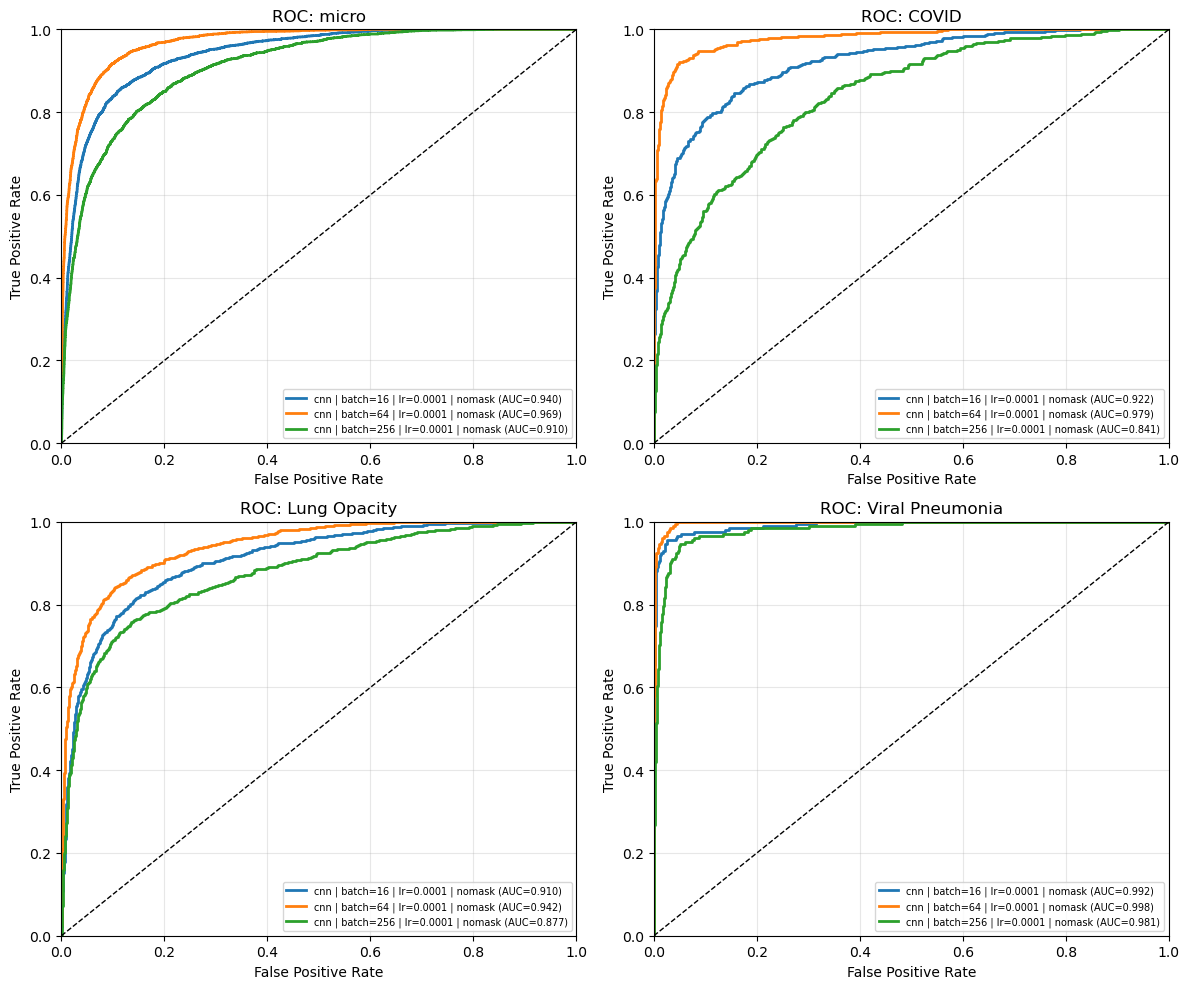

In [148]:
plot_train_overlays_grid(
    train_dirs_cnn_nomask_batch,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="CNN nomask"
)
plot_test_roc_overlays_grid(
    test_dirs_cnn_nomask_batch,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)


In [149]:
train_dirs_cnn_nomask = []
test_dirs_cnn_nomask  = []
for b in [64, 128, 256]:
    t, tt = run_sweep_train_test(
        "nomask",
        lrs=[1e-4, 1e-3, "auto"],
        fixed_batch=b,
        epochs=40,
        model_kind="cnn"
    )
    train_dirs_cnn_nomask += t
    test_dirs_cnn_nomask  += tt



=== SWEEP RUN: model=cnn | mode=nomask | batch=64 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1935 | val_loss=1.1074 | val_f1=0.535 | val_bal=0.612 | 29.11s


Epoche 02: train_loss=1.0422 | val_loss=0.9939 | val_f1=0.548 | val_bal=0.643 | 28.18s


Epoche 03: train_loss=0.9745 | val_loss=0.9377 | val_f1=0.599 | val_bal=0.650 | 28.03s


Epoche 04: train_loss=0.9241 | val_loss=0.8781 | val_f1=0.631 | val_bal=0.689 | 28.50s


Epoche 05: train_loss=0.8838 | val_loss=0.8444 | val_f1=0.634 | val_bal=0.711 | 27.92s


Epoche 06: train_loss=0.8487 | val_loss=0.8448 | val_f1=0.585 | val_bal=0.682 | 28.28s


Epoche 07: train_loss=0.8189 | val_loss=0.8238 | val_f1=0.641 | val_bal=0.702 | 28.39s


Epoche 08: train_loss=0.8037 | val_loss=0.7760 | val_f1=0.633 | val_bal=0.694 | 28.21s


Epoche 09: train_loss=0.7875 | val_loss=0.7547 | val_f1=0.697 | val_bal=0.727 | 27.94s


Epoche 10: train_loss=0.7715 | val_loss=0.7301 | val_f1=0.710 | val_bal=0.754 | 28.19s


Epoche 11: train_loss=0.7486 | val_loss=0.7216 | val_f1=0.731 | val_bal=0.762 | 27.87s


Epoche 12: train_loss=0.7471 | val_loss=0.7295 | val_f1=0.703 | val_bal=0.734 | 27.92s


Epoche 13: train_loss=0.7254 | val_loss=0.7184 | val_f1=0.656 | val_bal=0.727 | 27.97s


Epoche 14: train_loss=0.7113 | val_loss=0.7796 | val_f1=0.615 | val_bal=0.696 | 28.19s


Epoche 15: train_loss=0.7078 | val_loss=0.7738 | val_f1=0.755 | val_bal=0.735 | 28.08s


Epoche 16: train_loss=0.6882 | val_loss=0.6599 | val_f1=0.741 | val_bal=0.768 | 28.01s


Epoche 17: train_loss=0.6796 | val_loss=0.7428 | val_f1=0.694 | val_bal=0.702 | 27.88s


Epoche 18: train_loss=0.6719 | val_loss=0.6426 | val_f1=0.755 | val_bal=0.778 | 28.34s


Epoche 19: train_loss=0.6644 | val_loss=0.6662 | val_f1=0.686 | val_bal=0.759 | 28.10s


Epoche 20: train_loss=0.6477 | val_loss=0.6618 | val_f1=0.707 | val_bal=0.730 | 27.99s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1639_batch-64_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=64
Pfad=cnn_nomask_2025_08_31_1639_batch-64_lr-00001.pt


[test] F1(macro)=0.739 | BalAcc=0.721 | Zeit=5.24s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1639_batch-64_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1639_batch-64_lr-00001 | F1=0.739 | BalAcc=0.721

=== SWEEP RUN: model=cnn | mode=nomask | batch=64 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0405 | val_loss=1.0710 | val_f1=0.461 | val_bal=0.574 | 29.32s


Epoche 02: train_loss=0.8351 | val_loss=0.8258 | val_f1=0.578 | val_bal=0.690 | 28.44s


Epoche 03: train_loss=0.7661 | val_loss=0.8105 | val_f1=0.524 | val_bal=0.644 | 29.00s


Epoche 04: train_loss=0.7036 | val_loss=0.7198 | val_f1=0.668 | val_bal=0.725 | 28.30s


Epoche 05: train_loss=0.6591 | val_loss=0.8698 | val_f1=0.552 | val_bal=0.694 | 28.24s


Epoche 06: train_loss=0.6369 | val_loss=0.8405 | val_f1=0.492 | val_bal=0.659 | 28.19s


Epoche 07: train_loss=0.5980 | val_loss=0.7503 | val_f1=0.591 | val_bal=0.681 | 28.12s


Epoche 08: train_loss=0.5729 | val_loss=0.5742 | val_f1=0.762 | val_bal=0.777 | 28.39s


Epoche 09: train_loss=0.5474 | val_loss=0.8159 | val_f1=0.701 | val_bal=0.705 | 28.16s


Epoche 10: train_loss=0.5367 | val_loss=0.6120 | val_f1=0.769 | val_bal=0.754 | 28.22s


Epoche 11: train_loss=0.5228 | val_loss=1.1998 | val_f1=0.563 | val_bal=0.581 | 28.26s


Epoche 12: train_loss=0.5170 | val_loss=1.0098 | val_f1=0.621 | val_bal=0.641 | 28.43s


Epoche 13: train_loss=0.5020 | val_loss=0.6539 | val_f1=0.625 | val_bal=0.751 | 28.54s


Epoche 14: train_loss=0.4800 | val_loss=0.6005 | val_f1=0.802 | val_bal=0.781 | 29.04s


Epoche 15: train_loss=0.4869 | val_loss=0.5996 | val_f1=0.664 | val_bal=0.781 | 28.92s


Epoche 16: train_loss=0.4648 | val_loss=0.5215 | val_f1=0.765 | val_bal=0.801 | 28.82s


Epoche 17: train_loss=0.4580 | val_loss=0.4054 | val_f1=0.809 | val_bal=0.851 | 28.79s


Epoche 18: train_loss=0.4657 | val_loss=0.6414 | val_f1=0.799 | val_bal=0.763 | 28.89s


Epoche 19: train_loss=0.4398 | val_loss=0.4303 | val_f1=0.838 | val_bal=0.837 | 28.59s


Epoche 20: train_loss=0.4200 | val_loss=0.3893 | val_f1=0.796 | val_bal=0.852 | 28.50s


Epoche 21: train_loss=0.4348 | val_loss=0.4251 | val_f1=0.791 | val_bal=0.849 | 29.03s


Epoche 22: train_loss=0.4329 | val_loss=0.3475 | val_f1=0.827 | val_bal=0.879 | 29.26s


Epoche 23: train_loss=0.4344 | val_loss=0.8907 | val_f1=0.510 | val_bal=0.633 | 28.70s


Epoche 24: train_loss=0.4027 | val_loss=0.4138 | val_f1=0.854 | val_bal=0.845 | 28.65s


Epoche 25: train_loss=0.4109 | val_loss=0.9034 | val_f1=0.523 | val_bal=0.681 | 29.01s


Epoche 26: train_loss=0.4112 | val_loss=0.3951 | val_f1=0.838 | val_bal=0.860 | 28.33s


Epoche 27: train_loss=0.3930 | val_loss=0.7285 | val_f1=0.757 | val_bal=0.716 | 28.71s


Epoche 28: train_loss=0.3901 | val_loss=0.5506 | val_f1=0.779 | val_bal=0.802 | 28.59s


Epoche 29: train_loss=0.3891 | val_loss=0.6395 | val_f1=0.763 | val_bal=0.769 | 28.32s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1649_batch-64_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=64
Pfad=cnn_nomask_2025_08_31_1649_batch-64_lr-0001.pt


[test] F1(macro)=0.841 | BalAcc=0.833 | Zeit=5.25s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1649_batch-64_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1649_batch-64_lr-0001 | F1=0.841 | BalAcc=0.833

=== SWEEP RUN: model=cnn | mode=nomask | batch=64 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.1599 @idx=199 → vorgeschlagene LR=2.000e-02
[lr-finder] gewählte Start-LR: 2.000e-02

[TRAIN-START] Model=cnn | Modus=nomask | Batch=64 | LR=0.020000000000000268 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1158 | val_loss=1.2315 | val_f1=0.367 | val_bal=0.486 | 28.73s


Epoche 02: train_loss=0.8704 | val_loss=0.8291 | val_f1=0.664 | val_bal=0.702 | 28.42s


Epoche 03: train_loss=0.7721 | val_loss=0.7435 | val_f1=0.643 | val_bal=0.725 | 28.42s


Epoche 04: train_loss=0.7160 | val_loss=0.6076 | val_f1=0.700 | val_bal=0.766 | 28.38s


Epoche 05: train_loss=0.6587 | val_loss=1.3807 | val_f1=0.453 | val_bal=0.565 | 28.71s


Epoche 06: train_loss=0.6412 | val_loss=0.5650 | val_f1=0.719 | val_bal=0.804 | 28.57s


Epoche 07: train_loss=0.5970 | val_loss=0.8246 | val_f1=0.610 | val_bal=0.656 | 28.56s


Epoche 08: train_loss=0.5835 | val_loss=0.5674 | val_f1=0.706 | val_bal=0.785 | 28.80s


Epoche 09: train_loss=0.5506 | val_loss=0.5902 | val_f1=0.776 | val_bal=0.800 | 29.01s


Epoche 10: train_loss=0.5338 | val_loss=1.3779 | val_f1=0.480 | val_bal=0.588 | 28.70s


Epoche 11: train_loss=0.5187 | val_loss=0.4895 | val_f1=0.807 | val_bal=0.818 | 28.88s


Epoche 12: train_loss=0.4884 | val_loss=0.4494 | val_f1=0.775 | val_bal=0.841 | 28.99s


Epoche 13: train_loss=0.4695 | val_loss=0.4917 | val_f1=0.743 | val_bal=0.814 | 28.68s


Epoche 14: train_loss=0.4722 | val_loss=0.4929 | val_f1=0.838 | val_bal=0.812 | 28.22s


Epoche 15: train_loss=0.4647 | val_loss=0.5362 | val_f1=0.750 | val_bal=0.801 | 28.24s


Epoche 16: train_loss=0.4325 | val_loss=0.3896 | val_f1=0.846 | val_bal=0.860 | 28.34s


Epoche 17: train_loss=0.4132 | val_loss=0.5201 | val_f1=0.744 | val_bal=0.781 | 28.69s


Epoche 18: train_loss=0.4032 | val_loss=0.4661 | val_f1=0.742 | val_bal=0.831 | 28.26s


Epoche 19: train_loss=0.4095 | val_loss=3.0975 | val_f1=0.358 | val_bal=0.388 | 28.33s


Epoche 20: train_loss=0.3995 | val_loss=0.3820 | val_f1=0.773 | val_bal=0.859 | 28.57s


Epoche 21: train_loss=0.3821 | val_loss=0.6414 | val_f1=0.669 | val_bal=0.743 | 28.48s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1703_batch-64_lr-0020000000000000268
[TEST-START] Model=cnn | Modus=nomask | Batch=64
Pfad=cnn_nomask_2025_08_31_1703_batch-64_lr-0020000000000000268.pt


[test] F1(macro)=0.844 | BalAcc=0.863 | Zeit=5.20s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1703_batch-64_lr-0020000000000000268_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1703_batch-64_lr-0020000000000000268 | F1=0.844 | BalAcc=0.863

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2407 | val_loss=1.1590 | val_f1=0.519 | val_bal=0.577 | 29.55s


Epoche 02: train_loss=1.1078 | val_loss=1.0602 | val_f1=0.531 | val_bal=0.615 | 28.86s


Epoche 03: train_loss=1.0223 | val_loss=0.9965 | val_f1=0.587 | val_bal=0.652 | 28.15s


Epoche 04: train_loss=0.9691 | val_loss=0.9551 | val_f1=0.583 | val_bal=0.665 | 28.52s


Epoche 05: train_loss=0.9362 | val_loss=0.9190 | val_f1=0.571 | val_bal=0.663 | 28.50s


Epoche 06: train_loss=0.8980 | val_loss=0.9328 | val_f1=0.562 | val_bal=0.636 | 29.19s


Epoche 07: train_loss=0.8793 | val_loss=0.8784 | val_f1=0.587 | val_bal=0.680 | 28.47s


Epoche 08: train_loss=0.8550 | val_loss=0.8313 | val_f1=0.605 | val_bal=0.697 | 28.29s


Epoche 09: train_loss=0.8345 | val_loss=0.8417 | val_f1=0.603 | val_bal=0.692 | 28.10s


Epoche 10: train_loss=0.8136 | val_loss=0.8322 | val_f1=0.562 | val_bal=0.660 | 28.34s


Epoche 11: train_loss=0.7967 | val_loss=0.8184 | val_f1=0.621 | val_bal=0.683 | 28.86s


Epoche 12: train_loss=0.7812 | val_loss=0.7814 | val_f1=0.668 | val_bal=0.714 | 28.77s


Epoche 13: train_loss=0.7765 | val_loss=0.7842 | val_f1=0.610 | val_bal=0.678 | 28.76s


Epoche 14: train_loss=0.7585 | val_loss=0.7431 | val_f1=0.650 | val_bal=0.720 | 28.58s


Epoche 15: train_loss=0.7450 | val_loss=0.7593 | val_f1=0.620 | val_bal=0.702 | 28.16s


Epoche 16: train_loss=0.7395 | val_loss=0.7038 | val_f1=0.687 | val_bal=0.755 | 28.28s


Epoche 17: train_loss=0.7258 | val_loss=0.8273 | val_f1=0.695 | val_bal=0.675 | 28.29s


Epoche 18: train_loss=0.7143 | val_loss=0.7405 | val_f1=0.699 | val_bal=0.725 | 28.18s


Epoche 19: train_loss=0.7093 | val_loss=0.6883 | val_f1=0.674 | val_bal=0.732 | 28.11s


Epoche 20: train_loss=0.6982 | val_loss=0.7177 | val_f1=0.632 | val_bal=0.728 | 28.68s


Epoche 21: train_loss=0.7002 | val_loss=0.8070 | val_f1=0.585 | val_bal=0.692 | 28.48s


Epoche 22: train_loss=0.6853 | val_loss=0.6442 | val_f1=0.728 | val_bal=0.775 | 29.13s


Epoche 23: train_loss=0.6771 | val_loss=0.6679 | val_f1=0.682 | val_bal=0.774 | 28.57s


Epoche 24: train_loss=0.6668 | val_loss=0.7807 | val_f1=0.605 | val_bal=0.661 | 28.87s


Epoche 25: train_loss=0.6563 | val_loss=0.6248 | val_f1=0.709 | val_bal=0.766 | 29.00s


Epoche 26: train_loss=0.6592 | val_loss=0.6319 | val_f1=0.691 | val_bal=0.771 | 28.75s


Epoche 27: train_loss=0.6448 | val_loss=0.7189 | val_f1=0.703 | val_bal=0.711 | 28.72s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1713_batch-128_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_31_1713_batch-128_lr-00001.pt


[test] F1(macro)=0.718 | BalAcc=0.763 | Zeit=5.21s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1713_batch-128_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1713_batch-128_lr-00001 | F1=0.718 | BalAcc=0.763

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1023 | val_loss=1.2308 | val_f1=0.284 | val_bal=0.477 | 29.13s


Epoche 02: train_loss=0.9090 | val_loss=0.9357 | val_f1=0.516 | val_bal=0.622 | 29.12s


Epoche 03: train_loss=0.8272 | val_loss=0.8951 | val_f1=0.663 | val_bal=0.655 | 28.49s


Epoche 04: train_loss=0.7805 | val_loss=0.8272 | val_f1=0.614 | val_bal=0.665 | 28.41s


Epoche 05: train_loss=0.7456 | val_loss=0.8091 | val_f1=0.585 | val_bal=0.675 | 28.25s


Epoche 06: train_loss=0.7006 | val_loss=0.7388 | val_f1=0.644 | val_bal=0.704 | 28.22s


Epoche 07: train_loss=0.6800 | val_loss=0.8630 | val_f1=0.573 | val_bal=0.650 | 28.46s


Epoche 08: train_loss=0.6428 | val_loss=0.7392 | val_f1=0.634 | val_bal=0.713 | 28.82s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1726_batch-128_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_31_1726_batch-128_lr-0001.pt


[test] F1(macro)=0.660 | BalAcc=0.654 | Zeit=5.35s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1726_batch-128_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1726_batch-128_lr-0001 | F1=0.660 | BalAcc=0.654

=== SWEEP RUN: model=cnn | mode=nomask | batch=128 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0668 @idx=173 → vorgeschlagene LR=6.004e-03
[lr-finder] gewählte Start-LR: 6.004e-03

[TRAIN-START] Model=cnn | Modus=nomask | Batch=128 | LR=0.00600367162715125 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.0393 | val_loss=1.1864 | val_f1=0.292 | val_bal=0.516 | 29.47s


Epoche 02: train_loss=0.8477 | val_loss=1.6077 | val_f1=0.375 | val_bal=0.402 | 28.57s


Epoche 03: train_loss=0.7827 | val_loss=0.9380 | val_f1=0.489 | val_bal=0.609 | 27.83s


Epoche 04: train_loss=0.7399 | val_loss=1.0957 | val_f1=0.332 | val_bal=0.549 | 28.05s


Epoche 05: train_loss=0.6907 | val_loss=0.6923 | val_f1=0.691 | val_bal=0.743 | 28.42s


Epoche 06: train_loss=0.6402 | val_loss=0.5890 | val_f1=0.701 | val_bal=0.775 | 28.47s


Epoche 07: train_loss=0.6189 | val_loss=0.7744 | val_f1=0.663 | val_bal=0.706 | 28.47s


Epoche 08: train_loss=0.5962 | val_loss=0.6074 | val_f1=0.718 | val_bal=0.768 | 28.65s


Epoche 09: train_loss=0.5577 | val_loss=0.7060 | val_f1=0.577 | val_bal=0.739 | 28.35s


Epoche 10: train_loss=0.5314 | val_loss=0.5408 | val_f1=0.753 | val_bal=0.796 | 28.04s


Epoche 11: train_loss=0.5322 | val_loss=0.5110 | val_f1=0.728 | val_bal=0.808 | 28.27s


Epoche 12: train_loss=0.5027 | val_loss=0.5084 | val_f1=0.729 | val_bal=0.810 | 28.07s


Epoche 13: train_loss=0.4902 | val_loss=0.4235 | val_f1=0.808 | val_bal=0.843 | 28.00s


Epoche 14: train_loss=0.4815 | val_loss=0.7978 | val_f1=0.714 | val_bal=0.696 | 28.05s


Epoche 15: train_loss=0.4728 | val_loss=0.4287 | val_f1=0.792 | val_bal=0.839 | 27.99s


Epoche 16: train_loss=0.4450 | val_loss=0.4876 | val_f1=0.832 | val_bal=0.810 | 28.28s


Epoche 17: train_loss=0.4428 | val_loss=0.5993 | val_f1=0.744 | val_bal=0.745 | 28.42s


Epoche 18: train_loss=0.4344 | val_loss=0.9567 | val_f1=0.676 | val_bal=0.673 | 28.58s


Epoche 19: train_loss=0.4274 | val_loss=0.9474 | val_f1=0.543 | val_bal=0.661 | 28.43s


Epoche 20: train_loss=0.4190 | val_loss=0.7471 | val_f1=0.710 | val_bal=0.713 | 28.55s


Epoche 21: train_loss=0.4013 | val_loss=0.5954 | val_f1=0.815 | val_bal=0.785 | 28.51s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1730_batch-128_lr-000600367162715125
[TEST-START] Model=cnn | Modus=nomask | Batch=128
Pfad=cnn_nomask_2025_08_31_1730_batch-128_lr-000600367162715125.pt


[test] F1(macro)=0.820 | BalAcc=0.801 | Zeit=5.39s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1730_batch-128_lr-000600367162715125_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1730_batch-128_lr-000600367162715125 | F1=0.820 | BalAcc=0.801

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=0.0001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.0001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.2657 | val_loss=1.2274 | val_f1=0.372 | val_bal=0.487 | 30.12s


Epoche 02: train_loss=1.1439 | val_loss=1.1061 | val_f1=0.522 | val_bal=0.607 | 29.00s


Epoche 03: train_loss=1.0788 | val_loss=1.0421 | val_f1=0.537 | val_bal=0.623 | 29.16s


Epoche 04: train_loss=1.0245 | val_loss=1.0236 | val_f1=0.513 | val_bal=0.612 | 29.31s


Epoche 05: train_loss=0.9861 | val_loss=0.9822 | val_f1=0.522 | val_bal=0.624 | 29.22s


Epoche 06: train_loss=0.9524 | val_loss=0.9714 | val_f1=0.522 | val_bal=0.624 | 29.01s


Epoche 07: train_loss=0.9269 | val_loss=0.9095 | val_f1=0.584 | val_bal=0.660 | 29.12s


Epoche 08: train_loss=0.9026 | val_loss=0.9485 | val_f1=0.518 | val_bal=0.628 | 28.70s


Epoche 09: train_loss=0.8860 | val_loss=0.8586 | val_f1=0.599 | val_bal=0.681 | 28.91s


Epoche 10: train_loss=0.8648 | val_loss=0.8885 | val_f1=0.569 | val_bal=0.662 | 28.79s


Epoche 11: train_loss=0.8512 | val_loss=0.8368 | val_f1=0.640 | val_bal=0.696 | 28.77s


Epoche 12: train_loss=0.8347 | val_loss=0.8198 | val_f1=0.643 | val_bal=0.708 | 28.99s


Epoche 13: train_loss=0.8274 | val_loss=0.8718 | val_f1=0.694 | val_bal=0.695 | 29.42s


Epoche 14: train_loss=0.8133 | val_loss=0.8071 | val_f1=0.672 | val_bal=0.708 | 28.60s


Epoche 15: train_loss=0.8030 | val_loss=0.7781 | val_f1=0.639 | val_bal=0.722 | 29.14s


Epoche 16: train_loss=0.7929 | val_loss=0.7779 | val_f1=0.619 | val_bal=0.707 | 28.90s


Epoche 17: train_loss=0.7806 | val_loss=0.7913 | val_f1=0.598 | val_bal=0.695 | 29.33s


Epoche 18: train_loss=0.7767 | val_loss=0.8144 | val_f1=0.715 | val_bal=0.704 | 29.72s


Epoche 19: train_loss=0.7695 | val_loss=0.7570 | val_f1=0.650 | val_bal=0.718 | 29.22s


Epoche 20: train_loss=0.7609 | val_loss=0.7739 | val_f1=0.612 | val_bal=0.684 | 28.94s


Epoche 21: train_loss=0.7510 | val_loss=0.7404 | val_f1=0.675 | val_bal=0.721 | 29.16s


Epoche 22: train_loss=0.7454 | val_loss=0.7362 | val_f1=0.709 | val_bal=0.730 | 29.25s


Epoche 23: train_loss=0.7378 | val_loss=0.7661 | val_f1=0.690 | val_bal=0.718 | 29.16s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1741_batch-256_lr-00001
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_31_1741_batch-256_lr-00001.pt


[test] F1(macro)=0.694 | BalAcc=0.685 | Zeit=5.62s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1741_batch-256_lr-00001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1741_batch-256_lr-00001 | F1=0.694 | BalAcc=0.685

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=0.001 ===

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.001 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1131 | val_loss=1.1657 | val_f1=0.361 | val_bal=0.470 | 30.39s


Epoche 02: train_loss=0.9183 | val_loss=0.8719 | val_f1=0.615 | val_bal=0.675 | 29.09s


Epoche 03: train_loss=0.8237 | val_loss=1.0873 | val_f1=0.562 | val_bal=0.558 | 28.99s


Epoche 04: train_loss=0.7780 | val_loss=0.8005 | val_f1=0.618 | val_bal=0.707 | 28.91s


Epoche 05: train_loss=0.7437 | val_loss=0.7755 | val_f1=0.613 | val_bal=0.720 | 28.86s


Epoche 06: train_loss=0.7104 | val_loss=0.8347 | val_f1=0.569 | val_bal=0.685 | 29.14s


Epoche 07: train_loss=0.6815 | val_loss=0.7188 | val_f1=0.622 | val_bal=0.744 | 28.95s


Epoche 08: train_loss=0.6546 | val_loss=0.6424 | val_f1=0.663 | val_bal=0.755 | 29.11s


Epoche 09: train_loss=0.6377 | val_loss=0.6658 | val_f1=0.706 | val_bal=0.751 | 29.92s


Epoche 10: train_loss=0.6277 | val_loss=1.2478 | val_f1=0.506 | val_bal=0.498 | 29.30s


Epoche 11: train_loss=0.6031 | val_loss=0.6263 | val_f1=0.753 | val_bal=0.755 | 29.53s


Epoche 12: train_loss=0.5920 | val_loss=0.5894 | val_f1=0.758 | val_bal=0.790 | 30.22s


Epoche 13: train_loss=0.5662 | val_loss=0.5458 | val_f1=0.772 | val_bal=0.789 | 29.89s


Epoche 14: train_loss=0.5635 | val_loss=0.6386 | val_f1=0.693 | val_bal=0.744 | 29.11s


Epoche 15: train_loss=0.5469 | val_loss=0.5227 | val_f1=0.738 | val_bal=0.804 | 29.11s


Epoche 16: train_loss=0.5456 | val_loss=0.6208 | val_f1=0.698 | val_bal=0.758 | 29.09s


Epoche 17: train_loss=0.5381 | val_loss=0.6219 | val_f1=0.783 | val_bal=0.761 | 29.19s


Epoche 18: train_loss=0.5078 | val_loss=0.8139 | val_f1=0.722 | val_bal=0.733 | 29.19s


Epoche 19: train_loss=0.5221 | val_loss=0.8466 | val_f1=0.720 | val_bal=0.696 | 29.44s


Epoche 20: train_loss=0.5064 | val_loss=0.8523 | val_f1=0.580 | val_bal=0.673 | 29.31s


Epoche 21: train_loss=0.5073 | val_loss=0.6777 | val_f1=0.641 | val_bal=0.711 | 29.04s


Epoche 22: train_loss=0.4938 | val_loss=0.5520 | val_f1=0.777 | val_bal=0.783 | 29.49s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1752_batch-256_lr-0001
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_31_1752_batch-256_lr-0001.pt


[test] F1(macro)=0.774 | BalAcc=0.754 | Zeit=5.59s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1752_batch-256_lr-0001_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1752_batch-256_lr-0001 | F1=0.774 | BalAcc=0.754

=== SWEEP RUN: model=cnn | mode=nomask | batch=256 | lr=auto ===
[lr-finder] Start: min_lr=1.0e-05, max_lr=1.0e-01, steps=200
[lr-finder] Ende: min_loss=1.0076 @idx=199 → vorgeschlagene LR=2.000e-02
[lr-finder] gewählte Start-LR: 2.000e-02

[TRAIN-START] Model=cnn | Modus=nomask | Batch=256 | LR=0.020000000000000268 | Epochen=40 | Binary=False ==> Gerät: cuda


Epoche 01: train_loss=1.1847 | val_loss=1.6181 | val_f1=0.367 | val_bal=0.368 | 30.99s


Epoche 02: train_loss=0.9712 | val_loss=1.1743 | val_f1=0.350 | val_bal=0.503 | 29.85s


Epoche 03: train_loss=0.8511 | val_loss=0.8759 | val_f1=0.535 | val_bal=0.672 | 29.20s


Epoche 04: train_loss=0.7835 | val_loss=0.7976 | val_f1=0.579 | val_bal=0.677 | 29.05s


Epoche 05: train_loss=0.7281 | val_loss=0.9799 | val_f1=0.457 | val_bal=0.614 | 29.57s


Epoche 06: train_loss=0.6892 | val_loss=0.6187 | val_f1=0.727 | val_bal=0.771 | 29.11s


Epoche 07: train_loss=0.6559 | val_loss=0.6264 | val_f1=0.686 | val_bal=0.770 | 29.52s


Epoche 08: train_loss=0.6413 | val_loss=0.6385 | val_f1=0.656 | val_bal=0.771 | 29.39s


Epoche 09: train_loss=0.6136 | val_loss=0.7407 | val_f1=0.636 | val_bal=0.728 | 28.99s


Epoche 10: train_loss=0.5815 | val_loss=0.6013 | val_f1=0.768 | val_bal=0.786 | 29.37s


Epoche 11: train_loss=0.5809 | val_loss=0.7245 | val_f1=0.651 | val_bal=0.757 | 29.40s


Epoche 12: train_loss=0.5528 | val_loss=0.6161 | val_f1=0.671 | val_bal=0.772 | 28.73s


Epoche 13: train_loss=0.5589 | val_loss=0.5040 | val_f1=0.813 | val_bal=0.826 | 29.13s


Epoche 14: train_loss=0.5038 | val_loss=0.6181 | val_f1=0.765 | val_bal=0.770 | 29.26s


Epoche 15: train_loss=0.5042 | val_loss=0.9340 | val_f1=0.629 | val_bal=0.672 | 29.47s


Epoche 16: train_loss=0.5008 | val_loss=0.4471 | val_f1=0.795 | val_bal=0.835 | 29.06s


Epoche 17: train_loss=0.4985 | val_loss=0.5789 | val_f1=0.780 | val_bal=0.783 | 29.49s


Epoche 18: train_loss=0.4597 | val_loss=0.5884 | val_f1=0.684 | val_bal=0.791 | 29.20s
Early Stopping (Kriterium: bester Validierungs-F1).
[train] fertig → /home/lupan001/ML/results/cnn_nomask_2025_08_31_1803_batch-256_lr-0020000000000000268
[TEST-START] Model=cnn | Modus=nomask | Batch=256
Pfad=cnn_nomask_2025_08_31_1803_batch-256_lr-0020000000000000268.pt


[test] F1(macro)=0.805 | BalAcc=0.822 | Zeit=5.54s | /home/lupan001/ML/results/cnn_nomask_2025_08_31_1803_batch-256_lr-0020000000000000268_test
[SWEEP] Modell=cnn_nomask_2025_08_31_1803_batch-256_lr-0020000000000000268 | F1=0.805 | BalAcc=0.822



=== MODELLVERGLEICH (Train train_loss) ===
cnn | batch=128 | lr=0.0001 | nomask | train_loss max=1.1023
cnn | batch=128 | lr=0.0006004 | nomask | train_loss max=1.0393
cnn | batch=128 | lr=1e-05 | nomask | train_loss max=1.2407
cnn | batch=256 | lr=0.0001 | nomask | train_loss max=1.1131
cnn | batch=256 | lr=0.002 | nomask | train_loss max=1.1847
cnn | batch=256 | lr=1e-05 | nomask | train_loss max=1.2657
cnn | batch=64 | lr=0.0001 | nomask | train_loss max=1.0405
cnn | batch=64 | lr=0.002 | nomask | train_loss max=1.1158
cnn | batch=64 | lr=1e-05 | nomask | train_loss max=1.1935

=== MODELLVERGLEICH (Train val_f1) ===
cnn | batch=128 | lr=0.0001 | nomask | val_f1 max=0.6631
cnn | batch=128 | lr=0.0006004 | nomask | val_f1 max=0.8317
cnn | batch=128 | lr=1e-05 | nomask | val_f1 max=0.7279
cnn | batch=256 | lr=0.0001 | nomask | val_f1 max=0.7825
cnn | batch=256 | lr=0.002 | nomask | val_f1 max=0.8130
cnn | batch=256 | lr=1e-05 | nomask | val_f1 max=0.7151
cnn | batch=64 | lr=0.0001 | n

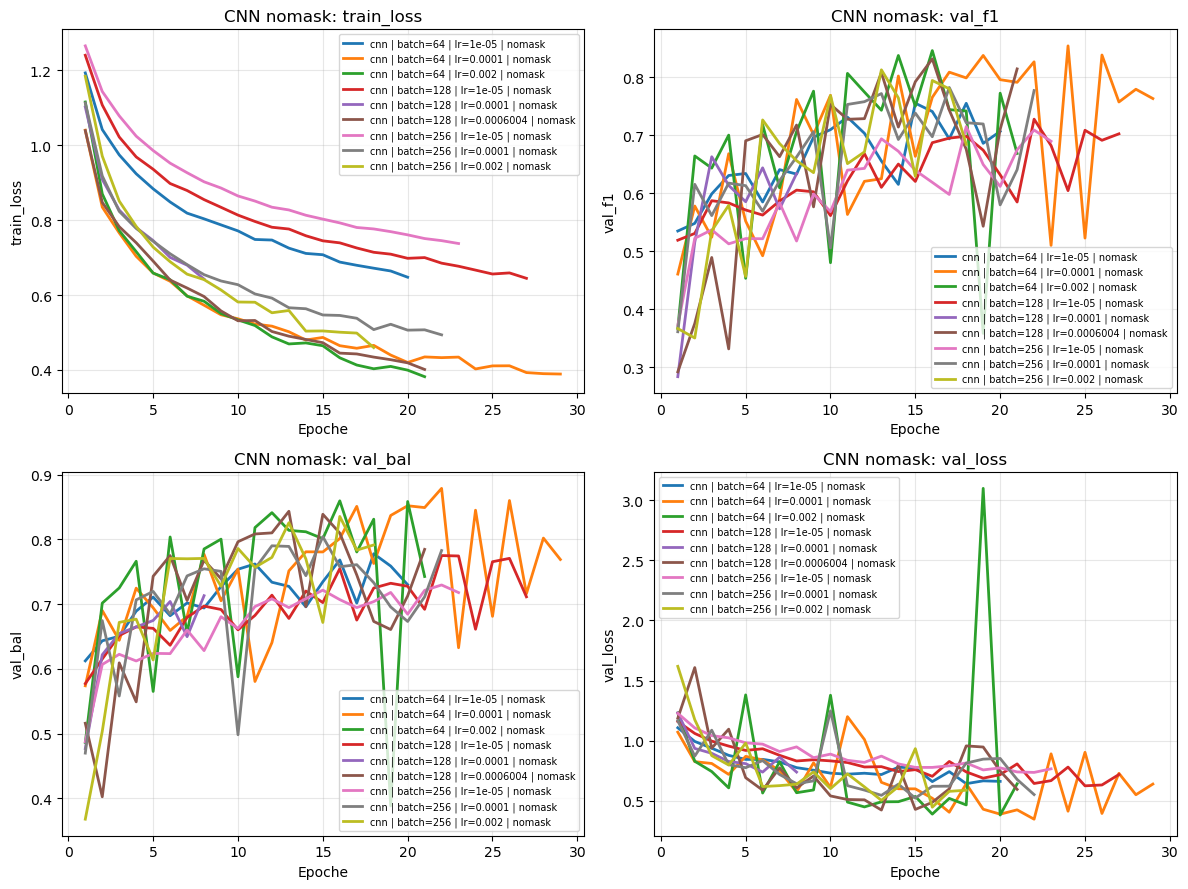


=== MODELLVERGLEICH (ROC micro) ===
cnn | batch=64 | lr=1e-05 | nomask (AUC=0.923)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.968)
cnn | batch=64 | lr=0.002 | nomask (AUC=0.965)
cnn | batch=128 | lr=1e-05 | nomask (AUC=0.913)
cnn | batch=128 | lr=0.0001 | nomask (AUC=0.884)
cnn | batch=128 | lr=0.0006004 | nomask (AUC=0.957)
cnn | batch=256 | lr=1e-05 | nomask (AUC=0.902)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.947)
cnn | batch=256 | lr=0.002 | nomask (AUC=0.949)

=== MODELLVERGLEICH (ROC COVID) ===
cnn | batch=64 | lr=1e-05 | nomask (AUC=0.912)
cnn | batch=64 | lr=0.0001 | nomask (AUC=0.979)
cnn | batch=64 | lr=0.002 | nomask (AUC=0.977)
cnn | batch=128 | lr=1e-05 | nomask (AUC=0.891)
cnn | batch=128 | lr=0.0001 | nomask (AUC=0.771)
cnn | batch=128 | lr=0.0006004 | nomask (AUC=0.968)
cnn | batch=256 | lr=1e-05 | nomask (AUC=0.821)
cnn | batch=256 | lr=0.0001 | nomask (AUC=0.949)
cnn | batch=256 | lr=0.002 | nomask (AUC=0.960)

=== MODELLVERGLEICH (ROC Lung Opacity) ===
cnn | batc

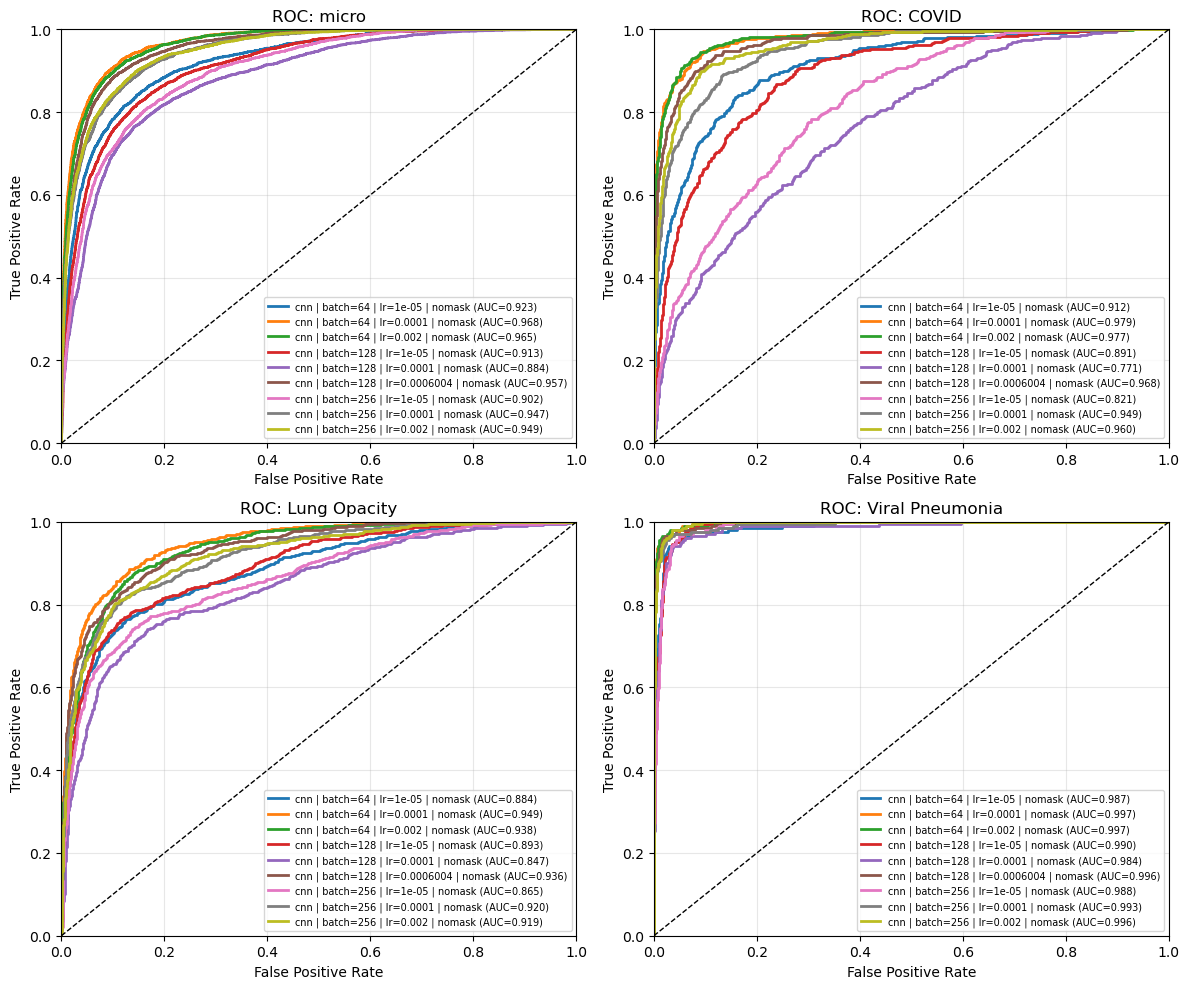

In [150]:
plot_train_overlays_grid(
    train_dirs_cnn_nomask,
    metrics=("train_loss", "val_f1", "val_bal", "val_loss"),
    title_prefix="CNN nomask"
)
plot_test_roc_overlays_grid(
    test_dirs_cnn_nomask,
    class_order=["micro","COVID","Lung Opacity","Viral Pneumonia"]
)
